# Try to classify contigs as prokaryotic or eukaryotic just from an alignment

General idea: eukaryotic contigs, compared with prokaryotic contigs, should have relatively high amounts of positions with variants around 50% frequency (representing diploidy).

In [1]:
%run "Header.ipynb"

In [2]:
import math
import json
import time
import skbio
import pysam
import pysamstats

In [3]:
# No edges with length < this will be considered here
MIN_SEQ_LEN = 5000

# Minimum coverage for positions where we want to look for ~50% mutation rates.
# This is purposefully low so as to cast a wide net.
MIN_COV = 5

# Both of these are inclusive. We'll accept positions (with at least MIN_COV aligned (mis)matches)
# where the maximum-frequency alternate nucleotide's frequency (divided by total # of aligned (mis)matches)
# is within this inclusive range.
#
# ...So, for a position with exactly 5x (mis)match coverage, we'd accept a max-freq alt nucleotide freq of
# [2, 3] but not 1, 4, or 5.
MIN_DIPLOID_MAXALT_FREQ = 0.4
MAX_DIPLOID_MAXALT_FREQ = 0.6

# Both of these are also inclusive. All positions with at least 5x coverage and a max-frequency alternate
# nucleotide rate in this range will be included in a denominator.
MIN_DENOMINATOR_MAXALT_FREQ = 0.05
MAX_DENOMINATOR_MAXALT_FREQ = 0.6

## Get a mapping of sequence (edge) name to sequence length

stolen from the diversity index notebook; should merge these into a single function

also the div index notebook version of this accidentally trumps the `seq2len` variable defined in the header notebook... should fix that, but not super impt

In [4]:
edge2len = {}
edgename = None
with open("../main-workflow/output/all_edges.fasta", "r") as fastafile:
    
    # Assumes that sequences are not split up over multiple lines (so a FASTA file with N sequences
    # should have only 2N lines, maybe 2N + 1 if there's an extra empty newline at the bottom of the file)
    for linenum, line in enumerate(fastafile):
    
        if line.startswith(">"):
            if linenum % 2 != 0:
                raise ValueError("something weird with > location in all_edges.fasta. Go yell at Marcus.")
            edgename = line.strip()[1:]
        else:
            if linenum % 2 != 1:
                raise ValueError("something weird with non > location in all_edges.fasta. Go yell at Marcus.")
            if edgename is None:
                raise ValueError("No sequence name set yet?")
            edge2len[edgename] = len(line.strip())
            edgename = None

print(f"edge2len contains {len(edge2len):,} entries. The length of edge_1 is {edge2len['edge_1']:,} bp.")

edge2len contains 78,793 entries. The length of edge_1 is 39,565 bp.


In [5]:
long_enough_seqs = []
for edge in edge2len:
    if edge2len[edge] >= MIN_SEQ_LEN:
        long_enough_seqs.append(edge)
        
pct = 100 * (len(long_enough_seqs) / len(edge2len))
print(f"{len(long_enough_seqs):,} / {len(edge2len):,} ({pct:.2f}%) edges have a length of at least {MIN_SEQ_LEN:,.0f} bp.")

43,562 / 78,793 (55.29%) edges have a length of at least 5,000 bp.


## Go through the alignment; count the number of positions with ~50% max-frequency alternate nucleotide mismatches

Parts of this (e.g. processing each record in the pileup) could be abstracted to code that's shared between here, the diversity index ntbk, and the bam2pileup script I wrote for the three "selected" MAGs.

**NOTE: This takes quite a while to run (as of writing, it took about 18.4 hours to complete).**

In [18]:
bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam", "rb")

In [12]:
edge2num_mincov_positions = {}
edge2num_mincov_positions_with_at_least_one_mismatch = {}
edge2num_mincov_positions_with_mutrate_in_denominator_range = {}
edge2num_mincov_putatively_diploid_positions = {}
edge2meancov = {}

num_seqs = len(long_enough_seqs)

# This'll print out a ton of output for even a single contig, so I don't recommend using this in practice.
verbose = False

t1 = time.time()

for si, seq in enumerate(long_enough_seqs, 1):
    pct = 100 * (si / num_seqs)
    print(f"On seq {seq} ({si:,} / {num_seqs:,}) ({pct:.2f}%).", end=" ", flush=True)   
    print(f"{edge2len[seq]:,} bp long.", end=" ", flush=True)
    print(f"Runtime: ~{time.time() - t1:,.0f} sec.", end=" ", flush=True)
    
    one_tenth_len = math.floor(edge2len[seq] / 10)
    
    num_mincov_positions = 0
    num_mincov_positions_with_at_least_one_mismatch = 0
    num_mincov_positions_with_mutrate_in_denominator_range = 0
    num_mincov_putatively_diploid_positions = 0
    
    total_cov = 0
    
    # Go through each position in the sequence's pileup (even including relatively low-coverage positions).
    # See bam-to-jsons.py for a description of why these params are useful.
    # Also, note that pysam coords are 0-indexed!
    for ri, rec in enumerate(
        pysamstats.stat_variation(
            bf, chrom=seq, fafile="../main-workflow/output/all_edges.fasta", start=0, end=edge2len[seq],
            truncate=True, pad=True, max_depth=1e6
        ),
        1
    ):
        # very simple progress bar for my own sake. might miss a few dots here and there
        if ri % one_tenth_len == 0:
            print("=", end="", flush=True)
            
        matches = rec["matches"]
        mismatches = rec["mismatches"]
        # NOTE: As with "coverage" in the coverage plots, this doesn't take into account deletions at a
        # given position. That info is available through pysamstats so we could use it here if desired.
        cov = matches + mismatches
        
        total_cov += cov
        
        if verbose: print(f"Pos {ri}... Matches: {matches} / Mismatches: {mismatches} / cov: {cov}")
        
        if cov >= MIN_COV:
            num_mincov_positions += 1
            # Rather than looking at (mismatches / cov), we instead look at each alternate non-matching nucleotide
            # individually.
            nonmatches = set("ACGT") - set(rec["ref"])
            max_alt_nt_freq = max(rec[alt_nt] for alt_nt in nonmatches)
            max_alt_nt_relfreq = max_alt_nt_freq / cov
            
            # Keep track of # (min-cov) positions that have at least one mismatch; could be useful to know
            if max_alt_nt_freq >= 1:
                num_mincov_positions_with_at_least_one_mismatch += 1
                if verbose: print(f"\tHas at least 1 mismatch! Ref = {rec['ref']}; A = {rec['A']}; C = {rec['C']}; G = {rec['G']}; T = {rec['T']}")
                
            # The meat of this: see if this position "counts" as putatively diploid due to having a ~50%
            # mutation rate
            if max_alt_nt_relfreq >= MIN_DIPLOID_MAXALT_FREQ and max_alt_nt_relfreq <= MAX_DIPLOID_MAXALT_FREQ:
                num_mincov_putatively_diploid_positions += 1
                if verbose: print(f"\tPutatively diploid! rel freq = {max_alt_nt_relfreq}")
                
            # Count, less generally, positions in a broader range -- we'll use this as the denominator
            if max_alt_nt_relfreq >= MIN_DENOMINATOR_MAXALT_FREQ and max_alt_nt_relfreq <= MAX_DENOMINATOR_MAXALT_FREQ:
                num_mincov_positions_with_mutrate_in_denominator_range += 1
                if verbose: print(f"\tPosition {ri} has a mut rate in [5%, 60%]: {max_alt_nt_freq} / {cov} = {max_alt_nt_relfreq}")
    
    assert ri == edge2len[seq]
    meancov = total_cov / ri
    
    # Save info for each edge
    edge2num_mincov_positions[seq] = num_mincov_positions
    edge2num_mincov_positions_with_at_least_one_mismatch[seq] = num_mincov_positions_with_at_least_one_mismatch
    edge2num_mincov_putatively_diploid_positions[seq] = num_mincov_putatively_diploid_positions
    edge2num_mincov_positions_with_mutrate_in_denominator_range[seq] = num_mincov_positions_with_mutrate_in_denominator_range
    edge2meancov[seq] = meancov
    
    # Move print info to a new line
    print(f"\n\t{num_mincov_positions:,} MCP;", end=" ")
    print(f"{num_mincov_positions_with_at_least_one_mismatch:,} MCP w/ >= 1 mismatch;", end=" ")
    print(f"{num_mincov_positions_with_mutrate_in_denominator_range:,} 'denominator' MCP;", end=" ")
    print(f"{num_mincov_putatively_diploid_positions:,} 'diploid' MCP;", end=" ")
    print(f"mean cov = {meancov:,.2f}x")

On seq edge_1 (1 / 43,562) (0.00%). 39,565 bp long. Runtime: ~0 sec. ==========
	39,560 MCP; 6,312 MCP w/ >= 1 mismatch; 302 'denominator' MCP; 13 'diploid' MCP; mean cov = 460.40x
On seq edge_3 (2 / 43,562) (0.00%). 38,161 bp long. Runtime: ~2 sec. ==========
	36,963 MCP; 3,805 MCP w/ >= 1 mismatch; 277 'denominator' MCP; 11 'diploid' MCP; mean cov = 258.76x
On seq edge_5 (3 / 43,562) (0.01%). 32,079 bp long. Runtime: ~3 sec. ==========
	10,893 MCP; 140 MCP w/ >= 1 mismatch; 139 'denominator' MCP; 4 'diploid' MCP; mean cov = 3.36x
On seq edge_6 (4 / 43,562) (0.01%). 6,738 bp long. Runtime: ~3 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.40x
On seq edge_8 (5 / 43,562) (0.01%). 1,710,962 bp long. Runtime: ~4 sec. ==========
	1,710,962 MCP; 53,743 MCP w/ >= 1 mismatch; 1,921 'denominator' MCP; 0 'diploid' MCP; mean cov = 111.64x
On seq edge_9 (6 / 43,562) (0.01%). 91,227 bp long. Runtime: ~39 sec. ==========
	39,724 MCP; 1,745 MCP w/ 

On seq edge_59 (46 / 43,562) (0.11%). 852,260 bp long. Runtime: ~389 sec. ==========
	599,190 MCP; 7,849 MCP w/ >= 1 mismatch; 7,743 'denominator' MCP; 352 'diploid' MCP; mean cov = 6.05x
On seq edge_60 (47 / 43,562) (0.11%). 1,726,090 bp long. Runtime: ~403 sec. ==========
	1,726,090 MCP; 106,557 MCP w/ >= 1 mismatch; 1,110 'denominator' MCP; 2 'diploid' MCP; mean cov = 243.86x
On seq edge_61 (48 / 43,562) (0.11%). 202,190 bp long. Runtime: ~462 sec. ==========
	140,980 MCP; 1,831 MCP w/ >= 1 mismatch; 1,734 'denominator' MCP; 103 'diploid' MCP; mean cov = 5.54x
On seq edge_62 (49 / 43,562) (0.11%). 106,456 bp long. Runtime: ~465 sec. ==========
	25,321 MCP; 238 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.05x
On seq edge_63 (50 / 43,562) (0.11%). 100,190 bp long. Runtime: ~467 sec. ==========
	69,879 MCP; 457 MCP w/ >= 1 mismatch; 432 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.21x
On seq edge_64 (51 / 43,562) (0.12%). 33,880 bp long. Runtime: ~469 s

On seq edge_687 (136 / 43,562) (0.31%). 7,558 bp long. Runtime: ~1,071 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.88x
On seq edge_691 (137 / 43,562) (0.31%). 29,655 bp long. Runtime: ~1,071 sec. ==========
	20,562 MCP; 170 MCP w/ >= 1 mismatch; 43 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.96x
On seq edge_692 (138 / 43,562) (0.32%). 13,052 bp long. Runtime: ~1,072 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.05x
On seq edge_694 (139 / 43,562) (0.32%). 1,125,410 bp long. Runtime: ~1,073 sec. ==========
	1,125,410 MCP; 104,840 MCP w/ >= 1 mismatch; 6,057 'denominator' MCP; 0 'diploid' MCP; mean cov = 322.67x
On seq edge_697 (140 / 43,562) (0.32%). 82,781 bp long. Runtime: ~1,111 sec. ==========
	82,769 MCP; 10,567 MCP w/ >= 1 mismatch; 888 'denominator' MCP; 125 'diploid' MCP; mean cov = 371.79x
On seq edge_713 (141 / 43,562) (0.32%). 7,773 bp long. Runtime: ~1,114 sec. ==

On seq edge_931 (180 / 43,562) (0.41%). 5,214 bp long. Runtime: ~1,421 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_936 (181 / 43,562) (0.42%). 32,998 bp long. Runtime: ~1,421 sec. ==========
	9,111 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.61x
On seq edge_947 (182 / 43,562) (0.42%). 713,612 bp long. Runtime: ~1,421 sec. ==========
	671,774 MCP; 18,745 MCP w/ >= 1 mismatch; 7,497 'denominator' MCP; 718 'diploid' MCP; mean cov = 58.96x
On seq edge_960 (183 / 43,562) (0.42%). 2,087,411 bp long. Runtime: ~1,431 sec. ==========
	2,006,344 MCP; 46,906 MCP w/ >= 1 mismatch; 42,881 'denominator' MCP; 6,335 'diploid' MCP; mean cov = 15.04x
On seq edge_962 (184 / 43,562) (0.42%). 5,567 bp long. Runtime: ~1,454 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_965 (185 / 43,562) (0.42%). 9,679 bp long. Runtime: ~1,454 sec. ==

On seq edge_1161 (224 / 43,562) (0.51%). 5,113 bp long. Runtime: ~1,868 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_1163 (225 / 43,562) (0.52%). 805,329 bp long. Runtime: ~1,869 sec. ==========
	786,998 MCP; 19,606 MCP w/ >= 1 mismatch; 16,251 'denominator' MCP; 8 'diploid' MCP; mean cov = 11.26x
On seq edge_1164 (226 / 43,562) (0.52%). 9,611 bp long. Runtime: ~1,878 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.53x
On seq edge_1171 (227 / 43,562) (0.52%). 64,542 bp long. Runtime: ~1,878 sec. ==========
	56,900 MCP; 297 MCP w/ >= 1 mismatch; 176 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.79x
On seq edge_1175 (228 / 43,562) (0.52%). 47,089 bp long. Runtime: ~1,879 sec. ==========
	3,636 MCP; 15 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.84x
On seq edge_1179 (229 / 43,562) (0.53%). 8,945 bp long. Runtime: ~1,880 sec. ==========


On seq edge_1295 (268 / 43,562) (0.62%). 8,092 bp long. Runtime: ~2,270 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.39x
On seq edge_1296 (269 / 43,562) (0.62%). 1,725,481 bp long. Runtime: ~2,270 sec. ==========
	1,698,205 MCP; 88,449 MCP w/ >= 1 mismatch; 12,824 'denominator' MCP; 310 'diploid' MCP; mean cov = 109.95x
On seq edge_1297 (270 / 43,562) (0.62%). 553,294 bp long. Runtime: ~2,304 sec. ==========
	538,194 MCP; 1,651 MCP w/ >= 1 mismatch; 1,455 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.23x
On seq edge_1298 (271 / 43,562) (0.62%). 30,191 bp long. Runtime: ~2,313 sec. ==========
	18,155 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.43x
On seq edge_1299 (272 / 43,562) (0.62%). 84,157 bp long. Runtime: ~2,313 sec. ==========
	67,511 MCP; 341 MCP w/ >= 1 mismatch; 341 'denominator' MCP; 1 'diploid' MCP; mean cov = 8.06x
On seq edge_1300 (273 / 43,562) (0.63%). 1,440,404 bp long. Runtim

On seq edge_1423 (354 / 43,562) (0.81%). 23,097 bp long. Runtime: ~3,475 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_1424 (355 / 43,562) (0.81%). 38,765 bp long. Runtime: ~3,476 sec. ==========
	26,042 MCP; 18 MCP w/ >= 1 mismatch; 18 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.10x
On seq edge_1426 (356 / 43,562) (0.82%). 142,342 bp long. Runtime: ~3,477 sec. ==========
	111,712 MCP; 560 MCP w/ >= 1 mismatch; 559 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.48x
On seq edge_1427 (357 / 43,562) (0.82%). 6,163 bp long. Runtime: ~3,479 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.65x
On seq edge_1428 (358 / 43,562) (0.82%). 625,165 bp long. Runtime: ~3,479 sec. ==========
	624,905 MCP; 23,578 MCP w/ >= 1 mismatch; 1,308 'denominator' MCP; 1 'diploid' MCP; mean cov = 92.98x
On seq edge_1430 (359 / 43,562) (0.82%). 617,023 bp long. Runtime: ~3,491 sec. =======

On seq edge_1495 (398 / 43,562) (0.91%). 12,947 bp long. Runtime: ~3,760 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.23x
On seq edge_1496 (399 / 43,562) (0.92%). 29,231 bp long. Runtime: ~3,760 sec. ==========
	20,230 MCP; 381 MCP w/ >= 1 mismatch; 365 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.56x
On seq edge_1497 (400 / 43,562) (0.92%). 1,586,259 bp long. Runtime: ~3,761 sec. ==========
	1,584,588 MCP; 50,437 MCP w/ >= 1 mismatch; 9,858 'denominator' MCP; 267 'diploid' MCP; mean cov = 29.38x
On seq edge_1498 (401 / 43,562) (0.92%). 28,409 bp long. Runtime: ~3,782 sec. ==========
	22,817 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.51x
On seq edge_1499 (402 / 43,562) (0.92%). 18,785 bp long. Runtime: ~3,783 sec. ==========
	3,686 MCP; 6 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.89x
On seq edge_1500 (403 / 43,562) (0.93%). 102,169 bp long. Runtime: ~3,783 sec. 

On seq edge_1557 (442 / 43,562) (1.01%). 57,513 bp long. Runtime: ~4,062 sec. ==========
	12,478 MCP; 129 MCP w/ >= 1 mismatch; 101 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.40x
On seq edge_1558 (443 / 43,562) (1.02%). 7,038 bp long. Runtime: ~4,063 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_1559 (444 / 43,562) (1.02%). 97,093 bp long. Runtime: ~4,063 sec. ==========
	75,864 MCP; 1,878 MCP w/ >= 1 mismatch; 1,814 'denominator' MCP; 283 'diploid' MCP; mean cov = 6.88x
On seq edge_1561 (445 / 43,562) (1.02%). 5,479 bp long. Runtime: ~4,065 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_1562 (446 / 43,562) (1.02%). 97,241 bp long. Runtime: ~4,065 sec. ==========
	46,483 MCP; 1,392 MCP w/ >= 1 mismatch; 1,180 'denominator' MCP; 202 'diploid' MCP; mean cov = 4.40x
On seq edge_1563 (447 / 43,562) (1.03%). 19,753 bp long. Runtime: ~4,066 sec. =====

On seq edge_1618 (486 / 43,562) (1.12%). 8,537 bp long. Runtime: ~4,257 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_1620 (487 / 43,562) (1.12%). 1,737,772 bp long. Runtime: ~4,257 sec. ==========
	1,730,482 MCP; 78,079 MCP w/ >= 1 mismatch; 30,727 'denominator' MCP; 139 'diploid' MCP; mean cov = 34.28x
On seq edge_1621 (488 / 43,562) (1.12%). 144,432 bp long. Runtime: ~4,281 sec. ==========
	144,432 MCP; 2,381 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 64.74x
On seq edge_1622 (489 / 43,562) (1.12%). 31,508 bp long. Runtime: ~4,283 sec. ==========
	29,746 MCP; 336 MCP w/ >= 1 mismatch; 271 'denominator' MCP; 85 'diploid' MCP; mean cov = 15.53x
On seq edge_1623 (490 / 43,562) (1.12%). 4,011,798 bp long. Runtime: ~4,284 sec. ==========
	4,011,781 MCP; 28,795 MCP w/ >= 1 mismatch; 432 'denominator' MCP; 41 'diploid' MCP; mean cov = 36.61x
On seq edge_1624 (491 / 43,562) (1.13%). 45,216 bp lon

On seq edge_1722 (572 / 43,562) (1.31%). 46,504 bp long. Runtime: ~5,117 sec. ==========
	23,469 MCP; 1,027 MCP w/ >= 1 mismatch; 756 'denominator' MCP; 203 'diploid' MCP; mean cov = 4.68x
On seq edge_1723 (573 / 43,562) (1.32%). 18,605 bp long. Runtime: ~5,118 sec. ==========
	18,605 MCP; 209 MCP w/ >= 1 mismatch; 194 'denominator' MCP; 1 'diploid' MCP; mean cov = 17.07x
On seq edge_1724 (574 / 43,562) (1.32%). 917,259 bp long. Runtime: ~5,118 sec. ==========
	917,259 MCP; 76,501 MCP w/ >= 1 mismatch; 5,295 'denominator' MCP; 124 'diploid' MCP; mean cov = 193.95x
On seq edge_1725 (575 / 43,562) (1.32%). 6,917 bp long. Runtime: ~5,136 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_1729 (576 / 43,562) (1.32%). 38,922 bp long. Runtime: ~5,137 sec. ==========
	26,644 MCP; 57 MCP w/ >= 1 mismatch; 54 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.71x
On seq edge_1730 (577 / 43,562) (1.32%). 150,143 bp long. Runtime: ~5,1

On seq edge_1851 (659 / 43,562) (1.51%). 20,416 bp long. Runtime: ~5,707 sec. ==========
	1,302 MCP; 69 MCP w/ >= 1 mismatch; 67 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.23x
On seq edge_1852 (660 / 43,562) (1.52%). 61,214 bp long. Runtime: ~5,708 sec. ==========
	45,239 MCP; 679 MCP w/ >= 1 mismatch; 539 'denominator' MCP; 119 'diploid' MCP; mean cov = 6.06x
On seq edge_1853 (661 / 43,562) (1.52%). 39,576 bp long. Runtime: ~5,709 sec. ==========
	37,036 MCP; 4,617 MCP w/ >= 1 mismatch; 1,446 'denominator' MCP; 186 'diploid' MCP; mean cov = 64.49x
On seq edge_1855 (662 / 43,562) (1.52%). 5,293 bp long. Runtime: ~5,709 sec. ==========
	4,762 MCP; 21 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 1 'diploid' MCP; mean cov = 9.19x
On seq edge_1856 (663 / 43,562) (1.52%). 7,231 bp long. Runtime: ~5,710 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_1857 (664 / 43,562) (1.52%). 6,966 bp long. Runtime: ~5,710 sec. =======

On seq edge_1958 (747 / 43,562) (1.71%). 106,762 bp long. Runtime: ~6,029 sec. ==========
	98,502 MCP; 2,469 MCP w/ >= 1 mismatch; 2,152 'denominator' MCP; 344 'diploid' MCP; mean cov = 14.06x
On seq edge_1959 (748 / 43,562) (1.72%). 33,271 bp long. Runtime: ~6,031 sec. ==========
	11,282 MCP; 29 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.10x
On seq edge_1961 (749 / 43,562) (1.72%). 11,017 bp long. Runtime: ~6,032 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_1962 (750 / 43,562) (1.72%). 106,738 bp long. Runtime: ~6,032 sec. ==========
	59,405 MCP; 487 MCP w/ >= 1 mismatch; 481 'denominator' MCP; 170 'diploid' MCP; mean cov = 5.21x
On seq edge_1963 (751 / 43,562) (1.72%). 563,958 bp long. Runtime: ~6,033 sec. ==========
	538,672 MCP; 2,945 MCP w/ >= 1 mismatch; 1,819 'denominator' MCP; 272 'diploid' MCP; mean cov = 11.59x
On seq edge_1964 (752 / 43,562) (1.73%). 19,650 bp long. Runtime: 

On seq edge_2066 (834 / 43,562) (1.91%). 112,661 bp long. Runtime: ~6,680 sec. ==========
	80,185 MCP; 785 MCP w/ >= 1 mismatch; 202 'denominator' MCP; 2 'diploid' MCP; mean cov = 12.18x
On seq edge_2067 (835 / 43,562) (1.92%). 23,084 bp long. Runtime: ~6,682 sec. ==========
	16,162 MCP; 1,312 MCP w/ >= 1 mismatch; 520 'denominator' MCP; 219 'diploid' MCP; mean cov = 59.29x
On seq edge_2068 (836 / 43,562) (1.92%). 66,298 bp long. Runtime: ~6,683 sec. ==========
	66,298 MCP; 5,836 MCP w/ >= 1 mismatch; 995 'denominator' MCP; 17 'diploid' MCP; mean cov = 185.11x
On seq edge_2069 (837 / 43,562) (1.92%). 81,997 bp long. Runtime: ~6,685 sec. ==========
	70,171 MCP; 315 MCP w/ >= 1 mismatch; 272 'denominator' MCP; 9 'diploid' MCP; mean cov = 9.39x
On seq edge_2070 (838 / 43,562) (1.92%). 79,780 bp long. Runtime: ~6,687 sec. ==========
	72,039 MCP; 3,603 MCP w/ >= 1 mismatch; 2,983 'denominator' MCP; 425 'diploid' MCP; mean cov = 18.06x
On seq edge_2071 (839 / 43,562) (1.93%). 22,130 bp long.

On seq edge_2121 (878 / 43,562) (2.02%). 914,294 bp long. Runtime: ~6,869 sec. ==========
	908,489 MCP; 3,738 MCP w/ >= 1 mismatch; 1,542 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.22x
On seq edge_2122 (879 / 43,562) (2.02%). 103,899 bp long. Runtime: ~6,880 sec. ==========
	102,152 MCP; 2,150 MCP w/ >= 1 mismatch; 976 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.57x
On seq edge_2123 (880 / 43,562) (2.02%). 697,494 bp long. Runtime: ~6,881 sec. ==========
	697,023 MCP; 44,389 MCP w/ >= 1 mismatch; 7,825 'denominator' MCP; 255 'diploid' MCP; mean cov = 166.20x
On seq edge_2124 (881 / 43,562) (2.02%). 23,681 bp long. Runtime: ~6,894 sec. ==========
	20,455 MCP; 538 MCP w/ >= 1 mismatch; 215 'denominator' MCP; 61 'diploid' MCP; mean cov = 15.68x
On seq edge_2125 (882 / 43,562) (2.02%). 2,279,210 bp long. Runtime: ~6,895 sec. ==========
	2,264,257 MCP; 151,278 MCP w/ >= 1 mismatch; 27,008 'denominator' MCP; 536 'diploid' MCP; mean cov = 170.50x
On seq edge_2126 (883 / 43,562) (

On seq edge_2229 (965 / 43,562) (2.22%). 32,157 bp long. Runtime: ~7,533 sec. ==========
	18,244 MCP; 43 MCP w/ >= 1 mismatch; 43 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.32x
On seq edge_2230 (966 / 43,562) (2.22%). 254,202 bp long. Runtime: ~7,534 sec. ==========
	246,806 MCP; 10,537 MCP w/ >= 1 mismatch; 10,481 'denominator' MCP; 3,229 'diploid' MCP; mean cov = 13.52x
On seq edge_2231 (967 / 43,562) (2.22%). 267,642 bp long. Runtime: ~7,538 sec. ==========
	267,637 MCP; 13,273 MCP w/ >= 1 mismatch; 4,281 'denominator' MCP; 171 'diploid' MCP; mean cov = 89.42x
On seq edge_2234 (968 / 43,562) (2.22%). 37,178 bp long. Runtime: ~7,543 sec. ==========
	36,757 MCP; 2,601 MCP w/ >= 1 mismatch; 1,255 'denominator' MCP; 250 'diploid' MCP; mean cov = 39.07x
On seq edge_2235 (969 / 43,562) (2.22%). 62,238 bp long. Runtime: ~7,544 sec. ==========
	62,231 MCP; 4,804 MCP w/ >= 1 mismatch; 913 'denominator' MCP; 0 'diploid' MCP; mean cov = 136.42x
On seq edge_2236 (970 / 43,562) (2.23%). 37

On seq edge_2283 (1,009 / 43,562) (2.32%). 36,252 bp long. Runtime: ~7,664 sec. ==========
	33,925 MCP; 101 MCP w/ >= 1 mismatch; 86 'denominator' MCP; 1 'diploid' MCP; mean cov = 11.02x
On seq edge_2284 (1,010 / 43,562) (2.32%). 5,444 bp long. Runtime: ~7,665 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_2286 (1,011 / 43,562) (2.32%). 134,356 bp long. Runtime: ~7,665 sec. ==========
	121,076 MCP; 10,875 MCP w/ >= 1 mismatch; 6,950 'denominator' MCP; 568 'diploid' MCP; mean cov = 23.01x
On seq edge_2287 (1,012 / 43,562) (2.32%). 20,346 bp long. Runtime: ~7,667 sec. ==========
	15,899 MCP; 1,764 MCP w/ >= 1 mismatch; 503 'denominator' MCP; 112 'diploid' MCP; mean cov = 67.40x
On seq edge_2289 (1,013 / 43,562) (2.33%). 2,279,686 bp long. Runtime: ~7,668 sec. ==========
	2,251,329 MCP; 13,962 MCP w/ >= 1 mismatch; 2,342 'denominator' MCP; 2 'diploid' MCP; mean cov = 25.79x
On seq edge_2290 (1,014 / 43,562) (2.33%). 38,01

On seq edge_2403 (1,095 / 43,562) (2.51%). 2,532,810 bp long. Runtime: ~9,234 sec. ==========
	2,501,852 MCP; 36,557 MCP w/ >= 1 mismatch; 34,930 'denominator' MCP; 36 'diploid' MCP; mean cov = 12.21x
On seq edge_2404 (1,096 / 43,562) (2.52%). 29,443 bp long. Runtime: ~9,268 sec. ==========
	21,360 MCP; 251 MCP w/ >= 1 mismatch; 251 'denominator' MCP; 2 'diploid' MCP; mean cov = 6.37x
On seq edge_2405 (1,097 / 43,562) (2.52%). 50,605 bp long. Runtime: ~9,269 sec. ==========
	19,589 MCP; 464 MCP w/ >= 1 mismatch; 464 'denominator' MCP; 103 'diploid' MCP; mean cov = 3.79x
On seq edge_2406 (1,098 / 43,562) (2.52%). 1,769,728 bp long. Runtime: ~9,270 sec. ==========
	1,769,725 MCP; 150,051 MCP w/ >= 1 mismatch; 13,418 'denominator' MCP; 92 'diploid' MCP; mean cov = 284.33x
On seq edge_2408 (1,099 / 43,562) (2.52%). 10,383 bp long. Runtime: ~9,321 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.89x
On seq edge_2409 (1,100 / 43,562) (2.53%).

On seq edge_2509 (1,181 / 43,562) (2.71%). 85,652 bp long. Runtime: ~9,839 sec. ==========
	53,855 MCP; 475 MCP w/ >= 1 mismatch; 410 'denominator' MCP; 76 'diploid' MCP; mean cov = 6.66x
On seq edge_2511 (1,182 / 43,562) (2.71%). 28,061 bp long. Runtime: ~9,840 sec. ==========
	10,866 MCP; 55 MCP w/ >= 1 mismatch; 55 'denominator' MCP; 38 'diploid' MCP; mean cov = 3.76x
On seq edge_2512 (1,183 / 43,562) (2.72%). 54,598 bp long. Runtime: ~9,841 sec. ==========
	47,926 MCP; 361 MCP w/ >= 1 mismatch; 325 'denominator' MCP; 79 'diploid' MCP; mean cov = 9.22x
On seq edge_2513 (1,184 / 43,562) (2.72%). 6,138 bp long. Runtime: ~9,842 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_2514 (1,185 / 43,562) (2.72%). 14,869 bp long. Runtime: ~9,842 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_2516 (1,186 / 43,562) (2.72%). 39,484 bp long. Runtime: ~9,843 sec. ===

On seq edge_2618 (1,267 / 43,562) (2.91%). 137,943 bp long. Runtime: ~10,242 sec. ==========
	93,601 MCP; 779 MCP w/ >= 1 mismatch; 778 'denominator' MCP; 82 'diploid' MCP; mean cov = 7.81x
On seq edge_2619 (1,268 / 43,562) (2.91%). 77,027 bp long. Runtime: ~10,244 sec. ==========
	48,359 MCP; 740 MCP w/ >= 1 mismatch; 650 'denominator' MCP; 120 'diploid' MCP; mean cov = 5.08x
On seq edge_2620 (1,269 / 43,562) (2.91%). 137,106 bp long. Runtime: ~10,246 sec. ==========
	55,853 MCP; 2,195 MCP w/ >= 1 mismatch; 2,152 'denominator' MCP; 187 'diploid' MCP; mean cov = 4.41x
On seq edge_2621 (1,270 / 43,562) (2.92%). 7,134 bp long. Runtime: ~10,248 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_2622 (1,271 / 43,562) (2.92%). 7,435 bp long. Runtime: ~10,248 sec. ==========
	7,435 MCP; 195 MCP w/ >= 1 mismatch; 168 'denominator' MCP; 70 'diploid' MCP; mean cov = 17.85x
On seq edge_2624 (1,272 / 43,562) (2.92%). 74,325 bp long. 

On seq edge_2673 (1,310 / 43,562) (3.01%). 86,053 bp long. Runtime: ~10,427 sec. ==========
	31,883 MCP; 381 MCP w/ >= 1 mismatch; 381 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.86x
On seq edge_2674 (1,311 / 43,562) (3.01%). 10,140 bp long. Runtime: ~10,428 sec. ==========
	9,147 MCP; 26 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.18x
On seq edge_2675 (1,312 / 43,562) (3.01%). 45,589 bp long. Runtime: ~10,428 sec. ==========
	35,438 MCP; 95 MCP w/ >= 1 mismatch; 95 'denominator' MCP; 19 'diploid' MCP; mean cov = 8.67x
On seq edge_2676 (1,313 / 43,562) (3.01%). 395,566 bp long. Runtime: ~10,429 sec. ==========
	366,918 MCP; 857 MCP w/ >= 1 mismatch; 813 'denominator' MCP; 17 'diploid' MCP; mean cov = 9.09x
On seq edge_2678 (1,314 / 43,562) (3.02%). 5,910 bp long. Runtime: ~10,434 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_2679 (1,315 / 43,562) (3.02%). 278,294 bp long. Runtime: ~1

On seq edge_2776 (1,396 / 43,562) (3.20%). 31,152 bp long. Runtime: ~11,054 sec. ==========
	27,533 MCP; 1,266 MCP w/ >= 1 mismatch; 387 'denominator' MCP; 161 'diploid' MCP; mean cov = 17.83x
On seq edge_2778 (1,397 / 43,562) (3.21%). 374,235 bp long. Runtime: ~11,055 sec. ==========
	340,933 MCP; 5,460 MCP w/ >= 1 mismatch; 4,944 'denominator' MCP; 352 'diploid' MCP; mean cov = 8.60x
On seq edge_2779 (1,398 / 43,562) (3.21%). 782,928 bp long. Runtime: ~11,060 sec. ==========
	771,318 MCP; 8,586 MCP w/ >= 1 mismatch; 2,467 'denominator' MCP; 0 'diploid' MCP; mean cov = 25.14x
On seq edge_2780 (1,399 / 43,562) (3.21%). 16,314 bp long. Runtime: ~11,071 sec. ==========
	11,125 MCP; 1,189 MCP w/ >= 1 mismatch; 1,143 'denominator' MCP; 13 'diploid' MCP; mean cov = 4.90x
On seq edge_2782 (1,400 / 43,562) (3.21%). 65,015 bp long. Runtime: ~11,072 sec. ==========
	31,051 MCP; 141 MCP w/ >= 1 mismatch; 37 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.55x
On seq edge_2783 (1,401 / 43,562) (3

On seq edge_2882 (1,482 / 43,562) (3.40%). 48,680 bp long. Runtime: ~11,372 sec. ==========
	23,989 MCP; 29 MCP w/ >= 1 mismatch; 29 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.86x
On seq edge_2884 (1,483 / 43,562) (3.40%). 33,694 bp long. Runtime: ~11,373 sec. ==========
	5,172 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.74x
On seq edge_2885 (1,484 / 43,562) (3.41%). 409,447 bp long. Runtime: ~11,374 sec. ==========
	359,206 MCP; 10,658 MCP w/ >= 1 mismatch; 8,786 'denominator' MCP; 1,389 'diploid' MCP; mean cov = 7.80x
On seq edge_2886 (1,485 / 43,562) (3.41%). 11,069 bp long. Runtime: ~11,379 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.41x
On seq edge_2887 (1,486 / 43,562) (3.41%). 7,546 bp long. Runtime: ~11,380 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_2888 (1,487 / 43,562) (3.41%). 15,270 bp long. Runtime: ~11,380

On seq edge_2988 (1,568 / 43,562) (3.60%). 41,074 bp long. Runtime: ~11,710 sec. ==========
	40,504 MCP; 1,346 MCP w/ >= 1 mismatch; 344 'denominator' MCP; 15 'diploid' MCP; mean cov = 22.69x
On seq edge_2989 (1,569 / 43,562) (3.60%). 197,070 bp long. Runtime: ~11,711 sec. ==========
	89,421 MCP; 114 MCP w/ >= 1 mismatch; 107 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.26x
On seq edge_2990 (1,570 / 43,562) (3.60%). 5,907 bp long. Runtime: ~11,714 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_2991 (1,571 / 43,562) (3.61%). 411,550 bp long. Runtime: ~11,714 sec. ==========
	330,270 MCP; 9,910 MCP w/ >= 1 mismatch; 9,454 'denominator' MCP; 1,406 'diploid' MCP; mean cov = 7.86x
On seq edge_2992 (1,572 / 43,562) (3.61%). 47,676 bp long. Runtime: ~11,720 sec. ==========
	44,837 MCP; 321 MCP w/ >= 1 mismatch; 259 'denominator' MCP; 130 'diploid' MCP; mean cov = 14.79x
On seq edge_2993 (1,573 / 43,562) (3.61%). 13,763 bp

On seq edge_3037 (1,611 / 43,562) (3.70%). 3,408,147 bp long. Runtime: ~12,080 sec. ==========
	3,408,147 MCP; 126,176 MCP w/ >= 1 mismatch; 586 'denominator' MCP; 1 'diploid' MCP; mean cov = 226.64x
On seq edge_3038 (1,612 / 43,562) (3.70%). 48,126 bp long. Runtime: ~12,179 sec. ==========
	2,279 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.87x
On seq edge_3039 (1,613 / 43,562) (3.70%). 324,693 bp long. Runtime: ~12,180 sec. ==========
	179,157 MCP; 3,992 MCP w/ >= 1 mismatch; 3,791 'denominator' MCP; 554 'diploid' MCP; mean cov = 5.48x
On seq edge_3041 (1,614 / 43,562) (3.71%). 11,577 bp long. Runtime: ~12,184 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.82x
On seq edge_3042 (1,615 / 43,562) (3.71%). 52,004 bp long. Runtime: ~12,185 sec. ==========
	24,510 MCP; 144 MCP w/ >= 1 mismatch; 139 'denominator' MCP; 23 'diploid' MCP; mean cov = 4.56x
On seq edge_3043 (1,616 / 43,562) (3.71%). 321,719 bp

On seq edge_3087 (1,655 / 43,562) (3.80%). 195,616 bp long. Runtime: ~12,286 sec. ==========
	192,965 MCP; 8,402 MCP w/ >= 1 mismatch; 5,114 'denominator' MCP; 182 'diploid' MCP; mean cov = 32.40x
On seq edge_3089 (1,656 / 43,562) (3.80%). 1,466,840 bp long. Runtime: ~12,289 sec. ==========
	1,331,715 MCP; 31,833 MCP w/ >= 1 mismatch; 30,367 'denominator' MCP; 6,166 'diploid' MCP; mean cov = 10.91x
On seq edge_3090 (1,657 / 43,562) (3.80%). 47,597 bp long. Runtime: ~12,306 sec. ==========
	7,721 MCP; 11 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.67x
On seq edge_3091 (1,658 / 43,562) (3.81%). 1,024,038 bp long. Runtime: ~12,307 sec. ==========
	1,018,862 MCP; 31,777 MCP w/ >= 1 mismatch; 17,835 'denominator' MCP; 2,122 'diploid' MCP; mean cov = 40.99x
On seq edge_3092 (1,659 / 43,562) (3.81%). 460,013 bp long. Runtime: ~12,320 sec. ==========
	434,904 MCP; 13,607 MCP w/ >= 1 mismatch; 9,913 'denominator' MCP; 777 'diploid' MCP; mean cov = 24.28x
On seq edge

On seq edge_3143 (1,698 / 43,562) (3.90%). 40,691 bp long. Runtime: ~12,446 sec. ==========
	6,678 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.88x
On seq edge_3144 (1,699 / 43,562) (3.90%). 53,312 bp long. Runtime: ~12,446 sec. ==========
	52,789 MCP; 692 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 40.47x
On seq edge_3145 (1,700 / 43,562) (3.90%). 43,389 bp long. Runtime: ~12,447 sec. ==========
	43,055 MCP; 539 MCP w/ >= 1 mismatch; 209 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.45x
On seq edge_3146 (1,701 / 43,562) (3.90%). 6,322 bp long. Runtime: ~12,448 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_3147 (1,702 / 43,562) (3.91%). 1,004,023 bp long. Runtime: ~12,448 sec. ==========
	998,744 MCP; 12,795 MCP w/ >= 1 mismatch; 7,625 'denominator' MCP; 5 'diploid' MCP; mean cov = 31.50x
On seq edge_3148 (1,703 / 43,562) (3.91%). 17,078 bp long. Runti

On seq edge_3188 (1,741 / 43,562) (4.00%). 194,931 bp long. Runtime: ~12,757 sec. ==========
	194,931 MCP; 7,673 MCP w/ >= 1 mismatch; 2,555 'denominator' MCP; 849 'diploid' MCP; mean cov = 68.57x
On seq edge_3189 (1,742 / 43,562) (4.00%). 24,578 bp long. Runtime: ~12,761 sec. ==========
	11,506 MCP; 31 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.79x
On seq edge_3190 (1,743 / 43,562) (4.00%). 31,707 bp long. Runtime: ~12,761 sec. ==========
	27,143 MCP; 2,044 MCP w/ >= 1 mismatch; 321 'denominator' MCP; 52 'diploid' MCP; mean cov = 157.55x
On seq edge_3191 (1,744 / 43,562) (4.00%). 28,465 bp long. Runtime: ~12,762 sec. ==========
	215 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.56x
On seq edge_3192 (1,745 / 43,562) (4.01%). 1,727,837 bp long. Runtime: ~12,763 sec. ==========
	1,477,843 MCP; 11,048 MCP w/ >= 1 mismatch; 10,529 'denominator' MCP; 292 'diploid' MCP; mean cov = 7.95x
On seq edge_3193 (1,746 / 43,562) (4.01%)

On seq edge_3297 (1,827 / 43,562) (4.19%). 431,496 bp long. Runtime: ~13,089 sec. ==========
	425,362 MCP; 26,191 MCP w/ >= 1 mismatch; 287 'denominator' MCP; 0 'diploid' MCP; mean cov = 208.13x
On seq edge_3298 (1,828 / 43,562) (4.20%). 53,837 bp long. Runtime: ~13,098 sec. ==========
	52,492 MCP; 991 MCP w/ >= 1 mismatch; 746 'denominator' MCP; 22 'diploid' MCP; mean cov = 17.71x
On seq edge_3299 (1,829 / 43,562) (4.20%). 47,504 bp long. Runtime: ~13,099 sec. ==========
	47,499 MCP; 154 MCP w/ >= 1 mismatch; 109 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.63x
On seq edge_3301 (1,830 / 43,562) (4.20%). 34,657 bp long. Runtime: ~13,100 sec. ==========
	15,312 MCP; 186 MCP w/ >= 1 mismatch; 185 'denominator' MCP; 33 'diploid' MCP; mean cov = 3.70x
On seq edge_3302 (1,831 / 43,562) (4.20%). 71,665 bp long. Runtime: ~13,100 sec. ==========
	41,486 MCP; 526 MCP w/ >= 1 mismatch; 443 'denominator' MCP; 26 'diploid' MCP; mean cov = 8.18x
On seq edge_3303 (1,832 / 43,562) (4.21%). 15,48

On seq edge_3395 (1,913 / 43,562) (4.39%). 21,090 bp long. Runtime: ~13,467 sec. ==========
	10,319 MCP; 281 MCP w/ >= 1 mismatch; 275 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.88x
On seq edge_3396 (1,914 / 43,562) (4.39%). 150,862 bp long. Runtime: ~13,467 sec. ==========
	148,791 MCP; 2,519 MCP w/ >= 1 mismatch; 910 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.40x
On seq edge_3398 (1,915 / 43,562) (4.40%). 16,138 bp long. Runtime: ~13,469 sec. ==========
	6,372 MCP; 15 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.09x
On seq edge_3400 (1,916 / 43,562) (4.40%). 67,015 bp long. Runtime: ~13,469 sec. ==========
	66,031 MCP; 3,230 MCP w/ >= 1 mismatch; 199 'denominator' MCP; 81 'diploid' MCP; mean cov = 223.98x
On seq edge_3402 (1,917 / 43,562) (4.40%). 3,713,351 bp long. Runtime: ~13,471 sec. ==========
	3,700,281 MCP; 743,824 MCP w/ >= 1 mismatch; 5,791 'denominator' MCP; 75 'diploid' MCP; mean cov = 877.42x
On seq edge_3403 (1,918 / 43,562) (4.40

On seq edge_3454 (1,956 / 43,562) (4.49%). 91,657 bp long. Runtime: ~13,828 sec. ==========
	68,892 MCP; 2,806 MCP w/ >= 1 mismatch; 2,462 'denominator' MCP; 206 'diploid' MCP; mean cov = 6.77x
On seq edge_3455 (1,957 / 43,562) (4.49%). 14,620 bp long. Runtime: ~13,830 sec. ==========
	14,011 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.32x
On seq edge_3456 (1,958 / 43,562) (4.49%). 32,227 bp long. Runtime: ~13,830 sec. ==========
	31,487 MCP; 898 MCP w/ >= 1 mismatch; 625 'denominator' MCP; 156 'diploid' MCP; mean cov = 18.19x
On seq edge_3457 (1,959 / 43,562) (4.50%). 250,620 bp long. Runtime: ~13,831 sec. ==========
	248,303 MCP; 5,544 MCP w/ >= 1 mismatch; 5,164 'denominator' MCP; 481 'diploid' MCP; mean cov = 15.19x
On seq edge_3458 (1,960 / 43,562) (4.50%). 1,068,125 bp long. Runtime: ~13,834 sec. ==========
	1,049,100 MCP; 7,982 MCP w/ >= 1 mismatch; 6,881 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.56x
On seq edge_3459 (1,961 / 43,562) 

On seq edge_3556 (2,042 / 43,562) (4.69%). 407,509 bp long. Runtime: ~14,133 sec. ==========
	391,490 MCP; 14,783 MCP w/ >= 1 mismatch; 13,377 'denominator' MCP; 2,869 'diploid' MCP; mean cov = 13.43x
On seq edge_3558 (2,043 / 43,562) (4.69%). 46,990 bp long. Runtime: ~14,138 sec. ==========
	24,689 MCP; 26 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.13x
On seq edge_3559 (2,044 / 43,562) (4.69%). 167,059 bp long. Runtime: ~14,138 sec. ==========
	127,442 MCP; 2,246 MCP w/ >= 1 mismatch; 2,122 'denominator' MCP; 142 'diploid' MCP; mean cov = 6.15x
On seq edge_3560 (2,045 / 43,562) (4.69%). 26,188 bp long. Runtime: ~14,140 sec. ==========
	6,605 MCP; 60 MCP w/ >= 1 mismatch; 60 'denominator' MCP; 20 'diploid' MCP; mean cov = 3.14x
On seq edge_3561 (2,046 / 43,562) (4.70%). 56,085 bp long. Runtime: ~14,140 sec. ==========
	42,803 MCP; 942 MCP w/ >= 1 mismatch; 942 'denominator' MCP; 81 'diploid' MCP; mean cov = 9.86x
On seq edge_3562 (2,047 / 43,562) (4.70%).

On seq edge_3657 (2,128 / 43,562) (4.88%). 246,188 bp long. Runtime: ~14,389 sec. ==========
	246,188 MCP; 8,933 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 90.68x
On seq edge_3658 (2,129 / 43,562) (4.89%). 316,649 bp long. Runtime: ~14,393 sec. ==========
	188,119 MCP; 470 MCP w/ >= 1 mismatch; 470 'denominator' MCP; 7 'diploid' MCP; mean cov = 6.03x
On seq edge_3659 (2,130 / 43,562) (4.89%). 15,014 bp long. Runtime: ~14,396 sec. ==========
	5,916 MCP; 9 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.44x
On seq edge_3660 (2,131 / 43,562) (4.89%). 7,433 bp long. Runtime: ~14,396 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_3661 (2,132 / 43,562) (4.89%). 5,367 bp long. Runtime: ~14,397 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_3662 (2,133 / 43,562) (4.90%). 46,999 bp long. Runtime: ~14,397 sec.

On seq edge_3717 (2,172 / 43,562) (4.99%). 6,559 bp long. Runtime: ~14,480 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_3718 (2,173 / 43,562) (4.99%). 121,913 bp long. Runtime: ~14,480 sec. ==========
	115,042 MCP; 6,098 MCP w/ >= 1 mismatch; 4,726 'denominator' MCP; 252 'diploid' MCP; mean cov = 21.56x
On seq edge_3719 (2,174 / 43,562) (4.99%). 24,462 bp long. Runtime: ~14,481 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.86x
On seq edge_3720 (2,175 / 43,562) (4.99%). 6,495 bp long. Runtime: ~14,482 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.53x
On seq edge_3721 (2,176 / 43,562) (5.00%). 295,247 bp long. Runtime: ~14,482 sec. ==========
	267,522 MCP; 10,121 MCP w/ >= 1 mismatch; 9,966 'denominator' MCP; 1,404 'diploid' MCP; mean cov = 8.03x
On seq edge_3722 (2,177 / 43,562) (5.00%). 588,969 bp long. Runtime: 

On seq edge_3764 (2,216 / 43,562) (5.09%). 11,570 bp long. Runtime: ~14,572 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.34x
On seq edge_3765 (2,217 / 43,562) (5.09%). 104,845 bp long. Runtime: ~14,572 sec. ==========
	96,260 MCP; 1,272 MCP w/ >= 1 mismatch; 785 'denominator' MCP; 300 'diploid' MCP; mean cov = 16.69x
On seq edge_3768 (2,218 / 43,562) (5.09%). 35,369 bp long. Runtime: ~14,574 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.99x
On seq edge_3769 (2,219 / 43,562) (5.09%). 40,962 bp long. Runtime: ~14,574 sec. ==========
	28,729 MCP; 2,533 MCP w/ >= 1 mismatch; 981 'denominator' MCP; 51 'diploid' MCP; mean cov = 47.74x
On seq edge_3770 (2,220 / 43,562) (5.10%). 1,456,444 bp long. Runtime: ~14,575 sec. ==========
	1,444,967 MCP; 6,584 MCP w/ >= 1 mismatch; 6,017 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.13x
On seq edge_3771 (2,221 / 43,562) (5.10%). 39,876 bp long

On seq edge_3862 (2,303 / 43,562) (5.29%). 18,044 bp long. Runtime: ~14,804 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.28x
On seq edge_3863 (2,304 / 43,562) (5.29%). 33,142 bp long. Runtime: ~14,804 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.12x
On seq edge_3864 (2,305 / 43,562) (5.29%). 10,165 bp long. Runtime: ~14,805 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.74x
On seq edge_3865 (2,306 / 43,562) (5.29%). 18,750 bp long. Runtime: ~14,805 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.23x
On seq edge_3866 (2,307 / 43,562) (5.30%). 191,314 bp long. Runtime: ~14,805 sec. ==========
	191,309 MCP; 2,070 MCP w/ >= 1 mismatch; 234 'denominator' MCP; 18 'diploid' MCP; mean cov = 40.58x
On seq edge_3867 (2,308 / 43,562) (5.30%). 13,920 bp long. Runtime: ~14,808 sec. =========

On seq edge_3919 (2,347 / 43,562) (5.39%). 10,670 bp long. Runtime: ~14,897 sec. ==========
	1,952 MCP; 79 MCP w/ >= 1 mismatch; 60 'denominator' MCP; 21 'diploid' MCP; mean cov = 3.27x
On seq edge_3923 (2,348 / 43,562) (5.39%). 15,323 bp long. Runtime: ~14,897 sec. ==========
	15,323 MCP; 971 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 212.44x
On seq edge_3924 (2,349 / 43,562) (5.39%). 104,280 bp long. Runtime: ~14,898 sec. ==========
	104,279 MCP; 10,422 MCP w/ >= 1 mismatch; 2,633 'denominator' MCP; 260 'diploid' MCP; mean cov = 125.86x
On seq edge_3925 (2,350 / 43,562) (5.39%). 14,889 bp long. Runtime: ~14,900 sec. ==========
	14,707 MCP; 1,700 MCP w/ >= 1 mismatch; 929 'denominator' MCP; 232 'diploid' MCP; mean cov = 71.22x
On seq edge_3927 (2,351 / 43,562) (5.40%). 27,896 bp long. Runtime: ~14,900 sec. ==========
	27,852 MCP; 3,419 MCP w/ >= 1 mismatch; 371 'denominator' MCP; 57 'diploid' MCP; mean cov = 261.26x
On seq edge_3930 (2,352 / 43,562) (5.40%)

On seq edge_4379 (2,433 / 43,562) (5.59%). 69,810 bp long. Runtime: ~15,410 sec. ==========
	19,921 MCP; 143 MCP w/ >= 1 mismatch; 143 'denominator' MCP; 45 'diploid' MCP; mean cov = 3.20x
On seq edge_4380 (2,434 / 43,562) (5.59%). 2,156,131 bp long. Runtime: ~15,411 sec. ==========
	2,122,954 MCP; 55,275 MCP w/ >= 1 mismatch; 52,063 'denominator' MCP; 828 'diploid' MCP; mean cov = 13.49x
On seq edge_4382 (2,435 / 43,562) (5.59%). 1,060,200 bp long. Runtime: ~15,436 sec. ==========
	1,015,869 MCP; 24,199 MCP w/ >= 1 mismatch; 12,039 'denominator' MCP; 1,432 'diploid' MCP; mean cov = 47.66x
On seq edge_4383 (2,436 / 43,562) (5.59%). 258,903 bp long. Runtime: ~15,449 sec. ==========
	257,806 MCP; 8,572 MCP w/ >= 1 mismatch; 7,784 'denominator' MCP; 2,416 'diploid' MCP; mean cov = 17.37x
On seq edge_4384 (2,437 / 43,562) (5.59%). 616,608 bp long. Runtime: ~15,453 sec. ==========
	539,173 MCP; 18,339 MCP w/ >= 1 mismatch; 17,067 'denominator' MCP; 4,178 'diploid' MCP; mean cov = 9.44x
On s

On seq edge_4549 (2,520 / 43,562) (5.78%). 110,497 bp long. Runtime: ~15,614 sec. ==========
	61,093 MCP; 2,261 MCP w/ >= 1 mismatch; 758 'denominator' MCP; 78 'diploid' MCP; mean cov = 7.43x
On seq edge_4551 (2,521 / 43,562) (5.79%). 100,007 bp long. Runtime: ~15,615 sec. ==========
	32,439 MCP; 63 MCP w/ >= 1 mismatch; 63 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.63x
On seq edge_4552 (2,522 / 43,562) (5.79%). 511,748 bp long. Runtime: ~15,616 sec. ==========
	510,212 MCP; 13,614 MCP w/ >= 1 mismatch; 7,570 'denominator' MCP; 525 'diploid' MCP; mean cov = 58.92x
On seq edge_4553 (2,523 / 43,562) (5.79%). 76,539 bp long. Runtime: ~15,623 sec. ==========
	31,148 MCP; 612 MCP w/ >= 1 mismatch; 535 'denominator' MCP; 519 'diploid' MCP; mean cov = 4.26x
On seq edge_4554 (2,524 / 43,562) (5.79%). 52,873 bp long. Runtime: ~15,624 sec. ==========
	13,121 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.78x
On seq edge_4555 (2,525 / 43,562) (5.80%). 16,822

On seq edge_4613 (2,564 / 43,562) (5.89%). 217,083 bp long. Runtime: ~15,692 sec. ==========
	188,305 MCP; 4,183 MCP w/ >= 1 mismatch; 3,282 'denominator' MCP; 222 'diploid' MCP; mean cov = 14.34x
On seq edge_4614 (2,565 / 43,562) (5.89%). 20,975 bp long. Runtime: ~15,694 sec. ==========
	17,166 MCP; 54 MCP w/ >= 1 mismatch; 53 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.31x
On seq edge_4615 (2,566 / 43,562) (5.89%). 202,337 bp long. Runtime: ~15,695 sec. ==========
	202,132 MCP; 6,194 MCP w/ >= 1 mismatch; 3,910 'denominator' MCP; 351 'diploid' MCP; mean cov = 16.55x
On seq edge_4616 (2,567 / 43,562) (5.89%). 11,034 bp long. Runtime: ~15,697 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.62x
On seq edge_4617 (2,568 / 43,562) (5.90%). 69,529 bp long. Runtime: ~15,698 sec. ==========
	66,500 MCP; 215 MCP w/ >= 1 mismatch; 148 'denominator' MCP; 1 'diploid' MCP; mean cov = 8.64x
On seq edge_4618 (2,569 / 43,562) (5.90%). 31,506 bp

On seq edge_4746 (2,608 / 43,562) (5.99%). 7,812 bp long. Runtime: ~15,850 sec. ==========
	7,812 MCP; 231 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 153.59x
On seq edge_4747 (2,609 / 43,562) (5.99%). 11,432 bp long. Runtime: ~15,851 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.56x
On seq edge_4750 (2,610 / 43,562) (5.99%). 1,626,270 bp long. Runtime: ~15,851 sec. ==========
	1,620,493 MCP; 89,654 MCP w/ >= 1 mismatch; 8,246 'denominator' MCP; 198 'diploid' MCP; mean cov = 191.12x
On seq edge_4751 (2,611 / 43,562) (5.99%). 1,549,670 bp long. Runtime: ~15,882 sec. ==========
	1,549,644 MCP; 139,459 MCP w/ >= 1 mismatch; 5,604 'denominator' MCP; 59 'diploid' MCP; mean cov = 345.89x
On seq edge_4752 (2,612 / 43,562) (6.00%). 6,153 bp long. Runtime: ~15,924 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_4756 (2,613 / 43,562) (6.00%). 26,488 b

On seq edge_4808 (2,651 / 43,562) (6.09%). 150,663 bp long. Runtime: ~16,252 sec. ==========
	126,275 MCP; 1,416 MCP w/ >= 1 mismatch; 1,411 'denominator' MCP; 1 'diploid' MCP; mean cov = 7.21x
On seq edge_4810 (2,652 / 43,562) (6.09%). 157,623 bp long. Runtime: ~16,254 sec. ==========
	83,500 MCP; 896 MCP w/ >= 1 mismatch; 835 'denominator' MCP; 65 'diploid' MCP; mean cov = 4.67x
On seq edge_4811 (2,653 / 43,562) (6.09%). 1,166,051 bp long. Runtime: ~16,256 sec. ==========
	1,166,051 MCP; 181,285 MCP w/ >= 1 mismatch; 4,268 'denominator' MCP; 0 'diploid' MCP; mean cov = 608.64x
On seq edge_4812 (2,654 / 43,562) (6.09%). 29,985 bp long. Runtime: ~16,307 sec. ==========
	29,481 MCP; 758 MCP w/ >= 1 mismatch; 460 'denominator' MCP; 79 'diploid' MCP; mean cov = 25.56x
On seq edge_4814 (2,655 / 43,562) (6.09%). 1,224,360 bp long. Runtime: ~16,307 sec. ==========
	1,197,894 MCP; 26,458 MCP w/ >= 1 mismatch; 5,541 'denominator' MCP; 225 'diploid' MCP; mean cov = 47.49x
On seq edge_4815 (2,65

On seq edge_4860 (2,694 / 43,562) (6.18%). 287,747 bp long. Runtime: ~16,545 sec. ==========
	202,643 MCP; 238 MCP w/ >= 1 mismatch; 224 'denominator' MCP; 1 'diploid' MCP; mean cov = 5.89x
On seq edge_4861 (2,695 / 43,562) (6.19%). 1,001,366 bp long. Runtime: ~16,548 sec. ==========
	996,592 MCP; 5,647 MCP w/ >= 1 mismatch; 3,383 'denominator' MCP; 145 'diploid' MCP; mean cov = 15.70x
On seq edge_4863 (2,696 / 43,562) (6.19%). 288,238 bp long. Runtime: ~16,559 sec. ==========
	266,007 MCP; 5,525 MCP w/ >= 1 mismatch; 3,092 'denominator' MCP; 750 'diploid' MCP; mean cov = 32.86x
On seq edge_4864 (2,697 / 43,562) (6.19%). 22,462 bp long. Runtime: ~16,562 sec. ==========
	21,565 MCP; 1,875 MCP w/ >= 1 mismatch; 525 'denominator' MCP; 123 'diploid' MCP; mean cov = 226.57x
On seq edge_4865 (2,698 / 43,562) (6.19%). 855,959 bp long. Runtime: ~16,563 sec. ==========
	419,267 MCP; 1,196 MCP w/ >= 1 mismatch; 1,075 'denominator' MCP; 57 'diploid' MCP; mean cov = 4.72x
On seq edge_4870 (2,699 /

On seq edge_5031 (2,781 / 43,562) (6.38%). 24,041 bp long. Runtime: ~17,021 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.77x
On seq edge_5032 (2,782 / 43,562) (6.39%). 57,503 bp long. Runtime: ~17,021 sec. ==========
	57,503 MCP; 534 MCP w/ >= 1 mismatch; 526 'denominator' MCP; 1 'diploid' MCP; mean cov = 14.86x
On seq edge_5033 (2,783 / 43,562) (6.39%). 21,190 bp long. Runtime: ~17,022 sec. ==========
	20,498 MCP; 138 MCP w/ >= 1 mismatch; 137 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.62x
On seq edge_5034 (2,784 / 43,562) (6.39%). 12,435 bp long. Runtime: ~17,022 sec. ==========
	8,353 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.90x
On seq edge_5035 (2,785 / 43,562) (6.39%). 11,798 bp long. Runtime: ~17,023 sec. ==========
	8,382 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.35x
On seq edge_5036 (2,786 / 43,562) (6.40%). 10,110 bp long. Runtime: ~17,023 se

On seq edge_5133 (2,825 / 43,562) (6.49%). 838,385 bp long. Runtime: ~17,194 sec. ==========
	837,940 MCP; 76,927 MCP w/ >= 1 mismatch; 7,758 'denominator' MCP; 3,753 'diploid' MCP; mean cov = 341.63x
On seq edge_5134 (2,826 / 43,562) (6.49%). 114,838 bp long. Runtime: ~17,219 sec. ==========
	59,248 MCP; 341 MCP w/ >= 1 mismatch; 222 'denominator' MCP; 66 'diploid' MCP; mean cov = 9.93x
On seq edge_5135 (2,827 / 43,562) (6.49%). 383,986 bp long. Runtime: ~17,220 sec. ==========
	379,967 MCP; 5,520 MCP w/ >= 1 mismatch; 1,362 'denominator' MCP; 0 'diploid' MCP; mean cov = 35.87x
On seq edge_5138 (2,828 / 43,562) (6.49%). 9,901 bp long. Runtime: ~17,225 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_5140 (2,829 / 43,562) (6.49%). 336,295 bp long. Runtime: ~17,226 sec. ==========
	202,177 MCP; 5,964 MCP w/ >= 1 mismatch; 5,495 'denominator' MCP; 652 'diploid' MCP; mean cov = 6.47x
On seq edge_5141 (2,830 / 43,562) (6.50%

On seq edge_5290 (2,911 / 43,562) (6.68%). 20,801 bp long. Runtime: ~17,642 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.12x
On seq edge_5291 (2,912 / 43,562) (6.68%). 5,757 bp long. Runtime: ~17,643 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_5292 (2,913 / 43,562) (6.69%). 79,459 bp long. Runtime: ~17,643 sec. ==========
	45,850 MCP; 315 MCP w/ >= 1 mismatch; 237 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.81x
On seq edge_5293 (2,914 / 43,562) (6.69%). 169,703 bp long. Runtime: ~17,645 sec. ==========
	152,260 MCP; 174 MCP w/ >= 1 mismatch; 124 'denominator' MCP; 1 'diploid' MCP; mean cov = 8.04x
On seq edge_5294 (2,915 / 43,562) (6.69%). 513,173 bp long. Runtime: ~17,647 sec. ==========
	513,047 MCP; 23,588 MCP w/ >= 1 mismatch; 5,911 'denominator' MCP; 1,117 'diploid' MCP; mean cov = 115.20x
On seq edge_5295 (2,916 / 43,562) (6.69%). 2,982,162 bp long. Ru

On seq edge_5444 (2,997 / 43,562) (6.88%). 169,126 bp long. Runtime: ~17,997 sec. ==========
	169,120 MCP; 30,056 MCP w/ >= 1 mismatch; 5,066 'denominator' MCP; 705 'diploid' MCP; mean cov = 457.30x
On seq edge_5446 (2,998 / 43,562) (6.88%). 29,920 bp long. Runtime: ~18,006 sec. ==========
	26,688 MCP; 639 MCP w/ >= 1 mismatch; 285 'denominator' MCP; 17 'diploid' MCP; mean cov = 24.52x
On seq edge_5448 (2,999 / 43,562) (6.88%). 8,304 bp long. Runtime: ~18,007 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_5451 (3,000 / 43,562) (6.89%). 375,589 bp long. Runtime: ~18,007 sec. ==========
	337,601 MCP; 30,026 MCP w/ >= 1 mismatch; 28,230 'denominator' MCP; 6,249 'diploid' MCP; mean cov = 8.28x
On seq edge_5452 (3,001 / 43,562) (6.89%). 636,400 bp long. Runtime: ~18,013 sec. ==========
	632,925 MCP; 6,122 MCP w/ >= 1 mismatch; 44 'denominator' MCP; 0 'diploid' MCP; mean cov = 40.00x
On seq edge_5453 (3,002 / 43,562) (6.89%)

On seq edge_5583 (3,083 / 43,562) (7.08%). 163,888 bp long. Runtime: ~18,301 sec. ==========
	163,888 MCP; 12,594 MCP w/ >= 1 mismatch; 2,614 'denominator' MCP; 511 'diploid' MCP; mean cov = 114.81x
On seq edge_5590 (3,084 / 43,562) (7.08%). 5,363 bp long. Runtime: ~18,304 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_5594 (3,085 / 43,562) (7.08%). 32,329 bp long. Runtime: ~18,304 sec. ==========
	13,425 MCP; 763 MCP w/ >= 1 mismatch; 747 'denominator' MCP; 275 'diploid' MCP; mean cov = 4.25x
On seq edge_5596 (3,086 / 43,562) (7.08%). 12,619 bp long. Runtime: ~18,304 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_5598 (3,087 / 43,562) (7.09%). 8,477 bp long. Runtime: ~18,305 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.98x
On seq edge_5599 (3,088 / 43,562) (7.09%). 8,517 bp long. Runtime: ~18,305 s

On seq edge_5683 (3,127 / 43,562) (7.18%). 10,925 bp long. Runtime: ~18,388 sec. ==========
	10,925 MCP; 137 MCP w/ >= 1 mismatch; 50 'denominator' MCP; 5 'diploid' MCP; mean cov = 47.26x
On seq edge_5684 (3,128 / 43,562) (7.18%). 27,893 bp long. Runtime: ~18,389 sec. ==========
	27,893 MCP; 60 MCP w/ >= 1 mismatch; 60 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.12x
On seq edge_5685 (3,129 / 43,562) (7.18%). 8,425 bp long. Runtime: ~18,389 sec. ==========
	8,425 MCP; 306 MCP w/ >= 1 mismatch; 132 'denominator' MCP; 21 'diploid' MCP; mean cov = 89.94x
On seq edge_5686 (3,130 / 43,562) (7.19%). 202,287 bp long. Runtime: ~18,390 sec. ==========
	117,832 MCP; 421 MCP w/ >= 1 mismatch; 252 'denominator' MCP; 1 'diploid' MCP; mean cov = 8.01x
On seq edge_5687 (3,131 / 43,562) (7.19%). 31,305 bp long. Runtime: ~18,393 sec. ==========
	31,136 MCP; 233 MCP w/ >= 1 mismatch; 199 'denominator' MCP; 74 'diploid' MCP; mean cov = 10.56x
On seq edge_5693 (3,132 / 43,562) (7.19%). 26,637 bp long

On seq edge_5859 (3,214 / 43,562) (7.38%). 53,382 bp long. Runtime: ~18,636 sec. ==========
	29,368 MCP; 529 MCP w/ >= 1 mismatch; 353 'denominator' MCP; 4 'diploid' MCP; mean cov = 10.69x
On seq edge_5860 (3,215 / 43,562) (7.38%). 14,790 bp long. Runtime: ~18,637 sec. ==========
	11,392 MCP; 32 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.10x
On seq edge_5861 (3,216 / 43,562) (7.38%). 257,654 bp long. Runtime: ~18,637 sec. ==========
	191,234 MCP; 1,600 MCP w/ >= 1 mismatch; 1,355 'denominator' MCP; 42 'diploid' MCP; mean cov = 6.03x
On seq edge_5862 (3,217 / 43,562) (7.38%). 1,200,007 bp long. Runtime: ~18,640 sec. ==========
	1,200,001 MCP; 6,129 MCP w/ >= 1 mismatch; 3,507 'denominator' MCP; 0 'diploid' MCP; mean cov = 18.97x
On seq edge_5863 (3,218 / 43,562) (7.39%). 426,435 bp long. Runtime: ~18,656 sec. ==========
	358,608 MCP; 2,144 MCP w/ >= 1 mismatch; 1,982 'denominator' MCP; 428 'diploid' MCP; mean cov = 6.72x
On seq edge_5865 (3,219 / 43,562) (

On seq edge_5990 (3,300 / 43,562) (7.58%). 15,812 bp long. Runtime: ~18,825 sec. ==========
	15,455 MCP; 390 MCP w/ >= 1 mismatch; 261 'denominator' MCP; 105 'diploid' MCP; mean cov = 22.34x
On seq edge_5991 (3,301 / 43,562) (7.58%). 18,414 bp long. Runtime: ~18,825 sec. ==========
	18,414 MCP; 602 MCP w/ >= 1 mismatch; 79 'denominator' MCP; 0 'diploid' MCP; mean cov = 80.27x
On seq edge_5992 (3,302 / 43,562) (7.58%). 13,568 bp long. Runtime: ~18,826 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.63x
On seq edge_5995 (3,303 / 43,562) (7.58%). 11,380 bp long. Runtime: ~18,826 sec. ==========
	11,380 MCP; 338 MCP w/ >= 1 mismatch; 144 'denominator' MCP; 0 'diploid' MCP; mean cov = 32.62x
On seq edge_5996 (3,304 / 43,562) (7.58%). 6,439 bp long. Runtime: ~18,827 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_5998 (3,305 / 43,562) (7.59%). 29,219 bp long. Runtime: ~18,827

On seq edge_6142 (3,387 / 43,562) (7.78%). 37,065 bp long. Runtime: ~19,715 sec. ==========
	29,341 MCP; 1,407 MCP w/ >= 1 mismatch; 1,406 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.89x
On seq edge_6143 (3,388 / 43,562) (7.78%). 19,124 bp long. Runtime: ~19,716 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.74x
On seq edge_6144 (3,389 / 43,562) (7.78%). 719,729 bp long. Runtime: ~19,716 sec. ==========
	717,621 MCP; 7,343 MCP w/ >= 1 mismatch; 1,997 'denominator' MCP; 514 'diploid' MCP; mean cov = 31.75x
On seq edge_6146 (3,390 / 43,562) (7.78%). 11,969 bp long. Runtime: ~19,725 sec. ==========
	11,457 MCP; 577 MCP w/ >= 1 mismatch; 561 'denominator' MCP; 24 'diploid' MCP; mean cov = 9.59x
On seq edge_6147 (3,391 / 43,562) (7.78%). 5,461 bp long. Runtime: ~19,725 sec. ==========
	5,460 MCP; 325 MCP w/ >= 1 mismatch; 324 'denominator' MCP; 0 'diploid' MCP; mean cov = 15.87x
On seq edge_6148 (3,392 / 43,562) (7.79%). 28,786 bp lon

On seq edge_6374 (3,473 / 43,562) (7.97%). 54,422 bp long. Runtime: ~19,944 sec. ==========
	54,422 MCP; 30,861 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 5,145.17x
On seq edge_6421 (3,474 / 43,562) (7.97%). 11,795 bp long. Runtime: ~19,976 sec. ==========
	11,721 MCP; 346 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 260.77x
On seq edge_6428 (3,475 / 43,562) (7.98%). 45,367 bp long. Runtime: ~19,977 sec. ==========
	18,971 MCP; 105 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.86x
On seq edge_6429 (3,476 / 43,562) (7.98%). 203,968 bp long. Runtime: ~19,977 sec. ==========
	203,968 MCP; 3,844 MCP w/ >= 1 mismatch; 483 'denominator' MCP; 0 'diploid' MCP; mean cov = 65.89x
On seq edge_6430 (3,477 / 43,562) (7.98%). 2,817,770 bp long. Runtime: ~19,980 sec. ==========
	2,802,045 MCP; 278,396 MCP w/ >= 1 mismatch; 1,109 'denominator' MCP; 0 'diploid' MCP; mean cov = 202.14x
On seq edge_6432 (3,478 / 43,562) (7.

On seq edge_6601 (3,559 / 43,562) (8.17%). 102,221 bp long. Runtime: ~20,199 sec. ==========
	102,174 MCP; 5,186 MCP w/ >= 1 mismatch; 847 'denominator' MCP; 0 'diploid' MCP; mean cov = 77.80x
On seq edge_6602 (3,560 / 43,562) (8.17%). 6,140 bp long. Runtime: ~20,201 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.57x
On seq edge_6606 (3,561 / 43,562) (8.17%). 8,651 bp long. Runtime: ~20,201 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.80x
On seq edge_6609 (3,562 / 43,562) (8.18%). 6,738 bp long. Runtime: ~20,201 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_6610 (3,563 / 43,562) (8.18%). 77,458 bp long. Runtime: ~20,201 sec. ==========
	77,458 MCP; 5,444 MCP w/ >= 1 mismatch; 1,310 'denominator' MCP; 77 'diploid' MCP; mean cov = 137.22x
On seq edge_6611 (3,564 / 43,562) (8.18%). 13,975 bp long. Runtime: ~20,203 se

On seq edge_6856 (3,646 / 43,562) (8.37%). 14,162 bp long. Runtime: ~20,270 sec. ==========
	14,162 MCP; 995 MCP w/ >= 1 mismatch; 503 'denominator' MCP; 0 'diploid' MCP; mean cov = 85.34x
On seq edge_6857 (3,647 / 43,562) (8.37%). 13,863 bp long. Runtime: ~20,271 sec. ==========
	13,410 MCP; 663 MCP w/ >= 1 mismatch; 380 'denominator' MCP; 1 'diploid' MCP; mean cov = 46.60x
On seq edge_6859 (3,648 / 43,562) (8.37%). 8,714 bp long. Runtime: ~20,271 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.36x
On seq edge_6862 (3,649 / 43,562) (8.38%). 131,133 bp long. Runtime: ~20,271 sec. ==========
	131,132 MCP; 15,186 MCP w/ >= 1 mismatch; 4,511 'denominator' MCP; 1,069 'diploid' MCP; mean cov = 187.46x
On seq edge_6863 (3,650 / 43,562) (8.38%). 18,044 bp long. Runtime: ~20,274 sec. ==========
	12,478 MCP; 1,099 MCP w/ >= 1 mismatch; 493 'denominator' MCP; 0 'diploid' MCP; mean cov = 67.24x
On seq edge_6864 (3,651 / 43,562) (8.38%). 5,060 bp 

On seq edge_7075 (3,733 / 43,562) (8.57%). 2,010,580 bp long. Runtime: ~20,336 sec. ==========
	1,976,583 MCP; 59,079 MCP w/ >= 1 mismatch; 19,777 'denominator' MCP; 153 'diploid' MCP; mean cov = 33.68x
On seq edge_7076 (3,734 / 43,562) (8.57%). 48,445 bp long. Runtime: ~20,360 sec. ==========
	46,660 MCP; 4,411 MCP w/ >= 1 mismatch; 2,449 'denominator' MCP; 456 'diploid' MCP; mean cov = 79.29x
On seq edge_7081 (3,735 / 43,562) (8.57%). 14,142 bp long. Runtime: ~20,361 sec. ==========
	13,533 MCP; 439 MCP w/ >= 1 mismatch; 439 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.46x
On seq edge_7086 (3,736 / 43,562) (8.58%). 10,121 bp long. Runtime: ~20,362 sec. ==========
	10,119 MCP; 94 MCP w/ >= 1 mismatch; 37 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.87x
On seq edge_7089 (3,737 / 43,562) (8.58%). 7,861 bp long. Runtime: ~20,362 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.25x
On seq edge_7091 (3,738 / 43,562) (8.58%). 11,633

On seq edge_7214 (3,777 / 43,562) (8.67%). 21,760 bp long. Runtime: ~20,391 sec. ==========
	16,517 MCP; 965 MCP w/ >= 1 mismatch; 908 'denominator' MCP; 301 'diploid' MCP; mean cov = 7.94x
On seq edge_7215 (3,778 / 43,562) (8.67%). 5,164 bp long. Runtime: ~20,392 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_7217 (3,779 / 43,562) (8.67%). 5,349 bp long. Runtime: ~20,392 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_7219 (3,780 / 43,562) (8.68%). 25,675 bp long. Runtime: ~20,392 sec. ==========
	12,657 MCP; 583 MCP w/ >= 1 mismatch; 352 'denominator' MCP; 81 'diploid' MCP; mean cov = 5.68x
On seq edge_7220 (3,781 / 43,562) (8.68%). 5,555 bp long. Runtime: ~20,393 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_7222 (3,782 / 43,562) (8.68%). 8,377 bp long. Runtime: ~20,393 sec. =======

On seq edge_7384 (3,864 / 43,562) (8.87%). 192,175 bp long. Runtime: ~21,059 sec. ==========
	192,170 MCP; 3,316 MCP w/ >= 1 mismatch; 207 'denominator' MCP; 110 'diploid' MCP; mean cov = 49.78x
On seq edge_7385 (3,865 / 43,562) (8.87%). 5,072 bp long. Runtime: ~21,062 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_7386 (3,866 / 43,562) (8.87%). 7,124 bp long. Runtime: ~21,062 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_7389 (3,867 / 43,562) (8.88%). 181,240 bp long. Runtime: ~21,062 sec. ==========
	155,393 MCP; 1,080 MCP w/ >= 1 mismatch; 1,016 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.57x
On seq edge_7390 (3,868 / 43,562) (8.88%). 106,634 bp long. Runtime: ~21,064 sec. ==========
	63,630 MCP; 878 MCP w/ >= 1 mismatch; 775 'denominator' MCP; 74 'diploid' MCP; mean cov = 6.25x
On seq edge_7391 (3,869 / 43,562) (8.88%). 32,794 bp long. Runtim

On seq edge_7531 (3,950 / 43,562) (9.07%). 16,304 bp long. Runtime: ~21,210 sec. ==========
	13,354 MCP; 170 MCP w/ >= 1 mismatch; 170 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.57x
On seq edge_7532 (3,951 / 43,562) (9.07%). 8,690 bp long. Runtime: ~21,210 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.82x
On seq edge_7533 (3,952 / 43,562) (9.07%). 18,294 bp long. Runtime: ~21,210 sec. ==========
	17,681 MCP; 721 MCP w/ >= 1 mismatch; 690 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.91x
On seq edge_7536 (3,953 / 43,562) (9.07%). 9,083 bp long. Runtime: ~21,211 sec. ==========
	9,033 MCP; 759 MCP w/ >= 1 mismatch; 504 'denominator' MCP; 117 'diploid' MCP; mean cov = 19.98x
On seq edge_7537 (3,954 / 43,562) (9.08%). 14,926 bp long. Runtime: ~21,211 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.77x
On seq edge_7540 (3,955 / 43,562) (9.08%). 13,626 bp long. Runtime: ~21,211 s

On seq edge_7744 (4,037 / 43,562) (9.27%). 112,932 bp long. Runtime: ~21,328 sec. ==========
	105,890 MCP; 7,135 MCP w/ >= 1 mismatch; 4,395 'denominator' MCP; 334 'diploid' MCP; mean cov = 40.12x
On seq edge_7747 (4,038 / 43,562) (9.27%). 6,099 bp long. Runtime: ~21,330 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_7749 (4,039 / 43,562) (9.27%). 10,155 bp long. Runtime: ~21,330 sec. ==========
	6,290 MCP; 13 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.27x
On seq edge_7765 (4,040 / 43,562) (9.27%). 22,752 bp long. Runtime: ~21,330 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.44x
On seq edge_7773 (4,041 / 43,562) (9.28%). 28,315 bp long. Runtime: ~21,331 sec. ==========
	19,181 MCP; 283 MCP w/ >= 1 mismatch; 272 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.28x
On seq edge_7774 (4,042 / 43,562) (9.28%). 7,806 bp long. Runtime: ~21,33

On seq edge_7952 (4,125 / 43,562) (9.47%). 101,309 bp long. Runtime: ~21,422 sec. ==========
	28,749 MCP; 590 MCP w/ >= 1 mismatch; 201 'denominator' MCP; 2 'diploid' MCP; mean cov = 3.79x
On seq edge_7953 (4,126 / 43,562) (9.47%). 16,425 bp long. Runtime: ~21,423 sec. ==========
	13,179 MCP; 244 MCP w/ >= 1 mismatch; 244 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.34x
On seq edge_7954 (4,127 / 43,562) (9.47%). 81,957 bp long. Runtime: ~21,424 sec. ==========
	81,957 MCP; 3,399 MCP w/ >= 1 mismatch; 522 'denominator' MCP; 0 'diploid' MCP; mean cov = 40.22x
On seq edge_7955 (4,128 / 43,562) (9.48%). 78,585 bp long. Runtime: ~21,425 sec. ==========
	45,724 MCP; 669 MCP w/ >= 1 mismatch; 619 'denominator' MCP; 66 'diploid' MCP; mean cov = 4.81x
On seq edge_7956 (4,129 / 43,562) (9.48%). 90,468 bp long. Runtime: ~21,426 sec. ==========
	53,923 MCP; 606 MCP w/ >= 1 mismatch; 501 'denominator' MCP; 38 'diploid' MCP; mean cov = 5.15x
On seq edge_7957 (4,130 / 43,562) (9.48%). 90,031 bp l

On seq edge_8174 (4,212 / 43,562) (9.67%). 46,165 bp long. Runtime: ~21,532 sec. ==========
	35,470 MCP; 397 MCP w/ >= 1 mismatch; 336 'denominator' MCP; 104 'diploid' MCP; mean cov = 7.19x
On seq edge_8177 (4,213 / 43,562) (9.67%). 12,712 bp long. Runtime: ~21,532 sec. ==========
	10,591 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.10x
On seq edge_8178 (4,214 / 43,562) (9.67%). 71,791 bp long. Runtime: ~21,533 sec. ==========
	8,354 MCP; 469 MCP w/ >= 1 mismatch; 440 'denominator' MCP; 45 'diploid' MCP; mean cov = 3.15x
On seq edge_8179 (4,215 / 43,562) (9.68%). 99,508 bp long. Runtime: ~21,533 sec. ==========
	69,073 MCP; 1,565 MCP w/ >= 1 mismatch; 1,514 'denominator' MCP; 1 'diploid' MCP; mean cov = 7.04x
On seq edge_8180 (4,216 / 43,562) (9.68%). 30,794 bp long. Runtime: ~21,535 sec. ==========
	10,877 MCP; 37 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.22x
On seq edge_8182 (4,217 / 43,562) (9.68%). 28,197 bp long. Ru

On seq edge_8262 (4,256 / 43,562) (9.77%). 7,452 bp long. Runtime: ~21,573 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.17x
On seq edge_8268 (4,257 / 43,562) (9.77%). 7,624 bp long. Runtime: ~21,573 sec. ==========
	5,631 MCP; 4 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.74x
On seq edge_8269 (4,258 / 43,562) (9.77%). 7,904 bp long. Runtime: ~21,573 sec. ==========
	7,899 MCP; 367 MCP w/ >= 1 mismatch; 299 'denominator' MCP; 20 'diploid' MCP; mean cov = 7.32x
On seq edge_8272 (4,259 / 43,562) (9.78%). 5,181 bp long. Runtime: ~21,574 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_8275 (4,260 / 43,562) (9.78%). 439,492 bp long. Runtime: ~21,574 sec. ==========
	416,060 MCP; 20,105 MCP w/ >= 1 mismatch; 9,053 'denominator' MCP; 325 'diploid' MCP; mean cov = 29.54x
On seq edge_8276 (4,261 / 43,562) (9.78%). 11,846 bp long. Runtime: ~21,579 s

On seq edge_8415 (4,300 / 43,562) (9.87%). 31,673 bp long. Runtime: ~21,627 sec. ==========
	31,673 MCP; 1,676 MCP w/ >= 1 mismatch; 780 'denominator' MCP; 0 'diploid' MCP; mean cov = 27.82x
On seq edge_8416 (4,301 / 43,562) (9.87%). 9,978 bp long. Runtime: ~21,628 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_8418 (4,302 / 43,562) (9.88%). 37,653 bp long. Runtime: ~21,628 sec. ==========
	32,289 MCP; 859 MCP w/ >= 1 mismatch; 760 'denominator' MCP; 20 'diploid' MCP; mean cov = 15.18x
On seq edge_8456 (4,303 / 43,562) (9.88%). 35,939 bp long. Runtime: ~21,629 sec. ==========
	35,088 MCP; 2,930 MCP w/ >= 1 mismatch; 690 'denominator' MCP; 113 'diploid' MCP; mean cov = 59.88x
On seq edge_8457 (4,304 / 43,562) (9.88%). 35,605 bp long. Runtime: ~21,629 sec. ==========
	35,599 MCP; 2,706 MCP w/ >= 1 mismatch; 2,415 'denominator' MCP; 276 'diploid' MCP; mean cov = 15.87x
On seq edge_8458 (4,305 / 43,562) (9.88%). 36,589 bp 

On seq edge_8507 (4,344 / 43,562) (9.97%). 26,180 bp long. Runtime: ~21,647 sec. ==========
	8,463 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.11x
On seq edge_8508 (4,345 / 43,562) (9.97%). 22,934 bp long. Runtime: ~21,648 sec. ==========
	2,917 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.20x
On seq edge_8510 (4,346 / 43,562) (9.98%). 59,128 bp long. Runtime: ~21,648 sec. ==========
	38,272 MCP; 3,864 MCP w/ >= 1 mismatch; 3,226 'denominator' MCP; 554 'diploid' MCP; mean cov = 9.75x
On seq edge_8511 (4,347 / 43,562) (9.98%). 31,830 bp long. Runtime: ~21,649 sec. ==========
	24,389 MCP; 2,061 MCP w/ >= 1 mismatch; 1,746 'denominator' MCP; 502 'diploid' MCP; mean cov = 7.83x
On seq edge_8512 (4,348 / 43,562) (9.98%). 19,352 bp long. Runtime: ~21,649 sec. ==========
	10,487 MCP; 799 MCP w/ >= 1 mismatch; 795 'denominator' MCP; 129 'diploid' MCP; mean cov = 6.61x
On seq edge_8513 (4,349 / 43,562) (9.98%). 15,923 bp lon

On seq edge_8777 (4,430 / 43,562) (10.17%). 139,588 bp long. Runtime: ~21,803 sec. ==========
	139,135 MCP; 1,282 MCP w/ >= 1 mismatch; 69 'denominator' MCP; 0 'diploid' MCP; mean cov = 39.01x
On seq edge_8778 (4,431 / 43,562) (10.17%). 50,477 bp long. Runtime: ~21,805 sec. ==========
	4,996 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.97x
On seq edge_8779 (4,432 / 43,562) (10.17%). 15,523 bp long. Runtime: ~21,805 sec. ==========
	12,731 MCP; 163 MCP w/ >= 1 mismatch; 163 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.37x
On seq edge_8781 (4,433 / 43,562) (10.18%). 6,285 bp long. Runtime: ~21,806 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_8782 (4,434 / 43,562) (10.18%). 27,248 bp long. Runtime: ~21,806 sec. ==========
	6,795 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.46x
On seq edge_8784 (4,435 / 43,562) (10.18%). 891,959 bp long. Runtime: 

On seq edge_8886 (4,474 / 43,562) (10.27%). 89,553 bp long. Runtime: ~21,870 sec. ==========
	89,553 MCP; 9,199 MCP w/ >= 1 mismatch; 2,541 'denominator' MCP; 363 'diploid' MCP; mean cov = 188.70x
On seq edge_8888 (4,475 / 43,562) (10.27%). 11,121 bp long. Runtime: ~21,872 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_8889 (4,476 / 43,562) (10.28%). 56,205 bp long. Runtime: ~21,873 sec. ==========
	56,205 MCP; 5,283 MCP w/ >= 1 mismatch; 1,493 'denominator' MCP; 304 'diploid' MCP; mean cov = 208.34x
On seq edge_8890 (4,477 / 43,562) (10.28%). 14,346 bp long. Runtime: ~21,874 sec. ==========
	14,335 MCP; 33 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 22.51x
On seq edge_8892 (4,478 / 43,562) (10.28%). 19,651 bp long. Runtime: ~21,874 sec. ==========
	19,651 MCP; 792 MCP w/ >= 1 mismatch; 283 'denominator' MCP; 19 'diploid' MCP; mean cov = 81.46x
On seq edge_8897 (4,479 / 43,562) (10.28%). 18,3

On seq edge_9210 (4,563 / 43,562) (10.47%). 6,781 bp long. Runtime: ~21,910 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9222 (4,564 / 43,562) (10.48%). 6,750 bp long. Runtime: ~21,910 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.83x
On seq edge_9224 (4,565 / 43,562) (10.48%). 124,603 bp long. Runtime: ~21,911 sec. ==========
	124,149 MCP; 4,917 MCP w/ >= 1 mismatch; 3,386 'denominator' MCP; 9 'diploid' MCP; mean cov = 19.96x
On seq edge_9225 (4,566 / 43,562) (10.48%). 92,401 bp long. Runtime: ~21,912 sec. ==========
	70,389 MCP; 4,118 MCP w/ >= 1 mismatch; 3,143 'denominator' MCP; 524 'diploid' MCP; mean cov = 15.11x
On seq edge_9226 (4,567 / 43,562) (10.48%). 43,171 bp long. Runtime: ~21,914 sec. ==========
	40,496 MCP; 573 MCP w/ >= 1 mismatch; 454 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.66x
On seq edge_9227 (4,568 / 43,562) (10.49%). 32,770 bp long. 

On seq edge_9380 (4,649 / 43,562) (10.67%). 153,327 bp long. Runtime: ~22,201 sec. ==========
	148,836 MCP; 4,980 MCP w/ >= 1 mismatch; 2,517 'denominator' MCP; 860 'diploid' MCP; mean cov = 18.30x
On seq edge_9381 (4,650 / 43,562) (10.67%). 54,998 bp long. Runtime: ~22,203 sec. ==========
	54,998 MCP; 1,268 MCP w/ >= 1 mismatch; 916 'denominator' MCP; 50 'diploid' MCP; mean cov = 21.29x
On seq edge_9384 (4,651 / 43,562) (10.68%). 20,486 bp long. Runtime: ~22,204 sec. ==========
	9,331 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.88x
On seq edge_9385 (4,652 / 43,562) (10.68%). 226,751 bp long. Runtime: ~22,205 sec. ==========
	137,205 MCP; 10,708 MCP w/ >= 1 mismatch; 4,006 'denominator' MCP; 35 'diploid' MCP; mean cov = 5.88x
On seq edge_9386 (4,653 / 43,562) (10.68%). 282,413 bp long. Runtime: ~22,208 sec. ==========
	280,062 MCP; 6,404 MCP w/ >= 1 mismatch; 4,857 'denominator' MCP; 49 'diploid' MCP; mean cov = 22.04x
On seq edge_9387 (4,654 / 43,

On seq edge_9434 (4,693 / 43,562) (10.77%). 15,272 bp long. Runtime: ~22,286 sec. ==========
	11,180 MCP; 9 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.64x
On seq edge_9435 (4,694 / 43,562) (10.78%). 12,672 bp long. Runtime: ~22,287 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9438 (4,695 / 43,562) (10.78%). 8,929 bp long. Runtime: ~22,287 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9439 (4,696 / 43,562) (10.78%). 8,939 bp long. Runtime: ~22,288 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9440 (4,697 / 43,562) (10.78%). 8,270 bp long. Runtime: ~22,288 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9441 (4,698 / 43,562) (10.78%). 14,781 bp long. Runtime: ~22,288 sec. ==========
	0 MC

On seq edge_9572 (4,781 / 43,562) (10.98%). 7,154 bp long. Runtime: ~22,387 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.43x
On seq edge_9574 (4,782 / 43,562) (10.98%). 92,345 bp long. Runtime: ~22,387 sec. ==========
	48,216 MCP; 587 MCP w/ >= 1 mismatch; 587 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.10x
On seq edge_9575 (4,783 / 43,562) (10.98%). 100,946 bp long. Runtime: ~22,389 sec. ==========
	50,058 MCP; 659 MCP w/ >= 1 mismatch; 647 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.59x
On seq edge_9579 (4,784 / 43,562) (10.98%). 5,558 bp long. Runtime: ~22,390 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.38x
On seq edge_9580 (4,785 / 43,562) (10.98%). 5,231 bp long. Runtime: ~22,391 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9584 (4,786 / 43,562) (10.99%). 5,236 bp long. Runtime: ~22,391 sec. ===

On seq edge_9737 (4,869 / 43,562) (11.18%). 203,471 bp long. Runtime: ~22,540 sec. ==========
	192,161 MCP; 3,767 MCP w/ >= 1 mismatch; 3,680 'denominator' MCP; 927 'diploid' MCP; mean cov = 10.65x
On seq edge_9739 (4,870 / 43,562) (11.18%). 5,939 bp long. Runtime: ~22,543 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9740 (4,871 / 43,562) (11.18%). 64,210 bp long. Runtime: ~22,543 sec. ==========
	15,454 MCP; 10 MCP w/ >= 1 mismatch; 10 'denominator' MCP; 10 'diploid' MCP; mean cov = 3.38x
On seq edge_9741 (4,872 / 43,562) (11.18%). 6,052 bp long. Runtime: ~22,544 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.07x
On seq edge_9744 (4,873 / 43,562) (11.19%). 20,130 bp long. Runtime: ~22,544 sec. ==========
	19,462 MCP; 839 MCP w/ >= 1 mismatch; 778 'denominator' MCP; 145 'diploid' MCP; mean cov = 12.94x
On seq edge_9751 (4,874 / 43,562) (11.19%). 195,430 bp long. Run

On seq edge_9967 (4,956 / 43,562) (11.38%). 87,066 bp long. Runtime: ~22,730 sec. ==========
	87,066 MCP; 415 MCP w/ >= 1 mismatch; 262 'denominator' MCP; 0 'diploid' MCP; mean cov = 20.56x
On seq edge_9968 (4,957 / 43,562) (11.38%). 27,261 bp long. Runtime: ~22,731 sec. ==========
	27,261 MCP; 418 MCP w/ >= 1 mismatch; 390 'denominator' MCP; 29 'diploid' MCP; mean cov = 18.34x
On seq edge_9969 (4,958 / 43,562) (11.38%). 110,478 bp long. Runtime: ~22,732 sec. ==========
	104,375 MCP; 202 MCP w/ >= 1 mismatch; 167 'denominator' MCP; 1 'diploid' MCP; mean cov = 8.38x
On seq edge_9970 (4,959 / 43,562) (11.38%). 110,057 bp long. Runtime: ~22,733 sec. ==========
	110,051 MCP; 512 MCP w/ >= 1 mismatch; 236 'denominator' MCP; 0 'diploid' MCP; mean cov = 23.18x
On seq edge_9971 (4,960 / 43,562) (11.39%). 61,349 bp long. Runtime: ~22,735 sec. ==========
	50,065 MCP; 813 MCP w/ >= 1 mismatch; 650 'denominator' MCP; 233 'diploid' MCP; mean cov = 11.67x
On seq edge_9972 (4,961 / 43,562) (11.39%). 

On seq edge_10179 (5,042 / 43,562) (11.57%). 16,966 bp long. Runtime: ~22,900 sec. ==========
	16,870 MCP; 792 MCP w/ >= 1 mismatch; 792 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.58x
On seq edge_10180 (5,043 / 43,562) (11.58%). 19,903 bp long. Runtime: ~22,900 sec. ==========
	19,903 MCP; 874 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 75.72x
On seq edge_10181 (5,044 / 43,562) (11.58%). 5,276 bp long. Runtime: ~22,900 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_10182 (5,045 / 43,562) (11.58%). 9,554 bp long. Runtime: ~22,901 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.06x
On seq edge_10186 (5,046 / 43,562) (11.58%). 13,820 bp long. Runtime: ~22,901 sec. ==========
	13,606 MCP; 281 MCP w/ >= 1 mismatch; 73 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.82x
On seq edge_10190 (5,047 / 43,562) (11.59%). 14,661 bp long. Runtime: 

On seq edge_10399 (5,129 / 43,562) (11.77%). 39,778 bp long. Runtime: ~22,995 sec. ==========
	23,725 MCP; 94 MCP w/ >= 1 mismatch; 55 'denominator' MCP; 24 'diploid' MCP; mean cov = 5.52x
On seq edge_10400 (5,130 / 43,562) (11.78%). 30,428 bp long. Runtime: ~22,995 sec. ==========
	29,870 MCP; 601 MCP w/ >= 1 mismatch; 295 'denominator' MCP; 134 'diploid' MCP; mean cov = 15.74x
On seq edge_10401 (5,131 / 43,562) (11.78%). 9,954 bp long. Runtime: ~22,996 sec. ==========
	9,954 MCP; 56 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 51.01x
On seq edge_10402 (5,132 / 43,562) (11.78%). 156,772 bp long. Runtime: ~22,996 sec. ==========
	151,513 MCP; 3,242 MCP w/ >= 1 mismatch; 2,537 'denominator' MCP; 3 'diploid' MCP; mean cov = 19.45x
On seq edge_10404 (5,133 / 43,562) (11.78%). 38,366 bp long. Runtime: ~22,998 sec. ==========
	37,600 MCP; 1,391 MCP w/ >= 1 mismatch; 1,152 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.15x
On seq edge_10405 (5,134 / 43,562) (11.7

On seq edge_10483 (5,172 / 43,562) (11.87%). 16,160 bp long. Runtime: ~23,123 sec. ==========
	16,047 MCP; 1,316 MCP w/ >= 1 mismatch; 1,221 'denominator' MCP; 142 'diploid' MCP; mean cov = 20.35x
On seq edge_10485 (5,173 / 43,562) (11.88%). 133,727 bp long. Runtime: ~23,124 sec. ==========
	133,727 MCP; 10,827 MCP w/ >= 1 mismatch; 3,509 'denominator' MCP; 187 'diploid' MCP; mean cov = 132.74x
On seq edge_10491 (5,174 / 43,562) (11.88%). 69,137 bp long. Runtime: ~23,126 sec. ==========
	69,137 MCP; 6,332 MCP w/ >= 1 mismatch; 1,423 'denominator' MCP; 394 'diploid' MCP; mean cov = 135.77x
On seq edge_10492 (5,175 / 43,562) (11.88%). 6,269 bp long. Runtime: ~23,128 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_10493 (5,176 / 43,562) (11.88%). 8,777 bp long. Runtime: ~23,128 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.52x
On seq edge_10499 (5,177 / 43,562) (11.88%).

On seq edge_10551 (5,215 / 43,562) (11.97%). 282,632 bp long. Runtime: ~23,213 sec. ==========
	279,875 MCP; 428 MCP w/ >= 1 mismatch; 386 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.92x
On seq edge_10552 (5,216 / 43,562) (11.97%). 364,270 bp long. Runtime: ~23,216 sec. ==========
	317,898 MCP; 491 MCP w/ >= 1 mismatch; 464 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.94x
On seq edge_10553 (5,217 / 43,562) (11.98%). 153,509 bp long. Runtime: ~23,220 sec. ==========
	88,149 MCP; 7,092 MCP w/ >= 1 mismatch; 6,698 'denominator' MCP; 270 'diploid' MCP; mean cov = 6.57x
On seq edge_10555 (5,218 / 43,562) (11.98%). 88,202 bp long. Runtime: ~23,222 sec. ==========
	82,272 MCP; 1,965 MCP w/ >= 1 mismatch; 1,719 'denominator' MCP; 210 'diploid' MCP; mean cov = 18.12x
On seq edge_10556 (5,219 / 43,562) (11.98%). 7,947 bp long. Runtime: ~23,223 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.04x
On seq edge_10557 (5,220 / 43,562) (11.98%

On seq edge_10702 (5,301 / 43,562) (12.17%). 10,873 bp long. Runtime: ~23,299 sec. ==========
	10,873 MCP; 189 MCP w/ >= 1 mismatch; 131 'denominator' MCP; 0 'diploid' MCP; mean cov = 21.15x
On seq edge_10703 (5,302 / 43,562) (12.17%). 26,785 bp long. Runtime: ~23,300 sec. ==========
	14,220 MCP; 18 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.70x
On seq edge_10704 (5,303 / 43,562) (12.17%). 80,338 bp long. Runtime: ~23,300 sec. ==========
	79,874 MCP; 1,473 MCP w/ >= 1 mismatch; 150 'denominator' MCP; 0 'diploid' MCP; mean cov = 45.16x
On seq edge_10705 (5,304 / 43,562) (12.18%). 38,762 bp long. Runtime: ~23,301 sec. ==========
	36,489 MCP; 242 MCP w/ >= 1 mismatch; 242 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.88x
On seq edge_10706 (5,305 / 43,562) (12.18%). 40,698 bp long. Runtime: ~23,302 sec. ==========
	39,673 MCP; 197 MCP w/ >= 1 mismatch; 180 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.25x
On seq edge_10707 (5,306 / 43,562) (12.18%). 20

On seq edge_10784 (5,345 / 43,562) (12.27%). 271,362 bp long. Runtime: ~23,350 sec. ==========
	240,615 MCP; 3,692 MCP w/ >= 1 mismatch; 2,329 'denominator' MCP; 77 'diploid' MCP; mean cov = 8.78x
On seq edge_10787 (5,346 / 43,562) (12.27%). 268,986 bp long. Runtime: ~23,353 sec. ==========
	268,934 MCP; 4,494 MCP w/ >= 1 mismatch; 3,197 'denominator' MCP; 0 'diploid' MCP; mean cov = 18.29x
On seq edge_10788 (5,347 / 43,562) (12.27%). 46,434 bp long. Runtime: ~23,356 sec. ==========
	27,404 MCP; 1,171 MCP w/ >= 1 mismatch; 481 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.64x
On seq edge_10789 (5,348 / 43,562) (12.28%). 76,679 bp long. Runtime: ~23,357 sec. ==========
	53,751 MCP; 1,534 MCP w/ >= 1 mismatch; 1,115 'denominator' MCP; 756 'diploid' MCP; mean cov = 8.11x
On seq edge_10790 (5,349 / 43,562) (12.28%). 94,387 bp long. Runtime: ~23,358 sec. ==========
	83,480 MCP; 908 MCP w/ >= 1 mismatch; 873 'denominator' MCP; 67 'diploid' MCP; mean cov = 8.30x
On seq edge_10791 (5,350 / 

On seq edge_10992 (5,431 / 43,562) (12.47%). 18,945 bp long. Runtime: ~23,476 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.27x
On seq edge_10995 (5,432 / 43,562) (12.47%). 11,814 bp long. Runtime: ~23,476 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.99x
On seq edge_10996 (5,433 / 43,562) (12.47%). 11,812 bp long. Runtime: ~23,477 sec. ==========
	5,870 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.63x
On seq edge_10998 (5,434 / 43,562) (12.47%). 7,926 bp long. Runtime: ~23,477 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_11000 (5,435 / 43,562) (12.48%). 5,567 bp long. Runtime: ~23,477 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_11001 (5,436 / 43,562) (12.48%). 5,078 bp long. Runtime: ~23,477 sec. ==========


On seq edge_11146 (5,518 / 43,562) (12.67%). 16,167 bp long. Runtime: ~23,706 sec. ==========
	16,161 MCP; 575 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 80.07x
On seq edge_11147 (5,519 / 43,562) (12.67%). 7,630 bp long. Runtime: ~23,706 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.52x
On seq edge_11149 (5,520 / 43,562) (12.67%). 26,715 bp long. Runtime: ~23,707 sec. ==========
	26,715 MCP; 1,329 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 167.77x
On seq edge_11150 (5,521 / 43,562) (12.67%). 15,309 bp long. Runtime: ~23,707 sec. ==========
	4,676 MCP; 71 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.93x
On seq edge_11151 (5,522 / 43,562) (12.68%). 7,556 bp long. Runtime: ~23,708 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_11152 (5,523 / 43,562) (12.68%). 24,743 bp long. Runtime: ~23

On seq edge_11296 (5,604 / 43,562) (12.86%). 391,945 bp long. Runtime: ~23,929 sec. ==========
	389,977 MCP; 4,179 MCP w/ >= 1 mismatch; 1,379 'denominator' MCP; 265 'diploid' MCP; mean cov = 27.64x
On seq edge_11297 (5,605 / 43,562) (12.87%). 38,891 bp long. Runtime: ~23,934 sec. ==========
	35,379 MCP; 77 MCP w/ >= 1 mismatch; 36 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.70x
On seq edge_11298 (5,606 / 43,562) (12.87%). 619,281 bp long. Runtime: ~23,934 sec. ==========
	617,607 MCP; 8,437 MCP w/ >= 1 mismatch; 2,094 'denominator' MCP; 206 'diploid' MCP; mean cov = 25.19x
On seq edge_11299 (5,607 / 43,562) (12.87%). 333,795 bp long. Runtime: ~23,942 sec. ==========
	333,795 MCP; 5,229 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 81.06x
On seq edge_11300 (5,608 / 43,562) (12.87%). 68,581 bp long. Runtime: ~23,947 sec. ==========
	25,503 MCP; 240 MCP w/ >= 1 mismatch; 240 'denominator' MCP; 84 'diploid' MCP; mean cov = 3.84x
On seq edge_11301 (5,609 / 43

On seq edge_11414 (5,647 / 43,562) (12.96%). 32,359 bp long. Runtime: ~24,051 sec. ==========
	30,587 MCP; 1,973 MCP w/ >= 1 mismatch; 964 'denominator' MCP; 210 'diploid' MCP; mean cov = 65.21x
On seq edge_11415 (5,648 / 43,562) (12.97%). 26,191 bp long. Runtime: ~24,052 sec. ==========
	16,560 MCP; 1,327 MCP w/ >= 1 mismatch; 637 'denominator' MCP; 145 'diploid' MCP; mean cov = 30.27x
On seq edge_11417 (5,649 / 43,562) (12.97%). 6,367 bp long. Runtime: ~24,053 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.49x
On seq edge_11419 (5,650 / 43,562) (12.97%). 14,526 bp long. Runtime: ~24,053 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.29x
On seq edge_11420 (5,651 / 43,562) (12.97%). 14,030 bp long. Runtime: ~24,053 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.10x
On seq edge_11423 (5,652 / 43,562) (12.97%). 5,127 bp long. Runtime:

On seq edge_11658 (5,734 / 43,562) (13.16%). 13,235 bp long. Runtime: ~24,113 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.35x
On seq edge_11659 (5,735 / 43,562) (13.17%). 56,074 bp long. Runtime: ~24,113 sec. ==========
	56,074 MCP; 2,037 MCP w/ >= 1 mismatch; 1,292 'denominator' MCP; 239 'diploid' MCP; mean cov = 29.51x
On seq edge_11662 (5,736 / 43,562) (13.17%). 40,354 bp long. Runtime: ~24,114 sec. ==========
	27,528 MCP; 1,438 MCP w/ >= 1 mismatch; 1,367 'denominator' MCP; 201 'diploid' MCP; mean cov = 6.25x
On seq edge_11665 (5,737 / 43,562) (13.17%). 8,076 bp long. Runtime: ~24,115 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_11666 (5,738 / 43,562) (13.17%). 11,864 bp long. Runtime: ~24,115 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.87x
On seq edge_11667 (5,739 / 43,562) (13.17%). 68,345 bp long. Runt

On seq edge_11741 (5,778 / 43,562) (13.26%). 19,831 bp long. Runtime: ~24,178 sec. ==========
	19,519 MCP; 735 MCP w/ >= 1 mismatch; 735 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.56x
On seq edge_11742 (5,779 / 43,562) (13.27%). 64,618 bp long. Runtime: ~24,178 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.03x
On seq edge_11743 (5,780 / 43,562) (13.27%). 52,303 bp long. Runtime: ~24,179 sec. ==========
	5,309 MCP; 143 MCP w/ >= 1 mismatch; 143 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.88x
On seq edge_11746 (5,781 / 43,562) (13.27%). 160,040 bp long. Runtime: ~24,180 sec. ==========
	160,036 MCP; 5,586 MCP w/ >= 1 mismatch; 2,423 'denominator' MCP; 0 'diploid' MCP; mean cov = 36.46x
On seq edge_11747 (5,782 / 43,562) (13.27%). 12,662 bp long. Runtime: ~24,182 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_11752 (5,783 / 43,562) (13.28%). 7,015 bp long. R

On seq edge_11817 (5,822 / 43,562) (13.36%). 15,048 bp long. Runtime: ~24,220 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.39x
On seq edge_11818 (5,823 / 43,562) (13.37%). 84,606 bp long. Runtime: ~24,220 sec. ==========
	81,497 MCP; 2,267 MCP w/ >= 1 mismatch; 2,200 'denominator' MCP; 323 'diploid' MCP; mean cov = 19.38x
On seq edge_11819 (5,824 / 43,562) (13.37%). 10,732 bp long. Runtime: ~24,221 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_11820 (5,825 / 43,562) (13.37%). 19,052 bp long. Runtime: ~24,222 sec. ==========
	19,052 MCP; 198 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 45.50x
On seq edge_11822 (5,826 / 43,562) (13.37%). 5,580 bp long. Runtime: ~24,222 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_11823 (5,827 / 43,562) (13.38%). 38,148 bp long. Runtime: ~2

On seq edge_12050 (5,908 / 43,562) (13.56%). 595,284 bp long. Runtime: ~24,648 sec. ==========
	593,930 MCP; 18,623 MCP w/ >= 1 mismatch; 2,603 'denominator' MCP; 168 'diploid' MCP; mean cov = 96.79x
On seq edge_12051 (5,909 / 43,562) (13.56%). 5,726 bp long. Runtime: ~24,657 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.47x
On seq edge_12053 (5,910 / 43,562) (13.57%). 174,493 bp long. Runtime: ~24,657 sec. ==========
	174,467 MCP; 2,815 MCP w/ >= 1 mismatch; 2,677 'denominator' MCP; 180 'diploid' MCP; mean cov = 11.97x
On seq edge_12054 (5,911 / 43,562) (13.57%). 6,791 bp long. Runtime: ~24,659 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.34x
On seq edge_12056 (5,912 / 43,562) (13.57%). 154,838 bp long. Runtime: ~24,659 sec. ==========
	75,187 MCP; 1,306 MCP w/ >= 1 mismatch; 1,275 'denominator' MCP; 336 'diploid' MCP; mean cov = 4.86x
On seq edge_12057 (5,913 / 43,562) (13.57%).

On seq edge_12124 (5,951 / 43,562) (13.66%). 32,551 bp long. Runtime: ~24,721 sec. ==========
	6,425 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.18x
On seq edge_12125 (5,952 / 43,562) (13.66%). 28,261 bp long. Runtime: ~24,721 sec. ==========
	15,812 MCP; 9 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.89x
On seq edge_12126 (5,953 / 43,562) (13.67%). 35,976 bp long. Runtime: ~24,722 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.66x
On seq edge_12130 (5,954 / 43,562) (13.67%). 5,765 bp long. Runtime: ~24,722 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_12139 (5,955 / 43,562) (13.67%). 32,404 bp long. Runtime: ~24,723 sec. ==========
	20,851 MCP; 515 MCP w/ >= 1 mismatch; 416 'denominator' MCP; 70 'diploid' MCP; mean cov = 5.87x
On seq edge_12140 (5,956 / 43,562) (13.67%). 62,422 bp long. Runtime: ~24,723

On seq edge_12312 (6,037 / 43,562) (13.86%). 95,976 bp long. Runtime: ~24,823 sec. ==========
	95,103 MCP; 4,188 MCP w/ >= 1 mismatch; 2,405 'denominator' MCP; 7 'diploid' MCP; mean cov = 21.28x
On seq edge_12313 (6,038 / 43,562) (13.86%). 19,143 bp long. Runtime: ~24,824 sec. ==========
	4,004 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.55x
On seq edge_12314 (6,039 / 43,562) (13.86%). 76,117 bp long. Runtime: ~24,825 sec. ==========
	42,584 MCP; 579 MCP w/ >= 1 mismatch; 569 'denominator' MCP; 142 'diploid' MCP; mean cov = 4.76x
On seq edge_12317 (6,040 / 43,562) (13.87%). 145,502 bp long. Runtime: ~24,826 sec. ==========
	60,378 MCP; 1,329 MCP w/ >= 1 mismatch; 1,206 'denominator' MCP; 177 'diploid' MCP; mean cov = 4.30x
On seq edge_12318 (6,041 / 43,562) (13.87%). 44,994 bp long. Runtime: ~24,827 sec. ==========
	312 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.42x
On seq edge_12319 (6,042 / 43,562) (13.87%). 6,6

On seq edge_12459 (6,123 / 43,562) (14.06%). 60,303 bp long. Runtime: ~24,996 sec. ==========
	27,363 MCP; 100 MCP w/ >= 1 mismatch; 93 'denominator' MCP; 53 'diploid' MCP; mean cov = 4.29x
On seq edge_12460 (6,124 / 43,562) (14.06%). 11,641 bp long. Runtime: ~24,997 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.80x
On seq edge_12461 (6,125 / 43,562) (14.06%). 32,721 bp long. Runtime: ~24,997 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.65x
On seq edge_12462 (6,126 / 43,562) (14.06%). 18,739 bp long. Runtime: ~24,998 sec. ==========
	5,823 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.56x
On seq edge_12463 (6,127 / 43,562) (14.07%). 446,105 bp long. Runtime: ~24,998 sec. ==========
	327,980 MCP; 8,346 MCP w/ >= 1 mismatch; 7,845 'denominator' MCP; 1,382 'diploid' MCP; mean cov = 6.56x
On seq edge_12464 (6,128 / 43,562) (14.07%). 46,017 bp long. Ru

On seq edge_12550 (6,166 / 43,562) (14.15%). 112,235 bp long. Runtime: ~25,076 sec. ==========
	42,915 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.73x
On seq edge_12551 (6,167 / 43,562) (14.16%). 162,807 bp long. Runtime: ~25,077 sec. ==========
	97,208 MCP; 3,039 MCP w/ >= 1 mismatch; 2,522 'denominator' MCP; 200 'diploid' MCP; mean cov = 4.82x
On seq edge_12552 (6,168 / 43,562) (14.16%). 22,365 bp long. Runtime: ~25,079 sec. ==========
	3,682 MCP; 105 MCP w/ >= 1 mismatch; 80 'denominator' MCP; 2 'diploid' MCP; mean cov = 2.51x
On seq edge_12563 (6,169 / 43,562) (14.16%). 13,373 bp long. Runtime: ~25,079 sec. ==========
	13,373 MCP; 738 MCP w/ >= 1 mismatch; 431 'denominator' MCP; 78 'diploid' MCP; mean cov = 79.91x
On seq edge_12565 (6,170 / 43,562) (14.16%). 15,944 bp long. Runtime: ~25,079 sec. ==========
	14,459 MCP; 546 MCP w/ >= 1 mismatch; 391 'denominator' MCP; 102 'diploid' MCP; mean cov = 25.07x
On seq edge_12581 (6,171 / 43,562) (14.17

On seq edge_12808 (6,253 / 43,562) (14.35%). 8,085 bp long. Runtime: ~25,132 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.07x
On seq edge_12809 (6,254 / 43,562) (14.36%). 5,891 bp long. Runtime: ~25,132 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_12810 (6,255 / 43,562) (14.36%). 9,721 bp long. Runtime: ~25,133 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_12827 (6,256 / 43,562) (14.36%). 5,666 bp long. Runtime: ~25,133 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_12842 (6,257 / 43,562) (14.36%). 9,648 bp long. Runtime: ~25,133 sec. ==========
	7,180 MCP; 10 MCP w/ >= 1 mismatch; 10 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.19x
On seq edge_12844 (6,258 / 43,562) (14.37%). 46,836 bp long. Runtime: ~25,134 sec. ==========


On seq edge_12930 (6,297 / 43,562) (14.46%). 99,008 bp long. Runtime: ~25,155 sec. ==========
	99,008 MCP; 2,464 MCP w/ >= 1 mismatch; 834 'denominator' MCP; 0 'diploid' MCP; mean cov = 33.38x
On seq edge_12931 (6,298 / 43,562) (14.46%). 92,552 bp long. Runtime: ~25,157 sec. ==========
	92,552 MCP; 1,678 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 62.84x
On seq edge_12932 (6,299 / 43,562) (14.46%). 108,411 bp long. Runtime: ~25,159 sec. ==========
	108,411 MCP; 4,968 MCP w/ >= 1 mismatch; 3,500 'denominator' MCP; 0 'diploid' MCP; mean cov = 30.18x
On seq edge_12933 (6,300 / 43,562) (14.46%). 30,721 bp long. Runtime: ~25,160 sec. ==========
	19,066 MCP; 24 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.19x
On seq edge_12934 (6,301 / 43,562) (14.46%). 39,407 bp long. Runtime: ~25,161 sec. ==========
	33,946 MCP; 1,027 MCP w/ >= 1 mismatch; 875 'denominator' MCP; 189 'diploid' MCP; mean cov = 9.24x
On seq edge_12935 (6,302 / 43,562) (14

On seq edge_13046 (6,341 / 43,562) (14.56%). 9,298 bp long. Runtime: ~25,180 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13047 (6,342 / 43,562) (14.56%). 6,468 bp long. Runtime: ~25,181 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.71x
On seq edge_13049 (6,343 / 43,562) (14.56%). 22,856 bp long. Runtime: ~25,181 sec. ==========
	22,626 MCP; 354 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 36.20x
On seq edge_13061 (6,344 / 43,562) (14.56%). 102,671 bp long. Runtime: ~25,181 sec. ==========
	102,671 MCP; 6,497 MCP w/ >= 1 mismatch; 1,692 'denominator' MCP; 486 'diploid' MCP; mean cov = 90.06x
On seq edge_13063 (6,345 / 43,562) (14.57%). 100,536 bp long. Runtime: ~25,183 sec. ==========
	80,877 MCP; 2,446 MCP w/ >= 1 mismatch; 1,616 'denominator' MCP; 224 'diploid' MCP; mean cov = 16.22x
On seq edge_13064 (6,346 / 43,562) (14.57%). 102,040 

On seq edge_13192 (6,384 / 43,562) (14.65%). 12,842 bp long. Runtime: ~25,218 sec. ==========
	8,467 MCP; 226 MCP w/ >= 1 mismatch; 197 'denominator' MCP; 10 'diploid' MCP; mean cov = 6.74x
On seq edge_13193 (6,385 / 43,562) (14.66%). 11,836 bp long. Runtime: ~25,219 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.08x
On seq edge_13206 (6,386 / 43,562) (14.66%). 33,463 bp long. Runtime: ~25,219 sec. ==========
	32,526 MCP; 743 MCP w/ >= 1 mismatch; 373 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.72x
On seq edge_13207 (6,387 / 43,562) (14.66%). 31,748 bp long. Runtime: ~25,220 sec. ==========
	24,165 MCP; 274 MCP w/ >= 1 mismatch; 274 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.57x
On seq edge_13208 (6,388 / 43,562) (14.66%). 24,374 bp long. Runtime: ~25,221 sec. ==========
	8,725 MCP; 9 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.28x
On seq edge_13210 (6,389 / 43,562) (14.67%). 30,568 bp long. Ru

On seq edge_13309 (6,428 / 43,562) (14.76%). 8,506 bp long. Runtime: ~25,244 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13312 (6,429 / 43,562) (14.76%). 6,737 bp long. Runtime: ~25,245 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13316 (6,430 / 43,562) (14.76%). 28,347 bp long. Runtime: ~25,245 sec. ==========
	25,892 MCP; 1,340 MCP w/ >= 1 mismatch; 530 'denominator' MCP; 171 'diploid' MCP; mean cov = 87.01x
On seq edge_13317 (6,431 / 43,562) (14.76%). 9,945 bp long. Runtime: ~25,246 sec. ==========
	9,449 MCP; 624 MCP w/ >= 1 mismatch; 332 'denominator' MCP; 3 'diploid' MCP; mean cov = 24.89x
On seq edge_13322 (6,432 / 43,562) (14.77%). 10,680 bp long. Runtime: ~25,246 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.18x
On seq edge_13323 (6,433 / 43,562) (14.77%). 5,470 bp long. Runtime: ~25,24

On seq edge_13460 (6,472 / 43,562) (14.86%). 19,539 bp long. Runtime: ~25,268 sec. ==========
	11,401 MCP; 484 MCP w/ >= 1 mismatch; 40 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.32x
On seq edge_13463 (6,473 / 43,562) (14.86%). 12,685 bp long. Runtime: ~25,269 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_13464 (6,474 / 43,562) (14.86%). 42,999 bp long. Runtime: ~25,269 sec. ==========
	42,999 MCP; 1,148 MCP w/ >= 1 mismatch; 220 'denominator' MCP; 6 'diploid' MCP; mean cov = 62.24x
On seq edge_13465 (6,475 / 43,562) (14.86%). 34,623 bp long. Runtime: ~25,270 sec. ==========
	34,519 MCP; 262 MCP w/ >= 1 mismatch; 65 'denominator' MCP; 37 'diploid' MCP; mean cov = 33.96x
On seq edge_13466 (6,476 / 43,562) (14.87%). 27,823 bp long. Runtime: ~25,271 sec. ==========
	27,183 MCP; 585 MCP w/ >= 1 mismatch; 204 'denominator' MCP; 102 'diploid' MCP; mean cov = 28.01x
On seq edge_13467 (6,477 / 43,562) (14.87%). 23,736 b

On seq edge_13667 (6,559 / 43,562) (15.06%). 10,930 bp long. Runtime: ~25,356 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.54x
On seq edge_13668 (6,560 / 43,562) (15.06%). 14,526 bp long. Runtime: ~25,356 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.57x
On seq edge_13669 (6,561 / 43,562) (15.06%). 519,258 bp long. Runtime: ~25,356 sec. ==========
	519,256 MCP; 16,956 MCP w/ >= 1 mismatch; 418 'denominator' MCP; 2 'diploid' MCP; mean cov = 113.67x
On seq edge_13670 (6,562 / 43,562) (15.06%). 282,680 bp long. Runtime: ~25,365 sec. ==========
	282,680 MCP; 7,556 MCP w/ >= 1 mismatch; 302 'denominator' MCP; 0 'diploid' MCP; mean cov = 69.79x
On seq edge_13671 (6,563 / 43,562) (15.07%). 13,475 bp long. Runtime: ~25,369 sec. ==========
	3,240 MCP; 4 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.79x
On seq edge_13673 (6,564 / 43,562) (15.07%). 13,562 bp long. 

On seq edge_13793 (6,646 / 43,562) (15.26%). 15,810 bp long. Runtime: ~25,479 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.69x
On seq edge_13794 (6,647 / 43,562) (15.26%). 25,359 bp long. Runtime: ~25,479 sec. ==========
	22,445 MCP; 400 MCP w/ >= 1 mismatch; 93 'denominator' MCP; 0 'diploid' MCP; mean cov = 66.92x
On seq edge_13795 (6,648 / 43,562) (15.26%). 85,408 bp long. Runtime: ~25,480 sec. ==========
	83,083 MCP; 864 MCP w/ >= 1 mismatch; 321 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.73x
On seq edge_13796 (6,649 / 43,562) (15.26%). 45,501 bp long. Runtime: ~25,481 sec. ==========
	43,639 MCP; 724 MCP w/ >= 1 mismatch; 573 'denominator' MCP; 213 'diploid' MCP; mean cov = 15.11x
On seq edge_13797 (6,650 / 43,562) (15.27%). 15,669 bp long. Runtime: ~25,482 sec. ==========
	8,378 MCP; 11 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.24x
On seq edge_13799 (6,651 / 43,562) (15.27%). 371,362 bp lon

On seq edge_13851 (6,690 / 43,562) (15.36%). 246,468 bp long. Runtime: ~25,514 sec. ==========
	224,456 MCP; 5,420 MCP w/ >= 1 mismatch; 4,865 'denominator' MCP; 1,682 'diploid' MCP; mean cov = 15.39x
On seq edge_13852 (6,691 / 43,562) (15.36%). 11,643 bp long. Runtime: ~25,517 sec. ==========
	9,831 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.16x
On seq edge_13856 (6,692 / 43,562) (15.36%). 5,134 bp long. Runtime: ~25,518 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13857 (6,693 / 43,562) (15.36%). 2,406,819 bp long. Runtime: ~25,518 sec. ==========
	2,291,297 MCP; 15,403 MCP w/ >= 1 mismatch; 12,108 'denominator' MCP; 138 'diploid' MCP; mean cov = 10.11x
On seq edge_13858 (6,694 / 43,562) (15.37%). 22,024 bp long. Runtime: ~25,545 sec. ==========
	16,426 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.55x
On seq edge_13859 (6,695 / 43,562) (15.37

On seq edge_13909 (6,734 / 43,562) (15.46%). 5,013 bp long. Runtime: ~25,607 sec. ==========
	5,013 MCP; 254 MCP w/ >= 1 mismatch; 254 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.58x
On seq edge_13911 (6,735 / 43,562) (15.46%). 29,060 bp long. Runtime: ~25,607 sec. ==========
	29,053 MCP; 1,982 MCP w/ >= 1 mismatch; 1,301 'denominator' MCP; 5 'diploid' MCP; mean cov = 23.04x
On seq edge_13913 (6,736 / 43,562) (15.46%). 13,866 bp long. Runtime: ~25,608 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.66x
On seq edge_13914 (6,737 / 43,562) (15.47%). 6,594 bp long. Runtime: ~25,608 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.93x
On seq edge_13916 (6,738 / 43,562) (15.47%). 160,389 bp long. Runtime: ~25,608 sec. ==========
	160,279 MCP; 16,887 MCP w/ >= 1 mismatch; 14,653 'denominator' MCP; 1,905 'diploid' MCP; mean cov = 24.57x
On seq edge_13917 (6,739 / 43,562) (15.47%). 63,202 

On seq edge_13980 (6,778 / 43,562) (15.56%). 9,208 bp long. Runtime: ~25,688 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.34x
On seq edge_13981 (6,779 / 43,562) (15.56%). 13,610 bp long. Runtime: ~25,689 sec. ==========
	9,750 MCP; 412 MCP w/ >= 1 mismatch; 386 'denominator' MCP; 53 'diploid' MCP; mean cov = 7.85x
On seq edge_13982 (6,780 / 43,562) (15.56%). 16,286 bp long. Runtime: ~25,689 sec. ==========
	2,370 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_13984 (6,781 / 43,562) (15.57%). 5,939 bp long. Runtime: ~25,689 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13986 (6,782 / 43,562) (15.57%). 14,381 bp long. Runtime: ~25,690 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.77x
On seq edge_13990 (6,783 / 43,562) (15.57%). 17,916 bp long. Runtime: ~25,690 sec. =

On seq edge_14220 (6,864 / 43,562) (15.76%). 14,696 bp long. Runtime: ~25,828 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.02x
On seq edge_14221 (6,865 / 43,562) (15.76%). 13,460 bp long. Runtime: ~25,829 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.78x
On seq edge_14224 (6,866 / 43,562) (15.76%). 10,233 bp long. Runtime: ~25,829 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.62x
On seq edge_14225 (6,867 / 43,562) (15.76%). 140,263 bp long. Runtime: ~25,829 sec. ==========
	140,250 MCP; 1,483 MCP w/ >= 1 mismatch; 1,423 'denominator' MCP; 60 'diploid' MCP; mean cov = 11.95x
On seq edge_14226 (6,868 / 43,562) (15.77%). 17,262 bp long. Runtime: ~25,831 sec. ==========
	10,194 MCP; 32 MCP w/ >= 1 mismatch; 32 'denominator' MCP; 1 'diploid' MCP; mean cov = 4.68x
On seq edge_14227 (6,869 / 43,562) (15.77%). 12,126 bp long. Runtime: ~

On seq edge_14287 (6,908 / 43,562) (15.86%). 146,804 bp long. Runtime: ~25,871 sec. ==========
	130,494 MCP; 1,907 MCP w/ >= 1 mismatch; 1,745 'denominator' MCP; 33 'diploid' MCP; mean cov = 8.43x
On seq edge_14288 (6,909 / 43,562) (15.86%). 7,894 bp long. Runtime: ~25,873 sec. ==========
	4,984 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.57x
On seq edge_14289 (6,910 / 43,562) (15.86%). 12,026 bp long. Runtime: ~25,873 sec. ==========
	7,826 MCP; 194 MCP w/ >= 1 mismatch; 192 'denominator' MCP; 165 'diploid' MCP; mean cov = 5.94x
On seq edge_14290 (6,911 / 43,562) (15.86%). 64,398 bp long. Runtime: ~25,873 sec. ==========
	49,889 MCP; 124 MCP w/ >= 1 mismatch; 104 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.01x
On seq edge_14291 (6,912 / 43,562) (15.87%). 166,845 bp long. Runtime: ~25,874 sec. ==========
	107,085 MCP; 4,462 MCP w/ >= 1 mismatch; 4,073 'denominator' MCP; 596 'diploid' MCP; mean cov = 5.48x
On seq edge_14293 (6,913 / 43,562) (15.8

On seq edge_14353 (6,951 / 43,562) (15.96%). 19,941 bp long. Runtime: ~25,940 sec. ==========
	19,733 MCP; 1,575 MCP w/ >= 1 mismatch; 609 'denominator' MCP; 186 'diploid' MCP; mean cov = 174.23x
On seq edge_14356 (6,952 / 43,562) (15.96%). 5,022 bp long. Runtime: ~25,941 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.77x
On seq edge_14360 (6,953 / 43,562) (15.96%). 168,228 bp long. Runtime: ~25,941 sec. ==========
	159,292 MCP; 25,565 MCP w/ >= 1 mismatch; 1,488 'denominator' MCP; 126 'diploid' MCP; mean cov = 632.85x
On seq edge_14362 (6,954 / 43,562) (15.96%). 222,942 bp long. Runtime: ~25,950 sec. ==========
	144,026 MCP; 326 MCP w/ >= 1 mismatch; 316 'denominator' MCP; 11 'diploid' MCP; mean cov = 6.21x
On seq edge_14363 (6,955 / 43,562) (15.97%). 18,217 bp long. Runtime: ~25,952 sec. ==========
	14,522 MCP; 1,454 MCP w/ >= 1 mismatch; 1,052 'denominator' MCP; 212 'diploid' MCP; mean cov = 15.57x
On seq edge_14364 (6,956 / 43,562

On seq edge_14528 (7,037 / 43,562) (16.15%). 19,545 bp long. Runtime: ~26,139 sec. ==========
	14,669 MCP; 162 MCP w/ >= 1 mismatch; 158 'denominator' MCP; 72 'diploid' MCP; mean cov = 6.03x
On seq edge_14529 (7,038 / 43,562) (16.16%). 135,057 bp long. Runtime: ~26,139 sec. ==========
	70,566 MCP; 1,184 MCP w/ >= 1 mismatch; 1,145 'denominator' MCP; 209 'diploid' MCP; mean cov = 4.88x
On seq edge_14533 (7,039 / 43,562) (16.16%). 37,299 bp long. Runtime: ~26,141 sec. ==========
	37,152 MCP; 1,438 MCP w/ >= 1 mismatch; 1,141 'denominator' MCP; 239 'diploid' MCP; mean cov = 29.95x
On seq edge_14563 (7,040 / 43,562) (16.16%). 58,630 bp long. Runtime: ~26,141 sec. ==========
	49,205 MCP; 855 MCP w/ >= 1 mismatch; 766 'denominator' MCP; 2 'diploid' MCP; mean cov = 10.31x
On seq edge_14564 (7,041 / 43,562) (16.16%). 8,890 bp long. Runtime: ~26,142 sec. ==========
	2,508 MCP; 24 MCP w/ >= 1 mismatch; 24 'denominator' MCP; 10 'diploid' MCP; mean cov = 3.60x
On seq edge_14566 (7,042 / 43,562) (1

On seq edge_14746 (7,123 / 43,562) (16.35%). 335,218 bp long. Runtime: ~26,241 sec. ==========
	326,033 MCP; 7,141 MCP w/ >= 1 mismatch; 3,099 'denominator' MCP; 1,656 'diploid' MCP; mean cov = 31.06x
On seq edge_14747 (7,124 / 43,562) (16.35%). 103,593 bp long. Runtime: ~26,245 sec. ==========
	10,021 MCP; 846 MCP w/ >= 1 mismatch; 846 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.15x
On seq edge_14750 (7,125 / 43,562) (16.36%). 88,083 bp long. Runtime: ~26,246 sec. ==========
	88,083 MCP; 2,877 MCP w/ >= 1 mismatch; 1,206 'denominator' MCP; 468 'diploid' MCP; mean cov = 55.37x
On seq edge_14751 (7,126 / 43,562) (16.36%). 228,350 bp long. Runtime: ~26,247 sec. ==========
	228,331 MCP; 12,340 MCP w/ >= 1 mismatch; 6,232 'denominator' MCP; 1,096 'diploid' MCP; mean cov = 49.78x
On seq edge_14754 (7,127 / 43,562) (16.36%). 5,236 bp long. Runtime: ~26,251 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_14755 (7,128 / 43

On seq edge_14909 (7,210 / 43,562) (16.55%). 7,495 bp long. Runtime: ~26,326 sec. ==========
	7,495 MCP; 553 MCP w/ >= 1 mismatch; 482 'denominator' MCP; 13 'diploid' MCP; mean cov = 22.51x
On seq edge_14911 (7,211 / 43,562) (16.55%). 5,083 bp long. Runtime: ~26,327 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_14912 (7,212 / 43,562) (16.56%). 5,240 bp long. Runtime: ~26,327 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.31x
On seq edge_14928 (7,213 / 43,562) (16.56%). 5,881 bp long. Runtime: ~26,327 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_14929 (7,214 / 43,562) (16.56%). 11,848 bp long. Runtime: ~26,327 sec. ==========
	11,476 MCP; 359 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 44.78x
On seq edge_14930 (7,215 / 43,562) (16.56%). 5,392 bp long. Runtime: ~26,328 sec.

On seq edge_15030 (7,254 / 43,562) (16.65%). 11,863 bp long. Runtime: ~26,364 sec. ==========
	11,845 MCP; 1,190 MCP w/ >= 1 mismatch; 649 'denominator' MCP; 92 'diploid' MCP; mean cov = 77.12x
On seq edge_15040 (7,255 / 43,562) (16.65%). 5,174 bp long. Runtime: ~26,364 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.41x
On seq edge_15042 (7,256 / 43,562) (16.66%). 7,459 bp long. Runtime: ~26,365 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.15x
On seq edge_15051 (7,257 / 43,562) (16.66%). 103,192 bp long. Runtime: ~26,365 sec. ==========
	103,192 MCP; 5,987 MCP w/ >= 1 mismatch; 1,485 'denominator' MCP; 19 'diploid' MCP; mean cov = 94.79x
On seq edge_15053 (7,258 / 43,562) (16.66%). 32,592 bp long. Runtime: ~26,367 sec. ==========
	32,592 MCP; 3,972 MCP w/ >= 1 mismatch; 791 'denominator' MCP; 305 'diploid' MCP; mean cov = 227.99x
On seq edge_15055 (7,259 / 43,562) (16.66%). 26,233 

On seq edge_15135 (7,298 / 43,562) (16.75%). 29,539 bp long. Runtime: ~26,393 sec. ==========
	26,880 MCP; 1,164 MCP w/ >= 1 mismatch; 1,148 'denominator' MCP; 96 'diploid' MCP; mean cov = 10.45x
On seq edge_15138 (7,299 / 43,562) (16.76%). 22,503 bp long. Runtime: ~26,393 sec. ==========
	17,123 MCP; 13 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.80x
On seq edge_15139 (7,300 / 43,562) (16.76%). 16,598 bp long. Runtime: ~26,394 sec. ==========
	16,598 MCP; 1,747 MCP w/ >= 1 mismatch; 797 'denominator' MCP; 127 'diploid' MCP; mean cov = 155.90x
On seq edge_15140 (7,301 / 43,562) (16.76%). 6,104 bp long. Runtime: ~26,394 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15141 (7,302 / 43,562) (16.76%). 6,189 bp long. Runtime: ~26,395 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.80x
On seq edge_15147 (7,303 / 43,562) (16.76%). 6,277 bp long. 

On seq edge_15210 (7,342 / 43,562) (16.85%). 10,190 bp long. Runtime: ~26,425 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15211 (7,343 / 43,562) (16.86%). 6,031 bp long. Runtime: ~26,425 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15215 (7,344 / 43,562) (16.86%). 31,883 bp long. Runtime: ~26,425 sec. ==========
	30,307 MCP; 357 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 29.95x
On seq edge_15216 (7,345 / 43,562) (16.86%). 15,792 bp long. Runtime: ~26,426 sec. ==========
	15,792 MCP; 1,846 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 418.55x
On seq edge_15217 (7,346 / 43,562) (16.86%). 43,914 bp long. Runtime: ~26,427 sec. ==========
	39,901 MCP; 1,144 MCP w/ >= 1 mismatch; 1,076 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.23x
On seq edge_15221 (7,347 / 43,562) (16.87%). 10,033 bp long. R

On seq edge_15345 (7,428 / 43,562) (17.05%). 16,910 bp long. Runtime: ~26,509 sec. ==========
	10,653 MCP; 381 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.71x
On seq edge_15346 (7,429 / 43,562) (17.05%). 7,653 bp long. Runtime: ~26,509 sec. ==========
	4,265 MCP; 106 MCP w/ >= 1 mismatch; 106 'denominator' MCP; 35 'diploid' MCP; mean cov = 4.69x
On seq edge_15356 (7,430 / 43,562) (17.06%). 6,557 bp long. Runtime: ~26,510 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.08x
On seq edge_15357 (7,431 / 43,562) (17.06%). 8,943 bp long. Runtime: ~26,510 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15371 (7,432 / 43,562) (17.06%). 20,678 bp long. Runtime: ~26,510 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.53x
On seq edge_15373 (7,433 / 43,562) (17.06%). 25,144 bp long. Runtime: ~26,511 sec.

On seq edge_15434 (7,472 / 43,562) (17.15%). 5,711 bp long. Runtime: ~26,551 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15435 (7,473 / 43,562) (17.15%). 26,274 bp long. Runtime: ~26,551 sec. ==========
	24,339 MCP; 335 MCP w/ >= 1 mismatch; 319 'denominator' MCP; 84 'diploid' MCP; mean cov = 14.36x
On seq edge_15436 (7,474 / 43,562) (17.16%). 18,784 bp long. Runtime: ~26,551 sec. ==========
	10,584 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.19x
On seq edge_15438 (7,475 / 43,562) (17.16%). 584,927 bp long. Runtime: ~26,552 sec. ==========
	482,465 MCP; 2,566 MCP w/ >= 1 mismatch; 2,309 'denominator' MCP; 9 'diploid' MCP; mean cov = 6.80x
On seq edge_15444 (7,476 / 43,562) (17.16%). 6,201 bp long. Runtime: ~26,558 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15445 (7,477 / 43,562) (17.16%). 21,716 bp long. Runti

On seq edge_15517 (7,516 / 43,562) (17.25%). 33,857 bp long. Runtime: ~26,586 sec. ==========
	33,857 MCP; 575 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 61.41x
On seq edge_15519 (7,517 / 43,562) (17.26%). 5,042 bp long. Runtime: ~26,586 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.66x
On seq edge_15522 (7,518 / 43,562) (17.26%). 10,293 bp long. Runtime: ~26,587 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.27x
On seq edge_15523 (7,519 / 43,562) (17.26%). 11,697 bp long. Runtime: ~26,587 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_15524 (7,520 / 43,562) (17.26%). 10,864 bp long. Runtime: ~26,587 sec. ==========
	8,907 MCP; 131 MCP w/ >= 1 mismatch; 68 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.85x
On seq edge_15525 (7,521 / 43,562) (17.27%). 5,823 bp long. Runtime: ~26,588 sec.

On seq edge_15625 (7,560 / 43,562) (17.35%). 372,377 bp long. Runtime: ~26,629 sec. ==========
	208,160 MCP; 402 MCP w/ >= 1 mismatch; 355 'denominator' MCP; 96 'diploid' MCP; mean cov = 4.97x
On seq edge_15626 (7,561 / 43,562) (17.36%). 17,370 bp long. Runtime: ~26,633 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.40x
On seq edge_15627 (7,562 / 43,562) (17.36%). 44,859 bp long. Runtime: ~26,633 sec. ==========
	34,677 MCP; 94 MCP w/ >= 1 mismatch; 94 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.13x
On seq edge_15628 (7,563 / 43,562) (17.36%). 11,401 bp long. Runtime: ~26,634 sec. ==========
	9,496 MCP; 162 MCP w/ >= 1 mismatch; 154 'denominator' MCP; 1 'diploid' MCP; mean cov = 7.29x
On seq edge_15629 (7,564 / 43,562) (17.36%). 173,631 bp long. Runtime: ~26,635 sec. ==========
	170,695 MCP; 971 MCP w/ >= 1 mismatch; 564 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.47x
On seq edge_15630 (7,565 / 43,562) (17.37%). 22,340 bp l

On seq edge_15721 (7,604 / 43,562) (17.46%). 18,058 bp long. Runtime: ~26,724 sec. ==========
	14,346 MCP; 22 MCP w/ >= 1 mismatch; 22 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.65x
On seq edge_15725 (7,605 / 43,562) (17.46%). 15,686 bp long. Runtime: ~26,724 sec. ==========
	15,686 MCP; 128 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 73.24x
On seq edge_15726 (7,606 / 43,562) (17.46%). 497,555 bp long. Runtime: ~26,725 sec. ==========
	483,017 MCP; 27,335 MCP w/ >= 1 mismatch; 5,559 'denominator' MCP; 861 'diploid' MCP; mean cov = 227.71x
On seq edge_15727 (7,607 / 43,562) (17.46%). 14,384 bp long. Runtime: ~26,735 sec. ==========
	7,720 MCP; 77 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.26x
On seq edge_15728 (7,608 / 43,562) (17.46%). 135,243 bp long. Runtime: ~26,736 sec. ==========
	135,243 MCP; 10,421 MCP w/ >= 1 mismatch; 1,795 'denominator' MCP; 0 'diploid' MCP; mean cov = 315.99x
On seq edge_15729 (7,609 / 43,562) (

On seq edge_15872 (7,690 / 43,562) (17.65%). 35,705 bp long. Runtime: ~26,831 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_15873 (7,691 / 43,562) (17.66%). 24,474 bp long. Runtime: ~26,832 sec. ==========
	14,147 MCP; 54 MCP w/ >= 1 mismatch; 54 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.45x
On seq edge_15874 (7,692 / 43,562) (17.66%). 6,323 bp long. Runtime: ~26,832 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15875 (7,693 / 43,562) (17.66%). 62,463 bp long. Runtime: ~26,832 sec. ==========
	27,003 MCP; 74 MCP w/ >= 1 mismatch; 29 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.15x
On seq edge_15876 (7,694 / 43,562) (17.66%). 146,881 bp long. Runtime: ~26,833 sec. ==========
	110,132 MCP; 472 MCP w/ >= 1 mismatch; 453 'denominator' MCP; 9 'diploid' MCP; mean cov = 6.92x
On seq edge_15877 (7,695 / 43,562) (17.66%). 181,544 bp long. Runtime: 

On seq edge_16031 (7,776 / 43,562) (17.85%). 5,554 bp long. Runtime: ~26,968 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16032 (7,777 / 43,562) (17.85%). 495,213 bp long. Runtime: ~26,968 sec. ==========
	352,220 MCP; 10,848 MCP w/ >= 1 mismatch; 10,169 'denominator' MCP; 157 'diploid' MCP; mean cov = 6.15x
On seq edge_16033 (7,778 / 43,562) (17.86%). 7,420 bp long. Runtime: ~26,973 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16034 (7,779 / 43,562) (17.86%). 7,848 bp long. Runtime: ~26,973 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16035 (7,780 / 43,562) (17.86%). 5,162 bp long. Runtime: ~26,973 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16037 (7,781 / 43,562) (17.86%). 9,255 bp long. Runtime: ~26,974 sec

On seq edge_16102 (7,820 / 43,562) (17.95%). 519,495 bp long. Runtime: ~26,998 sec. ==========
	316,018 MCP; 968 MCP w/ >= 1 mismatch; 618 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.45x
On seq edge_16104 (7,821 / 43,562) (17.95%). 5,569 bp long. Runtime: ~27,003 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.69x
On seq edge_16105 (7,822 / 43,562) (17.96%). 129,480 bp long. Runtime: ~27,003 sec. ==========
	123,795 MCP; 1,962 MCP w/ >= 1 mismatch; 1,848 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.53x
On seq edge_16106 (7,823 / 43,562) (17.96%). 5,068 bp long. Runtime: ~27,005 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16109 (7,824 / 43,562) (17.96%). 43,032 bp long. Runtime: ~27,005 sec. ==========
	28,295 MCP; 2,195 MCP w/ >= 1 mismatch; 189 'denominator' MCP; 34 'diploid' MCP; mean cov = 119.25x
On seq edge_16111 (7,825 / 43,562) (17.96%). 7,341 bp lon

On seq edge_16283 (7,907 / 43,562) (18.15%). 101,408 bp long. Runtime: ~27,402 sec. ==========
	81,908 MCP; 1,729 MCP w/ >= 1 mismatch; 1,559 'denominator' MCP; 274 'diploid' MCP; mean cov = 6.24x
On seq edge_16285 (7,908 / 43,562) (18.15%). 9,861 bp long. Runtime: ~27,403 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.65x
On seq edge_16288 (7,909 / 43,562) (18.16%). 9,420 bp long. Runtime: ~27,404 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.82x
On seq edge_16289 (7,910 / 43,562) (18.16%). 11,163 bp long. Runtime: ~27,404 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.18x
On seq edge_16292 (7,911 / 43,562) (18.16%). 31,449 bp long. Runtime: ~27,404 sec. ==========
	31,449 MCP; 435 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 82.65x
On seq edge_16294 (7,912 / 43,562) (18.16%). 30,068 bp long. Runtime: ~27

On seq edge_16349 (7,951 / 43,562) (18.25%). 32,964 bp long. Runtime: ~27,437 sec. ==========
	19,739 MCP; 262 MCP w/ >= 1 mismatch; 203 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.74x
On seq edge_16350 (7,952 / 43,562) (18.25%). 21,535 bp long. Runtime: ~27,437 sec. ==========
	19,489 MCP; 739 MCP w/ >= 1 mismatch; 732 'denominator' MCP; 170 'diploid' MCP; mean cov = 11.63x
On seq edge_16351 (7,953 / 43,562) (18.26%). 23,532 bp long. Runtime: ~27,438 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.28x
On seq edge_16352 (7,954 / 43,562) (18.26%). 45,636 bp long. Runtime: ~27,438 sec. ==========
	45,064 MCP; 482 MCP w/ >= 1 mismatch; 392 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.86x
On seq edge_16353 (7,955 / 43,562) (18.26%). 7,536 bp long. Runtime: ~27,439 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.99x
On seq edge_16354 (7,956 / 43,562) (18.26%). 195,010 bp long. Run

On seq edge_16407 (7,995 / 43,562) (18.35%). 28,867 bp long. Runtime: ~27,482 sec. ==========
	17,896 MCP; 39 MCP w/ >= 1 mismatch; 30 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.57x
On seq edge_16408 (7,996 / 43,562) (18.36%). 34,234 bp long. Runtime: ~27,483 sec. ==========
	34,234 MCP; 564 MCP w/ >= 1 mismatch; 283 'denominator' MCP; 40 'diploid' MCP; mean cov = 18.93x
On seq edge_16409 (7,997 / 43,562) (18.36%). 46,518 bp long. Runtime: ~27,484 sec. ==========
	9,380 MCP; 37 MCP w/ >= 1 mismatch; 37 'denominator' MCP; 4 'diploid' MCP; mean cov = 3.33x
On seq edge_16413 (7,998 / 43,562) (18.36%). 11,738 bp long. Runtime: ~27,484 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.52x
On seq edge_16414 (7,999 / 43,562) (18.36%). 9,279 bp long. Runtime: ~27,485 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16415 (8,000 / 43,562) (18.36%). 11,401 bp long. Runtime: ~2

On seq edge_16530 (8,083 / 43,562) (18.56%). 257,623 bp long. Runtime: ~27,566 sec. ==========
	242,144 MCP; 2,959 MCP w/ >= 1 mismatch; 2,553 'denominator' MCP; 234 'diploid' MCP; mean cov = 16.91x
On seq edge_16533 (8,084 / 43,562) (18.56%). 230,114 bp long. Runtime: ~27,569 sec. ==========
	230,114 MCP; 11,097 MCP w/ >= 1 mismatch; 1,260 'denominator' MCP; 1 'diploid' MCP; mean cov = 136.95x
On seq edge_16534 (8,085 / 43,562) (18.56%). 41,051 bp long. Runtime: ~27,574 sec. ==========
	41,051 MCP; 140 MCP w/ >= 1 mismatch; 140 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.92x
On seq edge_16536 (8,086 / 43,562) (18.56%). 46,437 bp long. Runtime: ~27,575 sec. ==========
	46,437 MCP; 2,444 MCP w/ >= 1 mismatch; 40 'denominator' MCP; 0 'diploid' MCP; mean cov = 210.84x
On seq edge_16537 (8,087 / 43,562) (18.56%). 398,681 bp long. Runtime: ~27,576 sec. ==========
	398,680 MCP; 25,618 MCP w/ >= 1 mismatch; 2,309 'denominator' MCP; 646 'diploid' MCP; mean cov = 164.28x
On seq edge_16538

On seq edge_16665 (8,170 / 43,562) (18.75%). 19,804 bp long. Runtime: ~27,685 sec. ==========
	7,006 MCP; 126 MCP w/ >= 1 mismatch; 62 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.70x
On seq edge_16670 (8,171 / 43,562) (18.76%). 12,676 bp long. Runtime: ~27,685 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_16671 (8,172 / 43,562) (18.76%). 10,024 bp long. Runtime: ~27,685 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.95x
On seq edge_16673 (8,173 / 43,562) (18.76%). 5,961 bp long. Runtime: ~27,686 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16674 (8,174 / 43,562) (18.76%). 11,456 bp long. Runtime: ~27,686 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.16x
On seq edge_16675 (8,175 / 43,562) (18.77%). 6,118 bp long. Runtime: ~27,686 sec. =======

On seq edge_16754 (8,214 / 43,562) (18.86%). 22,914 bp long. Runtime: ~27,718 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.53x
On seq edge_16755 (8,215 / 43,562) (18.86%). 420,068 bp long. Runtime: ~27,718 sec. ==========
	415,675 MCP; 9,224 MCP w/ >= 1 mismatch; 7,780 'denominator' MCP; 815 'diploid' MCP; mean cov = 16.59x
On seq edge_16756 (8,216 / 43,562) (18.86%). 19,586 bp long. Runtime: ~27,723 sec. ==========
	13,158 MCP; 114 MCP w/ >= 1 mismatch; 108 'denominator' MCP; 2 'diploid' MCP; mean cov = 9.08x
On seq edge_16757 (8,217 / 43,562) (18.86%). 36,617 bp long. Runtime: ~27,724 sec. ==========
	36,617 MCP; 574 MCP w/ >= 1 mismatch; 314 'denominator' MCP; 0 'diploid' MCP; mean cov = 20.41x
On seq edge_16759 (8,218 / 43,562) (18.87%). 27,049 bp long. Runtime: ~27,724 sec. ==========
	8,431 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.30x
On seq edge_16760 (8,219 / 43,562) (18.87%). 52,482 bp

On seq edge_16828 (8,258 / 43,562) (18.96%). 330,999 bp long. Runtime: ~27,838 sec. ==========
	181,877 MCP; 1,592 MCP w/ >= 1 mismatch; 1,235 'denominator' MCP; 11 'diploid' MCP; mean cov = 4.61x
On seq edge_16829 (8,259 / 43,562) (18.96%). 60,827 bp long. Runtime: ~27,841 sec. ==========
	48,631 MCP; 308 MCP w/ >= 1 mismatch; 308 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.44x
On seq edge_16830 (8,260 / 43,562) (18.96%). 197,860 bp long. Runtime: ~27,842 sec. ==========
	118,486 MCP; 965 MCP w/ >= 1 mismatch; 898 'denominator' MCP; 150 'diploid' MCP; mean cov = 4.65x
On seq edge_16831 (8,261 / 43,562) (18.96%). 33,411 bp long. Runtime: ~27,844 sec. ==========
	18,934 MCP; 365 MCP w/ >= 1 mismatch; 361 'denominator' MCP; 116 'diploid' MCP; mean cov = 4.45x
On seq edge_16832 (8,262 / 43,562) (18.97%). 393,663 bp long. Runtime: ~27,845 sec. ==========
	340,314 MCP; 3,407 MCP w/ >= 1 mismatch; 3,233 'denominator' MCP; 1 'diploid' MCP; mean cov = 7.49x
On seq edge_16833 (8,263 / 43,5

On seq edge_16978 (8,344 / 43,562) (19.15%). 260,716 bp long. Runtime: ~28,032 sec. ==========
	189,047 MCP; 5,528 MCP w/ >= 1 mismatch; 5,139 'denominator' MCP; 711 'diploid' MCP; mean cov = 8.34x
On seq edge_16979 (8,345 / 43,562) (19.16%). 171,748 bp long. Runtime: ~28,036 sec. ==========
	71,011 MCP; 1,428 MCP w/ >= 1 mismatch; 1,267 'denominator' MCP; 132 'diploid' MCP; mean cov = 4.74x
On seq edge_16980 (8,346 / 43,562) (19.16%). 11,112 bp long. Runtime: ~28,038 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.73x
On seq edge_16981 (8,347 / 43,562) (19.16%). 295,162 bp long. Runtime: ~28,039 sec. ==========
	175,721 MCP; 5,943 MCP w/ >= 1 mismatch; 5,024 'denominator' MCP; 1,164 'diploid' MCP; mean cov = 5.64x
On seq edge_16982 (8,348 / 43,562) (19.16%). 37,488 bp long. Runtime: ~28,042 sec. ==========
	31,744 MCP; 315 MCP w/ >= 1 mismatch; 315 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.61x
On seq edge_16983 (8,349 / 43,562)

On seq edge_17120 (8,430 / 43,562) (19.35%). 10,337 bp long. Runtime: ~28,127 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17123 (8,431 / 43,562) (19.35%). 43,780 bp long. Runtime: ~28,127 sec. ==========
	39,008 MCP; 707 MCP w/ >= 1 mismatch; 468 'denominator' MCP; 1 'diploid' MCP; mean cov = 16.02x
On seq edge_17124 (8,432 / 43,562) (19.36%). 181,942 bp long. Runtime: ~28,128 sec. ==========
	181,397 MCP; 7,783 MCP w/ >= 1 mismatch; 2,627 'denominator' MCP; 0 'diploid' MCP; mean cov = 47.97x
On seq edge_17126 (8,433 / 43,562) (19.36%). 13,483 bp long. Runtime: ~28,131 sec. ==========
	13,483 MCP; 680 MCP w/ >= 1 mismatch; 445 'denominator' MCP; 219 'diploid' MCP; mean cov = 21.44x
On seq edge_17127 (8,434 / 43,562) (19.36%). 15,138 bp long. Runtime: ~28,131 sec. ==========
	9,336 MCP; 15 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.55x
On seq edge_17128 (8,435 / 43,562) (19.36%). 51,845 

On seq edge_17296 (8,517 / 43,562) (19.55%). 57,700 bp long. Runtime: ~28,200 sec. ==========
	56,153 MCP; 1,324 MCP w/ >= 1 mismatch; 806 'denominator' MCP; 0 'diploid' MCP; mean cov = 31.27x
On seq edge_17297 (8,518 / 43,562) (19.55%). 7,739 bp long. Runtime: ~28,201 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.16x
On seq edge_17298 (8,519 / 43,562) (19.56%). 7,943 bp long. Runtime: ~28,201 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.04x
On seq edge_17299 (8,520 / 43,562) (19.56%). 78,948 bp long. Runtime: ~28,202 sec. ==========
	63,223 MCP; 2,385 MCP w/ >= 1 mismatch; 1,728 'denominator' MCP; 512 'diploid' MCP; mean cov = 25.28x
On seq edge_17300 (8,521 / 43,562) (19.56%). 7,518 bp long. Runtime: ~28,203 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.71x
On seq edge_17308 (8,522 / 43,562) (19.56%). 51,421 bp long. Runtime: 

On seq edge_17548 (8,604 / 43,562) (19.75%). 17,000 bp long. Runtime: ~28,249 sec. ==========
	14,678 MCP; 736 MCP w/ >= 1 mismatch; 369 'denominator' MCP; 69 'diploid' MCP; mean cov = 10.94x
On seq edge_17552 (8,605 / 43,562) (19.75%). 27,555 bp long. Runtime: ~28,250 sec. ==========
	25,623 MCP; 1,710 MCP w/ >= 1 mismatch; 847 'denominator' MCP; 243 'diploid' MCP; mean cov = 23.96x
On seq edge_17553 (8,606 / 43,562) (19.76%). 6,821 bp long. Runtime: ~28,250 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17554 (8,607 / 43,562) (19.76%). 6,767 bp long. Runtime: ~28,251 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17555 (8,608 / 43,562) (19.76%). 14,945 bp long. Runtime: ~28,251 sec. ==========
	13,603 MCP; 1,361 MCP w/ >= 1 mismatch; 1,259 'denominator' MCP; 282 'diploid' MCP; mean cov = 7.36x
On seq edge_17557 (8,609 / 43,562) (19.76%). 28,704 bp lo

On seq edge_17719 (8,690 / 43,562) (19.95%). 17,129 bp long. Runtime: ~28,395 sec. ==========
	2,539 MCP; 68 MCP w/ >= 1 mismatch; 68 'denominator' MCP; 22 'diploid' MCP; mean cov = 3.04x
On seq edge_17724 (8,691 / 43,562) (19.95%). 6,373 bp long. Runtime: ~28,395 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17726 (8,692 / 43,562) (19.95%). 5,228 bp long. Runtime: ~28,395 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17729 (8,693 / 43,562) (19.96%). 9,101 bp long. Runtime: ~28,396 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.59x
On seq edge_17730 (8,694 / 43,562) (19.96%). 10,504 bp long. Runtime: ~28,396 sec. ==========
	6,009 MCP; 56 MCP w/ >= 1 mismatch; 56 'denominator' MCP; 56 'diploid' MCP; mean cov = 4.07x
On seq edge_17731 (8,695 / 43,562) (19.96%). 10,964 bp long. Runtime: ~28,396 sec. =

On seq edge_17780 (8,734 / 43,562) (20.05%). 5,800 bp long. Runtime: ~28,629 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.40x
On seq edge_17781 (8,735 / 43,562) (20.05%). 6,024 bp long. Runtime: ~28,630 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.19x
On seq edge_17782 (8,736 / 43,562) (20.05%). 5,718 bp long. Runtime: ~28,630 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.35x
On seq edge_17783 (8,737 / 43,562) (20.06%). 49,256 bp long. Runtime: ~28,630 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_17784 (8,738 / 43,562) (20.06%). 90,313 bp long. Runtime: ~28,631 sec. ==========
	44,862 MCP; 1,435 MCP w/ >= 1 mismatch; 1,302 'denominator' MCP; 8 'diploid' MCP; mean cov = 4.16x
On seq edge_17785 (8,739 / 43,562) (20.06%). 1,943,881 bp long. Runtime: ~28,632 sec.

On seq edge_17929 (8,820 / 43,562) (20.25%). 705,203 bp long. Runtime: ~28,792 sec. ==========
	572,567 MCP; 3,273 MCP w/ >= 1 mismatch; 2,908 'denominator' MCP; 179 'diploid' MCP; mean cov = 7.25x
On seq edge_17930 (8,821 / 43,562) (20.25%). 27,173 bp long. Runtime: ~28,799 sec. ==========
	26,355 MCP; 198 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 0 'diploid' MCP; mean cov = 21.52x
On seq edge_17931 (8,822 / 43,562) (20.25%). 482,034 bp long. Runtime: ~28,800 sec. ==========
	455,045 MCP; 2,630 MCP w/ >= 1 mismatch; 2,565 'denominator' MCP; 104 'diploid' MCP; mean cov = 11.60x
On seq edge_17933 (8,823 / 43,562) (20.25%). 112,075 bp long. Runtime: ~28,805 sec. ==========
	112,075 MCP; 20,796 MCP w/ >= 1 mismatch; 272 'denominator' MCP; 0 'diploid' MCP; mean cov = 588.36x
On seq edge_17934 (8,824 / 43,562) (20.26%). 17,037 bp long. Runtime: ~28,809 sec. ==========
	17,037 MCP; 1,282 MCP w/ >= 1 mismatch; 570 'denominator' MCP; 112 'diploid' MCP; mean cov = 60.27x
On seq edge_17937 (8,

On seq edge_18060 (8,863 / 43,562) (20.35%). 22,123 bp long. Runtime: ~28,872 sec. ==========
	17,376 MCP; 223 MCP w/ >= 1 mismatch; 136 'denominator' MCP; 0 'diploid' MCP; mean cov = 23.41x
On seq edge_18061 (8,864 / 43,562) (20.35%). 310,411 bp long. Runtime: ~28,872 sec. ==========
	293,890 MCP; 19,567 MCP w/ >= 1 mismatch; 1,897 'denominator' MCP; 67 'diploid' MCP; mean cov = 174.57x
On seq edge_18062 (8,865 / 43,562) (20.35%). 52,027 bp long. Runtime: ~28,878 sec. ==========
	37,297 MCP; 384 MCP w/ >= 1 mismatch; 351 'denominator' MCP; 59 'diploid' MCP; mean cov = 6.37x
On seq edge_18065 (8,866 / 43,562) (20.35%). 100,769 bp long. Runtime: ~28,879 sec. ==========
	100,749 MCP; 7,352 MCP w/ >= 1 mismatch; 2,348 'denominator' MCP; 310 'diploid' MCP; mean cov = 159.04x
On seq edge_18066 (8,867 / 43,562) (20.35%). 33,353 bp long. Runtime: ~28,881 sec. ==========
	27,104 MCP; 56 MCP w/ >= 1 mismatch; 56 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.99x
On seq edge_18068 (8,868 / 43,

On seq edge_18285 (8,950 / 43,562) (20.55%). 6,200 bp long. Runtime: ~28,945 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.66x
On seq edge_18294 (8,951 / 43,562) (20.55%). 5,672 bp long. Runtime: ~28,946 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_18295 (8,952 / 43,562) (20.55%). 59,573 bp long. Runtime: ~28,946 sec. ==========
	59,570 MCP; 13,152 MCP w/ >= 1 mismatch; 4,471 'denominator' MCP; 668 'diploid' MCP; mean cov = 427.83x
On seq edge_18297 (8,953 / 43,562) (20.55%). 21,661 bp long. Runtime: ~28,948 sec. ==========
	21,661 MCP; 1,469 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 176.44x
On seq edge_18298 (8,954 / 43,562) (20.55%). 11,222 bp long. Runtime: ~28,949 sec. ==========
	6,386 MCP; 134 MCP w/ >= 1 mismatch; 83 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.54x
On seq edge_18306 (8,955 / 43,562) (20.56%). 5,920 bp long. R

On seq edge_18455 (8,994 / 43,562) (20.65%). 36,666 bp long. Runtime: ~28,988 sec. ==========
	7,456 MCP; 326 MCP w/ >= 1 mismatch; 288 'denominator' MCP; 227 'diploid' MCP; mean cov = 2.73x
On seq edge_18456 (8,995 / 43,562) (20.65%). 16,062 bp long. Runtime: ~28,989 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.78x
On seq edge_18457 (8,996 / 43,562) (20.65%). 34,555 bp long. Runtime: ~28,989 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.52x
On seq edge_18458 (8,997 / 43,562) (20.65%). 109,458 bp long. Runtime: ~28,989 sec. ==========
	73,529 MCP; 2,480 MCP w/ >= 1 mismatch; 2,411 'denominator' MCP; 242 'diploid' MCP; mean cov = 5.60x
On seq edge_18459 (8,998 / 43,562) (20.66%). 399,399 bp long. Runtime: ~28,991 sec. ==========
	350,622 MCP; 1,558 MCP w/ >= 1 mismatch; 729 'denominator' MCP; 2 'diploid' MCP; mean cov = 7.89x
On seq edge_18460 (8,999 / 43,562) (20.66%). 368,237 bp 

On seq edge_18516 (9,037 / 43,562) (20.75%). 84,178 bp long. Runtime: ~29,068 sec. ==========
	84,178 MCP; 8,222 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 600.80x
On seq edge_18519 (9,038 / 43,562) (20.75%). 13,335 bp long. Runtime: ~29,072 sec. ==========
	13,113 MCP; 611 MCP w/ >= 1 mismatch; 430 'denominator' MCP; 0 'diploid' MCP; mean cov = 52.55x
On seq edge_18520 (9,039 / 43,562) (20.75%). 8,127 bp long. Runtime: ~29,072 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.90x
On seq edge_18521 (9,040 / 43,562) (20.75%). 7,756 bp long. Runtime: ~29,072 sec. ==========
	5,527 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.87x
On seq edge_18523 (9,041 / 43,562) (20.75%). 126,967 bp long. Runtime: ~29,073 sec. ==========
	123,476 MCP; 14,593 MCP w/ >= 1 mismatch; 2,508 'denominator' MCP; 76 'diploid' MCP; mean cov = 451.41x
On seq edge_18524 (9,042 / 43,562) (20.76%). 31,182 b

On seq edge_18681 (9,123 / 43,562) (20.94%). 273,698 bp long. Runtime: ~29,243 sec. ==========
	191,117 MCP; 10,685 MCP w/ >= 1 mismatch; 9,972 'denominator' MCP; 1,001 'diploid' MCP; mean cov = 6.16x
On seq edge_18682 (9,124 / 43,562) (20.94%). 1,917,852 bp long. Runtime: ~29,246 sec. ==========
	1,667,225 MCP; 23,018 MCP w/ >= 1 mismatch; 22,840 'denominator' MCP; 359 'diploid' MCP; mean cov = 7.80x
On seq edge_18683 (9,125 / 43,562) (20.95%). 140,802 bp long. Runtime: ~29,270 sec. ==========
	124,343 MCP; 2,565 MCP w/ >= 1 mismatch; 2,535 'denominator' MCP; 81 'diploid' MCP; mean cov = 8.48x
On seq edge_18684 (9,126 / 43,562) (20.95%). 7,101 bp long. Runtime: ~29,272 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.90x
On seq edge_18685 (9,127 / 43,562) (20.95%). 12,443 bp long. Runtime: ~29,273 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.99x
On seq edge_18691 (9,128 / 43,562) (2

On seq edge_18774 (9,167 / 43,562) (21.04%). 15,538 bp long. Runtime: ~29,308 sec. ==========
	4,006 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.51x
On seq edge_18775 (9,168 / 43,562) (21.05%). 14,818 bp long. Runtime: ~29,308 sec. ==========
	14,316 MCP; 351 MCP w/ >= 1 mismatch; 323 'denominator' MCP; 43 'diploid' MCP; mean cov = 12.40x
On seq edge_18777 (9,169 / 43,562) (21.05%). 357,391 bp long. Runtime: ~29,309 sec. ==========
	291,575 MCP; 10,994 MCP w/ >= 1 mismatch; 10,002 'denominator' MCP; 920 'diploid' MCP; mean cov = 11.47x
On seq edge_18778 (9,170 / 43,562) (21.05%). 50,289 bp long. Runtime: ~29,313 sec. ==========
	42,821 MCP; 1,499 MCP w/ >= 1 mismatch; 1,456 'denominator' MCP; 407 'diploid' MCP; mean cov = 7.69x
On seq edge_18779 (9,171 / 43,562) (21.05%). 35,297 bp long. Runtime: ~29,314 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.86x
On seq edge_18780 (9,172 / 43,562) (21.06%). 

On seq edge_18855 (9,211 / 43,562) (21.14%). 21,172 bp long. Runtime: ~29,347 sec. ==========
	13,221 MCP; 15 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.32x
On seq edge_18857 (9,212 / 43,562) (21.15%). 22,985 bp long. Runtime: ~29,348 sec. ==========
	13,461 MCP; 361 MCP w/ >= 1 mismatch; 271 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.59x
On seq edge_18858 (9,213 / 43,562) (21.15%). 6,914 bp long. Runtime: ~29,348 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_18859 (9,214 / 43,562) (21.15%). 11,596 bp long. Runtime: ~29,348 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.89x
On seq edge_18860 (9,215 / 43,562) (21.15%). 109,255 bp long. Runtime: ~29,349 sec. ==========
	109,052 MCP; 4,123 MCP w/ >= 1 mismatch; 881 'denominator' MCP; 0 'diploid' MCP; mean cov = 41.01x
On seq edge_18861 (9,216 / 43,562) (21.16%). 25,784 bp long. Runti

On seq edge_18920 (9,255 / 43,562) (21.25%). 21,243 bp long. Runtime: ~29,373 sec. ==========
	21,243 MCP; 1,220 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 181.25x
On seq edge_18924 (9,256 / 43,562) (21.25%). 18,855 bp long. Runtime: ~29,373 sec. ==========
	15,470 MCP; 365 MCP w/ >= 1 mismatch; 216 'denominator' MCP; 4 'diploid' MCP; mean cov = 10.70x
On seq edge_18925 (9,257 / 43,562) (21.25%). 24,325 bp long. Runtime: ~29,374 sec. ==========
	3,614 MCP; 12 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.64x
On seq edge_18929 (9,258 / 43,562) (21.25%). 5,380 bp long. Runtime: ~29,374 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_18930 (9,259 / 43,562) (21.25%). 16,174 bp long. Runtime: ~29,375 sec. ==========
	9,302 MCP; 590 MCP w/ >= 1 mismatch; 571 'denominator' MCP; 259 'diploid' MCP; mean cov = 10.48x
On seq edge_18931 (9,260 / 43,562) (21.26%). 55,224 bp lon

On seq edge_18986 (9,299 / 43,562) (21.35%). 16,546 bp long. Runtime: ~29,400 sec. ==========
	15,384 MCP; 850 MCP w/ >= 1 mismatch; 541 'denominator' MCP; 116 'diploid' MCP; mean cov = 9.02x
On seq edge_18987 (9,300 / 43,562) (21.35%). 16,827 bp long. Runtime: ~29,401 sec. ==========
	1,334 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.73x
On seq edge_18989 (9,301 / 43,562) (21.35%). 81,173 bp long. Runtime: ~29,401 sec. ==========
	80,621 MCP; 1,752 MCP w/ >= 1 mismatch; 420 'denominator' MCP; 0 'diploid' MCP; mean cov = 38.66x
On seq edge_18990 (9,302 / 43,562) (21.35%). 5,755 bp long. Runtime: ~29,402 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_18992 (9,303 / 43,562) (21.36%). 65,897 bp long. Runtime: ~29,403 sec. ==========
	54,348 MCP; 1,720 MCP w/ >= 1 mismatch; 1,599 'denominator' MCP; 364 'diploid' MCP; mean cov = 7.70x
On seq edge_18993 (9,304 / 43,562) (21.36%). 11,573 bp

On seq edge_19129 (9,386 / 43,562) (21.55%). 9,754 bp long. Runtime: ~29,459 sec. ==========
	7,296 MCP; 355 MCP w/ >= 1 mismatch; 355 'denominator' MCP; 39 'diploid' MCP; mean cov = 5.59x
On seq edge_19131 (9,387 / 43,562) (21.55%). 35,721 bp long. Runtime: ~29,459 sec. ==========
	16,925 MCP; 304 MCP w/ >= 1 mismatch; 262 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.20x
On seq edge_19132 (9,388 / 43,562) (21.55%). 10,821 bp long. Runtime: ~29,460 sec. ==========
	10,707 MCP; 452 MCP w/ >= 1 mismatch; 353 'denominator' MCP; 87 'diploid' MCP; mean cov = 11.15x
On seq edge_19133 (9,389 / 43,562) (21.55%). 15,738 bp long. Runtime: ~29,460 sec. ==========
	6,991 MCP; 4 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.07x
On seq edge_19134 (9,390 / 43,562) (21.56%). 29,317 bp long. Runtime: ~29,460 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.25x
On seq edge_19135 (9,391 / 43,562) (21.56%). 22,512 bp long. Ru

On seq edge_19321 (9,473 / 43,562) (21.75%). 18,155 bp long. Runtime: ~29,509 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.27x
On seq edge_19323 (9,474 / 43,562) (21.75%). 5,708 bp long. Runtime: ~29,509 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_19324 (9,475 / 43,562) (21.75%). 7,527 bp long. Runtime: ~29,509 sec. ==========
	6,537 MCP; 209 MCP w/ >= 1 mismatch; 209 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.47x
On seq edge_19325 (9,476 / 43,562) (21.75%). 9,099 bp long. Runtime: ~29,510 sec. ==========
	9,099 MCP; 68 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 77.95x
On seq edge_19326 (9,477 / 43,562) (21.76%). 711,180 bp long. Runtime: ~29,510 sec. ==========
	711,180 MCP; 20,714 MCP w/ >= 1 mismatch; 2,616 'denominator' MCP; 15 'diploid' MCP; mean cov = 79.22x
On seq edge_19327 (9,478 / 43,562) (21.76%). 107,995 bp long. Runt

On seq edge_19471 (9,560 / 43,562) (21.95%). 15,947 bp long. Runtime: ~29,603 sec. ==========
	15,947 MCP; 3,287 MCP w/ >= 1 mismatch; 649 'denominator' MCP; 0 'diploid' MCP; mean cov = 497.46x
On seq edge_19472 (9,561 / 43,562) (21.95%). 162,088 bp long. Runtime: ~29,603 sec. ==========
	154,745 MCP; 524 MCP w/ >= 1 mismatch; 257 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.21x
On seq edge_19474 (9,562 / 43,562) (21.95%). 14,270 bp long. Runtime: ~29,605 sec. ==========
	14,270 MCP; 196 MCP w/ >= 1 mismatch; 32 'denominator' MCP; 0 'diploid' MCP; mean cov = 30.68x
On seq edge_19475 (9,563 / 43,562) (21.95%). 11,302 bp long. Runtime: ~29,606 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.78x
On seq edge_19476 (9,564 / 43,562) (21.95%). 7,018 bp long. Runtime: ~29,606 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.63x
On seq edge_19482 (9,565 / 43,562) (21.96%). 670,761 bp long. 

On seq edge_19541 (9,604 / 43,562) (22.05%). 34,754 bp long. Runtime: ~29,652 sec. ==========
	3,211 MCP; 188 MCP w/ >= 1 mismatch; 126 'denominator' MCP; 48 'diploid' MCP; mean cov = 1.89x
On seq edge_19542 (9,605 / 43,562) (22.05%). 50,217 bp long. Runtime: ~29,652 sec. ==========
	44,042 MCP; 616 MCP w/ >= 1 mismatch; 130 'denominator' MCP; 21 'diploid' MCP; mean cov = 26.58x
On seq edge_19543 (9,606 / 43,562) (22.05%). 5,500 bp long. Runtime: ~29,653 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.37x
On seq edge_19545 (9,607 / 43,562) (22.05%). 7,714 bp long. Runtime: ~29,653 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.22x
On seq edge_19548 (9,608 / 43,562) (22.06%). 14,377 bp long. Runtime: ~29,654 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.57x
On seq edge_19551 (9,609 / 43,562) (22.06%). 204,277 bp long. Runtime: ~29,65

On seq edge_19779 (9,691 / 43,562) (22.25%). 11,402 bp long. Runtime: ~29,710 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.77x
On seq edge_19781 (9,692 / 43,562) (22.25%). 46,483 bp long. Runtime: ~29,710 sec. ==========
	6,216 MCP; 107 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.09x
On seq edge_19782 (9,693 / 43,562) (22.25%). 6,323 bp long. Runtime: ~29,710 sec. ==========
	6,323 MCP; 5 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.03x
On seq edge_19793 (9,694 / 43,562) (22.25%). 73,108 bp long. Runtime: ~29,711 sec. ==========
	68,742 MCP; 6,730 MCP w/ >= 1 mismatch; 5,031 'denominator' MCP; 1,005 'diploid' MCP; mean cov = 16.88x
On seq edge_19795 (9,695 / 43,562) (22.26%). 5,788 bp long. Runtime: ~29,712 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.14x
On seq edge_19797 (9,696 / 43,562) (22.26%). 17,330 bp long. Runtime

On seq edge_19957 (9,735 / 43,562) (22.35%). 30,017 bp long. Runtime: ~29,735 sec. ==========
	30,017 MCP; 2,647 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 314.42x
On seq edge_19959 (9,736 / 43,562) (22.35%). 27,121 bp long. Runtime: ~29,736 sec. ==========
	9,857 MCP; 504 MCP w/ >= 1 mismatch; 499 'denominator' MCP; 2 'diploid' MCP; mean cov = 3.03x
On seq edge_19960 (9,737 / 43,562) (22.35%). 6,474 bp long. Runtime: ~29,736 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_19961 (9,738 / 43,562) (22.35%). 10,020 bp long. Runtime: ~29,736 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_19962 (9,739 / 43,562) (22.36%). 7,515 bp long. Runtime: ~29,737 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.67x
On seq edge_19965 (9,740 / 43,562) (22.36%). 7,800 bp long. Runtime: ~29,737 

On seq edge_20126 (9,822 / 43,562) (22.55%). 13,399 bp long. Runtime: ~29,806 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.87x
On seq edge_20127 (9,823 / 43,562) (22.55%). 7,365 bp long. Runtime: ~29,807 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_20128 (9,824 / 43,562) (22.55%). 19,825 bp long. Runtime: ~29,807 sec. ==========
	3,356 MCP; 55 MCP w/ >= 1 mismatch; 40 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.89x
On seq edge_20131 (9,825 / 43,562) (22.55%). 9,777 bp long. Runtime: ~29,807 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_20132 (9,826 / 43,562) (22.56%). 12,818 bp long. Runtime: ~29,808 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.36x
On seq edge_20134 (9,827 / 43,562) (22.56%). 10,296 bp long. Runtime: ~29,808 sec. ========

On seq edge_20260 (9,908 / 43,562) (22.74%). 35,075 bp long. Runtime: ~29,947 sec. ==========
	17,707 MCP; 95 MCP w/ >= 1 mismatch; 69 'denominator' MCP; 29 'diploid' MCP; mean cov = 4.14x
On seq edge_20261 (9,909 / 43,562) (22.75%). 306,829 bp long. Runtime: ~29,947 sec. ==========
	306,673 MCP; 10,483 MCP w/ >= 1 mismatch; 7,007 'denominator' MCP; 1,074 'diploid' MCP; mean cov = 21.35x
On seq edge_20262 (9,910 / 43,562) (22.75%). 32,680 bp long. Runtime: ~29,952 sec. ==========
	13,713 MCP; 16 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.15x
On seq edge_20263 (9,911 / 43,562) (22.75%). 29,939 bp long. Runtime: ~29,952 sec. ==========
	26,496 MCP; 738 MCP w/ >= 1 mismatch; 694 'denominator' MCP; 49 'diploid' MCP; mean cov = 7.92x
On seq edge_20264 (9,912 / 43,562) (22.75%). 30,790 bp long. Runtime: ~29,953 sec. ==========
	25,809 MCP; 26 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.95x
On seq edge_20268 (9,913 / 43,562) (22.76%

On seq edge_20476 (9,994 / 43,562) (22.94%). 6,117 bp long. Runtime: ~30,081 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.12x
On seq edge_20477 (9,995 / 43,562) (22.94%). 13,504 bp long. Runtime: ~30,081 sec. ==========
	6,866 MCP; 519 MCP w/ >= 1 mismatch; 480 'denominator' MCP; 91 'diploid' MCP; mean cov = 9.02x
On seq edge_20478 (9,996 / 43,562) (22.95%). 8,676 bp long. Runtime: ~30,081 sec. ==========
	7,892 MCP; 578 MCP w/ >= 1 mismatch; 570 'denominator' MCP; 136 'diploid' MCP; mean cov = 12.38x
On seq edge_20482 (9,997 / 43,562) (22.95%). 13,361 bp long. Runtime: ~30,082 sec. ==========
	13,091 MCP; 395 MCP w/ >= 1 mismatch; 395 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.27x
On seq edge_20485 (9,998 / 43,562) (22.95%). 48,717 bp long. Runtime: ~30,082 sec. ==========
	40,607 MCP; 3,777 MCP w/ >= 1 mismatch; 1,839 'denominator' MCP; 270 'diploid' MCP; mean cov = 66.28x
On seq edge_20489 (9,999 / 43,562) (22.95%). 11,568

On seq edge_20558 (10,037 / 43,562) (23.04%). 10,877 bp long. Runtime: ~30,188 sec. ==========
	10,877 MCP; 93 MCP w/ >= 1 mismatch; 73 'denominator' MCP; 0 'diploid' MCP; mean cov = 20.05x
On seq edge_20559 (10,038 / 43,562) (23.04%). 7,929 bp long. Runtime: ~30,188 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.07x
On seq edge_20560 (10,039 / 43,562) (23.05%). 6,024 bp long. Runtime: ~30,188 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.18x
On seq edge_20567 (10,040 / 43,562) (23.05%). 36,699 bp long. Runtime: ~30,189 sec. ==========
	36,457 MCP; 653 MCP w/ >= 1 mismatch; 431 'denominator' MCP; 0 'diploid' MCP; mean cov = 21.95x
On seq edge_20568 (10,041 / 43,562) (23.05%). 27,595 bp long. Runtime: ~30,189 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.46x
On seq edge_20570 (10,042 / 43,562) (23.05%). 69,815 bp long. Runtime: ~30

On seq edge_20714 (10,123 / 43,562) (23.24%). 34,935 bp long. Runtime: ~30,292 sec. ==========
	34,733 MCP; 1,260 MCP w/ >= 1 mismatch; 1,253 'denominator' MCP; 28 'diploid' MCP; mean cov = 13.30x
On seq edge_20716 (10,124 / 43,562) (23.24%). 7,128 bp long. Runtime: ~30,293 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.35x
On seq edge_20718 (10,125 / 43,562) (23.24%). 20,232 bp long. Runtime: ~30,293 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_20719 (10,126 / 43,562) (23.25%). 36,105 bp long. Runtime: ~30,293 sec. ==========
	5,233 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.25x
On seq edge_20720 (10,127 / 43,562) (23.25%). 30,432 bp long. Runtime: ~30,294 sec. ==========
	28,460 MCP; 214 MCP w/ >= 1 mismatch; 149 'denominator' MCP; 62 'diploid' MCP; mean cov = 17.50x
On seq edge_20721 (10,128 / 43,562) (23.25%). 36,705 bp long.

On seq edge_20906 (10,209 / 43,562) (23.44%). 32,399 bp long. Runtime: ~30,389 sec. ==========
	32,399 MCP; 2,232 MCP w/ >= 1 mismatch; 832 'denominator' MCP; 138 'diploid' MCP; mean cov = 84.23x
On seq edge_20910 (10,210 / 43,562) (23.44%). 18,914 bp long. Runtime: ~30,389 sec. ==========
	10,333 MCP; 130 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.17x
On seq edge_20918 (10,211 / 43,562) (23.44%). 8,061 bp long. Runtime: ~30,390 sec. ==========
	2,257 MCP; 75 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 22 'diploid' MCP; mean cov = 2.49x
On seq edge_20920 (10,212 / 43,562) (23.44%). 11,536 bp long. Runtime: ~30,390 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.02x
On seq edge_20927 (10,213 / 43,562) (23.44%). 16,621 bp long. Runtime: ~30,390 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.45x
On seq edge_20928 (10,214 / 43,562) (23.45%). 22,913 bp long. 

On seq edge_21206 (10,295 / 43,562) (23.63%). 16,504 bp long. Runtime: ~30,435 sec. ==========
	16,493 MCP; 822 MCP w/ >= 1 mismatch; 28 'denominator' MCP; 0 'diploid' MCP; mean cov = 60.89x
On seq edge_21208 (10,296 / 43,562) (23.64%). 17,744 bp long. Runtime: ~30,436 sec. ==========
	17,409 MCP; 1,621 MCP w/ >= 1 mismatch; 773 'denominator' MCP; 277 'diploid' MCP; mean cov = 61.35x
On seq edge_21215 (10,297 / 43,562) (23.64%). 18,061 bp long. Runtime: ~30,436 sec. ==========
	18,061 MCP; 1,774 MCP w/ >= 1 mismatch; 661 'denominator' MCP; 98 'diploid' MCP; mean cov = 134.97x
On seq edge_21216 (10,298 / 43,562) (23.64%). 72,423 bp long. Runtime: ~30,437 sec. ==========
	72,423 MCP; 9,446 MCP w/ >= 1 mismatch; 1,057 'denominator' MCP; 0 'diploid' MCP; mean cov = 338.95x
On seq edge_21217 (10,299 / 43,562) (23.64%). 9,738 bp long. Runtime: ~30,439 sec. ==========
	6,156 MCP; 617 MCP w/ >= 1 mismatch; 532 'denominator' MCP; 132 'diploid' MCP; mean cov = 7.75x
On seq edge_21219 (10,300 / 4

On seq edge_21489 (10,381 / 43,562) (23.83%). 7,338 bp long. Runtime: ~30,484 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_21491 (10,382 / 43,562) (23.83%). 172,998 bp long. Runtime: ~30,485 sec. ==========
	171,778 MCP; 1,931 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 43.27x
On seq edge_21492 (10,383 / 43,562) (23.83%). 129,240 bp long. Runtime: ~30,487 sec. ==========
	128,195 MCP; 2,643 MCP w/ >= 1 mismatch; 598 'denominator' MCP; 0 'diploid' MCP; mean cov = 56.36x
On seq edge_21493 (10,384 / 43,562) (23.84%). 25,518 bp long. Runtime: ~30,489 sec. ==========
	15,798 MCP; 48 MCP w/ >= 1 mismatch; 48 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.67x
On seq edge_21494 (10,385 / 43,562) (23.84%). 15,480 bp long. Runtime: ~30,489 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.61x
On seq edge_21497 (10,386 / 43,562) (23.84%). 127,548 bp l

On seq edge_21550 (10,424 / 43,562) (23.93%). 5,936 bp long. Runtime: ~30,565 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.85x
On seq edge_21553 (10,425 / 43,562) (23.93%). 15,219 bp long. Runtime: ~30,566 sec. ==========
	14,574 MCP; 52 MCP w/ >= 1 mismatch; 52 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.11x
On seq edge_21554 (10,426 / 43,562) (23.93%). 14,842 bp long. Runtime: ~30,566 sec. ==========
	14,831 MCP; 25 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.93x
On seq edge_21555 (10,427 / 43,562) (23.94%). 282,489 bp long. Runtime: ~30,566 sec. ==========
	282,489 MCP; 5,116 MCP w/ >= 1 mismatch; 342 'denominator' MCP; 92 'diploid' MCP; mean cov = 47.78x
On seq edge_21557 (10,428 / 43,562) (23.94%). 267,178 bp long. Runtime: ~30,570 sec. ==========
	267,178 MCP; 5,904 MCP w/ >= 1 mismatch; 958 'denominator' MCP; 0 'diploid' MCP; mean cov = 62.31x
On seq edge_21558 (10,429 / 43,562) (23.94%). 

On seq edge_21610 (10,467 / 43,562) (24.03%). 56,589 bp long. Runtime: ~30,635 sec. ==========
	56,581 MCP; 13,196 MCP w/ >= 1 mismatch; 1,440 'denominator' MCP; 63 'diploid' MCP; mean cov = 853.02x
On seq edge_21629 (10,468 / 43,562) (24.03%). 5,392 bp long. Runtime: ~30,638 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_21635 (10,469 / 43,562) (24.03%). 179,007 bp long. Runtime: ~30,639 sec. ==========
	178,999 MCP; 2,673 MCP w/ >= 1 mismatch; 2,445 'denominator' MCP; 4 'diploid' MCP; mean cov = 16.62x
On seq edge_21638 (10,470 / 43,562) (24.03%). 16,408 bp long. Runtime: ~30,641 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.16x
On seq edge_21641 (10,471 / 43,562) (24.04%). 9,042 bp long. Runtime: ~30,641 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.30x
On seq edge_21644 (10,472 / 43,562) (24.04%). 24,403 bp lon

On seq edge_21702 (10,511 / 43,562) (24.13%). 39,923 bp long. Runtime: ~30,667 sec. ==========
	29,683 MCP; 64 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.55x
On seq edge_21711 (10,512 / 43,562) (24.13%). 248,888 bp long. Runtime: ~30,668 sec. ==========
	98,590 MCP; 199 MCP w/ >= 1 mismatch; 197 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.30x
On seq edge_21713 (10,513 / 43,562) (24.13%). 40,865 bp long. Runtime: ~30,671 sec. ==========
	24,405 MCP; 649 MCP w/ >= 1 mismatch; 649 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.15x
On seq edge_21714 (10,514 / 43,562) (24.14%). 361,019 bp long. Runtime: ~30,671 sec. ==========
	132,440 MCP; 558 MCP w/ >= 1 mismatch; 187 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.80x
On seq edge_21715 (10,515 / 43,562) (24.14%). 132,274 bp long. Runtime: ~30,675 sec. ==========
	67,428 MCP; 91 MCP w/ >= 1 mismatch; 91 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.74x
On seq edge_21716 (10,516 / 43,562) (24.14%).

On seq edge_21788 (10,554 / 43,562) (24.23%). 9,449 bp long. Runtime: ~30,721 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_21789 (10,555 / 43,562) (24.23%). 9,482 bp long. Runtime: ~30,721 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_21790 (10,556 / 43,562) (24.23%). 54,285 bp long. Runtime: ~30,721 sec. ==========
	54,280 MCP; 1,199 MCP w/ >= 1 mismatch; 1,078 'denominator' MCP; 475 'diploid' MCP; mean cov = 11.22x
On seq edge_21791 (10,557 / 43,562) (24.23%). 44,806 bp long. Runtime: ~30,722 sec. ==========
	42,044 MCP; 112 MCP w/ >= 1 mismatch; 107 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.12x
On seq edge_21792 (10,558 / 43,562) (24.24%). 11,466 bp long. Runtime: ~30,723 sec. ==========
	1,196 MCP; 4 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.37x
On seq edge_21793 (10,559 / 43,562) (24.24%). 15,302 bp long. R

On seq edge_22033 (10,640 / 43,562) (24.42%). 19,387 bp long. Runtime: ~30,802 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.24x
On seq edge_22034 (10,641 / 43,562) (24.43%). 17,604 bp long. Runtime: ~30,802 sec. ==========
	14,456 MCP; 111 MCP w/ >= 1 mismatch; 110 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.22x
On seq edge_22035 (10,642 / 43,562) (24.43%). 48,686 bp long. Runtime: ~30,803 sec. ==========
	48,457 MCP; 1,487 MCP w/ >= 1 mismatch; 995 'denominator' MCP; 204 'diploid' MCP; mean cov = 25.24x
On seq edge_22036 (10,643 / 43,562) (24.43%). 14,445 bp long. Runtime: ~30,803 sec. ==========
	5,476 MCP; 244 MCP w/ >= 1 mismatch; 244 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.16x
On seq edge_22038 (10,644 / 43,562) (24.43%). 32,610 bp long. Runtime: ~30,804 sec. ==========
	13,601 MCP; 334 MCP w/ >= 1 mismatch; 318 'denominator' MCP; 5 'diploid' MCP; mean cov = 4.46x
On seq edge_22039 (10,645 / 43,562) (24.44%). 27,

On seq edge_22171 (10,726 / 43,562) (24.62%). 95,584 bp long. Runtime: ~30,917 sec. ==========
	91,596 MCP; 1,681 MCP w/ >= 1 mismatch; 828 'denominator' MCP; 54 'diploid' MCP; mean cov = 8.91x
On seq edge_22172 (10,727 / 43,562) (24.62%). 8,016 bp long. Runtime: ~30,919 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_22173 (10,728 / 43,562) (24.63%). 49,141 bp long. Runtime: ~30,919 sec. ==========
	26,517 MCP; 1,296 MCP w/ >= 1 mismatch; 1,290 'denominator' MCP; 83 'diploid' MCP; mean cov = 4.90x
On seq edge_22175 (10,729 / 43,562) (24.63%). 6,287 bp long. Runtime: ~30,920 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_22176 (10,730 / 43,562) (24.63%). 8,361 bp long. Runtime: ~30,920 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.19x
On seq edge_22177 (10,731 / 43,562) (24.63%). 7,927 bp long. Runtim

On seq edge_22294 (10,812 / 43,562) (24.82%). 25,752 bp long. Runtime: ~30,985 sec. ==========
	1,943 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.08x
On seq edge_22295 (10,813 / 43,562) (24.82%). 69,100 bp long. Runtime: ~30,986 sec. ==========
	64,812 MCP; 979 MCP w/ >= 1 mismatch; 388 'denominator' MCP; 44 'diploid' MCP; mean cov = 25.99x
On seq edge_22297 (10,814 / 43,562) (24.82%). 21,837 bp long. Runtime: ~30,987 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_22298 (10,815 / 43,562) (24.83%). 14,564 bp long. Runtime: ~30,987 sec. ==========
	13,502 MCP; 268 MCP w/ >= 1 mismatch; 251 'denominator' MCP; 201 'diploid' MCP; mean cov = 15.09x
On seq edge_22299 (10,816 / 43,562) (24.83%). 101,174 bp long. Runtime: ~30,987 sec. ==========
	97,627 MCP; 1,390 MCP w/ >= 1 mismatch; 954 'denominator' MCP; 111 'diploid' MCP; mean cov = 24.58x
On seq edge_22300 (10,817 / 43,562) (24.83%). 13

On seq edge_22397 (10,898 / 43,562) (25.02%). 55,652 bp long. Runtime: ~31,061 sec. ==========
	47,571 MCP; 302 MCP w/ >= 1 mismatch; 203 'denominator' MCP; 0 'diploid' MCP; mean cov = 15.07x
On seq edge_22398 (10,899 / 43,562) (25.02%). 38,266 bp long. Runtime: ~31,062 sec. ==========
	20,023 MCP; 64 MCP w/ >= 1 mismatch; 56 'denominator' MCP; 46 'diploid' MCP; mean cov = 4.24x
On seq edge_22399 (10,900 / 43,562) (25.02%). 79,396 bp long. Runtime: ~31,063 sec. ==========
	78,727 MCP; 1,274 MCP w/ >= 1 mismatch; 323 'denominator' MCP; 0 'diploid' MCP; mean cov = 35.78x
On seq edge_22400 (10,901 / 43,562) (25.02%). 165,007 bp long. Runtime: ~31,064 sec. ==========
	114,672 MCP; 2,075 MCP w/ >= 1 mismatch; 2,067 'denominator' MCP; 414 'diploid' MCP; mean cov = 6.08x
On seq edge_22401 (10,902 / 43,562) (25.03%). 39,731 bp long. Runtime: ~31,066 sec. ==========
	39,580 MCP; 907 MCP w/ >= 1 mismatch; 907 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.47x
On seq edge_22402 (10,903 / 43,56

On seq edge_22466 (10,941 / 43,562) (25.12%). 9,628 bp long. Runtime: ~31,129 sec. ==========
	2,060 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.89x
On seq edge_22467 (10,942 / 43,562) (25.12%). 43,800 bp long. Runtime: ~31,130 sec. ==========
	42,167 MCP; 1,667 MCP w/ >= 1 mismatch; 749 'denominator' MCP; 2 'diploid' MCP; mean cov = 41.74x
On seq edge_22468 (10,943 / 43,562) (25.12%). 10,491 bp long. Runtime: ~31,130 sec. ==========
	7,010 MCP; 10 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.40x
On seq edge_22469 (10,944 / 43,562) (25.12%). 10,984 bp long. Runtime: ~31,131 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.62x
On seq edge_22471 (10,945 / 43,562) (25.13%). 10,600 bp long. Runtime: ~31,131 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_22473 (10,946 / 43,562) (25.13%). 34,601 bp long. Runtime:

On seq edge_22527 (10,985 / 43,562) (25.22%). 14,271 bp long. Runtime: ~31,156 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.14x
On seq edge_22528 (10,986 / 43,562) (25.22%). 39,145 bp long. Runtime: ~31,156 sec. ==========
	37,095 MCP; 974 MCP w/ >= 1 mismatch; 663 'denominator' MCP; 24 'diploid' MCP; mean cov = 25.71x
On seq edge_22529 (10,987 / 43,562) (25.22%). 19,095 bp long. Runtime: ~31,157 sec. ==========
	19,095 MCP; 399 MCP w/ >= 1 mismatch; 251 'denominator' MCP; 65 'diploid' MCP; mean cov = 21.57x
On seq edge_22530 (10,988 / 43,562) (25.22%). 59,900 bp long. Runtime: ~31,157 sec. ==========
	59,093 MCP; 3,167 MCP w/ >= 1 mismatch; 1,610 'denominator' MCP; 356 'diploid' MCP; mean cov = 43.53x
On seq edge_22531 (10,989 / 43,562) (25.23%). 65,744 bp long. Runtime: ~31,158 sec. ==========
	60,321 MCP; 1,617 MCP w/ >= 1 mismatch; 50 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.44x
On seq edge_22532 (10,990 / 43,562) (25.2

On seq edge_22730 (11,072 / 43,562) (25.42%). 10,906 bp long. Runtime: ~31,263 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.92x
On seq edge_22731 (11,073 / 43,562) (25.42%). 70,194 bp long. Runtime: ~31,263 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.38x
On seq edge_22736 (11,074 / 43,562) (25.42%). 1,222,277 bp long. Runtime: ~31,264 sec. ==========
	1,220,837 MCP; 9,547 MCP w/ >= 1 mismatch; 1,636 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.87x
On seq edge_22737 (11,075 / 43,562) (25.42%). 18,984 bp long. Runtime: ~31,279 sec. ==========
	18,979 MCP; 89 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 0 'diploid' MCP; mean cov = 23.75x
On seq edge_22739 (11,076 / 43,562) (25.43%). 6,883 bp long. Runtime: ~31,280 sec. ==========
	4,678 MCP; 303 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.80x
On seq edge_22741 (11,077 / 43,562) (25.43%). 267,861 bp

On seq edge_22844 (11,116 / 43,562) (25.52%). 6,065 bp long. Runtime: ~31,315 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_22845 (11,117 / 43,562) (25.52%). 7,741 bp long. Runtime: ~31,315 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.30x
On seq edge_22846 (11,118 / 43,562) (25.52%). 18,496 bp long. Runtime: ~31,315 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.49x
On seq edge_22847 (11,119 / 43,562) (25.52%). 15,007 bp long. Runtime: ~31,316 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.62x
On seq edge_22850 (11,120 / 43,562) (25.53%). 8,806 bp long. Runtime: ~31,316 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.61x
On seq edge_22851 (11,121 / 43,562) (25.53%). 20,597 bp long. Runtime: ~31,316 sec. =========

	18,222 MCP; 1,347 MCP w/ >= 1 mismatch; 317 'denominator' MCP; 95 'diploid' MCP; mean cov = 236.49x
On seq edge_23086 (11,203 / 43,562) (25.72%). 102,572 bp long. Runtime: ~31,401 sec. ==========
	102,572 MCP; 5,376 MCP w/ >= 1 mismatch; 1,011 'denominator' MCP; 53 'diploid' MCP; mean cov = 185.90x
On seq edge_23087 (11,204 / 43,562) (25.72%). 10,587 bp long. Runtime: ~31,403 sec. ==========
	10,510 MCP; 103 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 45.62x
On seq edge_23088 (11,205 / 43,562) (25.72%). 14,962 bp long. Runtime: ~31,404 sec. ==========
	14,657 MCP; 835 MCP w/ >= 1 mismatch; 370 'denominator' MCP; 27 'diploid' MCP; mean cov = 29.16x
On seq edge_23089 (11,206 / 43,562) (25.72%). 21,681 bp long. Runtime: ~31,404 sec. ==========
	10,222 MCP; 41 MCP w/ >= 1 mismatch; 38 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.98x
On seq edge_23090 (11,207 / 43,562) (25.73%). 332,888 bp long. Runtime: ~31,405 sec. ==========
	214,270 MCP; 1,821 MCP w/ >= 1

On seq edge_23283 (11,288 / 43,562) (25.91%). 142,781 bp long. Runtime: ~31,561 sec. ==========
	73,898 MCP; 1,691 MCP w/ >= 1 mismatch; 1,589 'denominator' MCP; 546 'diploid' MCP; mean cov = 4.82x
On seq edge_23284 (11,289 / 43,562) (25.91%). 30,302 bp long. Runtime: ~31,562 sec. ==========
	10,076 MCP; 8 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.79x
On seq edge_23285 (11,290 / 43,562) (25.92%). 56,263 bp long. Runtime: ~31,563 sec. ==========
	48,375 MCP; 97 MCP w/ >= 1 mismatch; 94 'denominator' MCP; 2 'diploid' MCP; mean cov = 7.11x
On seq edge_23286 (11,291 / 43,562) (25.92%). 13,286 bp long. Runtime: ~31,564 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_23287 (11,292 / 43,562) (25.92%). 113,711 bp long. Runtime: ~31,564 sec. ==========
	69,021 MCP; 1,633 MCP w/ >= 1 mismatch; 1,502 'denominator' MCP; 1 'diploid' MCP; mean cov = 5.68x
On seq edge_23290 (11,293 / 43,562) (25.92%). 81

On seq edge_23446 (11,374 / 43,562) (26.11%). 8,340 bp long. Runtime: ~31,650 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.67x
On seq edge_23447 (11,375 / 43,562) (26.11%). 6,029 bp long. Runtime: ~31,650 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.61x
On seq edge_23448 (11,376 / 43,562) (26.11%). 5,747 bp long. Runtime: ~31,650 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.43x
On seq edge_23450 (11,377 / 43,562) (26.12%). 7,574 bp long. Runtime: ~31,651 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_23452 (11,378 / 43,562) (26.12%). 5,502 bp long. Runtime: ~31,651 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.75x
On seq edge_23453 (11,379 / 43,562) (26.12%). 5,506 bp long. Runtime: ~31,651 sec. ==========
	

On seq edge_23539 (11,418 / 43,562) (26.21%). 18,416 bp long. Runtime: ~31,688 sec. ==========
	18,142 MCP; 330 MCP w/ >= 1 mismatch; 113 'denominator' MCP; 1 'diploid' MCP; mean cov = 38.71x
On seq edge_23541 (11,419 / 43,562) (26.21%). 9,006 bp long. Runtime: ~31,688 sec. ==========
	2,532 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.90x
On seq edge_23545 (11,420 / 43,562) (26.22%). 11,822 bp long. Runtime: ~31,689 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.35x
On seq edge_23548 (11,421 / 43,562) (26.22%). 19,636 bp long. Runtime: ~31,689 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.12x
On seq edge_23553 (11,422 / 43,562) (26.22%). 40,427 bp long. Runtime: ~31,689 sec. ==========
	18,035 MCP; 283 MCP w/ >= 1 mismatch; 242 'denominator' MCP; 52 'diploid' MCP; mean cov = 4.17x
On seq edge_23554 (11,423 / 43,562) (26.22%). 17,049 bp long. Runti

On seq edge_23693 (11,504 / 43,562) (26.41%). 293,670 bp long. Runtime: ~31,775 sec. ==========
	249,422 MCP; 5,212 MCP w/ >= 1 mismatch; 5,099 'denominator' MCP; 756 'diploid' MCP; mean cov = 7.12x
On seq edge_23694 (11,505 / 43,562) (26.41%). 9,278 bp long. Runtime: ~31,778 sec. ==========
	9,278 MCP; 432 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 21.57x
On seq edge_23695 (11,506 / 43,562) (26.41%). 17,610 bp long. Runtime: ~31,778 sec. ==========
	5,430 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.08x
On seq edge_23697 (11,507 / 43,562) (26.42%). 31,232 bp long. Runtime: ~31,779 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.41x
On seq edge_23698 (11,508 / 43,562) (26.42%). 21,685 bp long. Runtime: ~31,779 sec. ==========
	21,685 MCP; 2,175 MCP w/ >= 1 mismatch; 1,610 'denominator' MCP; 456 'diploid' MCP; mean cov = 62.36x
On seq edge_23700 (11,509 / 43,562) (26.42%). 2

On seq edge_23765 (11,548 / 43,562) (26.51%). 7,718 bp long. Runtime: ~31,805 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.42x
On seq edge_23766 (11,549 / 43,562) (26.51%). 5,019 bp long. Runtime: ~31,806 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.85x
On seq edge_23771 (11,550 / 43,562) (26.51%). 23,119 bp long. Runtime: ~31,806 sec. ==========
	12,956 MCP; 239 MCP w/ >= 1 mismatch; 239 'denominator' MCP; 20 'diploid' MCP; mean cov = 6.83x
On seq edge_23772 (11,551 / 43,562) (26.52%). 15,390 bp long. Runtime: ~31,806 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.31x
On seq edge_23773 (11,552 / 43,562) (26.52%). 10,553 bp long. Runtime: ~31,807 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.95x
On seq edge_23774 (11,553 / 43,562) (26.52%). 12,245 bp long. Runtime: ~31,807 sec

On seq edge_23915 (11,634 / 43,562) (26.71%). 960,629 bp long. Runtime: ~31,900 sec. ==========
	949,245 MCP; 59,566 MCP w/ >= 1 mismatch; 39,620 'denominator' MCP; 3,209 'diploid' MCP; mean cov = 20.99x
On seq edge_23916 (11,635 / 43,562) (26.71%). 56,299 bp long. Runtime: ~31,911 sec. ==========
	56,298 MCP; 303 MCP w/ >= 1 mismatch; 58 'denominator' MCP; 0 'diploid' MCP; mean cov = 30.22x
On seq edge_23917 (11,636 / 43,562) (26.71%). 1,020,213 bp long. Runtime: ~31,912 sec. ==========
	1,020,213 MCP; 370,583 MCP w/ >= 1 mismatch; 476 'denominator' MCP; 0 'diploid' MCP; mean cov = 1,987.97x
On seq edge_23918 (11,637 / 43,562) (26.71%). 39,959 bp long. Runtime: ~32,066 sec. ==========
	39,959 MCP; 334 MCP w/ >= 1 mismatch; 19 'denominator' MCP; 0 'diploid' MCP; mean cov = 32.88x
On seq edge_23919 (11,638 / 43,562) (26.72%). 119,218 bp long. Runtime: ~32,067 sec. ==========
	107,627 MCP; 2,644 MCP w/ >= 1 mismatch; 1,957 'denominator' MCP; 698 'diploid' MCP; mean cov = 14.36x
On seq ed

On seq edge_24069 (11,720 / 43,562) (26.90%). 7,497 bp long. Runtime: ~32,137 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.58x
On seq edge_24070 (11,721 / 43,562) (26.91%). 71,460 bp long. Runtime: ~32,137 sec. ==========
	56,272 MCP; 784 MCP w/ >= 1 mismatch; 698 'denominator' MCP; 18 'diploid' MCP; mean cov = 8.54x
On seq edge_24073 (11,722 / 43,562) (26.91%). 38,155 bp long. Runtime: ~32,138 sec. ==========
	23,616 MCP; 245 MCP w/ >= 1 mismatch; 187 'denominator' MCP; 42 'diploid' MCP; mean cov = 8.17x
On seq edge_24074 (11,723 / 43,562) (26.91%). 38,575 bp long. Runtime: ~32,138 sec. ==========
	33,547 MCP; 570 MCP w/ >= 1 mismatch; 250 'denominator' MCP; 7 'diploid' MCP; mean cov = 18.02x
On seq edge_24077 (11,724 / 43,562) (26.91%). 41,058 bp long. Runtime: ~32,139 sec. ==========
	15,558 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.25x
On seq edge_24078 (11,725 / 43,562) (26.92%). 59,058 bp 

On seq edge_24236 (11,806 / 43,562) (27.10%). 226,099 bp long. Runtime: ~32,250 sec. ==========
	202,428 MCP; 6,141 MCP w/ >= 1 mismatch; 2,455 'denominator' MCP; 46 'diploid' MCP; mean cov = 21.34x
On seq edge_24237 (11,807 / 43,562) (27.10%). 11,609 bp long. Runtime: ~32,253 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_24238 (11,808 / 43,562) (27.11%). 13,620 bp long. Runtime: ~32,253 sec. ==========
	13,620 MCP; 99 MCP w/ >= 1 mismatch; 98 'denominator' MCP; 5 'diploid' MCP; mean cov = 17.98x
On seq edge_24239 (11,809 / 43,562) (27.11%). 87,743 bp long. Runtime: ~32,253 sec. ==========
	66,840 MCP; 156 MCP w/ >= 1 mismatch; 156 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.24x
On seq edge_24240 (11,810 / 43,562) (27.11%). 29,872 bp long. Runtime: ~32,255 sec. ==========
	16,074 MCP; 97 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.92x
On seq edge_24241 (11,811 / 43,562) (27.11%). 14,

On seq edge_24444 (11,892 / 43,562) (27.30%). 11,448 bp long. Runtime: ~32,339 sec. ==========
	4,616 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.19x
On seq edge_24445 (11,893 / 43,562) (27.30%). 25,324 bp long. Runtime: ~32,340 sec. ==========
	14,718 MCP; 244 MCP w/ >= 1 mismatch; 244 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.39x
On seq edge_24457 (11,894 / 43,562) (27.30%). 5,033 bp long. Runtime: ~32,340 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24461 (11,895 / 43,562) (27.31%). 93,070 bp long. Runtime: ~32,340 sec. ==========
	58,573 MCP; 2,238 MCP w/ >= 1 mismatch; 2,194 'denominator' MCP; 314 'diploid' MCP; mean cov = 6.23x
On seq edge_24462 (11,896 / 43,562) (27.31%). 308,578 bp long. Runtime: ~32,342 sec. ==========
	253,558 MCP; 15,353 MCP w/ >= 1 mismatch; 15,058 'denominator' MCP; 1,308 'diploid' MCP; mean cov = 7.80x
On seq edge_24463 (11,897 / 43,562) (27.

On seq edge_24628 (11,978 / 43,562) (27.50%). 69,652 bp long. Runtime: ~32,456 sec. ==========
	10,493 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.51x
On seq edge_24629 (11,979 / 43,562) (27.50%). 20,923 bp long. Runtime: ~32,457 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24630 (11,980 / 43,562) (27.50%). 53,443 bp long. Runtime: ~32,457 sec. ==========
	21,033 MCP; 1,721 MCP w/ >= 1 mismatch; 1,411 'denominator' MCP; 138 'diploid' MCP; mean cov = 8.92x
On seq edge_24631 (11,981 / 43,562) (27.50%). 20,784 bp long. Runtime: ~32,458 sec. ==========
	10,022 MCP; 234 MCP w/ >= 1 mismatch; 234 'denominator' MCP; 42 'diploid' MCP; mean cov = 3.92x
On seq edge_24636 (11,982 / 43,562) (27.51%). 27,772 bp long. Runtime: ~32,458 sec. ==========
	21,568 MCP; 184 MCP w/ >= 1 mismatch; 184 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.96x
On seq edge_24637 (11,983 / 43,562) (27.51%). 25,90

On seq edge_24892 (12,064 / 43,562) (27.69%). 76,723 bp long. Runtime: ~32,596 sec. ==========
	74,965 MCP; 2,936 MCP w/ >= 1 mismatch; 2,793 'denominator' MCP; 33 'diploid' MCP; mean cov = 8.64x
On seq edge_24894 (12,065 / 43,562) (27.70%). 69,309 bp long. Runtime: ~32,598 sec. ==========
	15,722 MCP; 535 MCP w/ >= 1 mismatch; 452 'denominator' MCP; 1 'diploid' MCP; mean cov = 2.82x
On seq edge_24895 (12,066 / 43,562) (27.70%). 19,208 bp long. Runtime: ~32,598 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.70x
On seq edge_24896 (12,067 / 43,562) (27.70%). 7,397 bp long. Runtime: ~32,599 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24897 (12,068 / 43,562) (27.70%). 363,491 bp long. Runtime: ~32,599 sec. ==========
	249,272 MCP; 25,926 MCP w/ >= 1 mismatch; 25,183 'denominator' MCP; 2,277 'diploid' MCP; mean cov = 7.53x
On seq edge_24898 (12,069 / 43,562) (27.71%). 4

On seq edge_24964 (12,107 / 43,562) (27.79%). 1,074,892 bp long. Runtime: ~32,681 sec. ==========
	1,074,802 MCP; 12,258 MCP w/ >= 1 mismatch; 4,659 'denominator' MCP; 52 'diploid' MCP; mean cov = 23.79x
On seq edge_24971 (12,108 / 43,562) (27.79%). 5,403 bp long. Runtime: ~32,694 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24974 (12,109 / 43,562) (27.80%). 5,323 bp long. Runtime: ~32,694 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24991 (12,110 / 43,562) (27.80%). 6,857 bp long. Runtime: ~32,695 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.37x
On seq edge_25001 (12,111 / 43,562) (27.80%). 17,416 bp long. Runtime: ~32,695 sec. ==========
	8,311 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.95x
On seq edge_25019 (12,112 / 43,562) (27.80%). 6,760 bp long. Runtim

On seq edge_25166 (12,193 / 43,562) (27.99%). 12,257 bp long. Runtime: ~32,776 sec. ==========
	11,788 MCP; 403 MCP w/ >= 1 mismatch; 403 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.27x
On seq edge_25167 (12,194 / 43,562) (27.99%). 9,762 bp long. Runtime: ~32,776 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.98x
On seq edge_25168 (12,195 / 43,562) (27.99%). 319,299 bp long. Runtime: ~32,777 sec. ==========
	226,275 MCP; 553 MCP w/ >= 1 mismatch; 497 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.09x
On seq edge_25169 (12,196 / 43,562) (28.00%). 35,943 bp long. Runtime: ~32,780 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.14x
On seq edge_25170 (12,197 / 43,562) (28.00%). 25,469 bp long. Runtime: ~32,781 sec. ==========
	9,600 MCP; 33 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.13x
On seq edge_25171 (12,198 / 43,562) (28.00%). 1,197,220 bp long. 

On seq edge_25317 (12,279 / 43,562) (28.19%). 47,422 bp long. Runtime: ~33,023 sec. ==========
	47,422 MCP; 2,729 MCP w/ >= 1 mismatch; 129 'denominator' MCP; 10 'diploid' MCP; mean cov = 129.31x
On seq edge_25320 (12,280 / 43,562) (28.19%). 43,253 bp long. Runtime: ~33,024 sec. ==========
	43,253 MCP; 905 MCP w/ >= 1 mismatch; 25 'denominator' MCP; 0 'diploid' MCP; mean cov = 40.48x
On seq edge_25323 (12,281 / 43,562) (28.19%). 15,347 bp long. Runtime: ~33,025 sec. ==========
	15,347 MCP; 395 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 67.63x
On seq edge_25324 (12,282 / 43,562) (28.19%). 14,928 bp long. Runtime: ~33,025 sec. ==========
	14,928 MCP; 232 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 42.54x
On seq edge_25325 (12,283 / 43,562) (28.20%). 13,686 bp long. Runtime: ~33,026 sec. ==========
	13,135 MCP; 30 MCP w/ >= 1 mismatch; 30 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.05x
On seq edge_25326 (12,284 / 43,562) (28.20%

On seq edge_25465 (12,365 / 43,562) (28.38%). 20,127 bp long. Runtime: ~33,235 sec. ==========
	20,127 MCP; 155 MCP w/ >= 1 mismatch; 95 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.09x
On seq edge_25466 (12,366 / 43,562) (28.39%). 30,241 bp long. Runtime: ~33,236 sec. ==========
	30,241 MCP; 729 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 70.58x
On seq edge_25467 (12,367 / 43,562) (28.39%). 6,356 bp long. Runtime: ~33,237 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_25468 (12,368 / 43,562) (28.39%). 9,821 bp long. Runtime: ~33,237 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.83x
On seq edge_25470 (12,369 / 43,562) (28.39%). 66,132 bp long. Runtime: ~33,237 sec. ==========
	62,179 MCP; 388 MCP w/ >= 1 mismatch; 388 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.88x
On seq edge_25471 (12,370 / 43,562) (28.40%). 6,855 bp long. Runt

On seq edge_25594 (12,409 / 43,562) (28.49%). 173,360 bp long. Runtime: ~33,319 sec. ==========
	107,643 MCP; 4,082 MCP w/ >= 1 mismatch; 3,724 'denominator' MCP; 752 'diploid' MCP; mean cov = 5.19x
On seq edge_25595 (12,410 / 43,562) (28.49%). 51,490 bp long. Runtime: ~33,322 sec. ==========
	33,228 MCP; 451 MCP w/ >= 1 mismatch; 415 'denominator' MCP; 287 'diploid' MCP; mean cov = 6.18x
On seq edge_25596 (12,411 / 43,562) (28.49%). 37,499 bp long. Runtime: ~33,323 sec. ==========
	33,373 MCP; 640 MCP w/ >= 1 mismatch; 92 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.39x
On seq edge_25599 (12,412 / 43,562) (28.49%). 20,118 bp long. Runtime: ~33,323 sec. ==========
	19,369 MCP; 98 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 34.80x
On seq edge_25600 (12,413 / 43,562) (28.50%). 5,015 bp long. Runtime: ~33,324 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.77x
On seq edge_25601 (12,414 / 43,562) (28.50%). 1

On seq edge_25673 (12,452 / 43,562) (28.58%). 6,169 bp long. Runtime: ~33,425 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_25674 (12,453 / 43,562) (28.59%). 6,377 bp long. Runtime: ~33,425 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_25675 (12,454 / 43,562) (28.59%). 52,978 bp long. Runtime: ~33,425 sec. ==========
	45,731 MCP; 771 MCP w/ >= 1 mismatch; 524 'denominator' MCP; 15 'diploid' MCP; mean cov = 18.51x
On seq edge_25676 (12,455 / 43,562) (28.59%). 13,812 bp long. Runtime: ~33,426 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.25x
On seq edge_25678 (12,456 / 43,562) (28.59%). 185,433 bp long. Runtime: ~33,427 sec. ==========
	180,757 MCP; 1,477 MCP w/ >= 1 mismatch; 1,433 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.46x
On seq edge_25679 (12,457 / 43,562) (28.60%). 22,127 bp long. Run

On seq edge_25851 (12,539 / 43,562) (28.78%). 7,673 bp long. Runtime: ~33,484 sec. ==========
	5,683 MCP; 61 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.84x
On seq edge_25852 (12,540 / 43,562) (28.79%). 6,188 bp long. Runtime: ~33,484 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.88x
On seq edge_25853 (12,541 / 43,562) (28.79%). 27,113 bp long. Runtime: ~33,484 sec. ==========
	27,112 MCP; 227 MCP w/ >= 1 mismatch; 100 'denominator' MCP; 0 'diploid' MCP; mean cov = 22.13x
On seq edge_25855 (12,542 / 43,562) (28.79%). 27,516 bp long. Runtime: ~33,485 sec. ==========
	19,196 MCP; 395 MCP w/ >= 1 mismatch; 228 'denominator' MCP; 5 'diploid' MCP; mean cov = 21.11x
On seq edge_25856 (12,543 / 43,562) (28.79%). 15,120 bp long. Runtime: ~33,485 sec. ==========
	11,419 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.66x
On seq edge_25857 (12,544 / 43,562) (28.80%). 15,140 bp long.

On seq edge_26058 (12,625 / 43,562) (28.98%). 29,830 bp long. Runtime: ~33,562 sec. ==========
	22,119 MCP; 226 MCP w/ >= 1 mismatch; 222 'denominator' MCP; 13 'diploid' MCP; mean cov = 8.46x
On seq edge_26059 (12,626 / 43,562) (28.98%). 60,789 bp long. Runtime: ~33,563 sec. ==========
	54,680 MCP; 3,290 MCP w/ >= 1 mismatch; 713 'denominator' MCP; 41 'diploid' MCP; mean cov = 88.25x
On seq edge_26060 (12,627 / 43,562) (28.99%). 76,116 bp long. Runtime: ~33,564 sec. ==========
	59,355 MCP; 1,196 MCP w/ >= 1 mismatch; 1,174 'denominator' MCP; 152 'diploid' MCP; mean cov = 9.78x
On seq edge_26061 (12,628 / 43,562) (28.99%). 19,553 bp long. Runtime: ~33,565 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26068 (12,629 / 43,562) (28.99%). 715,412 bp long. Runtime: ~33,565 sec. ==========
	699,550 MCP; 29,247 MCP w/ >= 1 mismatch; 26,702 'denominator' MCP; 7,025 'diploid' MCP; mean cov = 17.47x
On seq edge_26072 (12,630 / 43

On seq edge_26122 (12,668 / 43,562) (29.08%). 62,876 bp long. Runtime: ~33,646 sec. ==========
	62,123 MCP; 2,796 MCP w/ >= 1 mismatch; 1,514 'denominator' MCP; 214 'diploid' MCP; mean cov = 59.96x
On seq edge_26123 (12,669 / 43,562) (29.08%). 9,564 bp long. Runtime: ~33,647 sec. ==========
	9,564 MCP; 388 MCP w/ >= 1 mismatch; 307 'denominator' MCP; 24 'diploid' MCP; mean cov = 44.96x
On seq edge_26124 (12,670 / 43,562) (29.08%). 11,835 bp long. Runtime: ~33,647 sec. ==========
	11,834 MCP; 10 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.40x
On seq edge_26125 (12,671 / 43,562) (29.09%). 35,013 bp long. Runtime: ~33,648 sec. ==========
	35,013 MCP; 66 MCP w/ >= 1 mismatch; 66 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.88x
On seq edge_26130 (12,672 / 43,562) (29.09%). 515,161 bp long. Runtime: ~33,648 sec. ==========
	477,406 MCP; 15,369 MCP w/ >= 1 mismatch; 15,172 'denominator' MCP; 2,485 'diploid' MCP; mean cov = 10.51x
On seq edge_26131 (12,673 / 

On seq edge_26254 (12,754 / 43,562) (29.28%). 6,315 bp long. Runtime: ~33,757 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26260 (12,755 / 43,562) (29.28%). 185,564 bp long. Runtime: ~33,757 sec. ==========
	184,206 MCP; 5,602 MCP w/ >= 1 mismatch; 3,050 'denominator' MCP; 836 'diploid' MCP; mean cov = 32.27x
On seq edge_26261 (12,756 / 43,562) (29.28%). 19,012 bp long. Runtime: ~33,760 sec. ==========
	19,012 MCP; 193 MCP w/ >= 1 mismatch; 123 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.84x
On seq edge_26262 (12,757 / 43,562) (29.28%). 17,227 bp long. Runtime: ~33,760 sec. ==========
	17,224 MCP; 50 MCP w/ >= 1 mismatch; 50 'denominator' MCP; 29 'diploid' MCP; mean cov = 14.50x
On seq edge_26263 (12,758 / 43,562) (29.29%). 34,571 bp long. Runtime: ~33,761 sec. ==========
	34,570 MCP; 149 MCP w/ >= 1 mismatch; 149 'denominator' MCP; 4 'diploid' MCP; mean cov = 12.13x
On seq edge_26264 (12,759 / 43,562) (29.29%)

On seq edge_26385 (12,840 / 43,562) (29.48%). 7,245 bp long. Runtime: ~33,875 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26388 (12,841 / 43,562) (29.48%). 42,266 bp long. Runtime: ~33,875 sec. ==========
	5,432 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.45x
On seq edge_26389 (12,842 / 43,562) (29.48%). 117,697 bp long. Runtime: ~33,876 sec. ==========
	110,498 MCP; 2,414 MCP w/ >= 1 mismatch; 766 'denominator' MCP; 48 'diploid' MCP; mean cov = 21.89x
On seq edge_26391 (12,843 / 43,562) (29.48%). 99,818 bp long. Runtime: ~33,878 sec. ==========
	95,322 MCP; 5,213 MCP w/ >= 1 mismatch; 1,364 'denominator' MCP; 108 'diploid' MCP; mean cov = 115.88x
On seq edge_26393 (12,844 / 43,562) (29.48%). 113,418 bp long. Runtime: ~33,880 sec. ==========
	113,418 MCP; 1,748 MCP w/ >= 1 mismatch; 320 'denominator' MCP; 3 'diploid' MCP; mean cov = 31.66x
On seq edge_26394 (12,845 / 43,562) (29.4

On seq edge_26492 (12,883 / 43,562) (29.57%). 67,648 bp long. Runtime: ~33,940 sec. ==========
	66,888 MCP; 761 MCP w/ >= 1 mismatch; 245 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.27x
On seq edge_26493 (12,884 / 43,562) (29.58%). 7,040 bp long. Runtime: ~33,941 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26494 (12,885 / 43,562) (29.58%). 10,280 bp long. Runtime: ~33,941 sec. ==========
	7,268 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 1 'diploid' MCP; mean cov = 5.01x
On seq edge_26496 (12,886 / 43,562) (29.58%). 45,863 bp long. Runtime: ~33,942 sec. ==========
	45,416 MCP; 4,007 MCP w/ >= 1 mismatch; 2,452 'denominator' MCP; 602 'diploid' MCP; mean cov = 48.10x
On seq edge_26497 (12,887 / 43,562) (29.58%). 11,805 bp long. Runtime: ~33,943 sec. ==========
	1,985 MCP; 94 MCP w/ >= 1 mismatch; 83 'denominator' MCP; 30 'diploid' MCP; mean cov = 1.89x
On seq edge_26498 (12,888 / 43,562) (29.59%). 13,555 b

On seq edge_26649 (12,970 / 43,562) (29.77%). 22,612 bp long. Runtime: ~34,075 sec. ==========
	22,603 MCP; 73 MCP w/ >= 1 mismatch; 73 'denominator' MCP; 1 'diploid' MCP; mean cov = 6.99x
On seq edge_26650 (12,971 / 43,562) (29.78%). 8,802 bp long. Runtime: ~34,076 sec. ==========
	8,285 MCP; 52 MCP w/ >= 1 mismatch; 49 'denominator' MCP; 10 'diploid' MCP; mean cov = 12.94x
On seq edge_26651 (12,972 / 43,562) (29.78%). 1,695,110 bp long. Runtime: ~34,076 sec. ==========
	1,647,136 MCP; 50,811 MCP w/ >= 1 mismatch; 21,204 'denominator' MCP; 1,755 'diploid' MCP; mean cov = 50.99x
On seq edge_26652 (12,973 / 43,562) (29.78%). 6,288 bp long. Runtime: ~34,103 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.74x
On seq edge_26653 (12,974 / 43,562) (29.78%). 36,327 bp long. Runtime: ~34,103 sec. ==========
	24,747 MCP; 141 MCP w/ >= 1 mismatch; 141 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.07x
On seq edge_26654 (12,975 / 43,562) (29.79

On seq edge_26835 (13,056 / 43,562) (29.97%). 73,184 bp long. Runtime: ~34,241 sec. ==========
	46,646 MCP; 298 MCP w/ >= 1 mismatch; 262 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.36x
On seq edge_26843 (13,057 / 43,562) (29.97%). 13,156 bp long. Runtime: ~34,242 sec. ==========
	7,679 MCP; 304 MCP w/ >= 1 mismatch; 288 'denominator' MCP; 67 'diploid' MCP; mean cov = 4.27x
On seq edge_26846 (13,058 / 43,562) (29.98%). 5,129 bp long. Runtime: ~34,242 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26847 (13,059 / 43,562) (29.98%). 29,625 bp long. Runtime: ~34,242 sec. ==========
	14,218 MCP; 2,063 MCP w/ >= 1 mismatch; 1,405 'denominator' MCP; 13 'diploid' MCP; mean cov = 4.33x
On seq edge_26855 (13,060 / 43,562) (29.98%). 263,920 bp long. Runtime: ~34,243 sec. ==========
	263,488 MCP; 17,128 MCP w/ >= 1 mismatch; 5,241 'denominator' MCP; 1,412 'diploid' MCP; mean cov = 135.61x
On seq edge_26858 (13,061 / 43,562) (

On seq edge_26925 (13,099 / 43,562) (30.07%). 53,655 bp long. Runtime: ~34,325 sec. ==========
	51,097 MCP; 296 MCP w/ >= 1 mismatch; 274 'denominator' MCP; 82 'diploid' MCP; mean cov = 12.63x
On seq edge_26927 (13,100 / 43,562) (30.07%). 8,234 bp long. Runtime: ~34,326 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_26932 (13,101 / 43,562) (30.07%). 11,041 bp long. Runtime: ~34,326 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26933 (13,102 / 43,562) (30.08%). 339,277 bp long. Runtime: ~34,327 sec. ==========
	270,210 MCP; 1,884 MCP w/ >= 1 mismatch; 917 'denominator' MCP; 129 'diploid' MCP; mean cov = 6.65x
On seq edge_26934 (13,103 / 43,562) (30.08%). 16,277 bp long. Runtime: ~34,331 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.75x
On seq edge_26935 (13,104 / 43,562) (30.08%). 8,852 bp long. Runt

On seq edge_27004 (13,143 / 43,562) (30.17%). 7,667 bp long. Runtime: ~34,379 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27005 (13,144 / 43,562) (30.17%). 14,537 bp long. Runtime: ~34,380 sec. ==========
	4,824 MCP; 36 MCP w/ >= 1 mismatch; 36 'denominator' MCP; 36 'diploid' MCP; mean cov = 2.91x
On seq edge_27010 (13,145 / 43,562) (30.18%). 23,052 bp long. Runtime: ~34,380 sec. ==========
	11,483 MCP; 193 MCP w/ >= 1 mismatch; 186 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.04x
On seq edge_27011 (13,146 / 43,562) (30.18%). 39,136 bp long. Runtime: ~34,381 sec. ==========
	15,177 MCP; 139 MCP w/ >= 1 mismatch; 139 'denominator' MCP; 10 'diploid' MCP; mean cov = 3.88x
On seq edge_27012 (13,147 / 43,562) (30.18%). 15,468 bp long. Runtime: ~34,381 sec. ==========
	11,885 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.42x
On seq edge_27015 (13,148 / 43,562) (30.18%). 285,878 bp lon

On seq edge_27099 (13,186 / 43,562) (30.27%). 44,064 bp long. Runtime: ~34,463 sec. ==========
	22,220 MCP; 314 MCP w/ >= 1 mismatch; 261 'denominator' MCP; 1 'diploid' MCP; mean cov = 5.83x
On seq edge_27100 (13,187 / 43,562) (30.27%). 18,224 bp long. Runtime: ~34,463 sec. ==========
	17,754 MCP; 2,082 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 490.15x
On seq edge_27104 (13,188 / 43,562) (30.27%). 53,435 bp long. Runtime: ~34,464 sec. ==========
	53,435 MCP; 14,336 MCP w/ >= 1 mismatch; 173 'denominator' MCP; 16 'diploid' MCP; mean cov = 1,473.34x
On seq edge_27105 (13,189 / 43,562) (30.28%). 17,232 bp long. Runtime: ~34,470 sec. ==========
	13,086 MCP; 382 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 146.43x
On seq edge_27107 (13,190 / 43,562) (30.28%). 8,950 bp long. Runtime: ~34,471 sec. ==========
	5,254 MCP; 16 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.13x
On seq edge_27108 (13,191 / 43,562) (30

On seq edge_27210 (13,229 / 43,562) (30.37%). 179,646 bp long. Runtime: ~34,531 sec. ==========
	102,569 MCP; 256 MCP w/ >= 1 mismatch; 117 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.10x
On seq edge_27212 (13,230 / 43,562) (30.37%). 12,776 bp long. Runtime: ~34,533 sec. ==========
	12,288 MCP; 1,173 MCP w/ >= 1 mismatch; 819 'denominator' MCP; 138 'diploid' MCP; mean cov = 20.55x
On seq edge_27216 (13,231 / 43,562) (30.37%). 8,503 bp long. Runtime: ~34,533 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.66x
On seq edge_27219 (13,232 / 43,562) (30.38%). 10,662 bp long. Runtime: ~34,533 sec. ==========
	10,662 MCP; 534 MCP w/ >= 1 mismatch; 148 'denominator' MCP; 140 'diploid' MCP; mean cov = 149.38x
On seq edge_27224 (13,233 / 43,562) (30.38%). 5,114 bp long. Runtime: ~34,534 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.51x
On seq edge_27225 (13,234 / 43,562) (30.38%). 26,100 b

On seq edge_27355 (13,315 / 43,562) (30.57%). 8,260 bp long. Runtime: ~34,609 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.20x
On seq edge_27356 (13,316 / 43,562) (30.57%). 139,699 bp long. Runtime: ~34,609 sec. ==========
	139,699 MCP; 21,113 MCP w/ >= 1 mismatch; 1,522 'denominator' MCP; 0 'diploid' MCP; mean cov = 402.55x
On seq edge_27358 (13,317 / 43,562) (30.57%). 29,417 bp long. Runtime: ~34,614 sec. ==========
	25,349 MCP; 1,142 MCP w/ >= 1 mismatch; 907 'denominator' MCP; 692 'diploid' MCP; mean cov = 14.47x
On seq edge_27359 (13,318 / 43,562) (30.57%). 31,347 bp long. Runtime: ~34,615 sec. ==========
	23,074 MCP; 773 MCP w/ >= 1 mismatch; 760 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.50x
On seq edge_27360 (13,319 / 43,562) (30.57%). 48,439 bp long. Runtime: ~34,615 sec. ==========
	47,267 MCP; 3,067 MCP w/ >= 1 mismatch; 2,315 'denominator' MCP; 1,095 'diploid' MCP; mean cov = 27.42x
On seq edge_27361 (13,320 / 43,

On seq edge_27429 (13,358 / 43,562) (30.66%). 18,638 bp long. Runtime: ~34,646 sec. ==========
	17,190 MCP; 33 MCP w/ >= 1 mismatch; 29 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.15x
On seq edge_27431 (13,359 / 43,562) (30.67%). 107,410 bp long. Runtime: ~34,647 sec. ==========
	69,005 MCP; 129 MCP w/ >= 1 mismatch; 107 'denominator' MCP; 1 'diploid' MCP; mean cov = 5.72x
On seq edge_27432 (13,360 / 43,562) (30.67%). 5,230 bp long. Runtime: ~34,648 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27434 (13,361 / 43,562) (30.67%). 69,196 bp long. Runtime: ~34,649 sec. ==========
	69,196 MCP; 363 MCP w/ >= 1 mismatch; 334 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.89x
On seq edge_27435 (13,362 / 43,562) (30.67%). 92,955 bp long. Runtime: ~34,650 sec. ==========
	92,952 MCP; 477 MCP w/ >= 1 mismatch; 295 'denominator' MCP; 3 'diploid' MCP; mean cov = 18.91x
On seq edge_27436 (13,363 / 43,562) (30.68%). 16,318 

On seq edge_27614 (13,444 / 43,562) (30.86%). 8,486 bp long. Runtime: ~34,752 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27615 (13,445 / 43,562) (30.86%). 5,930 bp long. Runtime: ~34,752 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.73x
On seq edge_27617 (13,446 / 43,562) (30.87%). 116,027 bp long. Runtime: ~34,752 sec. ==========
	96,639 MCP; 2,826 MCP w/ >= 1 mismatch; 2,676 'denominator' MCP; 393 'diploid' MCP; mean cov = 7.96x
On seq edge_27618 (13,447 / 43,562) (30.87%). 6,179 bp long. Runtime: ~34,754 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_27619 (13,448 / 43,562) (30.87%). 17,898 bp long. Runtime: ~34,754 sec. ==========
	15,912 MCP; 437 MCP w/ >= 1 mismatch; 387 'denominator' MCP; 6 'diploid' MCP; mean cov = 14.58x
On seq edge_27620 (13,449 / 43,562) (30.87%). 16,914 bp long. Runti

On seq edge_27766 (13,531 / 43,562) (31.06%). 5,708 bp long. Runtime: ~34,834 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27773 (13,532 / 43,562) (31.06%). 27,553 bp long. Runtime: ~34,834 sec. ==========
	22,962 MCP; 1,887 MCP w/ >= 1 mismatch; 229 'denominator' MCP; 0 'diploid' MCP; mean cov = 208.91x
On seq edge_27775 (13,533 / 43,562) (31.07%). 56,841 bp long. Runtime: ~34,835 sec. ==========
	16,254 MCP; 337 MCP w/ >= 1 mismatch; 268 'denominator' MCP; 212 'diploid' MCP; mean cov = 3.61x
On seq edge_27776 (13,534 / 43,562) (31.07%). 15,566 bp long. Runtime: ~34,835 sec. ==========
	13,064 MCP; 278 MCP w/ >= 1 mismatch; 278 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.63x
On seq edge_27780 (13,535 / 43,562) (31.07%). 35,568 bp long. Runtime: ~34,836 sec. ==========
	16,630 MCP; 64 MCP w/ >= 1 mismatch; 64 'denominator' MCP; 8 'diploid' MCP; mean cov = 3.96x
On seq edge_27781 (13,536 / 43,562) (31.07%). 9,191

On seq edge_27860 (13,574 / 43,562) (31.16%). 6,627 bp long. Runtime: ~34,906 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.43x
On seq edge_27862 (13,575 / 43,562) (31.16%). 6,158 bp long. Runtime: ~34,906 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27863 (13,576 / 43,562) (31.16%). 8,603 bp long. Runtime: ~34,907 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27864 (13,577 / 43,562) (31.17%). 14,898 bp long. Runtime: ~34,907 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.14x
On seq edge_27869 (13,578 / 43,562) (31.17%). 5,650 bp long. Runtime: ~34,907 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.00x
On seq edge_27870 (13,579 / 43,562) (31.17%). 79,589 bp long. Runtime: ~34,908 sec. ==========

On seq edge_27999 (13,660 / 43,562) (31.36%). 8,304 bp long. Runtime: ~35,047 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.92x
On seq edge_28000 (13,661 / 43,562) (31.36%). 6,778 bp long. Runtime: ~35,047 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_28001 (13,662 / 43,562) (31.36%). 11,569 bp long. Runtime: ~35,047 sec. ==========
	6,133 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.96x
On seq edge_28002 (13,663 / 43,562) (31.36%). 29,577 bp long. Runtime: ~35,047 sec. ==========
	29,577 MCP; 569 MCP w/ >= 1 mismatch; 454 'denominator' MCP; 27 'diploid' MCP; mean cov = 21.47x
On seq edge_28003 (13,664 / 43,562) (31.37%). 9,695 bp long. Runtime: ~35,048 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.80x
On seq edge_28005 (13,665 / 43,562) (31.37%). 385,682 bp long. Runtime: ~35,04

On seq edge_28164 (13,746 / 43,562) (31.56%). 154,813 bp long. Runtime: ~35,107 sec. ==========
	124,966 MCP; 3,211 MCP w/ >= 1 mismatch; 2,774 'denominator' MCP; 525 'diploid' MCP; mean cov = 6.74x
On seq edge_28165 (13,747 / 43,562) (31.56%). 30,747 bp long. Runtime: ~35,109 sec. ==========
	22,485 MCP; 1,048 MCP w/ >= 1 mismatch; 1,033 'denominator' MCP; 1 'diploid' MCP; mean cov = 6.55x
On seq edge_28166 (13,748 / 43,562) (31.56%). 75,380 bp long. Runtime: ~35,110 sec. ==========
	44,489 MCP; 1,675 MCP w/ >= 1 mismatch; 293 'denominator' MCP; 1 'diploid' MCP; mean cov = 14.92x
On seq edge_28175 (13,749 / 43,562) (31.56%). 194,601 bp long. Runtime: ~35,111 sec. ==========
	143,935 MCP; 3,398 MCP w/ >= 1 mismatch; 3,287 'denominator' MCP; 906 'diploid' MCP; mean cov = 6.96x
On seq edge_28176 (13,750 / 43,562) (31.56%). 9,331 bp long. Runtime: ~35,113 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_28177 (13,751 / 43,5

On seq edge_28317 (13,832 / 43,562) (31.75%). 85,678 bp long. Runtime: ~35,232 sec. ==========
	47,643 MCP; 528 MCP w/ >= 1 mismatch; 495 'denominator' MCP; 123 'diploid' MCP; mean cov = 5.46x
On seq edge_28318 (13,833 / 43,562) (31.75%). 79,783 bp long. Runtime: ~35,233 sec. ==========
	78,782 MCP; 4,194 MCP w/ >= 1 mismatch; 1,332 'denominator' MCP; 388 'diploid' MCP; mean cov = 49.14x
On seq edge_28319 (13,834 / 43,562) (31.76%). 8,628 bp long. Runtime: ~35,235 sec. ==========
	8,613 MCP; 225 MCP w/ >= 1 mismatch; 225 'denominator' MCP; 6 'diploid' MCP; mean cov = 14.44x
On seq edge_28320 (13,835 / 43,562) (31.76%). 49,435 bp long. Runtime: ~35,235 sec. ==========
	49,435 MCP; 9,576 MCP w/ >= 1 mismatch; 735 'denominator' MCP; 76 'diploid' MCP; mean cov = 859.79x
On seq edge_28331 (13,836 / 43,562) (31.76%). 18,048 bp long. Runtime: ~35,238 sec. ==========
	18,048 MCP; 63 MCP w/ >= 1 mismatch; 63 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.68x
On seq edge_28332 (13,837 / 43,56

On seq edge_28490 (13,918 / 43,562) (31.95%). 144,261 bp long. Runtime: ~35,310 sec. ==========
	141,915 MCP; 3,357 MCP w/ >= 1 mismatch; 3,123 'denominator' MCP; 547 'diploid' MCP; mean cov = 9.82x
On seq edge_28493 (13,919 / 43,562) (31.95%). 9,801 bp long. Runtime: ~35,312 sec. ==========
	8,566 MCP; 254 MCP w/ >= 1 mismatch; 216 'denominator' MCP; 1 'diploid' MCP; mean cov = 7.59x
On seq edge_28494 (13,920 / 43,562) (31.95%). 84,718 bp long. Runtime: ~35,312 sec. ==========
	84,539 MCP; 3,085 MCP w/ >= 1 mismatch; 92 'denominator' MCP; 0 'diploid' MCP; mean cov = 63.87x
On seq edge_28496 (13,921 / 43,562) (31.96%). 54,370 bp long. Runtime: ~35,314 sec. ==========
	53,050 MCP; 1,028 MCP w/ >= 1 mismatch; 1,016 'denominator' MCP; 361 'diploid' MCP; mean cov = 17.09x
On seq edge_28497 (13,922 / 43,562) (31.96%). 469,239 bp long. Runtime: ~35,315 sec. ==========
	379,841 MCP; 12,542 MCP w/ >= 1 mismatch; 10,825 'denominator' MCP; 2,354 'diploid' MCP; mean cov = 7.95x
On seq edge_28498 

On seq edge_28696 (14,004 / 43,562) (32.15%). 53,755 bp long. Runtime: ~35,415 sec. ==========
	36,973 MCP; 438 MCP w/ >= 1 mismatch; 358 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.80x
On seq edge_28697 (14,005 / 43,562) (32.15%). 53,172 bp long. Runtime: ~35,416 sec. ==========
	6,663 MCP; 28 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.55x
On seq edge_28698 (14,006 / 43,562) (32.15%). 1,119,325 bp long. Runtime: ~35,416 sec. ==========
	1,113,178 MCP; 23,055 MCP w/ >= 1 mismatch; 16,322 'denominator' MCP; 229 'diploid' MCP; mean cov = 19.71x
On seq edge_28699 (14,007 / 43,562) (32.15%). 23,836 bp long. Runtime: ~35,430 sec. ==========
	8,765 MCP; 37 MCP w/ >= 1 mismatch; 21 'denominator' MCP; 3 'diploid' MCP; mean cov = 3.30x
On seq edge_28700 (14,008 / 43,562) (32.16%). 62,669 bp long. Runtime: ~35,430 sec. ==========
	28,214 MCP; 54 MCP w/ >= 1 mismatch; 54 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.61x
On seq edge_28703 (14,009 / 43,562) (32

On seq edge_28753 (14,048 / 43,562) (32.25%). 266,501 bp long. Runtime: ~35,458 sec. ==========
	243,372 MCP; 3,162 MCP w/ >= 1 mismatch; 3,068 'denominator' MCP; 1,038 'diploid' MCP; mean cov = 9.20x
On seq edge_28754 (14,049 / 43,562) (32.25%). 19,286 bp long. Runtime: ~35,462 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.02x
On seq edge_28755 (14,050 / 43,562) (32.25%). 38,689 bp long. Runtime: ~35,462 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.38x
On seq edge_28756 (14,051 / 43,562) (32.26%). 94,310 bp long. Runtime: ~35,463 sec. ==========
	57,244 MCP; 2,097 MCP w/ >= 1 mismatch; 1,977 'denominator' MCP; 600 'diploid' MCP; mean cov = 7.88x
On seq edge_28757 (14,052 / 43,562) (32.26%). 6,507 bp long. Runtime: ~35,464 sec. ==========
	3,626 MCP; 31 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 15 'diploid' MCP; mean cov = 3.70x
On seq edge_28758 (14,053 / 43,562) (32.26%). 96,5

On seq edge_29056 (14,134 / 43,562) (32.45%). 18,618 bp long. Runtime: ~35,530 sec. ==========
	15,541 MCP; 192 MCP w/ >= 1 mismatch; 192 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.23x
On seq edge_29057 (14,135 / 43,562) (32.45%). 9,221 bp long. Runtime: ~35,530 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_29058 (14,136 / 43,562) (32.45%). 37,100 bp long. Runtime: ~35,531 sec. ==========
	23,488 MCP; 58 MCP w/ >= 1 mismatch; 57 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.34x
On seq edge_29059 (14,137 / 43,562) (32.45%). 9,895 bp long. Runtime: ~35,531 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.80x
On seq edge_29060 (14,138 / 43,562) (32.45%). 13,622 bp long. Runtime: ~35,532 sec. ==========
	11,835 MCP; 299 MCP w/ >= 1 mismatch; 238 'denominator' MCP; 1 'diploid' MCP; mean cov = 8.45x
On seq edge_29064 (14,139 / 43,562) (32.46%). 22,398 bp long. Runt

On seq edge_29264 (14,178 / 43,562) (32.55%). 8,530 bp long. Runtime: ~35,548 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_29270 (14,179 / 43,562) (32.55%). 7,693 bp long. Runtime: ~35,548 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.52x
On seq edge_29272 (14,180 / 43,562) (32.55%). 6,015 bp long. Runtime: ~35,548 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_29273 (14,181 / 43,562) (32.55%). 6,215 bp long. Runtime: ~35,549 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_29277 (14,182 / 43,562) (32.56%). 8,488 bp long. Runtime: ~35,549 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_29281 (14,183 / 43,562) (32.56%). 120,417 bp long. Runtime: ~35,549 sec. ==========

On seq edge_29354 (14,222 / 43,562) (32.65%). 30,336 bp long. Runtime: ~35,577 sec. ==========
	29,030 MCP; 494 MCP w/ >= 1 mismatch; 239 'denominator' MCP; 16 'diploid' MCP; mean cov = 21.29x
On seq edge_29355 (14,223 / 43,562) (32.65%). 5,570 bp long. Runtime: ~35,578 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_29362 (14,224 / 43,562) (32.65%). 38,750 bp long. Runtime: ~35,578 sec. ==========
	28,987 MCP; 880 MCP w/ >= 1 mismatch; 858 'denominator' MCP; 35 'diploid' MCP; mean cov = 10.30x
On seq edge_29366 (14,225 / 43,562) (32.65%). 39,429 bp long. Runtime: ~35,579 sec. ==========
	39,364 MCP; 3,444 MCP w/ >= 1 mismatch; 1,431 'denominator' MCP; 205 'diploid' MCP; mean cov = 56.71x
On seq edge_29367 (14,226 / 43,562) (32.66%). 29,042 bp long. Runtime: ~35,580 sec. ==========
	24,746 MCP; 668 MCP w/ >= 1 mismatch; 495 'denominator' MCP; 37 'diploid' MCP; mean cov = 13.66x
On seq edge_29369 (14,227 / 43,562) (32.66

On seq edge_29566 (14,308 / 43,562) (32.85%). 27,379 bp long. Runtime: ~35,678 sec. ==========
	27,379 MCP; 190 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 39.44x
On seq edge_29568 (14,309 / 43,562) (32.85%). 56,733 bp long. Runtime: ~35,678 sec. ==========
	56,733 MCP; 727 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 62.40x
On seq edge_29569 (14,310 / 43,562) (32.85%). 63,930 bp long. Runtime: ~35,679 sec. ==========
	13,420 MCP; 330 MCP w/ >= 1 mismatch; 18 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.63x
On seq edge_29570 (14,311 / 43,562) (32.85%). 82,594 bp long. Runtime: ~35,680 sec. ==========
	28,940 MCP; 1,183 MCP w/ >= 1 mismatch; 220 'denominator' MCP; 184 'diploid' MCP; mean cov = 3.70x
On seq edge_29571 (14,312 / 43,562) (32.85%). 27,912 bp long. Runtime: ~35,681 sec. ==========
	27,912 MCP; 560 MCP w/ >= 1 mismatch; 104 'denominator' MCP; 88 'diploid' MCP; mean cov = 93.81x
On seq edge_29572 (14,313 / 43,562) (32.86

On seq edge_29669 (14,394 / 43,562) (33.04%). 19,206 bp long. Runtime: ~35,777 sec. ==========
	6,448 MCP; 196 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.79x
On seq edge_29672 (14,395 / 43,562) (33.04%). 9,714 bp long. Runtime: ~35,778 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.93x
On seq edge_29673 (14,396 / 43,562) (33.05%). 17,420 bp long. Runtime: ~35,778 sec. ==========
	16,738 MCP; 66 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 20.10x
On seq edge_29674 (14,397 / 43,562) (33.05%). 13,143 bp long. Runtime: ~35,779 sec. ==========
	13,143 MCP; 994 MCP w/ >= 1 mismatch; 484 'denominator' MCP; 94 'diploid' MCP; mean cov = 91.52x
On seq edge_29683 (14,398 / 43,562) (33.05%). 6,367 bp long. Runtime: ~35,779 sec. ==========
	6,367 MCP; 441 MCP w/ >= 1 mismatch; 217 'denominator' MCP; 146 'diploid' MCP; mean cov = 37.03x
On seq edge_29685 (14,399 / 43,562) (33.05%). 121,798 bp

On seq edge_29807 (14,438 / 43,562) (33.14%). 19,052 bp long. Runtime: ~35,824 sec. ==========
	5,561 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.74x
On seq edge_29808 (14,439 / 43,562) (33.15%). 11,177 bp long. Runtime: ~35,824 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.26x
On seq edge_29812 (14,440 / 43,562) (33.15%). 8,437 bp long. Runtime: ~35,824 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.67x
On seq edge_29813 (14,441 / 43,562) (33.15%). 29,119 bp long. Runtime: ~35,825 sec. ==========
	16,993 MCP; 535 MCP w/ >= 1 mismatch; 535 'denominator' MCP; 3 'diploid' MCP; mean cov = 5.72x
On seq edge_29814 (14,442 / 43,562) (33.15%). 331,257 bp long. Runtime: ~35,825 sec. ==========
	276,379 MCP; 10,019 MCP w/ >= 1 mismatch; 8,747 'denominator' MCP; 2,070 'diploid' MCP; mean cov = 15.17x
On seq edge_29815 (14,443 / 43,562) (33.16%). 564,793 bp 

On seq edge_30016 (14,524 / 43,562) (33.34%). 33,424 bp long. Runtime: ~35,948 sec. ==========
	25,475 MCP; 62 MCP w/ >= 1 mismatch; 58 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.67x
On seq edge_30019 (14,525 / 43,562) (33.34%). 16,555 bp long. Runtime: ~35,949 sec. ==========
	16,555 MCP; 934 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 130.88x
On seq edge_30020 (14,526 / 43,562) (33.35%). 136,141 bp long. Runtime: ~35,949 sec. ==========
	136,128 MCP; 9,203 MCP w/ >= 1 mismatch; 965 'denominator' MCP; 76 'diploid' MCP; mean cov = 237.49x
On seq edge_30021 (14,527 / 43,562) (33.35%). 7,247 bp long. Runtime: ~35,953 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.63x
On seq edge_30022 (14,528 / 43,562) (33.35%). 10,668 bp long. Runtime: ~35,953 sec. ==========
	8,214 MCP; 29 MCP w/ >= 1 mismatch; 29 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.16x
On seq edge_30023 (14,529 / 43,562) (33.35%). 14,97

On seq edge_30159 (14,610 / 43,562) (33.54%). 15,715 bp long. Runtime: ~36,057 sec. ==========
	11,473 MCP; 386 MCP w/ >= 1 mismatch; 380 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.04x
On seq edge_30164 (14,611 / 43,562) (33.54%). 9,338 bp long. Runtime: ~36,057 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_30165 (14,612 / 43,562) (33.54%). 8,747 bp long. Runtime: ~36,058 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_30166 (14,613 / 43,562) (33.55%). 21,371 bp long. Runtime: ~36,058 sec. ==========
	21,371 MCP; 267 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 63.88x
On seq edge_30169 (14,614 / 43,562) (33.55%). 52,945 bp long. Runtime: ~36,058 sec. ==========
	52,945 MCP; 674 MCP w/ >= 1 mismatch; 265 'denominator' MCP; 0 'diploid' MCP; mean cov = 22.11x
On seq edge_30170 (14,615 / 43,562) (33.55%). 38,741 bp long. Run

On seq edge_30751 (14,698 / 43,562) (33.74%). 15,334 bp long. Runtime: ~36,106 sec. ==========
	14,679 MCP; 1,455 MCP w/ >= 1 mismatch; 1,321 'denominator' MCP; 191 'diploid' MCP; mean cov = 13.76x
On seq edge_30754 (14,699 / 43,562) (33.74%). 6,991 bp long. Runtime: ~36,107 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_30755 (14,700 / 43,562) (33.75%). 6,321 bp long. Runtime: ~36,107 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_30759 (14,701 / 43,562) (33.75%). 29,428 bp long. Runtime: ~36,107 sec. ==========
	17,942 MCP; 545 MCP w/ >= 1 mismatch; 490 'denominator' MCP; 155 'diploid' MCP; mean cov = 4.71x
On seq edge_30761 (14,702 / 43,562) (33.75%). 9,759 bp long. Runtime: ~36,108 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_30764 (14,703 / 43,562) (33.75%). 18,295 bp long. Runt

On seq edge_30841 (14,742 / 43,562) (33.84%). 9,603 bp long. Runtime: ~36,132 sec. ==========
	2,621 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.95x
On seq edge_30843 (14,743 / 43,562) (33.84%). 17,284 bp long. Runtime: ~36,133 sec. ==========
	9,731 MCP; 19 MCP w/ >= 1 mismatch; 19 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.21x
On seq edge_30859 (14,744 / 43,562) (33.85%). 8,650 bp long. Runtime: ~36,133 sec. ==========
	6,565 MCP; 57 MCP w/ >= 1 mismatch; 57 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.13x
On seq edge_30862 (14,745 / 43,562) (33.85%). 66,586 bp long. Runtime: ~36,134 sec. ==========
	34,808 MCP; 1,888 MCP w/ >= 1 mismatch; 1,615 'denominator' MCP; 227 'diploid' MCP; mean cov = 4.87x
On seq edge_30863 (14,746 / 43,562) (33.85%). 5,441 bp long. Runtime: ~36,134 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_30864 (14,747 / 43,562) (33.85%). 7,054 bp long. R

On seq edge_30963 (14,828 / 43,562) (34.04%). 23,807 bp long. Runtime: ~36,207 sec. ==========
	10,399 MCP; 186 MCP w/ >= 1 mismatch; 186 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.51x
On seq edge_30964 (14,829 / 43,562) (34.04%). 47,027 bp long. Runtime: ~36,208 sec. ==========
	34,126 MCP; 149 MCP w/ >= 1 mismatch; 115 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.89x
On seq edge_30965 (14,830 / 43,562) (34.04%). 43,740 bp long. Runtime: ~36,208 sec. ==========
	38,663 MCP; 739 MCP w/ >= 1 mismatch; 550 'denominator' MCP; 3 'diploid' MCP; mean cov = 17.50x
On seq edge_30966 (14,831 / 43,562) (34.05%). 155,250 bp long. Runtime: ~36,209 sec. ==========
	131,482 MCP; 2,245 MCP w/ >= 1 mismatch; 1,525 'denominator' MCP; 99 'diploid' MCP; mean cov = 18.00x
On seq edge_30967 (14,832 / 43,562) (34.05%). 24,566 bp long. Runtime: ~36,211 sec. ==========
	20,873 MCP; 12 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.23x
On seq edge_30968 (14,833 / 43,562) (

On seq edge_31092 (14,914 / 43,562) (34.24%). 45,909 bp long. Runtime: ~36,276 sec. ==========
	30,977 MCP; 1,219 MCP w/ >= 1 mismatch; 1,167 'denominator' MCP; 275 'diploid' MCP; mean cov = 7.82x
On seq edge_31093 (14,915 / 43,562) (34.24%). 30,080 bp long. Runtime: ~36,277 sec. ==========
	6,654 MCP; 58 MCP w/ >= 1 mismatch; 32 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.13x
On seq edge_31094 (14,916 / 43,562) (34.24%). 35,030 bp long. Runtime: ~36,277 sec. ==========
	11,550 MCP; 716 MCP w/ >= 1 mismatch; 144 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_31096 (14,917 / 43,562) (34.24%). 150,754 bp long. Runtime: ~36,278 sec. ==========
	101,612 MCP; 2,401 MCP w/ >= 1 mismatch; 1,543 'denominator' MCP; 117 'diploid' MCP; mean cov = 6.80x
On seq edge_31097 (14,918 / 43,562) (34.25%). 16,543 bp long. Runtime: ~36,280 sec. ==========
	11,473 MCP; 80 MCP w/ >= 1 mismatch; 80 'denominator' MCP; 2 'diploid' MCP; mean cov = 5.18x
On seq edge_31098 (14,919 / 43,562) 

On seq edge_31160 (14,958 / 43,562) (34.34%). 33,487 bp long. Runtime: ~36,306 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.70x
On seq edge_31164 (14,959 / 43,562) (34.34%). 25,305 bp long. Runtime: ~36,307 sec. ==========
	1,137 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.04x
On seq edge_31165 (14,960 / 43,562) (34.34%). 27,638 bp long. Runtime: ~36,307 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.10x
On seq edge_31167 (14,961 / 43,562) (34.34%). 16,784 bp long. Runtime: ~36,307 sec. ==========
	16,784 MCP; 998 MCP w/ >= 1 mismatch; 24 'denominator' MCP; 0 'diploid' MCP; mean cov = 203.28x
On seq edge_31168 (14,962 / 43,562) (34.35%). 115,682 bp long. Runtime: ~36,308 sec. ==========
	115,682 MCP; 3,506 MCP w/ >= 1 mismatch; 1,144 'denominator' MCP; 506 'diploid' MCP; mean cov = 62.46x
On seq edge_31169 (14,963 / 43,562) (34.35%). 52,908 bp lo

On seq edge_31297 (15,044 / 43,562) (34.53%). 47,214 bp long. Runtime: ~36,414 sec. ==========
	43,770 MCP; 257 MCP w/ >= 1 mismatch; 206 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.07x
On seq edge_31298 (15,045 / 43,562) (34.54%). 74,277 bp long. Runtime: ~36,415 sec. ==========
	63,866 MCP; 646 MCP w/ >= 1 mismatch; 538 'denominator' MCP; 45 'diploid' MCP; mean cov = 10.04x
On seq edge_31299 (15,046 / 43,562) (34.54%). 13,419 bp long. Runtime: ~36,416 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31300 (15,047 / 43,562) (34.54%). 155,594 bp long. Runtime: ~36,416 sec. ==========
	151,734 MCP; 683 MCP w/ >= 1 mismatch; 483 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.34x
On seq edge_31301 (15,048 / 43,562) (34.54%). 55,480 bp long. Runtime: ~36,418 sec. ==========
	55,480 MCP; 930 MCP w/ >= 1 mismatch; 266 'denominator' MCP; 0 'diploid' MCP; mean cov = 40.89x
On seq edge_31302 (15,049 / 43,562) (34.55%). 4

On seq edge_31454 (15,130 / 43,562) (34.73%). 28,545 bp long. Runtime: ~36,521 sec. ==========
	9,122 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.71x
On seq edge_31455 (15,131 / 43,562) (34.73%). 5,332 bp long. Runtime: ~36,522 sec. ==========
	2,629 MCP; 16 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.79x
On seq edge_31456 (15,132 / 43,562) (34.74%). 9,869 bp long. Runtime: ~36,522 sec. ==========
	9,869 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.76x
On seq edge_31458 (15,133 / 43,562) (34.74%). 6,565 bp long. Runtime: ~36,522 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31461 (15,134 / 43,562) (34.74%). 396,987 bp long. Runtime: ~36,522 sec. ==========
	314,462 MCP; 1,578 MCP w/ >= 1 mismatch; 1,481 'denominator' MCP; 249 'diploid' MCP; mean cov = 11.00x
On seq edge_31462 (15,135 / 43,562) (34.74%). 56,407 bp long.

On seq edge_31537 (15,174 / 43,562) (34.83%). 15,558 bp long. Runtime: ~36,544 sec. ==========
	15,558 MCP; 85 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 30.27x
On seq edge_31538 (15,175 / 43,562) (34.84%). 6,423 bp long. Runtime: ~36,545 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31539 (15,176 / 43,562) (34.84%). 8,151 bp long. Runtime: ~36,545 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.97x
On seq edge_31540 (15,177 / 43,562) (34.84%). 5,920 bp long. Runtime: ~36,545 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31541 (15,178 / 43,562) (34.84%). 124,738 bp long. Runtime: ~36,546 sec. ==========
	124,632 MCP; 2,288 MCP w/ >= 1 mismatch; 633 'denominator' MCP; 425 'diploid' MCP; mean cov = 38.03x
On seq edge_31544 (15,179 / 43,562) (34.84%). 14,370 bp long. Runtime:

On seq edge_31601 (15,218 / 43,562) (34.93%). 8,938 bp long. Runtime: ~36,578 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.49x
On seq edge_31602 (15,219 / 43,562) (34.94%). 5,735 bp long. Runtime: ~36,578 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31603 (15,220 / 43,562) (34.94%). 31,267 bp long. Runtime: ~36,579 sec. ==========
	28,346 MCP; 92 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.05x
On seq edge_31604 (15,221 / 43,562) (34.94%). 28,683 bp long. Runtime: ~36,579 sec. ==========
	22,202 MCP; 15 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.00x
On seq edge_31605 (15,222 / 43,562) (34.94%). 684,445 bp long. Runtime: ~36,580 sec. ==========
	664,962 MCP; 10,304 MCP w/ >= 1 mismatch; 4,469 'denominator' MCP; 2,584 'diploid' MCP; mean cov = 34.64x
On seq edge_31606 (15,223 / 43,562) (34.95%). 5,523 bp l

On seq edge_31722 (15,304 / 43,562) (35.13%). 33,050 bp long. Runtime: ~36,707 sec. ==========
	32,868 MCP; 60 MCP w/ >= 1 mismatch; 60 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.19x
On seq edge_31727 (15,305 / 43,562) (35.13%). 9,584 bp long. Runtime: ~36,708 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31728 (15,306 / 43,562) (35.14%). 11,329 bp long. Runtime: ~36,708 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.22x
On seq edge_31729 (15,307 / 43,562) (35.14%). 10,656 bp long. Runtime: ~36,708 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31731 (15,308 / 43,562) (35.14%). 9,232 bp long. Runtime: ~36,709 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31732 (15,309 / 43,562) (35.14%). 9,028 bp long. Runtime: ~36,709 sec. ==

On seq edge_31855 (15,390 / 43,562) (35.33%). 16,582 bp long. Runtime: ~36,884 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31856 (15,391 / 43,562) (35.33%). 16,744 bp long. Runtime: ~36,885 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.13x
On seq edge_31857 (15,392 / 43,562) (35.33%). 42,886 bp long. Runtime: ~36,885 sec. ==========
	17,471 MCP; 100 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.10x
On seq edge_31862 (15,393 / 43,562) (35.34%). 101,214 bp long. Runtime: ~36,886 sec. ==========
	101,214 MCP; 5,678 MCP w/ >= 1 mismatch; 1,380 'denominator' MCP; 174 'diploid' MCP; mean cov = 191.69x
On seq edge_31866 (15,394 / 43,562) (35.34%). 12,108 bp long. Runtime: ~36,888 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.33x
On seq edge_31869 (15,395 / 43,562) (35.34%). 26,869 bp long. Ru

On seq edge_31927 (15,433 / 43,562) (35.43%). 20,157 bp long. Runtime: ~36,950 sec. ==========
	7,014 MCP; 356 MCP w/ >= 1 mismatch; 209 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.91x
On seq edge_31928 (15,434 / 43,562) (35.43%). 22,218 bp long. Runtime: ~36,950 sec. ==========
	19,484 MCP; 1,810 MCP w/ >= 1 mismatch; 146 'denominator' MCP; 2 'diploid' MCP; mean cov = 321.40x
On seq edge_31929 (15,435 / 43,562) (35.43%). 6,369 bp long. Runtime: ~36,951 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.01x
On seq edge_31930 (15,436 / 43,562) (35.43%). 5,765 bp long. Runtime: ~36,951 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.45x
On seq edge_31932 (15,437 / 43,562) (35.44%). 13,649 bp long. Runtime: ~36,951 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.06x
On seq edge_31933 (15,438 / 43,562) (35.44%). 7,344 bp long. Runtime: ~

On seq edge_31990 (15,477 / 43,562) (35.53%). 8,619 bp long. Runtime: ~36,987 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.38x
On seq edge_31991 (15,478 / 43,562) (35.53%). 11,517 bp long. Runtime: ~36,987 sec. ==========
	11,517 MCP; 43 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 21.88x
On seq edge_31994 (15,479 / 43,562) (35.53%). 7,046 bp long. Runtime: ~36,988 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31999 (15,480 / 43,562) (35.54%). 15,713 bp long. Runtime: ~36,988 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.66x
On seq edge_32000 (15,481 / 43,562) (35.54%). 28,087 bp long. Runtime: ~36,988 sec. ==========
	28,051 MCP; 2,188 MCP w/ >= 1 mismatch; 86 'denominator' MCP; 14 'diploid' MCP; mean cov = 482.62x
On seq edge_32001 (15,482 / 43,562) (35.54%). 20,440 bp long. Runtime: ~

On seq edge_32138 (15,563 / 43,562) (35.73%). 25,765 bp long. Runtime: ~37,096 sec. ==========
	23,505 MCP; 817 MCP w/ >= 1 mismatch; 658 'denominator' MCP; 199 'diploid' MCP; mean cov = 15.56x
On seq edge_32141 (15,564 / 43,562) (35.73%). 21,778 bp long. Runtime: ~37,096 sec. ==========
	9,599 MCP; 15 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.54x
On seq edge_32142 (15,565 / 43,562) (35.73%). 18,682 bp long. Runtime: ~37,096 sec. ==========
	7,017 MCP; 222 MCP w/ >= 1 mismatch; 220 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_32143 (15,566 / 43,562) (35.73%). 13,109 bp long. Runtime: ~37,097 sec. ==========
	12,194 MCP; 27 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.32x
On seq edge_32144 (15,567 / 43,562) (35.74%). 14,781 bp long. Runtime: ~37,097 sec. ==========
	12,774 MCP; 122 MCP w/ >= 1 mismatch; 122 'denominator' MCP; 35 'diploid' MCP; mean cov = 7.69x
On seq edge_32146 (15,568 / 43,562) (35.74%). 4

On seq edge_32307 (15,649 / 43,562) (35.92%). 12,127 bp long. Runtime: ~37,209 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_32308 (15,650 / 43,562) (35.93%). 338,063 bp long. Runtime: ~37,210 sec. ==========
	323,612 MCP; 3,008 MCP w/ >= 1 mismatch; 2,612 'denominator' MCP; 86 'diploid' MCP; mean cov = 15.15x
On seq edge_32309 (15,651 / 43,562) (35.93%). 560,222 bp long. Runtime: ~37,214 sec. ==========
	548,118 MCP; 4,555 MCP w/ >= 1 mismatch; 4,174 'denominator' MCP; 61 'diploid' MCP; mean cov = 15.81x
On seq edge_32310 (15,652 / 43,562) (35.93%). 53,592 bp long. Runtime: ~37,220 sec. ==========
	9,318 MCP; 79 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.13x
On seq edge_32311 (15,653 / 43,562) (35.93%). 11,449 bp long. Runtime: ~37,221 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_32312 (15,654 / 43,562) (35.93%). 13,00

On seq edge_32445 (15,736 / 43,562) (36.12%). 7,362 bp long. Runtime: ~37,283 sec. ==========
	7,362 MCP; 47 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.91x
On seq edge_32446 (15,737 / 43,562) (36.13%). 85,988 bp long. Runtime: ~37,283 sec. ==========
	70,389 MCP; 157 MCP w/ >= 1 mismatch; 52 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.97x
On seq edge_32447 (15,738 / 43,562) (36.13%). 81,258 bp long. Runtime: ~37,284 sec. ==========
	77,620 MCP; 476 MCP w/ >= 1 mismatch; 372 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.82x
On seq edge_32448 (15,739 / 43,562) (36.13%). 90,539 bp long. Runtime: ~37,285 sec. ==========
	73,162 MCP; 1,022 MCP w/ >= 1 mismatch; 977 'denominator' MCP; 402 'diploid' MCP; mean cov = 9.74x
On seq edge_32452 (15,740 / 43,562) (36.13%). 32,046 bp long. Runtime: ~37,286 sec. ==========
	28,053 MCP; 235 MCP w/ >= 1 mismatch; 223 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.34x
On seq edge_32453 (15,741 / 43,562) (36.13%

On seq edge_32601 (15,823 / 43,562) (36.32%). 13,474 bp long. Runtime: ~37,376 sec. ==========
	12,225 MCP; 22 MCP w/ >= 1 mismatch; 22 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.01x
On seq edge_32602 (15,824 / 43,562) (36.33%). 31,042 bp long. Runtime: ~37,377 sec. ==========
	28,462 MCP; 2,577 MCP w/ >= 1 mismatch; 1,873 'denominator' MCP; 227 'diploid' MCP; mean cov = 18.03x
On seq edge_32610 (15,825 / 43,562) (36.33%). 603,429 bp long. Runtime: ~37,377 sec. ==========
	444,747 MCP; 9,179 MCP w/ >= 1 mismatch; 8,843 'denominator' MCP; 564 'diploid' MCP; mean cov = 6.58x
On seq edge_32611 (15,826 / 43,562) (36.33%). 685,514 bp long. Runtime: ~37,384 sec. ==========
	648,158 MCP; 7,618 MCP w/ >= 1 mismatch; 7,554 'denominator' MCP; 453 'diploid' MCP; mean cov = 8.97x
On seq edge_32612 (15,827 / 43,562) (36.33%). 46,967 bp long. Runtime: ~37,392 sec. ==========
	38,978 MCP; 33 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.98x
On seq edge_32614 (15,828 

On seq edge_32767 (15,909 / 43,562) (36.52%). 43,584 bp long. Runtime: ~37,494 sec. ==========
	19,003 MCP; 37 MCP w/ >= 1 mismatch; 37 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.90x
On seq edge_32768 (15,910 / 43,562) (36.52%). 80,460 bp long. Runtime: ~37,495 sec. ==========
	80,460 MCP; 5,256 MCP w/ >= 1 mismatch; 303 'denominator' MCP; 0 'diploid' MCP; mean cov = 190.14x
On seq edge_32774 (15,911 / 43,562) (36.52%). 12,298 bp long. Runtime: ~37,497 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.60x
On seq edge_32776 (15,912 / 43,562) (36.53%). 19,344 bp long. Runtime: ~37,497 sec. ==========
	19,184 MCP; 215 MCP w/ >= 1 mismatch; 161 'denominator' MCP; 99 'diploid' MCP; mean cov = 15.93x
On seq edge_32777 (15,913 / 43,562) (36.53%). 36,432 bp long. Runtime: ~37,498 sec. ==========
	31,129 MCP; 324 MCP w/ >= 1 mismatch; 237 'denominator' MCP; 35 'diploid' MCP; mean cov = 17.08x
On seq edge_32781 (15,914 / 43,562) (36.53%). 49

On seq edge_32865 (15,953 / 43,562) (36.62%). 9,263 bp long. Runtime: ~37,543 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_32866 (15,954 / 43,562) (36.62%). 7,712 bp long. Runtime: ~37,543 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_32869 (15,955 / 43,562) (36.63%). 55,121 bp long. Runtime: ~37,543 sec. ==========
	55,121 MCP; 6,600 MCP w/ >= 1 mismatch; 760 'denominator' MCP; 180 'diploid' MCP; mean cov = 314.60x
On seq edge_32871 (15,956 / 43,562) (36.63%). 32,115 bp long. Runtime: ~37,545 sec. ==========
	26,297 MCP; 81 MCP w/ >= 1 mismatch; 81 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.63x
On seq edge_32872 (15,957 / 43,562) (36.63%). 13,181 bp long. Runtime: ~37,546 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.13x
On seq edge_32877 (15,958 / 43,562) (36.63%). 10,808 bp long. Runtime

On seq edge_33009 (16,039 / 43,562) (36.82%). 22,812 bp long. Runtime: ~37,602 sec. ==========
	18,980 MCP; 76 MCP w/ >= 1 mismatch; 76 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.60x
On seq edge_33011 (16,040 / 43,562) (36.82%). 15,530 bp long. Runtime: ~37,603 sec. ==========
	11,495 MCP; 146 MCP w/ >= 1 mismatch; 144 'denominator' MCP; 26 'diploid' MCP; mean cov = 9.24x
On seq edge_33017 (16,041 / 43,562) (36.82%). 78,316 bp long. Runtime: ~37,603 sec. ==========
	78,316 MCP; 505 MCP w/ >= 1 mismatch; 311 'denominator' MCP; 14 'diploid' MCP; mean cov = 17.23x
On seq edge_33018 (16,042 / 43,562) (36.83%). 52,000 bp long. Runtime: ~37,604 sec. ==========
	52,000 MCP; 1,827 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 108.84x
On seq edge_33019 (16,043 / 43,562) (36.83%). 10,089 bp long. Runtime: ~37,605 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_33020 (16,044 / 43,562) (36.83%). 13,89

On seq edge_33139 (16,125 / 43,562) (37.02%). 14,133 bp long. Runtime: ~37,703 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.47x
On seq edge_33140 (16,126 / 43,562) (37.02%). 8,304 bp long. Runtime: ~37,703 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_33141 (16,127 / 43,562) (37.02%). 27,123 bp long. Runtime: ~37,703 sec. ==========
	27,015 MCP; 3,726 MCP w/ >= 1 mismatch; 951 'denominator' MCP; 0 'diploid' MCP; mean cov = 398.41x
On seq edge_33142 (16,128 / 43,562) (37.02%). 8,191 bp long. Runtime: ~37,704 sec. ==========
	8,191 MCP; 592 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 263.54x
On seq edge_33143 (16,129 / 43,562) (37.03%). 6,426 bp long. Runtime: ~37,705 sec. ==========
	1,891 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.32x
On seq edge_33144 (16,130 / 43,562) (37.03%). 9,922 bp long. Runtime

On seq edge_33205 (16,169 / 43,562) (37.12%). 30,196 bp long. Runtime: ~37,724 sec. ==========
	30,051 MCP; 1,507 MCP w/ >= 1 mismatch; 756 'denominator' MCP; 124 'diploid' MCP; mean cov = 53.30x
On seq edge_33206 (16,170 / 43,562) (37.12%). 5,342 bp long. Runtime: ~37,725 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.97x
On seq edge_33208 (16,171 / 43,562) (37.12%). 5,381 bp long. Runtime: ~37,725 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.40x
On seq edge_33219 (16,172 / 43,562) (37.12%). 33,917 bp long. Runtime: ~37,725 sec. ==========
	32,690 MCP; 1,313 MCP w/ >= 1 mismatch; 912 'denominator' MCP; 103 'diploid' MCP; mean cov = 30.82x
On seq edge_33220 (16,173 / 43,562) (37.13%). 95,153 bp long. Runtime: ~37,726 sec. ==========
	95,151 MCP; 3,270 MCP w/ >= 1 mismatch; 960 'denominator' MCP; 203 'diploid' MCP; mean cov = 62.59x
On seq edge_33221 (16,174 / 43,562) (37.13%). 72,5

On seq edge_33367 (16,255 / 43,562) (37.31%). 14,916 bp long. Runtime: ~37,776 sec. ==========
	14,523 MCP; 151 MCP w/ >= 1 mismatch; 51 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.30x
On seq edge_33370 (16,256 / 43,562) (37.32%). 11,548 bp long. Runtime: ~37,776 sec. ==========
	10,770 MCP; 85 MCP w/ >= 1 mismatch; 85 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.56x
On seq edge_33371 (16,257 / 43,562) (37.32%). 6,462 bp long. Runtime: ~37,776 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_33372 (16,258 / 43,562) (37.32%). 20,096 bp long. Runtime: ~37,777 sec. ==========
	19,096 MCP; 67 MCP w/ >= 1 mismatch; 19 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.14x
On seq edge_33373 (16,259 / 43,562) (37.32%). 13,140 bp long. Runtime: ~37,777 sec. ==========
	9,657 MCP; 423 MCP w/ >= 1 mismatch; 423 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.40x
On seq edge_33374 (16,260 / 43,562) (37.33%). 6,798 bp long

On seq edge_33557 (16,341 / 43,562) (37.51%). 72,089 bp long. Runtime: ~37,841 sec. ==========
	63,647 MCP; 361 MCP w/ >= 1 mismatch; 334 'denominator' MCP; 34 'diploid' MCP; mean cov = 9.34x
On seq edge_33559 (16,342 / 43,562) (37.51%). 6,256 bp long. Runtime: ~37,842 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.54x
On seq edge_33562 (16,343 / 43,562) (37.52%). 12,229 bp long. Runtime: ~37,843 sec. ==========
	11,735 MCP; 442 MCP w/ >= 1 mismatch; 410 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.36x
On seq edge_33565 (16,344 / 43,562) (37.52%). 5,675 bp long. Runtime: ~37,843 sec. ==========
	5,675 MCP; 49 MCP w/ >= 1 mismatch; 43 'denominator' MCP; 4 'diploid' MCP; mean cov = 14.59x
On seq edge_33566 (16,345 / 43,562) (37.52%). 37,977 bp long. Runtime: ~37,843 sec. ==========
	36,367 MCP; 503 MCP w/ >= 1 mismatch; 503 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.66x
On seq edge_33567 (16,346 / 43,562) (37.52%). 25,371 bp 

On seq edge_33730 (16,427 / 43,562) (37.71%). 6,256 bp long. Runtime: ~37,935 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_33731 (16,428 / 43,562) (37.71%). 37,089 bp long. Runtime: ~37,936 sec. ==========
	34,628 MCP; 1,411 MCP w/ >= 1 mismatch; 785 'denominator' MCP; 264 'diploid' MCP; mean cov = 39.96x
On seq edge_33734 (16,429 / 43,562) (37.71%). 5,828 bp long. Runtime: ~37,936 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_33735 (16,430 / 43,562) (37.72%). 30,618 bp long. Runtime: ~37,937 sec. ==========
	30,539 MCP; 3,002 MCP w/ >= 1 mismatch; 988 'denominator' MCP; 163 'diploid' MCP; mean cov = 86.75x
On seq edge_33738 (16,431 / 43,562) (37.72%). 5,106 bp long. Runtime: ~37,937 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.10x
On seq edge_33739 (16,432 / 43,562) (37.72%). 8,661 bp long. Runt

On seq edge_33874 (16,513 / 43,562) (37.91%). 7,272 bp long. Runtime: ~38,038 sec. ==========
	4,518 MCP; 184 MCP w/ >= 1 mismatch; 180 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.86x
On seq edge_33877 (16,514 / 43,562) (37.91%). 10,770 bp long. Runtime: ~38,038 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.45x
On seq edge_33878 (16,515 / 43,562) (37.91%). 11,650 bp long. Runtime: ~38,039 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_33879 (16,516 / 43,562) (37.91%). 124,413 bp long. Runtime: ~38,039 sec. ==========
	100,907 MCP; 2,193 MCP w/ >= 1 mismatch; 1,044 'denominator' MCP; 405 'diploid' MCP; mean cov = 19.40x
On seq edge_33881 (16,517 / 43,562) (37.92%). 8,897 bp long. Runtime: ~38,040 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.14x
On seq edge_33882 (16,518 / 43,562) (37.92%). 8,720 bp long. Runti

On seq edge_33979 (16,557 / 43,562) (38.01%). 37,496 bp long. Runtime: ~38,063 sec. ==========
	37,496 MCP; 463 MCP w/ >= 1 mismatch; 155 'denominator' MCP; 1 'diploid' MCP; mean cov = 32.45x
On seq edge_33986 (16,558 / 43,562) (38.01%). 59,186 bp long. Runtime: ~38,063 sec. ==========
	58,366 MCP; 310 MCP w/ >= 1 mismatch; 105 'denominator' MCP; 0 'diploid' MCP; mean cov = 15.05x
On seq edge_33987 (16,559 / 43,562) (38.01%). 64,325 bp long. Runtime: ~38,064 sec. ==========
	63,322 MCP; 78 MCP w/ >= 1 mismatch; 78 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.49x
On seq edge_33991 (16,560 / 43,562) (38.01%). 19,423 bp long. Runtime: ~38,065 sec. ==========
	12,556 MCP; 16 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.37x
On seq edge_33995 (16,561 / 43,562) (38.02%). 8,018 bp long. Runtime: ~38,066 sec. ==========
	7,530 MCP; 158 MCP w/ >= 1 mismatch; 132 'denominator' MCP; 6 'diploid' MCP; mean cov = 10.81x
On seq edge_33996 (16,562 / 43,562) (38.02%). 8

On seq edge_34161 (16,643 / 43,562) (38.21%). 67,516 bp long. Runtime: ~38,141 sec. ==========
	45,883 MCP; 1,743 MCP w/ >= 1 mismatch; 1,239 'denominator' MCP; 212 'diploid' MCP; mean cov = 9.09x
On seq edge_34162 (16,644 / 43,562) (38.21%). 76,506 bp long. Runtime: ~38,142 sec. ==========
	73,818 MCP; 3,747 MCP w/ >= 1 mismatch; 1,229 'denominator' MCP; 60 'diploid' MCP; mean cov = 131.54x
On seq edge_34163 (16,645 / 43,562) (38.21%). 47,680 bp long. Runtime: ~38,143 sec. ==========
	47,680 MCP; 2,408 MCP w/ >= 1 mismatch; 363 'denominator' MCP; 0 'diploid' MCP; mean cov = 169.73x
On seq edge_34165 (16,646 / 43,562) (38.21%). 104,594 bp long. Runtime: ~38,144 sec. ==========
	104,593 MCP; 2,901 MCP w/ >= 1 mismatch; 32 'denominator' MCP; 5 'diploid' MCP; mean cov = 30.90x
On seq edge_34169 (16,647 / 43,562) (38.21%). 5,063 bp long. Runtime: ~38,146 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34173 (16,648 / 43,562

On seq edge_34226 (16,686 / 43,562) (38.30%). 15,095 bp long. Runtime: ~38,184 sec. ==========
	15,095 MCP; 101 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 57.96x
On seq edge_34227 (16,687 / 43,562) (38.31%). 35,939 bp long. Runtime: ~38,185 sec. ==========
	35,933 MCP; 423 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 40.89x
On seq edge_34228 (16,688 / 43,562) (38.31%). 49,046 bp long. Runtime: ~38,185 sec. ==========
	49,046 MCP; 2,797 MCP w/ >= 1 mismatch; 460 'denominator' MCP; 82 'diploid' MCP; mean cov = 186.32x
On seq edge_34230 (16,689 / 43,562) (38.31%). 8,202 bp long. Runtime: ~38,187 sec. ==========
	4,799 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.46x
On seq edge_34231 (16,690 / 43,562) (38.31%). 226,113 bp long. Runtime: ~38,187 sec. ==========
	157,508 MCP; 1,328 MCP w/ >= 1 mismatch; 1,222 'denominator' MCP; 179 'diploid' MCP; mean cov = 5.82x
On seq edge_34234 (16,691 / 43,562) (38.

On seq edge_34374 (16,772 / 43,562) (38.50%). 29,378 bp long. Runtime: ~38,300 sec. ==========
	19,076 MCP; 1,408 MCP w/ >= 1 mismatch; 1,144 'denominator' MCP; 258 'diploid' MCP; mean cov = 10.94x
On seq edge_34375 (16,773 / 43,562) (38.50%). 17,803 bp long. Runtime: ~38,300 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.86x
On seq edge_34376 (16,774 / 43,562) (38.51%). 9,061 bp long. Runtime: ~38,300 sec. ==========
	5,276 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.76x
On seq edge_34378 (16,775 / 43,562) (38.51%). 27,941 bp long. Runtime: ~38,301 sec. ==========
	8,450 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.95x
On seq edge_34379 (16,776 / 43,562) (38.51%). 72,312 bp long. Runtime: ~38,301 sec. ==========
	34,408 MCP; 185 MCP w/ >= 1 mismatch; 37 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.21x
On seq edge_34380 (16,777 / 43,562) (38.51%). 365,291 bp lo

On seq edge_34542 (16,858 / 43,562) (38.70%). 63,999 bp long. Runtime: ~38,454 sec. ==========
	63,999 MCP; 792 MCP w/ >= 1 mismatch; 325 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.85x
On seq edge_34543 (16,859 / 43,562) (38.70%). 61,537 bp long. Runtime: ~38,455 sec. ==========
	61,537 MCP; 919 MCP w/ >= 1 mismatch; 537 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.97x
On seq edge_34544 (16,860 / 43,562) (38.70%). 11,625 bp long. Runtime: ~38,455 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34545 (16,861 / 43,562) (38.71%). 44,722 bp long. Runtime: ~38,456 sec. ==========
	31,569 MCP; 31 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.01x
On seq edge_34547 (16,862 / 43,562) (38.71%). 41,330 bp long. Runtime: ~38,456 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.34x
On seq edge_34548 (16,863 / 43,562) (38.71%). 6,861 bp long. Ru

On seq edge_34721 (16,944 / 43,562) (38.90%). 7,446 bp long. Runtime: ~38,541 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34723 (16,945 / 43,562) (38.90%). 5,827 bp long. Runtime: ~38,541 sec. ==========
	4,281 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.46x
On seq edge_34725 (16,946 / 43,562) (38.90%). 7,732 bp long. Runtime: ~38,541 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_34732 (16,947 / 43,562) (38.90%). 143,518 bp long. Runtime: ~38,542 sec. ==========
	43,906 MCP; 28 MCP w/ >= 1 mismatch; 28 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.89x
On seq edge_34733 (16,948 / 43,562) (38.91%). 18,564 bp long. Runtime: ~38,543 sec. ==========
	13,613 MCP; 155 MCP w/ >= 1 mismatch; 63 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.75x
On seq edge_34734 (16,949 / 43,562) (38.91%). 14,243 bp long. Runtime: ~3

On seq edge_34846 (16,988 / 43,562) (39.00%). 5,975 bp long. Runtime: ~38,596 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34847 (16,989 / 43,562) (39.00%). 18,319 bp long. Runtime: ~38,597 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.61x
On seq edge_34848 (16,990 / 43,562) (39.00%). 15,372 bp long. Runtime: ~38,597 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.30x
On seq edge_34849 (16,991 / 43,562) (39.00%). 41,602 bp long. Runtime: ~38,597 sec. ==========
	32,288 MCP; 83 MCP w/ >= 1 mismatch; 53 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.34x
On seq edge_34850 (16,992 / 43,562) (39.01%). 871,399 bp long. Runtime: ~38,598 sec. ==========
	853,024 MCP; 8,203 MCP w/ >= 1 mismatch; 7,674 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.81x
On seq edge_34851 (16,993 / 43,562) (39.01%). 13,634 bp long. Runtim

On seq edge_34911 (17,031 / 43,562) (39.10%). 16,286 bp long. Runtime: ~38,710 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.32x
On seq edge_34912 (17,032 / 43,562) (39.10%). 10,981 bp long. Runtime: ~38,710 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.87x
On seq edge_34913 (17,033 / 43,562) (39.10%). 31,895 bp long. Runtime: ~38,710 sec. ==========
	7,712 MCP; 161 MCP w/ >= 1 mismatch; 55 'denominator' MCP; 19 'diploid' MCP; mean cov = 3.25x
On seq edge_34916 (17,034 / 43,562) (39.10%). 6,346 bp long. Runtime: ~38,711 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34917 (17,035 / 43,562) (39.11%). 6,126 bp long. Runtime: ~38,711 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34919 (17,036 / 43,562) (39.11%). 23,247 bp long. Runtime: ~38,711 sec. 

On seq edge_35098 (17,119 / 43,562) (39.30%). 6,169 bp long. Runtime: ~38,776 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35099 (17,120 / 43,562) (39.30%). 10,544 bp long. Runtime: ~38,777 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.71x
On seq edge_35102 (17,121 / 43,562) (39.30%). 56,863 bp long. Runtime: ~38,777 sec. ==========
	6,938 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.72x
On seq edge_35103 (17,122 / 43,562) (39.30%). 22,973 bp long. Runtime: ~38,778 sec. ==========
	10,148 MCP; 646 MCP w/ >= 1 mismatch; 636 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.25x
On seq edge_35104 (17,123 / 43,562) (39.31%). 18,542 bp long. Runtime: ~38,778 sec. ==========
	1,806 MCP; 145 MCP w/ >= 1 mismatch; 135 'denominator' MCP; 87 'diploid' MCP; mean cov = 2.60x
On seq edge_35105 (17,124 / 43,562) (39.31%). 28,832 bp long. Runtime

On seq edge_35266 (17,206 / 43,562) (39.50%). 14,621 bp long. Runtime: ~38,880 sec. ==========
	14,619 MCP; 92 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 18.33x
On seq edge_35271 (17,207 / 43,562) (39.50%). 12,240 bp long. Runtime: ~38,880 sec. ==========
	10,533 MCP; 32 MCP w/ >= 1 mismatch; 25 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.28x
On seq edge_35272 (17,208 / 43,562) (39.50%). 10,354 bp long. Runtime: ~38,880 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.26x
On seq edge_35273 (17,209 / 43,562) (39.50%). 151,589 bp long. Runtime: ~38,881 sec. ==========
	151,589 MCP; 10,862 MCP w/ >= 1 mismatch; 3,847 'denominator' MCP; 841 'diploid' MCP; mean cov = 95.94x
On seq edge_35281 (17,210 / 43,562) (39.51%). 60,074 bp long. Runtime: ~38,883 sec. ==========
	60,074 MCP; 2,224 MCP w/ >= 1 mismatch; 1,001 'denominator' MCP; 76 'diploid' MCP; mean cov = 50.89x
On seq edge_35283 (17,211 / 43,562) (39.5

On seq edge_35372 (17,249 / 43,562) (39.60%). 123,876 bp long. Runtime: ~38,933 sec. ==========
	121,265 MCP; 381 MCP w/ >= 1 mismatch; 378 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.68x
On seq edge_35373 (17,250 / 43,562) (39.60%). 1,041,029 bp long. Runtime: ~38,935 sec. ==========
	1,018,371 MCP; 18,351 MCP w/ >= 1 mismatch; 10,437 'denominator' MCP; 840 'diploid' MCP; mean cov = 32.24x
On seq edge_35375 (17,251 / 43,562) (39.60%). 22,763 bp long. Runtime: ~38,947 sec. ==========
	19,725 MCP; 27 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.50x
On seq edge_35378 (17,252 / 43,562) (39.60%). 14,345 bp long. Runtime: ~38,948 sec. ==========
	9,659 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.60x
On seq edge_35379 (17,253 / 43,562) (39.61%). 19,627 bp long. Runtime: ~38,948 sec. ==========
	11,215 MCP; 12 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.90x
On seq edge_35380 (17,254 / 43,562) 

On seq edge_35451 (17,293 / 43,562) (39.70%). 39,861 bp long. Runtime: ~38,974 sec. ==========
	39,557 MCP; 1,843 MCP w/ >= 1 mismatch; 1,411 'denominator' MCP; 290 'diploid' MCP; mean cov = 26.24x
On seq edge_35457 (17,294 / 43,562) (39.70%). 13,655 bp long. Runtime: ~38,974 sec. ==========
	6,842 MCP; 103 MCP w/ >= 1 mismatch; 80 'denominator' MCP; 75 'diploid' MCP; mean cov = 3.53x
On seq edge_35463 (17,295 / 43,562) (39.70%). 28,443 bp long. Runtime: ~38,975 sec. ==========
	28,443 MCP; 380 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 40.65x
On seq edge_35465 (17,296 / 43,562) (39.70%). 23,499 bp long. Runtime: ~38,975 sec. ==========
	11,125 MCP; 331 MCP w/ >= 1 mismatch; 329 'denominator' MCP; 42 'diploid' MCP; mean cov = 4.37x
On seq edge_35466 (17,297 / 43,562) (39.71%). 63,766 bp long. Runtime: ~38,976 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.71x
On seq edge_35470 (17,298 / 43,562) (39.71%). 23

On seq edge_35623 (17,379 / 43,562) (39.89%). 163,616 bp long. Runtime: ~39,043 sec. ==========
	163,361 MCP; 8,946 MCP w/ >= 1 mismatch; 1,501 'denominator' MCP; 268 'diploid' MCP; mean cov = 169.95x
On seq edge_35628 (17,380 / 43,562) (39.90%). 23,344 bp long. Runtime: ~39,046 sec. ==========
	10,001 MCP; 200 MCP w/ >= 1 mismatch; 193 'denominator' MCP; 151 'diploid' MCP; mean cov = 2.93x
On seq edge_35629 (17,381 / 43,562) (39.90%). 23,817 bp long. Runtime: ~39,047 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.28x
On seq edge_35630 (17,382 / 43,562) (39.90%). 8,133 bp long. Runtime: ~39,047 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35631 (17,383 / 43,562) (39.90%). 8,134 bp long. Runtime: ~39,048 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35632 (17,384 / 43,562) (39.91%). 13,963 bp long. 

On seq edge_35754 (17,465 / 43,562) (40.09%). 10,612 bp long. Runtime: ~39,184 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.50x
On seq edge_35755 (17,466 / 43,562) (40.09%). 19,120 bp long. Runtime: ~39,185 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.18x
On seq edge_35756 (17,467 / 43,562) (40.10%). 158,326 bp long. Runtime: ~39,185 sec. ==========
	158,322 MCP; 3,550 MCP w/ >= 1 mismatch; 975 'denominator' MCP; 321 'diploid' MCP; mean cov = 60.83x
On seq edge_35757 (17,468 / 43,562) (40.10%). 73,109 bp long. Runtime: ~39,187 sec. ==========
	73,109 MCP; 3,098 MCP w/ >= 1 mismatch; 751 'denominator' MCP; 14 'diploid' MCP; mean cov = 69.92x
On seq edge_35758 (17,469 / 43,562) (40.10%). 9,790 bp long. Runtime: ~39,189 sec. ==========
	3,362 MCP; 45 MCP w/ >= 1 mismatch; 45 'denominator' MCP; 43 'diploid' MCP; mean cov = 2.99x
On seq edge_35759 (17,470 / 43,562) (40.10%). 25,976 bp

On seq edge_35947 (17,552 / 43,562) (40.29%). 71,838 bp long. Runtime: ~39,268 sec. ==========
	71,838 MCP; 1,914 MCP w/ >= 1 mismatch; 863 'denominator' MCP; 19 'diploid' MCP; mean cov = 48.16x
On seq edge_35948 (17,553 / 43,562) (40.29%). 28,077 bp long. Runtime: ~39,269 sec. ==========
	2,211 MCP; 44 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.03x
On seq edge_35949 (17,554 / 43,562) (40.30%). 44,266 bp long. Runtime: ~39,269 sec. ==========
	14,149 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.35x
On seq edge_35950 (17,555 / 43,562) (40.30%). 37,276 bp long. Runtime: ~39,270 sec. ==========
	7,906 MCP; 31 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.25x
On seq edge_35951 (17,556 / 43,562) (40.30%). 164,133 bp long. Runtime: ~39,270 sec. ==========
	136,459 MCP; 2,665 MCP w/ >= 1 mismatch; 2,516 'denominator' MCP; 271 'diploid' MCP; mean cov = 10.85x
On seq edge_35952 (17,557 / 43,562) (40.30%

On seq edge_36088 (17,638 / 43,562) (40.49%). 30,524 bp long. Runtime: ~39,381 sec. ==========
	14,900 MCP; 165 MCP w/ >= 1 mismatch; 150 'denominator' MCP; 20 'diploid' MCP; mean cov = 5.12x
On seq edge_36089 (17,639 / 43,562) (40.49%). 7,017 bp long. Runtime: ~39,382 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36090 (17,640 / 43,562) (40.49%). 13,128 bp long. Runtime: ~39,382 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.85x
On seq edge_36091 (17,641 / 43,562) (40.50%). 11,781 bp long. Runtime: ~39,383 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.84x
On seq edge_36092 (17,642 / 43,562) (40.50%). 11,255 bp long. Runtime: ~39,383 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36095 (17,643 / 43,562) (40.50%). 329,287 bp long. Runtime: ~39,383 s

On seq edge_36281 (17,724 / 43,562) (40.69%). 10,089 bp long. Runtime: ~39,534 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.97x
On seq edge_36287 (17,725 / 43,562) (40.69%). 20,661 bp long. Runtime: ~39,534 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.41x
On seq edge_36291 (17,726 / 43,562) (40.69%). 10,327 bp long. Runtime: ~39,535 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_36292 (17,727 / 43,562) (40.69%). 22,653 bp long. Runtime: ~39,535 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.73x
On seq edge_36293 (17,728 / 43,562) (40.70%). 14,362 bp long. Runtime: ~39,536 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36294 (17,729 / 43,562) (40.70%). 6,941 bp long. Runtime: ~39,536 sec. =======

On seq edge_36368 (17,768 / 43,562) (40.79%). 27,068 bp long. Runtime: ~39,585 sec. ==========
	10,785 MCP; 46 MCP w/ >= 1 mismatch; 46 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.08x
On seq edge_36369 (17,769 / 43,562) (40.79%). 19,340 bp long. Runtime: ~39,585 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.09x
On seq edge_36370 (17,770 / 43,562) (40.79%). 11,130 bp long. Runtime: ~39,585 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36371 (17,771 / 43,562) (40.79%). 148,093 bp long. Runtime: ~39,586 sec. ==========
	87,234 MCP; 665 MCP w/ >= 1 mismatch; 446 'denominator' MCP; 121 'diploid' MCP; mean cov = 5.15x
On seq edge_36372 (17,772 / 43,562) (40.80%). 14,645 bp long. Runtime: ~39,588 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.54x
On seq edge_36373 (17,773 / 43,562) (40.80%). 382,609 bp long. Runtime:

On seq edge_36458 (17,812 / 43,562) (40.89%). 19,333 bp long. Runtime: ~39,616 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.49x
On seq edge_36459 (17,813 / 43,562) (40.89%). 28,114 bp long. Runtime: ~39,617 sec. ==========
	23,373 MCP; 307 MCP w/ >= 1 mismatch; 292 'denominator' MCP; 142 'diploid' MCP; mean cov = 6.48x
On seq edge_36461 (17,814 / 43,562) (40.89%). 20,180 bp long. Runtime: ~39,617 sec. ==========
	16,689 MCP; 25 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.27x
On seq edge_36462 (17,815 / 43,562) (40.90%). 44,824 bp long. Runtime: ~39,618 sec. ==========
	41,882 MCP; 358 MCP w/ >= 1 mismatch; 354 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.57x
On seq edge_36463 (17,816 / 43,562) (40.90%). 142,451 bp long. Runtime: ~39,619 sec. ==========
	129,839 MCP; 2,071 MCP w/ >= 1 mismatch; 1,658 'denominator' MCP; 266 'diploid' MCP; mean cov = 12.38x
On seq edge_36464 (17,817 / 43,562) (40.90%).

On seq edge_36608 (17,899 / 43,562) (41.09%). 6,519 bp long. Runtime: ~39,686 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36610 (17,900 / 43,562) (41.09%). 11,338 bp long. Runtime: ~39,686 sec. ==========
	10,765 MCP; 16 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.90x
On seq edge_36611 (17,901 / 43,562) (41.09%). 8,573 bp long. Runtime: ~39,686 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36612 (17,902 / 43,562) (41.10%). 31,484 bp long. Runtime: ~39,687 sec. ==========
	31,484 MCP; 956 MCP w/ >= 1 mismatch; 241 'denominator' MCP; 0 'diploid' MCP; mean cov = 45.05x
On seq edge_36613 (17,903 / 43,562) (41.10%). 5,339 bp long. Runtime: ~39,687 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36614 (17,904 / 43,562) (41.10%). 40,316 bp long. Runtime: ~39,6

On seq edge_36675 (17,943 / 43,562) (41.19%). 74,794 bp long. Runtime: ~39,719 sec. ==========
	36,881 MCP; 408 MCP w/ >= 1 mismatch; 365 'denominator' MCP; 62 'diploid' MCP; mean cov = 4.99x
On seq edge_36676 (17,944 / 43,562) (41.19%). 16,533 bp long. Runtime: ~39,720 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.24x
On seq edge_36677 (17,945 / 43,562) (41.19%). 56,676 bp long. Runtime: ~39,720 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.48x
On seq edge_36678 (17,946 / 43,562) (41.20%). 8,471 bp long. Runtime: ~39,721 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.87x
On seq edge_36686 (17,947 / 43,562) (41.20%). 6,241 bp long. Runtime: ~39,721 sec. ==========
	6,241 MCP; 337 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 7 'diploid' MCP; mean cov = 279.00x
On seq edge_36687 (17,948 / 43,562) (41.20%). 6,809 bp long. Runtime: ~39,

On seq edge_36765 (17,987 / 43,562) (41.29%). 5,978 bp long. Runtime: ~39,742 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.46x
On seq edge_36766 (17,988 / 43,562) (41.29%). 11,926 bp long. Runtime: ~39,742 sec. ==========
	11,924 MCP; 324 MCP w/ >= 1 mismatch; 164 'denominator' MCP; 42 'diploid' MCP; mean cov = 52.68x
On seq edge_36772 (17,989 / 43,562) (41.30%). 269,066 bp long. Runtime: ~39,743 sec. ==========
	90,344 MCP; 135 MCP w/ >= 1 mismatch; 109 'denominator' MCP; 1 'diploid' MCP; mean cov = 3.83x
On seq edge_36785 (17,990 / 43,562) (41.30%). 11,935 bp long. Runtime: ~39,746 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.93x
On seq edge_36786 (17,991 / 43,562) (41.30%). 9,677 bp long. Runtime: ~39,746 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36787 (17,992 / 43,562) (41.30%). 195,949 bp long. Runtime:

On seq edge_36905 (18,074 / 43,562) (41.49%). 9,760 bp long. Runtime: ~39,809 sec. ==========
	4,278 MCP; 189 MCP w/ >= 1 mismatch; 160 'denominator' MCP; 35 'diploid' MCP; mean cov = 3.74x
On seq edge_36910 (18,075 / 43,562) (41.49%). 51,157 bp long. Runtime: ~39,810 sec. ==========
	46,652 MCP; 884 MCP w/ >= 1 mismatch; 858 'denominator' MCP; 14 'diploid' MCP; mean cov = 15.77x
On seq edge_36911 (18,076 / 43,562) (41.49%). 183,952 bp long. Runtime: ~39,811 sec. ==========
	173,602 MCP; 3,444 MCP w/ >= 1 mismatch; 3,074 'denominator' MCP; 229 'diploid' MCP; mean cov = 11.01x
On seq edge_36913 (18,077 / 43,562) (41.50%). 36,682 bp long. Runtime: ~39,813 sec. ==========
	25,996 MCP; 134 MCP w/ >= 1 mismatch; 134 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.27x
On seq edge_36914 (18,078 / 43,562) (41.50%). 38,724 bp long. Runtime: ~39,814 sec. ==========
	35,087 MCP; 83 MCP w/ >= 1 mismatch; 10 'denominator' MCP; 0 'diploid' MCP; mean cov = 21.50x
On seq edge_36915 (18,079 / 43,562) 

On seq edge_36969 (18,118 / 43,562) (41.59%). 15,775 bp long. Runtime: ~39,840 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.52x
On seq edge_36970 (18,119 / 43,562) (41.59%). 36,018 bp long. Runtime: ~39,840 sec. ==========
	11,747 MCP; 11 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.17x
On seq edge_36971 (18,120 / 43,562) (41.60%). 11,661 bp long. Runtime: ~39,840 sec. ==========
	11,661 MCP; 428 MCP w/ >= 1 mismatch; 122 'denominator' MCP; 67 'diploid' MCP; mean cov = 49.48x
On seq edge_36972 (18,121 / 43,562) (41.60%). 355,753 bp long. Runtime: ~39,841 sec. ==========
	355,698 MCP; 11,693 MCP w/ >= 1 mismatch; 7,974 'denominator' MCP; 1,604 'diploid' MCP; mean cov = 29.84x
On seq edge_36975 (18,122 / 43,562) (41.60%). 20,804 bp long. Runtime: ~39,846 sec. ==========
	20,804 MCP; 1,689 MCP w/ >= 1 mismatch; 1,689 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.33x
On seq edge_36976 (18,123 / 43,562) (4

On seq edge_37024 (18,161 / 43,562) (41.69%). 10,230 bp long. Runtime: ~39,894 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37028 (18,162 / 43,562) (41.69%). 804,294 bp long. Runtime: ~39,894 sec. ==========
	614,977 MCP; 12,643 MCP w/ >= 1 mismatch; 12,027 'denominator' MCP; 3,091 'diploid' MCP; mean cov = 6.40x
On seq edge_37029 (18,163 / 43,562) (41.69%). 8,483 bp long. Runtime: ~39,903 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.16x
On seq edge_37030 (18,164 / 43,562) (41.70%). 6,916 bp long. Runtime: ~39,903 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37035 (18,165 / 43,562) (41.70%). 156,889 bp long. Runtime: ~39,903 sec. ==========
	90,348 MCP; 1,341 MCP w/ >= 1 mismatch; 1,126 'denominator' MCP; 95 'diploid' MCP; mean cov = 5.20x
On seq edge_37038 (18,166 / 43,562) (41.70%). 7,782 bp l

On seq edge_37199 (18,248 / 43,562) (41.89%). 231,340 bp long. Runtime: ~39,974 sec. ==========
	175,558 MCP; 7,907 MCP w/ >= 1 mismatch; 7,446 'denominator' MCP; 1,770 'diploid' MCP; mean cov = 6.28x
On seq edge_37200 (18,249 / 43,562) (41.89%). 7,916 bp long. Runtime: ~39,977 sec. ==========
	7,916 MCP; 33 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 23.75x
On seq edge_37201 (18,250 / 43,562) (41.89%). 221,671 bp long. Runtime: ~39,977 sec. ==========
	166,348 MCP; 1,070 MCP w/ >= 1 mismatch; 1,060 'denominator' MCP; 61 'diploid' MCP; mean cov = 6.40x
On seq edge_37202 (18,251 / 43,562) (41.90%). 46,419 bp long. Runtime: ~39,980 sec. ==========
	23,809 MCP; 424 MCP w/ >= 1 mismatch; 419 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.05x
On seq edge_37203 (18,252 / 43,562) (41.90%). 22,489 bp long. Runtime: ~39,981 sec. ==========
	22,489 MCP; 347 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 85.51x
On seq edge_37204 (18,253 / 43,56

On seq edge_37381 (18,335 / 43,562) (42.09%). 128,000 bp long. Runtime: ~40,033 sec. ==========
	75,529 MCP; 411 MCP w/ >= 1 mismatch; 120 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.62x
On seq edge_37382 (18,336 / 43,562) (42.09%). 10,018 bp long. Runtime: ~40,034 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.19x
On seq edge_37384 (18,337 / 43,562) (42.09%). 8,622 bp long. Runtime: ~40,035 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37389 (18,338 / 43,562) (42.10%). 8,918 bp long. Runtime: ~40,035 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.93x
On seq edge_37390 (18,339 / 43,562) (42.10%). 5,388 bp long. Runtime: ~40,035 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.48x
On seq edge_37393 (18,340 / 43,562) (42.10%). 5,550 bp long. Runtime: ~40,035 sec. 

On seq edge_37455 (18,379 / 43,562) (42.19%). 8,416 bp long. Runtime: ~40,068 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.89x
On seq edge_37456 (18,380 / 43,562) (42.19%). 15,926 bp long. Runtime: ~40,068 sec. ==========
	9,312 MCP; 13 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.38x
On seq edge_37457 (18,381 / 43,562) (42.20%). 14,250 bp long. Runtime: ~40,069 sec. ==========
	10,059 MCP; 316 MCP w/ >= 1 mismatch; 62 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.80x
On seq edge_37463 (18,382 / 43,562) (42.20%). 17,304 bp long. Runtime: ~40,069 sec. ==========
	11,824 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.34x
On seq edge_37464 (18,383 / 43,562) (42.20%). 21,848 bp long. Runtime: ~40,069 sec. ==========
	18,822 MCP; 1,424 MCP w/ >= 1 mismatch; 1,221 'denominator' MCP; 161 'diploid' MCP; mean cov = 35.77x
On seq edge_37465 (18,384 / 43,562) (42.20%). 94,272 bp 

On seq edge_37621 (18,465 / 43,562) (42.39%). 13,221 bp long. Runtime: ~40,138 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.34x
On seq edge_37622 (18,466 / 43,562) (42.39%). 7,441 bp long. Runtime: ~40,139 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37625 (18,467 / 43,562) (42.39%). 412,036 bp long. Runtime: ~40,139 sec. ==========
	222,248 MCP; 3,012 MCP w/ >= 1 mismatch; 2,407 'denominator' MCP; 616 'diploid' MCP; mean cov = 4.75x
On seq edge_37627 (18,468 / 43,562) (42.39%). 37,166 bp long. Runtime: ~40,143 sec. ==========
	29,311 MCP; 1,614 MCP w/ >= 1 mismatch; 661 'denominator' MCP; 2 'diploid' MCP; mean cov = 54.79x
On seq edge_37628 (18,469 / 43,562) (42.40%). 7,013 bp long. Runtime: ~40,144 sec. ==========
	5,929 MCP; 38 MCP w/ >= 1 mismatch; 37 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.50x
On seq edge_37629 (18,470 / 43,562) (42.40%). 71,956 bp l

On seq edge_37679 (18,509 / 43,562) (42.49%). 41,462 bp long. Runtime: ~40,165 sec. ==========
	14,552 MCP; 48 MCP w/ >= 1 mismatch; 45 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.15x
On seq edge_37680 (18,510 / 43,562) (42.49%). 8,198 bp long. Runtime: ~40,166 sec. ==========
	7,447 MCP; 20 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.92x
On seq edge_37683 (18,511 / 43,562) (42.49%). 40,065 bp long. Runtime: ~40,166 sec. ==========
	40,065 MCP; 427 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 29.34x
On seq edge_37686 (18,512 / 43,562) (42.50%). 244,213 bp long. Runtime: ~40,167 sec. ==========
	217,609 MCP; 4,135 MCP w/ >= 1 mismatch; 4,120 'denominator' MCP; 585 'diploid' MCP; mean cov = 8.02x
On seq edge_37688 (18,513 / 43,562) (42.50%). 246,603 bp long. Runtime: ~40,170 sec. ==========
	193,442 MCP; 2,165 MCP w/ >= 1 mismatch; 2,134 'denominator' MCP; 72 'diploid' MCP; mean cov = 6.89x
On seq edge_37689 (18,514 / 43,562) (

On seq edge_37782 (18,595 / 43,562) (42.69%). 28,609 bp long. Runtime: ~40,265 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.53x
On seq edge_37784 (18,596 / 43,562) (42.69%). 149,535 bp long. Runtime: ~40,266 sec. ==========
	123,564 MCP; 964 MCP w/ >= 1 mismatch; 856 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.81x
On seq edge_37785 (18,597 / 43,562) (42.69%). 30,902 bp long. Runtime: ~40,268 sec. ==========
	5,064 MCP; 11 MCP w/ >= 1 mismatch; 10 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.45x
On seq edge_37795 (18,598 / 43,562) (42.69%). 61,310 bp long. Runtime: ~40,268 sec. ==========
	56,994 MCP; 275 MCP w/ >= 1 mismatch; 273 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.18x
On seq edge_37796 (18,599 / 43,562) (42.70%). 221,223 bp long. Runtime: ~40,269 sec. ==========
	200,468 MCP; 5,509 MCP w/ >= 1 mismatch; 5,020 'denominator' MCP; 796 'diploid' MCP; mean cov = 13.83x
On seq edge_37797 (18,600 / 43,562) (42.70%).

On seq edge_37892 (18,639 / 43,562) (42.79%). 7,319 bp long. Runtime: ~40,303 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37893 (18,640 / 43,562) (42.79%). 30,728 bp long. Runtime: ~40,303 sec. ==========
	9,991 MCP; 40 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 6 'diploid' MCP; mean cov = 3.54x
On seq edge_37894 (18,641 / 43,562) (42.79%). 30,464 bp long. Runtime: ~40,304 sec. ==========
	16,844 MCP; 267 MCP w/ >= 1 mismatch; 203 'denominator' MCP; 95 'diploid' MCP; mean cov = 4.79x
On seq edge_37895 (18,642 / 43,562) (42.79%). 61,897 bp long. Runtime: ~40,304 sec. ==========
	9,728 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.01x
On seq edge_37896 (18,643 / 43,562) (42.80%). 385,903 bp long. Runtime: ~40,305 sec. ==========
	358,966 MCP; 10,136 MCP w/ >= 1 mismatch; 3,472 'denominator' MCP; 2,157 'diploid' MCP; mean cov = 38.46x
On seq edge_37897 (18,644 / 43,562) (42.80%). 191,

On seq edge_37973 (18,683 / 43,562) (42.89%). 29,317 bp long. Runtime: ~40,339 sec. ==========
	13,918 MCP; 390 MCP w/ >= 1 mismatch; 387 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.95x
On seq edge_37974 (18,684 / 43,562) (42.89%). 391,443 bp long. Runtime: ~40,340 sec. ==========
	378,041 MCP; 17,006 MCP w/ >= 1 mismatch; 16,739 'denominator' MCP; 3,979 'diploid' MCP; mean cov = 10.74x
On seq edge_37975 (18,685 / 43,562) (42.89%). 44,979 bp long. Runtime: ~40,344 sec. ==========
	37,756 MCP; 123 MCP w/ >= 1 mismatch; 101 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.68x
On seq edge_37983 (18,686 / 43,562) (42.90%). 6,984 bp long. Runtime: ~40,345 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37986 (18,687 / 43,562) (42.90%). 20,826 bp long. Runtime: ~40,345 sec. ==========
	1,088 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.56x
On seq edge_37987 (18,688 / 43,562) (42.90%). 

On seq edge_38102 (18,769 / 43,562) (43.09%). 225,891 bp long. Runtime: ~40,404 sec. ==========
	133,268 MCP; 822 MCP w/ >= 1 mismatch; 726 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.11x
On seq edge_38103 (18,770 / 43,562) (43.09%). 104,446 bp long. Runtime: ~40,407 sec. ==========
	89,375 MCP; 627 MCP w/ >= 1 mismatch; 574 'denominator' MCP; 6 'diploid' MCP; mean cov = 6.98x
On seq edge_38104 (18,771 / 43,562) (43.09%). 30,082 bp long. Runtime: ~40,408 sec. ==========
	16,569 MCP; 32 MCP w/ >= 1 mismatch; 14 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.35x
On seq edge_38105 (18,772 / 43,562) (43.09%). 28,561 bp long. Runtime: ~40,408 sec. ==========
	24,453 MCP; 41 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.25x
On seq edge_38106 (18,773 / 43,562) (43.09%). 64,781 bp long. Runtime: ~40,409 sec. ==========
	39,249 MCP; 79 MCP w/ >= 1 mismatch; 45 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.87x
On seq edge_38108 (18,774 / 43,562) (43.10%). 5,

On seq edge_38164 (18,813 / 43,562) (43.19%). 6,174 bp long. Runtime: ~40,444 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.91x
On seq edge_38168 (18,814 / 43,562) (43.19%). 22,683 bp long. Runtime: ~40,444 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.03x
On seq edge_38170 (18,815 / 43,562) (43.19%). 22,825 bp long. Runtime: ~40,444 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.39x
On seq edge_38171 (18,816 / 43,562) (43.19%). 38,273 bp long. Runtime: ~40,445 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.18x
On seq edge_38172 (18,817 / 43,562) (43.20%). 17,829 bp long. Runtime: ~40,445 sec. ==========
	7,537 MCP; 481 MCP w/ >= 1 mismatch; 481 'denominator' MCP; 377 'diploid' MCP; mean cov = 3.43x
On seq edge_38173 (18,818 / 43,562) (43.20%). 30,452 bp long. Runtime: ~40,446 se

On seq edge_38302 (18,900 / 43,562) (43.39%). 14,745 bp long. Runtime: ~40,541 sec. ==========
	7,821 MCP; 9 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.75x
On seq edge_38304 (18,901 / 43,562) (43.39%). 17,768 bp long. Runtime: ~40,542 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.37x
On seq edge_38305 (18,902 / 43,562) (43.39%). 56,951 bp long. Runtime: ~40,542 sec. ==========
	15,907 MCP; 611 MCP w/ >= 1 mismatch; 611 'denominator' MCP; 40 'diploid' MCP; mean cov = 3.42x
On seq edge_38309 (18,903 / 43,562) (43.39%). 91,969 bp long. Runtime: ~40,543 sec. ==========
	35,598 MCP; 1,747 MCP w/ >= 1 mismatch; 1,701 'denominator' MCP; 305 'diploid' MCP; mean cov = 4.43x
On seq edge_38311 (18,904 / 43,562) (43.40%). 164,736 bp long. Runtime: ~40,544 sec. ==========
	122,342 MCP; 8,353 MCP w/ >= 1 mismatch; 8,168 'denominator' MCP; 1,354 'diploid' MCP; mean cov = 6.81x
On seq edge_38312 (18,905 / 43,562) (43.40

On seq edge_38467 (18,986 / 43,562) (43.58%). 14,454 bp long. Runtime: ~40,627 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.50x
On seq edge_38470 (18,987 / 43,562) (43.59%). 28,706 bp long. Runtime: ~40,628 sec. ==========
	20,393 MCP; 27 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.96x
On seq edge_38471 (18,988 / 43,562) (43.59%). 62,037 bp long. Runtime: ~40,628 sec. ==========
	55,619 MCP; 28 MCP w/ >= 1 mismatch; 28 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.87x
On seq edge_38473 (18,989 / 43,562) (43.59%). 160,766 bp long. Runtime: ~40,629 sec. ==========
	149,386 MCP; 1,774 MCP w/ >= 1 mismatch; 1,703 'denominator' MCP; 66 'diploid' MCP; mean cov = 13.82x
On seq edge_38474 (18,990 / 43,562) (43.59%). 337,124 bp long. Runtime: ~40,631 sec. ==========
	287,801 MCP; 2,159 MCP w/ >= 1 mismatch; 1,442 'denominator' MCP; 25 'diploid' MCP; mean cov = 14.69x
On seq edge_38475 (18,991 / 43,562) (43.60

On seq edge_38564 (19,030 / 43,562) (43.68%). 16,103 bp long. Runtime: ~40,764 sec. ==========
	13,752 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.40x
On seq edge_38568 (19,031 / 43,562) (43.69%). 88,857 bp long. Runtime: ~40,765 sec. ==========
	87,069 MCP; 599 MCP w/ >= 1 mismatch; 21 'denominator' MCP; 0 'diploid' MCP; mean cov = 47.98x
On seq edge_38569 (19,032 / 43,562) (43.69%). 27,609 bp long. Runtime: ~40,766 sec. ==========
	26,066 MCP; 264 MCP w/ >= 1 mismatch; 107 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.77x
On seq edge_38570 (19,033 / 43,562) (43.69%). 75,889 bp long. Runtime: ~40,767 sec. ==========
	54,959 MCP; 1,831 MCP w/ >= 1 mismatch; 1,697 'denominator' MCP; 627 'diploid' MCP; mean cov = 6.52x
On seq edge_38571 (19,034 / 43,562) (43.69%). 103,478 bp long. Runtime: ~40,768 sec. ==========
	66,642 MCP; 610 MCP w/ >= 1 mismatch; 606 'denominator' MCP; 184 'diploid' MCP; mean cov = 5.45x
On seq edge_38572 (19,035 / 43,562) (

On seq edge_38622 (19,073 / 43,562) (43.78%). 47,729 bp long. Runtime: ~40,817 sec. ==========
	47,017 MCP; 1,270 MCP w/ >= 1 mismatch; 360 'denominator' MCP; 0 'diploid' MCP; mean cov = 51.68x
On seq edge_38623 (19,074 / 43,562) (43.79%). 5,359 bp long. Runtime: ~40,818 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38626 (19,075 / 43,562) (43.79%). 169,055 bp long. Runtime: ~40,818 sec. ==========
	167,988 MCP; 8,625 MCP w/ >= 1 mismatch; 5,125 'denominator' MCP; 1,118 'diploid' MCP; mean cov = 81.99x
On seq edge_38627 (19,076 / 43,562) (43.79%). 27,695 bp long. Runtime: ~40,821 sec. ==========
	24,666 MCP; 380 MCP w/ >= 1 mismatch; 283 'denominator' MCP; 24 'diploid' MCP; mean cov = 20.81x
On seq edge_38628 (19,077 / 43,562) (43.79%). 8,242 bp long. Runtime: ~40,822 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38629 (19,078 / 43,562) (43.80%). 6,6

On seq edge_38778 (19,160 / 43,562) (43.98%). 11,801 bp long. Runtime: ~40,870 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.31x
On seq edge_38779 (19,161 / 43,562) (43.99%). 5,889 bp long. Runtime: ~40,870 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.30x
On seq edge_38782 (19,162 / 43,562) (43.99%). 20,777 bp long. Runtime: ~40,870 sec. ==========
	1,265 MCP; 235 MCP w/ >= 1 mismatch; 235 'denominator' MCP; 201 'diploid' MCP; mean cov = 2.51x
On seq edge_38783 (19,163 / 43,562) (43.99%). 16,821 bp long. Runtime: ~40,871 sec. ==========
	5,153 MCP; 10 MCP w/ >= 1 mismatch; 10 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.40x
On seq edge_38784 (19,164 / 43,562) (43.99%). 15,433 bp long. Runtime: ~40,871 sec. ==========
	10,732 MCP; 152 MCP w/ >= 1 mismatch; 152 'denominator' MCP; 4 'diploid' MCP; mean cov = 6.19x
On seq edge_38795 (19,165 / 43,562) (43.99%). 8,902 bp long. Runti

On seq edge_38982 (19,247 / 43,562) (44.18%). 33,705 bp long. Runtime: ~40,938 sec. ==========
	32,007 MCP; 326 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 27.16x
On seq edge_38984 (19,248 / 43,562) (44.19%). 160,468 bp long. Runtime: ~40,939 sec. ==========
	111,774 MCP; 659 MCP w/ >= 1 mismatch; 636 'denominator' MCP; 67 'diploid' MCP; mean cov = 5.84x
On seq edge_38985 (19,249 / 43,562) (44.19%). 28,003 bp long. Runtime: ~40,941 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.22x
On seq edge_38987 (19,250 / 43,562) (44.19%). 5,282 bp long. Runtime: ~40,941 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38988 (19,251 / 43,562) (44.19%). 17,524 bp long. Runtime: ~40,941 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.81x
On seq edge_38989 (19,252 / 43,562) (44.19%). 145,001 bp long. Runtime

On seq edge_39056 (19,291 / 43,562) (44.28%). 17,887 bp long. Runtime: ~40,964 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.68x
On seq edge_39057 (19,292 / 43,562) (44.29%). 17,265 bp long. Runtime: ~40,964 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.80x
On seq edge_39058 (19,293 / 43,562) (44.29%). 7,043 bp long. Runtime: ~40,965 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_39059 (19,294 / 43,562) (44.29%). 7,044 bp long. Runtime: ~40,965 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_39060 (19,295 / 43,562) (44.29%). 13,944 bp long. Runtime: ~40,965 sec. ==========
	6,213 MCP; 13 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.34x
On seq edge_39061 (19,296 / 43,562) (44.30%). 12,094 bp long. Runtime: ~40,966 sec. ==

On seq edge_39121 (19,335 / 43,562) (44.39%). 44,457 bp long. Runtime: ~40,990 sec. ==========
	39,308 MCP; 70 MCP w/ >= 1 mismatch; 70 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.02x
On seq edge_39122 (19,336 / 43,562) (44.39%). 40,553 bp long. Runtime: ~40,991 sec. ==========
	9,108 MCP; 172 MCP w/ >= 1 mismatch; 172 'denominator' MCP; 117 'diploid' MCP; mean cov = 2.72x
On seq edge_39124 (19,337 / 43,562) (44.39%). 34,080 bp long. Runtime: ~40,992 sec. ==========
	15,356 MCP; 65 MCP w/ >= 1 mismatch; 65 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.44x
On seq edge_39125 (19,338 / 43,562) (44.39%). 126,079 bp long. Runtime: ~40,992 sec. ==========
	125,324 MCP; 3,073 MCP w/ >= 1 mismatch; 1,300 'denominator' MCP; 29 'diploid' MCP; mean cov = 35.90x
On seq edge_39126 (19,339 / 43,562) (44.39%). 123,016 bp long. Runtime: ~40,994 sec. ==========
	72,552 MCP; 2,459 MCP w/ >= 1 mismatch; 2,434 'denominator' MCP; 296 'diploid' MCP; mean cov = 5.57x
On seq edge_39127 (19,340 / 43,5

On seq edge_39257 (19,422 / 43,562) (44.58%). 40,612 bp long. Runtime: ~41,082 sec. ==========
	3,627 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.73x
On seq edge_39260 (19,423 / 43,562) (44.59%). 34,826 bp long. Runtime: ~41,083 sec. ==========
	33,974 MCP; 481 MCP w/ >= 1 mismatch; 159 'denominator' MCP; 5 'diploid' MCP; mean cov = 13.12x
On seq edge_39261 (19,424 / 43,562) (44.59%). 5,141 bp long. Runtime: ~41,084 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_39262 (19,425 / 43,562) (44.59%). 14,836 bp long. Runtime: ~41,084 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_39263 (19,426 / 43,562) (44.59%). 115,971 bp long. Runtime: ~41,084 sec. ==========
	109,157 MCP; 5,390 MCP w/ >= 1 mismatch; 3,911 'denominator' MCP; 689 'diploid' MCP; mean cov = 21.81x
On seq edge_39264 (19,427 / 43,562) (44.60%). 12,771 bp lon

On seq edge_39403 (19,509 / 43,562) (44.78%). 21,534 bp long. Runtime: ~41,158 sec. ==========
	9,316 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.62x
On seq edge_39406 (19,510 / 43,562) (44.79%). 14,412 bp long. Runtime: ~41,158 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_39407 (19,511 / 43,562) (44.79%). 24,917 bp long. Runtime: ~41,159 sec. ==========
	16,136 MCP; 501 MCP w/ >= 1 mismatch; 501 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.78x
On seq edge_39408 (19,512 / 43,562) (44.79%). 24,679 bp long. Runtime: ~41,159 sec. ==========
	2,686 MCP; 143 MCP w/ >= 1 mismatch; 44 'denominator' MCP; 3 'diploid' MCP; mean cov = 2.27x
On seq edge_39410 (19,513 / 43,562) (44.79%). 13,987 bp long. Runtime: ~41,159 sec. ==========
	7,863 MCP; 94 MCP w/ >= 1 mismatch; 94 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.90x
On seq edge_39411 (19,514 / 43,562) (44.80%). 37,142 bp long. Ru

On seq edge_39516 (19,553 / 43,562) (44.89%). 85,638 bp long. Runtime: ~41,203 sec. ==========
	26,269 MCP; 470 MCP w/ >= 1 mismatch; 470 'denominator' MCP; 262 'diploid' MCP; mean cov = 3.32x
On seq edge_39519 (19,554 / 43,562) (44.89%). 74,891 bp long. Runtime: ~41,204 sec. ==========
	25,051 MCP; 131 MCP w/ >= 1 mismatch; 14 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.92x
On seq edge_39520 (19,555 / 43,562) (44.89%). 45,694 bp long. Runtime: ~41,205 sec. ==========
	45,694 MCP; 2,667 MCP w/ >= 1 mismatch; 601 'denominator' MCP; 1 'diploid' MCP; mean cov = 123.94x
On seq edge_39522 (19,556 / 43,562) (44.89%). 77,084 bp long. Runtime: ~41,206 sec. ==========
	75,817 MCP; 3,818 MCP w/ >= 1 mismatch; 217 'denominator' MCP; 0 'diploid' MCP; mean cov = 45.47x
On seq edge_39523 (19,557 / 43,562) (44.89%). 15,069 bp long. Runtime: ~41,207 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.25x
On seq edge_39524 (19,558 / 43,562) (44.90%). 

On seq edge_39581 (19,597 / 43,562) (44.99%). 6,412 bp long. Runtime: ~41,228 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.17x
On seq edge_39582 (19,598 / 43,562) (44.99%). 15,311 bp long. Runtime: ~41,229 sec. ==========
	15,258 MCP; 1,345 MCP w/ >= 1 mismatch; 862 'denominator' MCP; 187 'diploid' MCP; mean cov = 27.89x
On seq edge_39583 (19,599 / 43,562) (44.99%). 6,712 bp long. Runtime: ~41,229 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_39588 (19,600 / 43,562) (44.99%). 7,833 bp long. Runtime: ~41,229 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.98x
On seq edge_39589 (19,601 / 43,562) (45.00%). 9,104 bp long. Runtime: ~41,230 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.55x
On seq edge_39590 (19,602 / 43,562) (45.00%). 10,200 bp long. Runtime: ~41,230 s

On seq edge_39648 (19,641 / 43,562) (45.09%). 81,301 bp long. Runtime: ~41,256 sec. ==========
	81,301 MCP; 3,306 MCP w/ >= 1 mismatch; 1,350 'denominator' MCP; 205 'diploid' MCP; mean cov = 81.03x
On seq edge_39651 (19,642 / 43,562) (45.09%). 16,919 bp long. Runtime: ~41,258 sec. ==========
	10,928 MCP; 23 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.37x
On seq edge_39652 (19,643 / 43,562) (45.09%). 20,048 bp long. Runtime: ~41,258 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_39653 (19,644 / 43,562) (45.09%). 22,905 bp long. Runtime: ~41,258 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.01x
On seq edge_39654 (19,645 / 43,562) (45.10%). 77,087 bp long. Runtime: ~41,259 sec. ==========
	77,087 MCP; 327 MCP w/ >= 1 mismatch; 320 'denominator' MCP; 43 'diploid' MCP; mean cov = 15.55x
On seq edge_39661 (19,646 / 43,562) (45.10%). 32,120 bp 

On seq edge_39756 (19,685 / 43,562) (45.19%). 5,587 bp long. Runtime: ~41,327 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_39757 (19,686 / 43,562) (45.19%). 22,707 bp long. Runtime: ~41,327 sec. ==========
	17,101 MCP; 306 MCP w/ >= 1 mismatch; 264 'denominator' MCP; 1 'diploid' MCP; mean cov = 12.21x
On seq edge_39758 (19,687 / 43,562) (45.19%). 97,764 bp long. Runtime: ~41,327 sec. ==========
	79,747 MCP; 322 MCP w/ >= 1 mismatch; 321 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.03x
On seq edge_39762 (19,688 / 43,562) (45.20%). 245,739 bp long. Runtime: ~41,329 sec. ==========
	145,905 MCP; 1,127 MCP w/ >= 1 mismatch; 800 'denominator' MCP; 21 'diploid' MCP; mean cov = 5.32x
On seq edge_39763 (19,689 / 43,562) (45.20%). 51,661 bp long. Runtime: ~41,331 sec. ==========
	36,765 MCP; 273 MCP w/ >= 1 mismatch; 271 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.55x
On seq edge_39764 (19,690 / 43,562) (45.20%). 5,9

On seq edge_39910 (19,772 / 43,562) (45.39%). 45,356 bp long. Runtime: ~41,386 sec. ==========
	3,159 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_39911 (19,773 / 43,562) (45.39%). 12,853 bp long. Runtime: ~41,387 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_39912 (19,774 / 43,562) (45.39%). 41,839 bp long. Runtime: ~41,387 sec. ==========
	29,164 MCP; 34 MCP w/ >= 1 mismatch; 32 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.18x
On seq edge_39913 (19,775 / 43,562) (45.40%). 8,634 bp long. Runtime: ~41,388 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.52x
On seq edge_39914 (19,776 / 43,562) (45.40%). 29,570 bp long. Runtime: ~41,388 sec. ==========
	5,743 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_39918 (19,777 / 43,562) (45.40%). 20,905 bp long. Runtime: ~41,3

On seq edge_40107 (19,859 / 43,562) (45.59%). 49,695 bp long. Runtime: ~41,438 sec. ==========
	45,284 MCP; 194 MCP w/ >= 1 mismatch; 189 'denominator' MCP; 1 'diploid' MCP; mean cov = 9.53x
On seq edge_40108 (19,860 / 43,562) (45.59%). 58,358 bp long. Runtime: ~41,439 sec. ==========
	58,358 MCP; 3,647 MCP w/ >= 1 mismatch; 1,543 'denominator' MCP; 317 'diploid' MCP; mean cov = 116.15x
On seq edge_40110 (19,861 / 43,562) (45.59%). 16,981 bp long. Runtime: ~41,440 sec. ==========
	3,905 MCP; 90 MCP w/ >= 1 mismatch; 90 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.17x
On seq edge_40111 (19,862 / 43,562) (45.59%). 52,385 bp long. Runtime: ~41,441 sec. ==========
	52,385 MCP; 672 MCP w/ >= 1 mismatch; 51 'denominator' MCP; 0 'diploid' MCP; mean cov = 46.48x
On seq edge_40112 (19,863 / 43,562) (45.60%). 208,532 bp long. Runtime: ~41,441 sec. ==========
	163,953 MCP; 3,328 MCP w/ >= 1 mismatch; 3,230 'denominator' MCP; 335 'diploid' MCP; mean cov = 7.98x
On seq edge_40118 (19,864 / 43,5

On seq edge_40287 (19,946 / 43,562) (45.79%). 14,421 bp long. Runtime: ~41,534 sec. ==========
	14,421 MCP; 46 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 49.85x
On seq edge_40288 (19,947 / 43,562) (45.79%). 7,598 bp long. Runtime: ~41,535 sec. ==========
	6,699 MCP; 30 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.13x
On seq edge_40289 (19,948 / 43,562) (45.79%). 38,357 bp long. Runtime: ~41,535 sec. ==========
	36,679 MCP; 621 MCP w/ >= 1 mismatch; 355 'denominator' MCP; 0 'diploid' MCP; mean cov = 22.43x
On seq edge_40292 (19,949 / 43,562) (45.79%). 5,400 bp long. Runtime: ~41,535 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40293 (19,950 / 43,562) (45.80%). 18,602 bp long. Runtime: ~41,536 sec. ==========
	18,602 MCP; 482 MCP w/ >= 1 mismatch; 174 'denominator' MCP; 3 'diploid' MCP; mean cov = 67.31x
On seq edge_40300 (19,951 / 43,562) (45.80%). 9,552 bp lon

On seq edge_40369 (19,990 / 43,562) (45.89%). 7,546 bp long. Runtime: ~41,595 sec. ==========
	7,129 MCP; 234 MCP w/ >= 1 mismatch; 234 'denominator' MCP; 93 'diploid' MCP; mean cov = 10.12x
On seq edge_40370 (19,991 / 43,562) (45.89%). 18,298 bp long. Runtime: ~41,595 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.03x
On seq edge_40372 (19,992 / 43,562) (45.89%). 6,784 bp long. Runtime: ~41,596 sec. ==========
	5,644 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.91x
On seq edge_40373 (19,993 / 43,562) (45.90%). 6,182 bp long. Runtime: ~41,596 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40375 (19,994 / 43,562) (45.90%). 8,597 bp long. Runtime: ~41,596 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40377 (19,995 / 43,562) (45.90%). 8,282 bp long. Runtime: ~41,597 se

On seq edge_40437 (20,034 / 43,562) (45.99%). 6,567 bp long. Runtime: ~41,625 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.65x
On seq edge_40438 (20,035 / 43,562) (45.99%). 105,472 bp long. Runtime: ~41,625 sec. ==========
	105,472 MCP; 2,192 MCP w/ >= 1 mismatch; 204 'denominator' MCP; 0 'diploid' MCP; mean cov = 54.36x
On seq edge_40439 (20,036 / 43,562) (45.99%). 20,468 bp long. Runtime: ~41,627 sec. ==========
	20,468 MCP; 832 MCP w/ >= 1 mismatch; 277 'denominator' MCP; 231 'diploid' MCP; mean cov = 77.33x
On seq edge_40440 (20,037 / 43,562) (46.00%). 12,518 bp long. Runtime: ~41,628 sec. ==========
	12,085 MCP; 20 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.28x
On seq edge_40441 (20,038 / 43,562) (46.00%). 12,502 bp long. Runtime: ~41,628 sec. ==========
	10,641 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.41x
On seq edge_40442 (20,039 / 43,562) (46.00%). 21,48

On seq edge_40588 (20,121 / 43,562) (46.19%). 6,194 bp long. Runtime: ~41,699 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.56x
On seq edge_40589 (20,122 / 43,562) (46.19%). 10,449 bp long. Runtime: ~41,699 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.77x
On seq edge_40591 (20,123 / 43,562) (46.19%). 36,168 bp long. Runtime: ~41,700 sec. ==========
	25,673 MCP; 1,564 MCP w/ >= 1 mismatch; 1,490 'denominator' MCP; 88 'diploid' MCP; mean cov = 6.28x
On seq edge_40592 (20,124 / 43,562) (46.20%). 13,290 bp long. Runtime: ~41,700 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.10x
On seq edge_40594 (20,125 / 43,562) (46.20%). 30,182 bp long. Runtime: ~41,700 sec. ==========
	24,378 MCP; 98 MCP w/ >= 1 mismatch; 98 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.25x
On seq edge_40595 (20,126 / 43,562) (46.20%). 5,642 bp long. Runtime: 

On seq edge_40650 (20,165 / 43,562) (46.29%). 9,474 bp long. Runtime: ~41,726 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_40652 (20,166 / 43,562) (46.29%). 14,152 bp long. Runtime: ~41,726 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.23x
On seq edge_40653 (20,167 / 43,562) (46.29%). 14,518 bp long. Runtime: ~41,726 sec. ==========
	14,518 MCP; 88 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 57.69x
On seq edge_40656 (20,168 / 43,562) (46.30%). 5,500 bp long. Runtime: ~41,727 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40658 (20,169 / 43,562) (46.30%). 8,490 bp long. Runtime: ~41,727 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.92x
On seq edge_40665 (20,170 / 43,562) (46.30%). 5,427 bp long. Runtime: ~41,727 sec. ===

On seq edge_40733 (20,210 / 43,562) (46.39%). 5,431 bp long. Runtime: ~41,741 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40735 (20,211 / 43,562) (46.40%). 20,280 bp long. Runtime: ~41,742 sec. ==========
	13,076 MCP; 396 MCP w/ >= 1 mismatch; 380 'denominator' MCP; 28 'diploid' MCP; mean cov = 6.84x
On seq edge_40736 (20,212 / 43,562) (46.40%). 35,500 bp long. Runtime: ~41,742 sec. ==========
	34,304 MCP; 1,871 MCP w/ >= 1 mismatch; 264 'denominator' MCP; 0 'diploid' MCP; mean cov = 84.67x
On seq edge_40737 (20,213 / 43,562) (46.40%). 36,019 bp long. Runtime: ~41,743 sec. ==========
	24,353 MCP; 601 MCP w/ >= 1 mismatch; 577 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.23x
On seq edge_40739 (20,214 / 43,562) (46.40%). 18,352 bp long. Runtime: ~41,743 sec. ==========
	11,694 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.57x
On seq edge_40740 (20,215 / 43,562) (46.41%). 10,582 bp

On seq edge_40894 (20,297 / 43,562) (46.59%). 103,218 bp long. Runtime: ~41,811 sec. ==========
	57,738 MCP; 2,819 MCP w/ >= 1 mismatch; 2,251 'denominator' MCP; 112 'diploid' MCP; mean cov = 5.13x
On seq edge_40895 (20,298 / 43,562) (46.60%). 48,651 bp long. Runtime: ~41,812 sec. ==========
	46,793 MCP; 646 MCP w/ >= 1 mismatch; 394 'denominator' MCP; 0 'diploid' MCP; mean cov = 15.15x
On seq edge_40896 (20,299 / 43,562) (46.60%). 5,997 bp long. Runtime: ~41,813 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40898 (20,300 / 43,562) (46.60%). 34,637 bp long. Runtime: ~41,813 sec. ==========
	15,949 MCP; 724 MCP w/ >= 1 mismatch; 645 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.21x
On seq edge_40899 (20,301 / 43,562) (46.60%). 46,202 bp long. Runtime: ~41,814 sec. ==========
	20,601 MCP; 91 MCP w/ >= 1 mismatch; 21 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.07x
On seq edge_40900 (20,302 / 43,562) (46.60%). 28,

On seq edge_40961 (20,341 / 43,562) (46.69%). 9,847 bp long. Runtime: ~41,841 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40962 (20,342 / 43,562) (46.70%). 2,282,615 bp long. Runtime: ~41,841 sec. ==========
	2,015,155 MCP; 38,448 MCP w/ >= 1 mismatch; 37,719 'denominator' MCP; 3,419 'diploid' MCP; mean cov = 8.34x
On seq edge_40963 (20,343 / 43,562) (46.70%). 246,337 bp long. Runtime: ~41,867 sec. ==========
	234,117 MCP; 13,134 MCP w/ >= 1 mismatch; 12,544 'denominator' MCP; 1,133 'diploid' MCP; mean cov = 8.58x
On seq edge_40964 (20,344 / 43,562) (46.70%). 53,763 bp long. Runtime: ~41,870 sec. ==========
	33,973 MCP; 797 MCP w/ >= 1 mismatch; 662 'denominator' MCP; 195 'diploid' MCP; mean cov = 4.54x
On seq edge_40965 (20,345 / 43,562) (46.70%). 163,071 bp long. Runtime: ~41,870 sec. ==========
	98,096 MCP; 2,738 MCP w/ >= 1 mismatch; 2,554 'denominator' MCP; 578 'diploid' MCP; mean cov = 4.79x
On seq edge_40966 

On seq edge_41135 (20,427 / 43,562) (46.89%). 58,426 bp long. Runtime: ~41,930 sec. ==========
	18,215 MCP; 764 MCP w/ >= 1 mismatch; 751 'denominator' MCP; 310 'diploid' MCP; mean cov = 4.42x
On seq edge_41136 (20,428 / 43,562) (46.89%). 55,163 bp long. Runtime: ~41,930 sec. ==========
	23,011 MCP; 445 MCP w/ >= 1 mismatch; 378 'denominator' MCP; 272 'diploid' MCP; mean cov = 4.46x
On seq edge_41137 (20,429 / 43,562) (46.90%). 16,904 bp long. Runtime: ~41,931 sec. ==========
	8,886 MCP; 383 MCP w/ >= 1 mismatch; 383 'denominator' MCP; 94 'diploid' MCP; mean cov = 3.87x
On seq edge_41138 (20,430 / 43,562) (46.90%). 5,619 bp long. Runtime: ~41,932 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_41141 (20,431 / 43,562) (46.90%). 9,328 bp long. Runtime: ~41,932 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.38x
On seq edge_41145 (20,432 / 43,562) (46.90%). 16,563 bp long.

On seq edge_41348 (20,514 / 43,562) (47.09%). 36,382 bp long. Runtime: ~42,055 sec. ==========
	12,495 MCP; 730 MCP w/ >= 1 mismatch; 727 'denominator' MCP; 278 'diploid' MCP; mean cov = 4.44x
On seq edge_41349 (20,515 / 43,562) (47.09%). 12,636 bp long. Runtime: ~42,055 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.12x
On seq edge_41350 (20,516 / 43,562) (47.10%). 10,818 bp long. Runtime: ~42,056 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.35x
On seq edge_41351 (20,517 / 43,562) (47.10%). 14,426 bp long. Runtime: ~42,056 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.08x
On seq edge_41352 (20,518 / 43,562) (47.10%). 15,071 bp long. Runtime: ~42,056 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.53x
On seq edge_41353 (20,519 / 43,562) (47.10%). 7,625 bp long. Runtime: ~42,057 s

On seq edge_41418 (20,558 / 43,562) (47.19%). 23,811 bp long. Runtime: ~42,082 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.95x
On seq edge_41419 (20,559 / 43,562) (47.19%). 11,540 bp long. Runtime: ~42,082 sec. ==========
	10,198 MCP; 34 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.19x
On seq edge_41420 (20,560 / 43,562) (47.20%). 15,496 bp long. Runtime: ~42,083 sec. ==========
	15,495 MCP; 494 MCP w/ >= 1 mismatch; 279 'denominator' MCP; 28 'diploid' MCP; mean cov = 47.49x
On seq edge_41422 (20,561 / 43,562) (47.20%). 15,830 bp long. Runtime: ~42,083 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.89x
On seq edge_41424 (20,562 / 43,562) (47.20%). 11,344 bp long. Runtime: ~42,083 sec. ==========
	10,713 MCP; 310 MCP w/ >= 1 mismatch; 310 'denominator' MCP; 120 'diploid' MCP; mean cov = 11.20x
On seq edge_41428 (20,563 / 43,562) (47.20%). 11,326 bp long

On seq edge_41476 (20,601 / 43,562) (47.29%). 21,049 bp long. Runtime: ~42,124 sec. ==========
	21,049 MCP; 812 MCP w/ >= 1 mismatch; 405 'denominator' MCP; 0 'diploid' MCP; mean cov = 27.21x
On seq edge_41478 (20,602 / 43,562) (47.29%). 207,728 bp long. Runtime: ~42,125 sec. ==========
	206,308 MCP; 3,053 MCP w/ >= 1 mismatch; 1,843 'denominator' MCP; 230 'diploid' MCP; mean cov = 19.23x
On seq edge_41479 (20,603 / 43,562) (47.30%). 204,232 bp long. Runtime: ~42,127 sec. ==========
	196,504 MCP; 2,127 MCP w/ >= 1 mismatch; 1,803 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.26x
On seq edge_41480 (20,604 / 43,562) (47.30%). 70,110 bp long. Runtime: ~42,130 sec. ==========
	65,843 MCP; 3,098 MCP w/ >= 1 mismatch; 1,761 'denominator' MCP; 412 'diploid' MCP; mean cov = 19.40x
On seq edge_41481 (20,605 / 43,562) (47.30%). 25,738 bp long. Runtime: ~42,131 sec. ==========
	22,686 MCP; 142 MCP w/ >= 1 mismatch; 142 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.96x
On seq edge_41482 (2

On seq edge_41534 (20,644 / 43,562) (47.39%). 5,405 bp long. Runtime: ~42,184 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_41535 (20,645 / 43,562) (47.39%). 9,654 bp long. Runtime: ~42,184 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.11x
On seq edge_41536 (20,646 / 43,562) (47.39%). 9,466 bp long. Runtime: ~42,184 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.25x
On seq edge_41550 (20,647 / 43,562) (47.40%). 299,969 bp long. Runtime: ~42,184 sec. ==========
	251,005 MCP; 1,062 MCP w/ >= 1 mismatch; 1,051 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.15x
On seq edge_41551 (20,648 / 43,562) (47.40%). 233,139 bp long. Runtime: ~42,188 sec. ==========
	171,878 MCP; 468 MCP w/ >= 1 mismatch; 284 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.66x
On seq edge_41554 (20,649 / 43,562) (47.40%). 6,343 bp long. Runtim

On seq edge_41734 (20,730 / 43,562) (47.59%). 19,151 bp long. Runtime: ~42,252 sec. ==========
	7,001 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.15x
On seq edge_41745 (20,731 / 43,562) (47.59%). 24,446 bp long. Runtime: ~42,253 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.22x
On seq edge_41746 (20,732 / 43,562) (47.59%). 228,644 bp long. Runtime: ~42,253 sec. ==========
	197,624 MCP; 6,820 MCP w/ >= 1 mismatch; 6,450 'denominator' MCP; 748 'diploid' MCP; mean cov = 8.30x
On seq edge_41748 (20,733 / 43,562) (47.59%). 7,519 bp long. Runtime: ~42,256 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_41751 (20,734 / 43,562) (47.60%). 9,048 bp long. Runtime: ~42,256 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.95x
On seq edge_41754 (20,735 / 43,562) (47.60%). 15,494 bp long. Runtime: 

On seq edge_41858 (20,774 / 43,562) (47.69%). 32,651 bp long. Runtime: ~42,280 sec. ==========
	13,710 MCP; 220 MCP w/ >= 1 mismatch; 209 'denominator' MCP; 40 'diploid' MCP; mean cov = 4.04x
On seq edge_41860 (20,775 / 43,562) (47.69%). 5,221 bp long. Runtime: ~42,280 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_41861 (20,776 / 43,562) (47.69%). 44,523 bp long. Runtime: ~42,281 sec. ==========
	39,423 MCP; 264 MCP w/ >= 1 mismatch; 264 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.33x
On seq edge_41866 (20,777 / 43,562) (47.70%). 38,103 bp long. Runtime: ~42,281 sec. ==========
	2,804 MCP; 40 MCP w/ >= 1 mismatch; 40 'denominator' MCP; 1 'diploid' MCP; mean cov = 2.48x
On seq edge_41867 (20,778 / 43,562) (47.70%). 14,581 bp long. Runtime: ~42,282 sec. ==========
	11,896 MCP; 521 MCP w/ >= 1 mismatch; 521 'denominator' MCP; 24 'diploid' MCP; mean cov = 6.19x
On seq edge_41868 (20,779 / 43,562) (47.70%). 6,955 bp 

On seq edge_42004 (20,861 / 43,562) (47.89%). 53,999 bp long. Runtime: ~42,336 sec. ==========
	45,310 MCP; 176 MCP w/ >= 1 mismatch; 176 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.27x
On seq edge_42005 (20,862 / 43,562) (47.89%). 7,880 bp long. Runtime: ~42,337 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42006 (20,863 / 43,562) (47.89%). 204,425 bp long. Runtime: ~42,337 sec. ==========
	195,140 MCP; 4,123 MCP w/ >= 1 mismatch; 3,773 'denominator' MCP; 57 'diploid' MCP; mean cov = 15.92x
On seq edge_42007 (20,864 / 43,562) (47.89%). 16,868 bp long. Runtime: ~42,340 sec. ==========
	5,402 MCP; 16 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_42009 (20,865 / 43,562) (47.90%). 6,978 bp long. Runtime: ~42,340 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_42011 (20,866 / 43,562) (47.90%). 17,724 bp long

On seq edge_42186 (20,948 / 43,562) (48.09%). 7,638 bp long. Runtime: ~42,393 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.55x
On seq edge_42193 (20,949 / 43,562) (48.09%). 19,320 bp long. Runtime: ~42,394 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.98x
On seq edge_42194 (20,950 / 43,562) (48.09%). 10,971 bp long. Runtime: ~42,394 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42199 (20,951 / 43,562) (48.09%). 10,614 bp long. Runtime: ~42,394 sec. ==========
	9,718 MCP; 397 MCP w/ >= 1 mismatch; 296 'denominator' MCP; 134 'diploid' MCP; mean cov = 6.59x
On seq edge_42200 (20,952 / 43,562) (48.10%). 20,940 bp long. Runtime: ~42,395 sec. ==========
	14,577 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.19x
On seq edge_42205 (20,953 / 43,562) (48.10%). 7,750 bp long. Runtime: ~42,39

On seq edge_42343 (21,034 / 43,562) (48.29%). 42,614 bp long. Runtime: ~42,481 sec. ==========
	39,125 MCP; 698 MCP w/ >= 1 mismatch; 568 'denominator' MCP; 62 'diploid' MCP; mean cov = 17.99x
On seq edge_42346 (21,035 / 43,562) (48.29%). 26,118 bp long. Runtime: ~42,481 sec. ==========
	22,620 MCP; 199 MCP w/ >= 1 mismatch; 54 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.51x
On seq edge_42348 (21,036 / 43,562) (48.29%). 14,341 bp long. Runtime: ~42,482 sec. ==========
	12,093 MCP; 121 MCP w/ >= 1 mismatch; 121 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.92x
On seq edge_42349 (21,037 / 43,562) (48.29%). 8,586 bp long. Runtime: ~42,482 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42350 (21,038 / 43,562) (48.29%). 21,107 bp long. Runtime: ~42,482 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.82x
On seq edge_42351 (21,039 / 43,562) (48.30%). 6,712 bp long. R

On seq edge_42435 (21,078 / 43,562) (48.39%). 54,373 bp long. Runtime: ~42,520 sec. ==========
	17,979 MCP; 500 MCP w/ >= 1 mismatch; 340 'denominator' MCP; 31 'diploid' MCP; mean cov = 6.73x
On seq edge_42444 (21,079 / 43,562) (48.39%). 90,227 bp long. Runtime: ~42,521 sec. ==========
	28,598 MCP; 111 MCP w/ >= 1 mismatch; 95 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.80x
On seq edge_42445 (21,080 / 43,562) (48.39%). 64,606 bp long. Runtime: ~42,522 sec. ==========
	60,680 MCP; 351 MCP w/ >= 1 mismatch; 345 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.69x
On seq edge_42446 (21,081 / 43,562) (48.39%). 15,836 bp long. Runtime: ~42,523 sec. ==========
	15,071 MCP; 43 MCP w/ >= 1 mismatch; 43 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.34x
On seq edge_42449 (21,082 / 43,562) (48.40%). 6,748 bp long. Runtime: ~42,523 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.40x
On seq edge_42452 (21,083 / 43,562) (48.40%). 534,249 b

On seq edge_42521 (21,122 / 43,562) (48.49%). 43,904 bp long. Runtime: ~42,557 sec. ==========
	17,318 MCP; 14 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.99x
On seq edge_42522 (21,123 / 43,562) (48.49%). 9,805 bp long. Runtime: ~42,557 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_42524 (21,124 / 43,562) (48.49%). 6,428 bp long. Runtime: ~42,558 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42526 (21,125 / 43,562) (48.49%). 7,894 bp long. Runtime: ~42,558 sec. ==========
	7,894 MCP; 382 MCP w/ >= 1 mismatch; 291 'denominator' MCP; 0 'diploid' MCP; mean cov = 22.42x
On seq edge_42528 (21,126 / 43,562) (48.50%). 6,887 bp long. Runtime: ~42,558 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42533 (21,127 / 43,562) (48.50%). 10,485 bp long. Runtime: ~42,558 

On seq edge_42656 (21,209 / 43,562) (48.69%). 11,057 bp long. Runtime: ~42,610 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.63x
On seq edge_42657 (21,210 / 43,562) (48.69%). 9,645 bp long. Runtime: ~42,610 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42659 (21,211 / 43,562) (48.69%). 6,885 bp long. Runtime: ~42,611 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.51x
On seq edge_42660 (21,212 / 43,562) (48.69%). 6,393 bp long. Runtime: ~42,611 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42662 (21,213 / 43,562) (48.70%). 21,608 bp long. Runtime: ~42,611 sec. ==========
	7,384 MCP; 6 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.78x
On seq edge_42665 (21,214 / 43,562) (48.70%). 38,565 bp long. Runtime: ~42,612 sec. =====

On seq edge_42731 (21,253 / 43,562) (48.79%). 807,526 bp long. Runtime: ~42,634 sec. ==========
	803,259 MCP; 9,243 MCP w/ >= 1 mismatch; 2,866 'denominator' MCP; 84 'diploid' MCP; mean cov = 26.41x
On seq edge_42732 (21,254 / 43,562) (48.79%). 773,490 bp long. Runtime: ~42,644 sec. ==========
	752,277 MCP; 4,162 MCP w/ >= 1 mismatch; 3,917 'denominator' MCP; 134 'diploid' MCP; mean cov = 11.21x
On seq edge_42734 (21,255 / 43,562) (48.79%). 16,195 bp long. Runtime: ~42,653 sec. ==========
	15,688 MCP; 181 MCP w/ >= 1 mismatch; 145 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.27x
On seq edge_42735 (21,256 / 43,562) (48.79%). 11,211 bp long. Runtime: ~42,654 sec. ==========
	11,206 MCP; 121 MCP w/ >= 1 mismatch; 121 'denominator' MCP; 110 'diploid' MCP; mean cov = 8.08x
On seq edge_42736 (21,257 / 43,562) (48.80%). 318,924 bp long. Runtime: ~42,654 sec. ==========
	297,170 MCP; 1,801 MCP w/ >= 1 mismatch; 1,769 'denominator' MCP; 7 'diploid' MCP; mean cov = 9.09x
On seq edge_42738 (

On seq edge_42844 (21,297 / 43,562) (48.89%). 55,233 bp long. Runtime: ~42,680 sec. ==========
	36,340 MCP; 43 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.34x
On seq edge_42845 (21,298 / 43,562) (48.89%). 31,036 bp long. Runtime: ~42,680 sec. ==========
	13,307 MCP; 656 MCP w/ >= 1 mismatch; 652 'denominator' MCP; 168 'diploid' MCP; mean cov = 3.94x
On seq edge_42846 (21,299 / 43,562) (48.89%). 24,413 bp long. Runtime: ~42,681 sec. ==========
	11,629 MCP; 435 MCP w/ >= 1 mismatch; 269 'denominator' MCP; 10 'diploid' MCP; mean cov = 5.04x
On seq edge_42847 (21,300 / 43,562) (48.90%). 98,812 bp long. Runtime: ~42,681 sec. ==========
	98,767 MCP; 4,510 MCP w/ >= 1 mismatch; 861 'denominator' MCP; 355 'diploid' MCP; mean cov = 141.74x
On seq edge_42848 (21,301 / 43,562) (48.90%). 9,644 bp long. Runtime: ~42,683 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42849 (21,302 / 43,562) (48.90%). 7,

On seq edge_42988 (21,383 / 43,562) (49.09%). 18,029 bp long. Runtime: ~42,755 sec. ==========
	17,794 MCP; 369 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 36.52x
On seq edge_42989 (21,384 / 43,562) (49.09%). 127,770 bp long. Runtime: ~42,755 sec. ==========
	127,769 MCP; 6,902 MCP w/ >= 1 mismatch; 2,353 'denominator' MCP; 335 'diploid' MCP; mean cov = 110.81x
On seq edge_42990 (21,385 / 43,562) (49.09%). 8,532 bp long. Runtime: ~42,758 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42993 (21,386 / 43,562) (49.09%). 13,962 bp long. Runtime: ~42,758 sec. ==========
	128 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.44x
On seq edge_42994 (21,387 / 43,562) (49.10%). 13,282 bp long. Runtime: ~42,758 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.99x
On seq edge_42997 (21,388 / 43,562) (49.10%). 7,594 bp long. R

On seq edge_43063 (21,427 / 43,562) (49.19%). 35,066 bp long. Runtime: ~42,779 sec. ==========
	34,875 MCP; 1,699 MCP w/ >= 1 mismatch; 795 'denominator' MCP; 55 'diploid' MCP; mean cov = 48.91x
On seq edge_43064 (21,428 / 43,562) (49.19%). 15,327 bp long. Runtime: ~42,779 sec. ==========
	15,327 MCP; 1,079 MCP w/ >= 1 mismatch; 365 'denominator' MCP; 63 'diploid' MCP; mean cov = 147.73x
On seq edge_43065 (21,429 / 43,562) (49.19%). 14,489 bp long. Runtime: ~42,780 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.27x
On seq edge_43066 (21,430 / 43,562) (49.19%). 9,753 bp long. Runtime: ~42,780 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43067 (21,431 / 43,562) (49.20%). 165,631 bp long. Runtime: ~42,780 sec. ==========
	142,281 MCP; 1,007 MCP w/ >= 1 mismatch; 915 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.25x
On seq edge_43068 (21,432 / 43,562) (49.20%). 9,62

On seq edge_43151 (21,471 / 43,562) (49.29%). 8,305 bp long. Runtime: ~42,805 sec. ==========
	4,308 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.29x
On seq edge_43153 (21,472 / 43,562) (49.29%). 6,807 bp long. Runtime: ~42,805 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43154 (21,473 / 43,562) (49.29%). 7,758 bp long. Runtime: ~42,805 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43155 (21,474 / 43,562) (49.30%). 10,878 bp long. Runtime: ~42,805 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_43160 (21,475 / 43,562) (49.30%). 22,080 bp long. Runtime: ~42,806 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.60x
On seq edge_43161 (21,476 / 43,562) (49.30%). 874,530 bp long. Runtime: ~42,806 sec. ====

On seq edge_43330 (21,558 / 43,562) (49.49%). 6,921 bp long. Runtime: ~42,886 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43332 (21,559 / 43,562) (49.49%). 14,383 bp long. Runtime: ~42,886 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.99x
On seq edge_43333 (21,560 / 43,562) (49.49%). 6,459 bp long. Runtime: ~42,887 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43334 (21,561 / 43,562) (49.49%). 5,803 bp long. Runtime: ~42,887 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43338 (21,562 / 43,562) (49.50%). 42,713 bp long. Runtime: ~42,887 sec. ==========
	27,562 MCP; 119 MCP w/ >= 1 mismatch; 119 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.30x
On seq edge_43339 (21,563 / 43,562) (49.50%). 38,851 bp long. Runtime: ~42,888 sec. 

On seq edge_43402 (21,602 / 43,562) (49.59%). 6,843 bp long. Runtime: ~42,924 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43403 (21,603 / 43,562) (49.59%). 5,362 bp long. Runtime: ~42,924 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43404 (21,604 / 43,562) (49.59%). 5,362 bp long. Runtime: ~42,924 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43406 (21,605 / 43,562) (49.60%). 37,899 bp long. Runtime: ~42,925 sec. ==========
	32,076 MCP; 924 MCP w/ >= 1 mismatch; 845 'denominator' MCP; 1 'diploid' MCP; mean cov = 12.28x
On seq edge_43407 (21,606 / 43,562) (49.60%). 37,337 bp long. Runtime: ~42,925 sec. ==========
	25,709 MCP; 524 MCP w/ >= 1 mismatch; 524 'denominator' MCP; 19 'diploid' MCP; mean cov = 8.84x
On seq edge_43408 (21,607 / 43,562) (49.60%). 31,322 bp long. Runtime: ~4

On seq edge_43476 (21,646 / 43,562) (49.69%). 30,340 bp long. Runtime: ~42,952 sec. ==========
	30,340 MCP; 194 MCP w/ >= 1 mismatch; 193 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.68x
On seq edge_43477 (21,647 / 43,562) (49.69%). 23,209 bp long. Runtime: ~42,953 sec. ==========
	23,208 MCP; 76 MCP w/ >= 1 mismatch; 38 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.78x
On seq edge_43478 (21,648 / 43,562) (49.69%). 14,296 bp long. Runtime: ~42,953 sec. ==========
	2,791 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.66x
On seq edge_43481 (21,649 / 43,562) (49.70%). 36,340 bp long. Runtime: ~42,954 sec. ==========
	23,662 MCP; 432 MCP w/ >= 1 mismatch; 387 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.54x
On seq edge_43489 (21,650 / 43,562) (49.70%). 22,873 bp long. Runtime: ~42,954 sec. ==========
	15,462 MCP; 695 MCP w/ >= 1 mismatch; 598 'denominator' MCP; 131 'diploid' MCP; mean cov = 11.92x
On seq edge_43490 (21,651 / 43,562) (49.70%). 16

On seq edge_43542 (21,690 / 43,562) (49.79%). 15,324 bp long. Runtime: ~42,979 sec. ==========
	8,846 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.49x
On seq edge_43543 (21,691 / 43,562) (49.79%). 11,491 bp long. Runtime: ~42,979 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.53x
On seq edge_43544 (21,692 / 43,562) (49.80%). 5,929 bp long. Runtime: ~42,980 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.63x
On seq edge_43545 (21,693 / 43,562) (49.80%). 7,023 bp long. Runtime: ~42,980 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43548 (21,694 / 43,562) (49.80%). 15,334 bp long. Runtime: ~42,980 sec. ==========
	12,216 MCP; 213 MCP w/ >= 1 mismatch; 201 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.65x
On seq edge_43549 (21,695 / 43,562) (49.80%). 21,661 bp long. Runtime: ~42,981 

On seq edge_43701 (21,777 / 43,562) (49.99%). 26,239 bp long. Runtime: ~43,064 sec. ==========
	15,451 MCP; 465 MCP w/ >= 1 mismatch; 464 'denominator' MCP; 336 'diploid' MCP; mean cov = 6.92x
On seq edge_43702 (21,778 / 43,562) (49.99%). 121,093 bp long. Runtime: ~43,064 sec. ==========
	100,757 MCP; 2,827 MCP w/ >= 1 mismatch; 2,766 'denominator' MCP; 533 'diploid' MCP; mean cov = 8.34x
On seq edge_43703 (21,779 / 43,562) (50.00%). 21,416 bp long. Runtime: ~43,066 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.60x
On seq edge_43704 (21,780 / 43,562) (50.00%). 18,896 bp long. Runtime: ~43,066 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43705 (21,781 / 43,562) (50.00%). 19,100 bp long. Runtime: ~43,066 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.19x
On seq edge_43706 (21,782 / 43,562) (50.00%). 30,935 bp long. 

On seq edge_43863 (21,865 / 43,562) (50.19%). 14,804 bp long. Runtime: ~43,104 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.81x
On seq edge_43864 (21,866 / 43,562) (50.20%). 28,555 bp long. Runtime: ~43,105 sec. ==========
	11,665 MCP; 15 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.82x
On seq edge_43866 (21,867 / 43,562) (50.20%). 5,234 bp long. Runtime: ~43,105 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.05x
On seq edge_43867 (21,868 / 43,562) (50.20%). 358,893 bp long. Runtime: ~43,105 sec. ==========
	282,103 MCP; 1,925 MCP w/ >= 1 mismatch; 1,925 'denominator' MCP; 40 'diploid' MCP; mean cov = 6.99x
On seq edge_43868 (21,869 / 43,562) (50.20%). 802,336 bp long. Runtime: ~43,109 sec. ==========
	614,957 MCP; 4,022 MCP w/ >= 1 mismatch; 4,022 'denominator' MCP; 59 'diploid' MCP; mean cov = 6.38x
On seq edge_43869 (21,870 / 43,562) (50.20%). 68,680

On seq edge_43951 (21,909 / 43,562) (50.29%). 33,987 bp long. Runtime: ~43,146 sec. ==========
	6,662 MCP; 257 MCP w/ >= 1 mismatch; 215 'denominator' MCP; 1 'diploid' MCP; mean cov = 3.00x
On seq edge_43952 (21,910 / 43,562) (50.30%). 48,726 bp long. Runtime: ~43,146 sec. ==========
	38,291 MCP; 72 MCP w/ >= 1 mismatch; 57 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.12x
On seq edge_43954 (21,911 / 43,562) (50.30%). 23,438 bp long. Runtime: ~43,147 sec. ==========
	21,794 MCP; 140 MCP w/ >= 1 mismatch; 47 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.71x
On seq edge_43955 (21,912 / 43,562) (50.30%). 43,882 bp long. Runtime: ~43,147 sec. ==========
	8,780 MCP; 278 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.72x
On seq edge_43956 (21,913 / 43,562) (50.30%). 8,728 bp long. Runtime: ~43,148 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43957 (21,914 / 43,562) (50.31%). 8,321 bp long.

On seq edge_44029 (21,953 / 43,562) (50.39%). 13,824 bp long. Runtime: ~43,177 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.91x
On seq edge_44030 (21,954 / 43,562) (50.40%). 199,643 bp long. Runtime: ~43,177 sec. ==========
	117,533 MCP; 983 MCP w/ >= 1 mismatch; 786 'denominator' MCP; 73 'diploid' MCP; mean cov = 4.95x
On seq edge_44031 (21,955 / 43,562) (50.40%). 10,484 bp long. Runtime: ~43,179 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44033 (21,956 / 43,562) (50.40%). 7,611 bp long. Runtime: ~43,180 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.52x
On seq edge_44041 (21,957 / 43,562) (50.40%). 5,627 bp long. Runtime: ~43,180 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44045 (21,958 / 43,562) (50.41%). 7,102 bp long. Runtime: ~43,180 se

On seq edge_44136 (21,997 / 43,562) (50.50%). 44,995 bp long. Runtime: ~43,202 sec. ==========
	17,289 MCP; 5 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.15x
On seq edge_44137 (21,998 / 43,562) (50.50%). 62,709 bp long. Runtime: ~43,202 sec. ==========
	26,385 MCP; 385 MCP w/ >= 1 mismatch; 385 'denominator' MCP; 80 'diploid' MCP; mean cov = 4.59x
On seq edge_44138 (21,999 / 43,562) (50.50%). 299,868 bp long. Runtime: ~43,203 sec. ==========
	262,462 MCP; 4,179 MCP w/ >= 1 mismatch; 4,163 'denominator' MCP; 431 'diploid' MCP; mean cov = 9.25x
On seq edge_44139 (22,000 / 43,562) (50.50%). 9,089 bp long. Runtime: ~43,207 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44141 (22,001 / 43,562) (50.51%). 53,134 bp long. Runtime: ~43,207 sec. ==========
	50,313 MCP; 2,539 MCP w/ >= 1 mismatch; 1,220 'denominator' MCP; 41 'diploid' MCP; mean cov = 23.97x
On seq edge_44142 (22,002 / 43,562) (50.51%)

On seq edge_44292 (22,083 / 43,562) (50.69%). 5,626 bp long. Runtime: ~43,286 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44311 (22,084 / 43,562) (50.70%). 9,641 bp long. Runtime: ~43,286 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44312 (22,085 / 43,562) (50.70%). 8,174 bp long. Runtime: ~43,286 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44313 (22,086 / 43,562) (50.70%). 80,349 bp long. Runtime: ~43,286 sec. ==========
	66,677 MCP; 8,276 MCP w/ >= 1 mismatch; 7,914 'denominator' MCP; 775 'diploid' MCP; mean cov = 8.99x
On seq edge_44314 (22,087 / 43,562) (50.70%). 278,263 bp long. Runtime: ~43,287 sec. ==========
	115,721 MCP; 587 MCP w/ >= 1 mismatch; 554 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.36x
On seq edge_44315 (22,088 / 43,562) (50.70%). 39,584 bp long. Runti

On seq edge_44455 (22,170 / 43,562) (50.89%). 52,289 bp long. Runtime: ~43,343 sec. ==========
	35,223 MCP; 1,128 MCP w/ >= 1 mismatch; 989 'denominator' MCP; 184 'diploid' MCP; mean cov = 6.72x
On seq edge_44457 (22,171 / 43,562) (50.90%). 15,335 bp long. Runtime: ~43,344 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.65x
On seq edge_44458 (22,172 / 43,562) (50.90%). 5,079 bp long. Runtime: ~43,344 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44460 (22,173 / 43,562) (50.90%). 28,094 bp long. Runtime: ~43,344 sec. ==========
	26,755 MCP; 108 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.98x
On seq edge_44461 (22,174 / 43,562) (50.90%). 32,628 bp long. Runtime: ~43,345 sec. ==========
	8,004 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.39x
On seq edge_44462 (22,175 / 43,562) (50.90%). 60,593 bp long. Run

On seq edge_44523 (22,214 / 43,562) (50.99%). 10,733 bp long. Runtime: ~43,372 sec. ==========
	6,717 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.39x
On seq edge_44527 (22,215 / 43,562) (51.00%). 16,330 bp long. Runtime: ~43,373 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.95x
On seq edge_44532 (22,216 / 43,562) (51.00%). 20,925 bp long. Runtime: ~43,373 sec. ==========
	11,212 MCP; 244 MCP w/ >= 1 mismatch; 185 'denominator' MCP; 95 'diploid' MCP; mean cov = 5.25x
On seq edge_44533 (22,217 / 43,562) (51.00%). 20,228 bp long. Runtime: ~43,373 sec. ==========
	11,847 MCP; 83 MCP w/ >= 1 mismatch; 77 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.14x
On seq edge_44539 (22,218 / 43,562) (51.00%). 8,204 bp long. Runtime: ~43,374 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.60x
On seq edge_44540 (22,219 / 43,562) (51.01%). 8,340 bp long. Runtime: 

On seq edge_44613 (22,258 / 43,562) (51.09%). 19,266 bp long. Runtime: ~43,399 sec. ==========
	19,266 MCP; 33 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.37x
On seq edge_44614 (22,259 / 43,562) (51.10%). 139,048 bp long. Runtime: ~43,399 sec. ==========
	49,431 MCP; 220 MCP w/ >= 1 mismatch; 155 'denominator' MCP; 79 'diploid' MCP; mean cov = 4.20x
On seq edge_44615 (22,260 / 43,562) (51.10%). 79,197 bp long. Runtime: ~43,401 sec. ==========
	20,795 MCP; 49 MCP w/ >= 1 mismatch; 22 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.37x
On seq edge_44617 (22,261 / 43,562) (51.10%). 22,894 bp long. Runtime: ~43,402 sec. ==========
	18,877 MCP; 105 MCP w/ >= 1 mismatch; 19 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.77x
On seq edge_44626 (22,262 / 43,562) (51.10%). 9,496 bp long. Runtime: ~43,402 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.01x
On seq edge_44627 (22,263 / 43,562) (51.11%). 10,617 bp l

On seq edge_44749 (22,345 / 43,562) (51.29%). 7,388 bp long. Runtime: ~43,460 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.41x
On seq edge_44750 (22,346 / 43,562) (51.30%). 7,901 bp long. Runtime: ~43,460 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.93x
On seq edge_44751 (22,347 / 43,562) (51.30%). 7,915 bp long. Runtime: ~43,460 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44752 (22,348 / 43,562) (51.30%). 157,745 bp long. Runtime: ~43,460 sec. ==========
	29,986 MCP; 305 MCP w/ >= 1 mismatch; 305 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.05x
On seq edge_44753 (22,349 / 43,562) (51.30%). 64,940 bp long. Runtime: ~43,462 sec. ==========
	27,869 MCP; 665 MCP w/ >= 1 mismatch; 651 'denominator' MCP; 107 'diploid' MCP; mean cov = 4.01x
On seq edge_44754 (22,350 / 43,562) (51.31%). 14,051 bp long. Runtime: ~

On seq edge_44857 (22,389 / 43,562) (51.40%). 107,386 bp long. Runtime: ~43,495 sec. ==========
	40,255 MCP; 357 MCP w/ >= 1 mismatch; 53 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.05x
On seq edge_44858 (22,390 / 43,562) (51.40%). 20,265 bp long. Runtime: ~43,496 sec. ==========
	8,298 MCP; 297 MCP w/ >= 1 mismatch; 297 'denominator' MCP; 245 'diploid' MCP; mean cov = 3.98x
On seq edge_44859 (22,391 / 43,562) (51.40%). 67,055 bp long. Runtime: ~43,496 sec. ==========
	38,322 MCP; 2,637 MCP w/ >= 1 mismatch; 2,168 'denominator' MCP; 596 'diploid' MCP; mean cov = 4.72x
On seq edge_44860 (22,392 / 43,562) (51.40%). 150,202 bp long. Runtime: ~43,497 sec. ==========
	110,109 MCP; 8,030 MCP w/ >= 1 mismatch; 7,874 'denominator' MCP; 1,092 'diploid' MCP; mean cov = 7.24x
On seq edge_44861 (22,393 / 43,562) (51.40%). 6,286 bp long. Runtime: ~43,499 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44863 (22,394 / 43,562) (5

On seq edge_44929 (22,433 / 43,562) (51.50%). 5,442 bp long. Runtime: ~43,520 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44931 (22,434 / 43,562) (51.50%). 11,070 bp long. Runtime: ~43,521 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.43x
On seq edge_44933 (22,435 / 43,562) (51.50%). 7,201 bp long. Runtime: ~43,521 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44935 (22,436 / 43,562) (51.50%). 16,090 bp long. Runtime: ~43,521 sec. ==========
	9,679 MCP; 528 MCP w/ >= 1 mismatch; 445 'denominator' MCP; 140 'diploid' MCP; mean cov = 4.43x
On seq edge_44936 (22,437 / 43,562) (51.51%). 6,142 bp long. Runtime: ~43,522 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44938 (22,438 / 43,562) (51.51%). 206,125 bp long. Runtime: ~43,522 sec

On seq edge_45019 (22,477 / 43,562) (51.60%). 13,834 bp long. Runtime: ~43,550 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.73x
On seq edge_45020 (22,478 / 43,562) (51.60%). 12,932 bp long. Runtime: ~43,550 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.91x
On seq edge_45021 (22,479 / 43,562) (51.60%). 5,255 bp long. Runtime: ~43,551 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45023 (22,480 / 43,562) (51.60%). 11,425 bp long. Runtime: ~43,551 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45027 (22,481 / 43,562) (51.61%). 23,522 bp long. Runtime: ~43,551 sec. ==========
	23,477 MCP; 802 MCP w/ >= 1 mismatch; 583 'denominator' MCP; 109 'diploid' MCP; mean cov = 34.63x
On seq edge_45028 (22,482 / 43,562) (51.61%). 12,320 bp long. Runtime: ~43,552 

On seq edge_45103 (22,521 / 43,562) (51.70%). 93,611 bp long. Runtime: ~43,585 sec. ==========
	32,426 MCP; 32 MCP w/ >= 1 mismatch; 32 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.02x
On seq edge_45104 (22,522 / 43,562) (51.70%). 30,529 bp long. Runtime: ~43,586 sec. ==========
	20,857 MCP; 1,021 MCP w/ >= 1 mismatch; 1,014 'denominator' MCP; 314 'diploid' MCP; mean cov = 5.55x
On seq edge_45105 (22,523 / 43,562) (51.70%). 23,652 bp long. Runtime: ~43,587 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.72x
On seq edge_45106 (22,524 / 43,562) (51.71%). 63,346 bp long. Runtime: ~43,587 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.15x
On seq edge_45107 (22,525 / 43,562) (51.71%). 46,426 bp long. Runtime: ~43,588 sec. ==========
	11,055 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.14x
On seq edge_45108 (22,526 / 43,562) (51.71%). 38,509 bp long. R

On seq edge_45240 (22,608 / 43,562) (51.90%). 13,972 bp long. Runtime: ~43,663 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.25x
On seq edge_45244 (22,609 / 43,562) (51.90%). 32,182 bp long. Runtime: ~43,663 sec. ==========
	27,319 MCP; 239 MCP w/ >= 1 mismatch; 180 'denominator' MCP; 7 'diploid' MCP; mean cov = 12.68x
On seq edge_45245 (22,610 / 43,562) (51.90%). 15,531 bp long. Runtime: ~43,664 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.98x
On seq edge_45246 (22,611 / 43,562) (51.91%). 20,080 bp long. Runtime: ~43,664 sec. ==========
	7,257 MCP; 42 MCP w/ >= 1 mismatch; 42 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_45248 (22,612 / 43,562) (51.91%). 25,058 bp long. Runtime: ~43,664 sec. ==========
	13,006 MCP; 15 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.26x
On seq edge_45263 (22,613 / 43,562) (51.91%). 6,151 bp long. Runtim

On seq edge_45400 (22,694 / 43,562) (52.10%). 26,861 bp long. Runtime: ~43,753 sec. ==========
	26,861 MCP; 1,709 MCP w/ >= 1 mismatch; 358 'denominator' MCP; 32 'diploid' MCP; mean cov = 216.53x
On seq edge_45403 (22,695 / 43,562) (52.10%). 12,598 bp long. Runtime: ~43,754 sec. ==========
	12,598 MCP; 181 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 123.62x
On seq edge_45404 (22,696 / 43,562) (52.10%). 5,052 bp long. Runtime: ~43,755 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45407 (22,697 / 43,562) (52.10%). 13,820 bp long. Runtime: ~43,755 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.63x
On seq edge_45408 (22,698 / 43,562) (52.11%). 78,963 bp long. Runtime: ~43,755 sec. ==========
	64,277 MCP; 1,675 MCP w/ >= 1 mismatch; 1,499 'denominator' MCP; 132 'diploid' MCP; mean cov = 6.43x
On seq edge_45411 (22,699 / 43,562) (52.11%). 161,115

On seq edge_45556 (22,781 / 43,562) (52.30%). 26,998 bp long. Runtime: ~43,828 sec. ==========
	13,994 MCP; 119 MCP w/ >= 1 mismatch; 119 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.23x
On seq edge_45558 (22,782 / 43,562) (52.30%). 60,217 bp long. Runtime: ~43,828 sec. ==========
	19,009 MCP; 51 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.52x
On seq edge_45559 (22,783 / 43,562) (52.30%). 7,007 bp long. Runtime: ~43,829 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45562 (22,784 / 43,562) (52.30%). 6,636 bp long. Runtime: ~43,829 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45564 (22,785 / 43,562) (52.30%). 26,455 bp long. Runtime: ~43,829 sec. ==========
	25,478 MCP; 384 MCP w/ >= 1 mismatch; 172 'denominator' MCP; 0 'diploid' MCP; mean cov = 55.51x
On seq edge_45565 (22,786 / 43,562) (52.31%). 7,628 bp long. Runti

On seq edge_45625 (22,825 / 43,562) (52.40%). 24,037 bp long. Runtime: ~43,850 sec. ==========
	3,195 MCP; 85 MCP w/ >= 1 mismatch; 85 'denominator' MCP; 85 'diploid' MCP; mean cov = 1.88x
On seq edge_45626 (22,826 / 43,562) (52.40%). 10,362 bp long. Runtime: ~43,850 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.73x
On seq edge_45627 (22,827 / 43,562) (52.40%). 9,673 bp long. Runtime: ~43,851 sec. ==========
	9,673 MCP; 293 MCP w/ >= 1 mismatch; 239 'denominator' MCP; 0 'diploid' MCP; mean cov = 26.91x
On seq edge_45628 (22,828 / 43,562) (52.40%). 17,706 bp long. Runtime: ~43,851 sec. ==========
	13,734 MCP; 368 MCP w/ >= 1 mismatch; 363 'denominator' MCP; 269 'diploid' MCP; mean cov = 8.19x
On seq edge_45629 (22,829 / 43,562) (52.41%). 7,159 bp long. Runtime: ~43,851 sec. ==========
	7,159 MCP; 51 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 57.76x
On seq edge_45630 (22,830 / 43,562) (52.41%). 32,767 bp lon

On seq edge_45791 (22,913 / 43,562) (52.60%). 6,689 bp long. Runtime: ~43,884 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45792 (22,914 / 43,562) (52.60%). 8,519 bp long. Runtime: ~43,885 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.82x
On seq edge_45797 (22,915 / 43,562) (52.60%). 5,555 bp long. Runtime: ~43,885 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45817 (22,916 / 43,562) (52.61%). 60,772 bp long. Runtime: ~43,885 sec. ==========
	60,157 MCP; 8,356 MCP w/ >= 1 mismatch; 2,476 'denominator' MCP; 396 'diploid' MCP; mean cov = 146.41x
On seq edge_45819 (22,917 / 43,562) (52.61%). 8,863 bp long. Runtime: ~43,886 sec. ==========
	4,837 MCP; 208 MCP w/ >= 1 mismatch; 168 'denominator' MCP; 72 'diploid' MCP; mean cov = 3.87x
On seq edge_45820 (22,918 / 43,562) (52.61%). 7,160 bp long. Runtime

On seq edge_45904 (22,957 / 43,562) (52.70%). 31,142 bp long. Runtime: ~43,937 sec. ==========
	16,636 MCP; 476 MCP w/ >= 1 mismatch; 470 'denominator' MCP; 166 'diploid' MCP; mean cov = 5.59x
On seq edge_45905 (22,958 / 43,562) (52.70%). 18,480 bp long. Runtime: ~43,937 sec. ==========
	8,138 MCP; 210 MCP w/ >= 1 mismatch; 201 'denominator' MCP; 76 'diploid' MCP; mean cov = 4.22x
On seq edge_45907 (22,959 / 43,562) (52.70%). 29,924 bp long. Runtime: ~43,938 sec. ==========
	18,136 MCP; 616 MCP w/ >= 1 mismatch; 568 'denominator' MCP; 222 'diploid' MCP; mean cov = 6.15x
On seq edge_45908 (22,960 / 43,562) (52.71%). 5,328 bp long. Runtime: ~43,938 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45909 (22,961 / 43,562) (52.71%). 9,473 bp long. Runtime: ~43,939 sec. ==========
	9,473 MCP; 54 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 35.28x
On seq edge_45910 (22,962 / 43,562) (52.71%). 9,258 bp 

On seq edge_46089 (23,044 / 43,562) (52.90%). 39,384 bp long. Runtime: ~44,015 sec. ==========
	12,908 MCP; 1,508 MCP w/ >= 1 mismatch; 1,466 'denominator' MCP; 704 'diploid' MCP; mean cov = 3.57x
On seq edge_46090 (23,045 / 43,562) (52.90%). 37,859 bp long. Runtime: ~44,015 sec. ==========
	6,984 MCP; 402 MCP w/ >= 1 mismatch; 402 'denominator' MCP; 49 'diploid' MCP; mean cov = 3.06x
On seq edge_46091 (23,046 / 43,562) (52.90%). 7,692 bp long. Runtime: ~44,016 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46092 (23,047 / 43,562) (52.91%). 72,933 bp long. Runtime: ~44,016 sec. ==========
	36,486 MCP; 64 MCP w/ >= 1 mismatch; 57 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.12x
On seq edge_46094 (23,048 / 43,562) (52.91%). 5,714 bp long. Runtime: ~44,017 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46101 (23,049 / 43,562) (52.91%). 15,592 bp long.

On seq edge_46164 (23,088 / 43,562) (53.00%). 96,203 bp long. Runtime: ~44,044 sec. ==========
	30,453 MCP; 42 MCP w/ >= 1 mismatch; 42 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.68x
On seq edge_46165 (23,089 / 43,562) (53.00%). 7,101 bp long. Runtime: ~44,045 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.37x
On seq edge_46176 (23,090 / 43,562) (53.00%). 7,163 bp long. Runtime: ~44,046 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.84x
On seq edge_46177 (23,091 / 43,562) (53.01%). 35,947 bp long. Runtime: ~44,046 sec. ==========
	35,947 MCP; 696 MCP w/ >= 1 mismatch; 330 'denominator' MCP; 273 'diploid' MCP; mean cov = 39.11x
On seq edge_46178 (23,092 / 43,562) (53.01%). 146,697 bp long. Runtime: ~44,046 sec. ==========
	146,697 MCP; 5,413 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 165.12x
On seq edge_46179 (23,093 / 43,562) (53.01%). 58,851 bp long

On seq edge_46235 (23,132 / 43,562) (53.10%). 14,018 bp long. Runtime: ~44,076 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.93x
On seq edge_46236 (23,133 / 43,562) (53.10%). 11,599 bp long. Runtime: ~44,076 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.57x
On seq edge_46237 (23,134 / 43,562) (53.11%). 12,427 bp long. Runtime: ~44,076 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.69x
On seq edge_46238 (23,135 / 43,562) (53.11%). 13,310 bp long. Runtime: ~44,077 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46239 (23,136 / 43,562) (53.11%). 14,449 bp long. Runtime: ~44,077 sec. ==========
	14,444 MCP; 967 MCP w/ >= 1 mismatch; 903 'denominator' MCP; 20 'diploid' MCP; mean cov = 10.39x
On seq edge_46240 (23,137 / 43,562) (53.11%). 37,440 bp long. Runtime: ~44,077 

On seq edge_46321 (23,176 / 43,562) (53.20%). 26,290 bp long. Runtime: ~44,115 sec. ==========
	11,579 MCP; 316 MCP w/ >= 1 mismatch; 261 'denominator' MCP; 13 'diploid' MCP; mean cov = 3.21x
On seq edge_46322 (23,177 / 43,562) (53.20%). 47,931 bp long. Runtime: ~44,116 sec. ==========
	47,931 MCP; 1,528 MCP w/ >= 1 mismatch; 565 'denominator' MCP; 11 'diploid' MCP; mean cov = 65.40x
On seq edge_46323 (23,178 / 43,562) (53.21%). 13,831 bp long. Runtime: ~44,117 sec. ==========
	1,161 MCP; 6 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.65x
On seq edge_46327 (23,179 / 43,562) (53.21%). 30,624 bp long. Runtime: ~44,117 sec. ==========
	5,510 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_46329 (23,180 / 43,562) (53.21%). 8,088 bp long. Runtime: ~44,118 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46330 (23,181 / 43,562) (53.21%). 11,964 bp lo

On seq edge_46413 (23,220 / 43,562) (53.30%). 14,287 bp long. Runtime: ~44,146 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.21x
On seq edge_46414 (23,221 / 43,562) (53.31%). 11,493 bp long. Runtime: ~44,147 sec. ==========
	6,779 MCP; 267 MCP w/ >= 1 mismatch; 210 'denominator' MCP; 105 'diploid' MCP; mean cov = 4.12x
On seq edge_46415 (23,222 / 43,562) (53.31%). 18,117 bp long. Runtime: ~44,147 sec. ==========
	13,298 MCP; 112 MCP w/ >= 1 mismatch; 10 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.71x
On seq edge_46417 (23,223 / 43,562) (53.31%). 5,151 bp long. Runtime: ~44,147 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46418 (23,224 / 43,562) (53.31%). 29,066 bp long. Runtime: ~44,148 sec. ==========
	29,066 MCP; 736 MCP w/ >= 1 mismatch; 571 'denominator' MCP; 52 'diploid' MCP; mean cov = 29.00x
On seq edge_46419 (23,225 / 43,562) (53.31%). 5,968 bp long. R

On seq edge_46542 (23,306 / 43,562) (53.50%). 10,711 bp long. Runtime: ~44,231 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46543 (23,307 / 43,562) (53.50%). 10,713 bp long. Runtime: ~44,231 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46544 (23,308 / 43,562) (53.51%). 84,303 bp long. Runtime: ~44,231 sec. ==========
	26,897 MCP; 740 MCP w/ >= 1 mismatch; 620 'denominator' MCP; 139 'diploid' MCP; mean cov = 3.31x
On seq edge_46545 (23,309 / 43,562) (53.51%). 12,127 bp long. Runtime: ~44,232 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.74x
On seq edge_46546 (23,310 / 43,562) (53.51%). 62,921 bp long. Runtime: ~44,232 sec. ==========
	29,994 MCP; 1,375 MCP w/ >= 1 mismatch; 1,316 'denominator' MCP; 806 'diploid' MCP; mean cov = 4.27x
On seq edge_46551 (23,311 / 43,562) (53.51%). 8,388 bp long. Run

On seq edge_46605 (23,350 / 43,562) (53.60%). 8,266 bp long. Runtime: ~44,258 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46606 (23,351 / 43,562) (53.60%). 19,571 bp long. Runtime: ~44,258 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.57x
On seq edge_46607 (23,352 / 43,562) (53.61%). 42,617 bp long. Runtime: ~44,259 sec. ==========
	38,920 MCP; 1,930 MCP w/ >= 1 mismatch; 1,256 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.21x
On seq edge_46608 (23,353 / 43,562) (53.61%). 9,149 bp long. Runtime: ~44,259 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.42x
On seq edge_46609 (23,354 / 43,562) (53.61%). 60,252 bp long. Runtime: ~44,260 sec. ==========
	3,406 MCP; 51 MCP w/ >= 1 mismatch; 51 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.86x
On seq edge_46610 (23,355 / 43,562) (53.61%). 9,144 bp long. Runtime: ~4

On seq edge_46735 (23,437 / 43,562) (53.80%). 16,491 bp long. Runtime: ~44,340 sec. ==========
	13,742 MCP; 74 MCP w/ >= 1 mismatch; 74 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.81x
On seq edge_46736 (23,438 / 43,562) (53.80%). 19,105 bp long. Runtime: ~44,340 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.16x
On seq edge_46737 (23,439 / 43,562) (53.81%). 12,968 bp long. Runtime: ~44,340 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.26x
On seq edge_46738 (23,440 / 43,562) (53.81%). 14,058 bp long. Runtime: ~44,341 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.01x
On seq edge_46739 (23,441 / 43,562) (53.81%). 121,175 bp long. Runtime: ~44,341 sec. ==========
	64,557 MCP; 976 MCP w/ >= 1 mismatch; 623 'denominator' MCP; 182 'diploid' MCP; mean cov = 4.72x
On seq edge_46740 (23,442 / 43,562) (53.81%). 18,295 bp long. Runtime: 

On seq edge_46821 (23,481 / 43,562) (53.90%). 35,251 bp long. Runtime: ~44,365 sec. ==========
	24,805 MCP; 1,136 MCP w/ >= 1 mismatch; 1,129 'denominator' MCP; 95 'diploid' MCP; mean cov = 7.09x
On seq edge_46823 (23,482 / 43,562) (53.90%). 19,089 bp long. Runtime: ~44,366 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.58x
On seq edge_46829 (23,483 / 43,562) (53.91%). 254,776 bp long. Runtime: ~44,366 sec. ==========
	242,578 MCP; 5,440 MCP w/ >= 1 mismatch; 4,628 'denominator' MCP; 299 'diploid' MCP; mean cov = 15.38x
On seq edge_46831 (23,484 / 43,562) (53.91%). 29,754 bp long. Runtime: ~44,370 sec. ==========
	26,849 MCP; 52 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 23.53x
On seq edge_46832 (23,485 / 43,562) (53.91%). 5,177 bp long. Runtime: ~44,370 sec. ==========
	386 MCP; 63 MCP w/ >= 1 mismatch; 63 'denominator' MCP; 1 'diploid' MCP; mean cov = 2.34x
On seq edge_46840 (23,486 / 43,562) (53.91%). 94

On seq edge_46962 (23,568 / 43,562) (54.10%). 25,271 bp long. Runtime: ~44,438 sec. ==========
	12,660 MCP; 99 MCP w/ >= 1 mismatch; 69 'denominator' MCP; 29 'diploid' MCP; mean cov = 4.13x
On seq edge_46964 (23,569 / 43,562) (54.10%). 5,251 bp long. Runtime: ~44,438 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46969 (23,570 / 43,562) (54.11%). 18,364 bp long. Runtime: ~44,438 sec. ==========
	14,187 MCP; 133 MCP w/ >= 1 mismatch; 133 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.06x
On seq edge_46970 (23,571 / 43,562) (54.11%). 26,824 bp long. Runtime: ~44,439 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_46971 (23,572 / 43,562) (54.11%). 6,427 bp long. Runtime: ~44,439 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46974 (23,573 / 43,562) (54.11%). 155,029 bp long. Runtime: ~4

On seq edge_47126 (23,655 / 43,562) (54.30%). 11,959 bp long. Runtime: ~44,493 sec. ==========
	11,916 MCP; 46 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.10x
On seq edge_47135 (23,656 / 43,562) (54.30%). 11,469 bp long. Runtime: ~44,494 sec. ==========
	11,469 MCP; 33 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 72.04x
On seq edge_47136 (23,657 / 43,562) (54.31%). 145,722 bp long. Runtime: ~44,494 sec. ==========
	144,149 MCP; 6,222 MCP w/ >= 1 mismatch; 3,814 'denominator' MCP; 0 'diploid' MCP; mean cov = 21.20x
On seq edge_47137 (23,658 / 43,562) (54.31%). 166,268 bp long. Runtime: ~44,496 sec. ==========
	132,883 MCP; 1,204 MCP w/ >= 1 mismatch; 995 'denominator' MCP; 231 'diploid' MCP; mean cov = 6.27x
On seq edge_47138 (23,659 / 43,562) (54.31%). 14,208 bp long. Runtime: ~44,498 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.19x
On seq edge_47139 (23,660 / 43,562) (54.31%)

On seq edge_47245 (23,742 / 43,562) (54.50%). 64,527 bp long. Runtime: ~44,551 sec. ==========
	21,142 MCP; 46 MCP w/ >= 1 mismatch; 18 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.55x
On seq edge_47246 (23,743 / 43,562) (54.50%). 35,329 bp long. Runtime: ~44,552 sec. ==========
	19,826 MCP; 20 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.02x
On seq edge_47250 (23,744 / 43,562) (54.51%). 95,773 bp long. Runtime: ~44,553 sec. ==========
	18,616 MCP; 362 MCP w/ >= 1 mismatch; 331 'denominator' MCP; 45 'diploid' MCP; mean cov = 3.19x
On seq edge_47251 (23,745 / 43,562) (54.51%). 56,163 bp long. Runtime: ~44,554 sec. ==========
	21,063 MCP; 392 MCP w/ >= 1 mismatch; 392 'denominator' MCP; 36 'diploid' MCP; mean cov = 3.60x
On seq edge_47253 (23,746 / 43,562) (54.51%). 7,222 bp long. Runtime: ~44,555 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47258 (23,747 / 43,562) (54.51%). 5,702 bp lo

On seq edge_47338 (23,786 / 43,562) (54.60%). 61,358 bp long. Runtime: ~44,579 sec. ==========
	58,085 MCP; 1,043 MCP w/ >= 1 mismatch; 1,029 'denominator' MCP; 74 'diploid' MCP; mean cov = 11.34x
On seq edge_47340 (23,787 / 43,562) (54.60%). 5,139 bp long. Runtime: ~44,580 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47341 (23,788 / 43,562) (54.61%). 46,674 bp long. Runtime: ~44,580 sec. ==========
	11,988 MCP; 686 MCP w/ >= 1 mismatch; 345 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.10x
On seq edge_47344 (23,789 / 43,562) (54.61%). 16,067 bp long. Runtime: ~44,581 sec. ==========
	15,998 MCP; 66 MCP w/ >= 1 mismatch; 66 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.59x
On seq edge_47345 (23,790 / 43,562) (54.61%). 15,690 bp long. Runtime: ~44,582 sec. ==========
	15,689 MCP; 121 MCP w/ >= 1 mismatch; 93 'denominator' MCP; 0 'diploid' MCP; mean cov = 22.10x
On seq edge_47347 (23,791 / 43,562) (54.61%). 12,26

On seq edge_47507 (23,873 / 43,562) (54.80%). 6,388 bp long. Runtime: ~44,712 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47509 (23,874 / 43,562) (54.80%). 6,000 bp long. Runtime: ~44,713 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_47512 (23,875 / 43,562) (54.81%). 6,022 bp long. Runtime: ~44,713 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47513 (23,876 / 43,562) (54.81%). 17,103 bp long. Runtime: ~44,713 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.75x
On seq edge_47514 (23,877 / 43,562) (54.81%). 29,999 bp long. Runtime: ~44,714 sec. ==========
	27,763 MCP; 50 MCP w/ >= 1 mismatch; 50 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.79x
On seq edge_47518 (23,878 / 43,562) (54.81%). 5,009 bp long. Runtime: ~44,714 sec. ===

On seq edge_47648 (23,960 / 43,562) (55.00%). 169,680 bp long. Runtime: ~44,770 sec. ==========
	137,048 MCP; 2,088 MCP w/ >= 1 mismatch; 1,171 'denominator' MCP; 66 'diploid' MCP; mean cov = 6.37x
On seq edge_47652 (23,961 / 43,562) (55.00%). 6,179 bp long. Runtime: ~44,772 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47653 (23,962 / 43,562) (55.01%). 7,483 bp long. Runtime: ~44,772 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.86x
On seq edge_47654 (23,963 / 43,562) (55.01%). 91,306 bp long. Runtime: ~44,773 sec. ==========
	86,755 MCP; 1,363 MCP w/ >= 1 mismatch; 1,358 'denominator' MCP; 314 'diploid' MCP; mean cov = 9.47x
On seq edge_47664 (23,964 / 43,562) (55.01%). 12,143 bp long. Runtime: ~44,774 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.29x
On seq edge_47667 (23,965 / 43,562) (55.01%). 21,874 bp long.

On seq edge_47878 (24,047 / 43,562) (55.20%). 36,240 bp long. Runtime: ~44,827 sec. ==========
	36,240 MCP; 3,518 MCP w/ >= 1 mismatch; 994 'denominator' MCP; 132 'diploid' MCP; mean cov = 167.05x
On seq edge_47892 (24,048 / 43,562) (55.20%). 11,107 bp long. Runtime: ~44,828 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.37x
On seq edge_47918 (24,049 / 43,562) (55.21%). 9,420 bp long. Runtime: ~44,828 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.42x
On seq edge_47919 (24,050 / 43,562) (55.21%). 21,692 bp long. Runtime: ~44,829 sec. ==========
	20,629 MCP; 1,778 MCP w/ >= 1 mismatch; 835 'denominator' MCP; 97 'diploid' MCP; mean cov = 160.33x
On seq edge_47922 (24,051 / 43,562) (55.21%). 8,492 bp long. Runtime: ~44,829 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.42x
On seq edge_47924 (24,052 / 43,562) (55.21%). 12,301 bp long. R

On seq edge_48007 (24,091 / 43,562) (55.30%). 121,817 bp long. Runtime: ~44,879 sec. ==========
	119,142 MCP; 1,332 MCP w/ >= 1 mismatch; 917 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.24x
On seq edge_48008 (24,092 / 43,562) (55.31%). 24,139 bp long. Runtime: ~44,880 sec. ==========
	11,083 MCP; 598 MCP w/ >= 1 mismatch; 479 'denominator' MCP; 199 'diploid' MCP; mean cov = 3.74x
On seq edge_48009 (24,093 / 43,562) (55.31%). 11,674 bp long. Runtime: ~44,881 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.06x
On seq edge_48012 (24,094 / 43,562) (55.31%). 5,547 bp long. Runtime: ~44,881 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48014 (24,095 / 43,562) (55.31%). 5,010 bp long. Runtime: ~44,881 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48015 (24,096 / 43,562) (55.31%). 32,153 bp long. Runti

On seq edge_48168 (24,178 / 43,562) (55.50%). 16,076 bp long. Runtime: ~44,953 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.13x
On seq edge_48171 (24,179 / 43,562) (55.50%). 9,726 bp long. Runtime: ~44,954 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.15x
On seq edge_48173 (24,180 / 43,562) (55.51%). 7,353 bp long. Runtime: ~44,954 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.54x
On seq edge_48174 (24,181 / 43,562) (55.51%). 9,191 bp long. Runtime: ~44,954 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48176 (24,182 / 43,562) (55.51%). 30,124 bp long. Runtime: ~44,954 sec. ==========
	20,036 MCP; 39 MCP w/ >= 1 mismatch; 39 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.18x
On seq edge_48177 (24,183 / 43,562) (55.51%). 23,678 bp long. Runtime: ~44,955 sec. ==

On seq edge_48314 (24,264 / 43,562) (55.70%). 60,618 bp long. Runtime: ~45,032 sec. ==========
	35,940 MCP; 456 MCP w/ >= 1 mismatch; 453 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.83x
On seq edge_48315 (24,265 / 43,562) (55.70%). 9,022 bp long. Runtime: ~45,032 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48316 (24,266 / 43,562) (55.70%). 191,938 bp long. Runtime: ~45,033 sec. ==========
	106,455 MCP; 709 MCP w/ >= 1 mismatch; 589 'denominator' MCP; 5 'diploid' MCP; mean cov = 4.92x
On seq edge_48317 (24,267 / 43,562) (55.71%). 51,312 bp long. Runtime: ~45,035 sec. ==========
	45,653 MCP; 4,145 MCP w/ >= 1 mismatch; 3,963 'denominator' MCP; 315 'diploid' MCP; mean cov = 8.46x
On seq edge_48318 (24,268 / 43,562) (55.71%). 7,751 bp long. Runtime: ~45,036 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48319 (24,269 / 43,562) (55.71%). 14,463 bp l

On seq edge_48405 (24,308 / 43,562) (55.80%). 25,678 bp long. Runtime: ~45,066 sec. ==========
	15,258 MCP; 107 MCP w/ >= 1 mismatch; 59 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.02x
On seq edge_48406 (24,309 / 43,562) (55.80%). 39,016 bp long. Runtime: ~45,066 sec. ==========
	39,016 MCP; 1,507 MCP w/ >= 1 mismatch; 117 'denominator' MCP; 0 'diploid' MCP; mean cov = 73.70x
On seq edge_48407 (24,310 / 43,562) (55.81%). 28,164 bp long. Runtime: ~45,067 sec. ==========
	24,907 MCP; 4,552 MCP w/ >= 1 mismatch; 1,243 'denominator' MCP; 100 'diploid' MCP; mean cov = 323.75x
On seq edge_48410 (24,311 / 43,562) (55.81%). 135,399 bp long. Runtime: ~45,068 sec. ==========
	62,709 MCP; 1,301 MCP w/ >= 1 mismatch; 1,099 'denominator' MCP; 71 'diploid' MCP; mean cov = 4.51x
On seq edge_48411 (24,312 / 43,562) (55.81%). 35,680 bp long. Runtime: ~45,070 sec. ==========
	21,373 MCP; 133 MCP w/ >= 1 mismatch; 91 'denominator' MCP; 23 'diploid' MCP; mean cov = 5.59x
On seq edge_48412 (24,313 / 4

On seq edge_48474 (24,352 / 43,562) (55.90%). 5,263 bp long. Runtime: ~45,096 sec. ==========
	5,263 MCP; 73 MCP w/ >= 1 mismatch; 35 'denominator' MCP; 4 'diploid' MCP; mean cov = 17.24x
On seq edge_48475 (24,353 / 43,562) (55.90%). 23,905 bp long. Runtime: ~45,096 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.90x
On seq edge_48476 (24,354 / 43,562) (55.91%). 30,269 bp long. Runtime: ~45,097 sec. ==========
	29,394 MCP; 44 MCP w/ >= 1 mismatch; 30 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.86x
On seq edge_48480 (24,355 / 43,562) (55.91%). 18,016 bp long. Runtime: ~45,097 sec. ==========
	8,043 MCP; 296 MCP w/ >= 1 mismatch; 279 'denominator' MCP; 142 'diploid' MCP; mean cov = 3.59x
On seq edge_48481 (24,356 / 43,562) (55.91%). 17,122 bp long. Runtime: ~45,098 sec. ==========
	14,377 MCP; 317 MCP w/ >= 1 mismatch; 317 'denominator' MCP; 29 'diploid' MCP; mean cov = 7.18x
On seq edge_48482 (24,357 / 43,562) (55.91%). 54,625 bp 

On seq edge_48566 (24,396 / 43,562) (56.00%). 97,878 bp long. Runtime: ~45,118 sec. ==========
	97,878 MCP; 7,231 MCP w/ >= 1 mismatch; 2,290 'denominator' MCP; 255 'diploid' MCP; mean cov = 118.31x
On seq edge_48568 (24,397 / 43,562) (56.01%). 7,463 bp long. Runtime: ~45,120 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48570 (24,398 / 43,562) (56.01%). 5,198 bp long. Runtime: ~45,120 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.08x
On seq edge_48571 (24,399 / 43,562) (56.01%). 5,105 bp long. Runtime: ~45,121 sec. ==========
	1,974 MCP; 14 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.73x
On seq edge_48572 (24,400 / 43,562) (56.01%). 8,950 bp long. Runtime: ~45,121 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_48573 (24,401 / 43,562) (56.01%). 8,630 bp long. Runtime: ~4

On seq edge_48774 (24,483 / 43,562) (56.20%). 100,808 bp long. Runtime: ~45,183 sec. ==========
	4,533 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.55x
On seq edge_48776 (24,484 / 43,562) (56.20%). 108,251 bp long. Runtime: ~45,184 sec. ==========
	21,164 MCP; 654 MCP w/ >= 1 mismatch; 654 'denominator' MCP; 27 'diploid' MCP; mean cov = 2.92x
On seq edge_48777 (24,485 / 43,562) (56.21%). 82,343 bp long. Runtime: ~45,185 sec. ==========
	80,929 MCP; 1,922 MCP w/ >= 1 mismatch; 1,914 'denominator' MCP; 299 'diploid' MCP; mean cov = 12.31x
On seq edge_48778 (24,486 / 43,562) (56.21%). 16,799 bp long. Runtime: ~45,186 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.30x
On seq edge_48782 (24,487 / 43,562) (56.21%). 335,994 bp long. Runtime: ~45,187 sec. ==========
	162,435 MCP; 452 MCP w/ >= 1 mismatch; 438 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.50x
On seq edge_48783 (24,488 / 43,562) (56.21%). 2

On seq edge_48943 (24,570 / 43,562) (56.40%). 6,817 bp long. Runtime: ~45,258 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48944 (24,571 / 43,562) (56.40%). 7,037 bp long. Runtime: ~45,258 sec. ==========
	6,311 MCP; 310 MCP w/ >= 1 mismatch; 216 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.02x
On seq edge_48945 (24,572 / 43,562) (56.41%). 5,774 bp long. Runtime: ~45,258 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48947 (24,573 / 43,562) (56.41%). 7,462 bp long. Runtime: ~45,258 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.62x
On seq edge_48949 (24,574 / 43,562) (56.41%). 35,800 bp long. Runtime: ~45,259 sec. ==========
	24,740 MCP; 49 MCP w/ >= 1 mismatch; 49 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.62x
On seq edge_48950 (24,575 / 43,562) (56.41%). 46,736 bp long. Runtime: ~45,259 

On seq edge_49018 (24,614 / 43,562) (56.50%). 26,885 bp long. Runtime: ~45,296 sec. ==========
	23,324 MCP; 414 MCP w/ >= 1 mismatch; 398 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.47x
On seq edge_49019 (24,615 / 43,562) (56.51%). 27,407 bp long. Runtime: ~45,297 sec. ==========
	14,066 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.24x
On seq edge_49020 (24,616 / 43,562) (56.51%). 33,051 bp long. Runtime: ~45,297 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.11x
On seq edge_49023 (24,617 / 43,562) (56.51%). 9,334 bp long. Runtime: ~45,298 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_49024 (24,618 / 43,562) (56.51%). 15,217 bp long. Runtime: ~45,298 sec. ==========
	12,207 MCP; 419 MCP w/ >= 1 mismatch; 419 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.77x
On seq edge_49025 (24,619 / 43,562) (56.51%). 13,701 bp long. Runti

On seq edge_49091 (24,658 / 43,562) (56.60%). 15,771 bp long. Runtime: ~45,355 sec. ==========
	4,158 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.05x
On seq edge_49092 (24,659 / 43,562) (56.61%). 15,723 bp long. Runtime: ~45,356 sec. ==========
	15,720 MCP; 28 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 0 'diploid' MCP; mean cov = 15.56x
On seq edge_49093 (24,660 / 43,562) (56.61%). 6,401 bp long. Runtime: ~45,356 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_49094 (24,661 / 43,562) (56.61%). 63,598 bp long. Runtime: ~45,356 sec. ==========
	24,563 MCP; 118 MCP w/ >= 1 mismatch; 116 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.96x
On seq edge_49095 (24,662 / 43,562) (56.61%). 89,542 bp long. Runtime: ~45,357 sec. ==========
	3,678 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.94x
On seq edge_49097 (24,663 / 43,562) (56.62%). 5,486 bp long. Runti

On seq edge_49247 (24,745 / 43,562) (56.80%). 12,644 bp long. Runtime: ~45,421 sec. ==========
	12,644 MCP; 573 MCP w/ >= 1 mismatch; 568 'denominator' MCP; 71 'diploid' MCP; mean cov = 13.62x
On seq edge_49248 (24,746 / 43,562) (56.81%). 17,414 bp long. Runtime: ~45,421 sec. ==========
	13,741 MCP; 313 MCP w/ >= 1 mismatch; 303 'denominator' MCP; 20 'diploid' MCP; mean cov = 7.38x
On seq edge_49249 (24,747 / 43,562) (56.81%). 33,621 bp long. Runtime: ~45,422 sec. ==========
	28,652 MCP; 786 MCP w/ >= 1 mismatch; 777 'denominator' MCP; 98 'diploid' MCP; mean cov = 6.62x
On seq edge_49250 (24,748 / 43,562) (56.81%). 33,691 bp long. Runtime: ~45,422 sec. ==========
	11,999 MCP; 51 MCP w/ >= 1 mismatch; 51 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.09x
On seq edge_49251 (24,749 / 43,562) (56.81%). 28,644 bp long. Runtime: ~45,423 sec. ==========
	10,568 MCP; 227 MCP w/ >= 1 mismatch; 172 'denominator' MCP; 74 'diploid' MCP; mean cov = 3.87x
On seq edge_49252 (24,750 / 43,562) (56.82

On seq edge_49343 (24,789 / 43,562) (56.91%). 5,706 bp long. Runtime: ~45,454 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.96x
On seq edge_49345 (24,790 / 43,562) (56.91%). 24,481 bp long. Runtime: ~45,454 sec. ==========
	24,481 MCP; 1,218 MCP w/ >= 1 mismatch; 128 'denominator' MCP; 0 'diploid' MCP; mean cov = 99.62x
On seq edge_49349 (24,791 / 43,562) (56.91%). 7,473 bp long. Runtime: ~45,455 sec. ==========
	7,238 MCP; 119 MCP w/ >= 1 mismatch; 78 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.68x
On seq edge_49350 (24,792 / 43,562) (56.91%). 5,251 bp long. Runtime: ~45,455 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_49351 (24,793 / 43,562) (56.91%). 6,742 bp long. Runtime: ~45,455 sec. ==========
	1,779 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.75x
On seq edge_49352 (24,794 / 43,562) (56.92%). 121,317 bp long. Runtime

On seq edge_49528 (24,876 / 43,562) (57.10%). 11,886 bp long. Runtime: ~45,567 sec. ==========
	5,134 MCP; 149 MCP w/ >= 1 mismatch; 149 'denominator' MCP; 12 'diploid' MCP; mean cov = 4.91x
On seq edge_49529 (24,877 / 43,562) (57.11%). 15,969 bp long. Runtime: ~45,568 sec. ==========
	9,975 MCP; 202 MCP w/ >= 1 mismatch; 202 'denominator' MCP; 21 'diploid' MCP; mean cov = 5.22x
On seq edge_49530 (24,878 / 43,562) (57.11%). 17,150 bp long. Runtime: ~45,568 sec. ==========
	17,149 MCP; 33 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.47x
On seq edge_49533 (24,879 / 43,562) (57.11%). 10,656 bp long. Runtime: ~45,568 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_49534 (24,880 / 43,562) (57.11%). 31,069 bp long. Runtime: ~45,569 sec. ==========
	15,839 MCP; 190 MCP w/ >= 1 mismatch; 190 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.78x
On seq edge_49537 (24,881 / 43,562) (57.12%). 188,790 bp

On seq edge_49612 (24,920 / 43,562) (57.21%). 120,445 bp long. Runtime: ~45,610 sec. ==========
	52,409 MCP; 162 MCP w/ >= 1 mismatch; 123 'denominator' MCP; 1 'diploid' MCP; mean cov = 4.08x
On seq edge_49616 (24,921 / 43,562) (57.21%). 20,170 bp long. Runtime: ~45,612 sec. ==========
	20,170 MCP; 140 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 26.70x
On seq edge_49617 (24,922 / 43,562) (57.21%). 18,056 bp long. Runtime: ~45,612 sec. ==========
	8,585 MCP; 195 MCP w/ >= 1 mismatch; 193 'denominator' MCP; 4 'diploid' MCP; mean cov = 4.83x
On seq edge_49618 (24,923 / 43,562) (57.21%). 33,423 bp long. Runtime: ~45,613 sec. ==========
	33,423 MCP; 164 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 27.81x
On seq edge_49620 (24,924 / 43,562) (57.22%). 18,530 bp long. Runtime: ~45,613 sec. ==========
	15,778 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.28x
On seq edge_49621 (24,925 / 43,562) (57.22%). 37,49

On seq edge_49751 (25,007 / 43,562) (57.41%). 31,670 bp long. Runtime: ~45,683 sec. ==========
	1,873 MCP; 12 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.13x
On seq edge_49752 (25,008 / 43,562) (57.41%). 53,401 bp long. Runtime: ~45,684 sec. ==========
	37,424 MCP; 846 MCP w/ >= 1 mismatch; 769 'denominator' MCP; 188 'diploid' MCP; mean cov = 6.97x
On seq edge_49754 (25,009 / 43,562) (57.41%). 52,821 bp long. Runtime: ~45,684 sec. ==========
	52,688 MCP; 421 MCP w/ >= 1 mismatch; 343 'denominator' MCP; 1 'diploid' MCP; mean cov = 13.57x
On seq edge_49755 (25,010 / 43,562) (57.41%). 20,421 bp long. Runtime: ~45,685 sec. ==========
	3,716 MCP; 22 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.58x
On seq edge_49756 (25,011 / 43,562) (57.41%). 13,301 bp long. Runtime: ~45,686 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_49758 (25,012 / 43,562) (57.42%). 27,175 bp lo

On seq edge_49879 (25,093 / 43,562) (57.60%). 31,923 bp long. Runtime: ~45,777 sec. ==========
	31,923 MCP; 57 MCP w/ >= 1 mismatch; 50 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.63x
On seq edge_49880 (25,094 / 43,562) (57.61%). 22,109 bp long. Runtime: ~45,778 sec. ==========
	22,109 MCP; 1,451 MCP w/ >= 1 mismatch; 548 'denominator' MCP; 0 'diploid' MCP; mean cov = 30.65x
On seq edge_49886 (25,095 / 43,562) (57.61%). 17,897 bp long. Runtime: ~45,778 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.32x
On seq edge_49887 (25,096 / 43,562) (57.61%). 18,045 bp long. Runtime: ~45,779 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.71x
On seq edge_49888 (25,097 / 43,562) (57.61%). 16,415 bp long. Runtime: ~45,779 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.99x
On seq edge_49889 (25,098 / 43,562) (57.61%). 57,457 bp long. Runtime:

On seq edge_50022 (25,180 / 43,562) (57.80%). 10,707 bp long. Runtime: ~45,839 sec. ==========
	4,187 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.55x
On seq edge_50023 (25,181 / 43,562) (57.80%). 9,431 bp long. Runtime: ~45,839 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.95x
On seq edge_50024 (25,182 / 43,562) (57.81%). 13,062 bp long. Runtime: ~45,839 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.23x
On seq edge_50025 (25,183 / 43,562) (57.81%). 76,589 bp long. Runtime: ~45,840 sec. ==========
	71,790 MCP; 2,900 MCP w/ >= 1 mismatch; 2,785 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.83x
On seq edge_50030 (25,184 / 43,562) (57.81%). 19,686 bp long. Runtime: ~45,841 sec. ==========
	16,687 MCP; 428 MCP w/ >= 1 mismatch; 282 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.93x
On seq edge_50031 (25,185 / 43,562) (57.81%). 20,288 bp long. R

On seq edge_50197 (25,267 / 43,562) (58.00%). 17,448 bp long. Runtime: ~45,892 sec. ==========
	16,705 MCP; 26 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 25.84x
On seq edge_50198 (25,268 / 43,562) (58.00%). 17,452 bp long. Runtime: ~45,892 sec. ==========
	16,691 MCP; 171 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 28.48x
On seq edge_50199 (25,269 / 43,562) (58.01%). 16,265 bp long. Runtime: ~45,893 sec. ==========
	16,265 MCP; 101 MCP w/ >= 1 mismatch; 19 'denominator' MCP; 0 'diploid' MCP; mean cov = 29.74x
On seq edge_50200 (25,270 / 43,562) (58.01%). 15,643 bp long. Runtime: ~45,893 sec. ==========
	13,003 MCP; 16 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.29x
On seq edge_50201 (25,271 / 43,562) (58.01%). 5,252 bp long. Runtime: ~45,893 sec. ==========
	1,989 MCP; 50 MCP w/ >= 1 mismatch; 50 'denominator' MCP; 47 'diploid' MCP; mean cov = 3.40x
On seq edge_50207 (25,272 / 43,562) (58.01%). 10,555

On seq edge_50282 (25,311 / 43,562) (58.10%). 8,322 bp long. Runtime: ~45,911 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.90x
On seq edge_50283 (25,312 / 43,562) (58.11%). 8,564 bp long. Runtime: ~45,912 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50284 (25,313 / 43,562) (58.11%). 104,871 bp long. Runtime: ~45,912 sec. ==========
	52,384 MCP; 2,613 MCP w/ >= 1 mismatch; 2,408 'denominator' MCP; 410 'diploid' MCP; mean cov = 4.11x
On seq edge_50285 (25,314 / 43,562) (58.11%). 10,112 bp long. Runtime: ~45,913 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.69x
On seq edge_50288 (25,315 / 43,562) (58.11%). 36,100 bp long. Runtime: ~45,914 sec. ==========
	25,683 MCP; 282 MCP w/ >= 1 mismatch; 282 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.09x
On seq edge_50292 (25,316 / 43,562) (58.11%). 18,917 bp long. Runti

On seq edge_50356 (25,355 / 43,562) (58.20%). 9,813 bp long. Runtime: ~45,933 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50357 (25,356 / 43,562) (58.21%). 21,277 bp long. Runtime: ~45,933 sec. ==========
	8,598 MCP; 6 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.06x
On seq edge_50358 (25,357 / 43,562) (58.21%). 15,454 bp long. Runtime: ~45,933 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.48x
On seq edge_50359 (25,358 / 43,562) (58.21%). 35,081 bp long. Runtime: ~45,934 sec. ==========
	35,081 MCP; 320 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 41.97x
On seq edge_50360 (25,359 / 43,562) (58.21%). 34,660 bp long. Runtime: ~45,934 sec. ==========
	10,603 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.40x
On seq edge_50363 (25,360 / 43,562) (58.22%). 35,414 bp long. Runtime: ~4

On seq edge_50478 (25,442 / 43,562) (58.40%). 59,475 bp long. Runtime: ~46,000 sec. ==========
	58,124 MCP; 1,020 MCP w/ >= 1 mismatch; 625 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.41x
On seq edge_50479 (25,443 / 43,562) (58.41%). 13,071 bp long. Runtime: ~46,001 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.75x
On seq edge_50480 (25,444 / 43,562) (58.41%). 9,884 bp long. Runtime: ~46,001 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50482 (25,445 / 43,562) (58.41%). 14,064 bp long. Runtime: ~46,001 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.05x
On seq edge_50483 (25,446 / 43,562) (58.41%). 119,231 bp long. Runtime: ~46,002 sec. ==========
	116,000 MCP; 8,427 MCP w/ >= 1 mismatch; 365 'denominator' MCP; 95 'diploid' MCP; mean cov = 340.23x
On seq edge_50484 (25,447 / 43,562) (58.42%). 44,586 bp long. R

On seq edge_50548 (25,486 / 43,562) (58.51%). 62,700 bp long. Runtime: ~46,030 sec. ==========
	17,901 MCP; 161 MCP w/ >= 1 mismatch; 151 'denominator' MCP; 3 'diploid' MCP; mean cov = 3.88x
On seq edge_50550 (25,487 / 43,562) (58.51%). 12,642 bp long. Runtime: ~46,030 sec. ==========
	12,641 MCP; 658 MCP w/ >= 1 mismatch; 524 'denominator' MCP; 102 'diploid' MCP; mean cov = 21.11x
On seq edge_50551 (25,488 / 43,562) (58.51%). 7,074 bp long. Runtime: ~46,031 sec. ==========
	7,074 MCP; 99 MCP w/ >= 1 mismatch; 99 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.14x
On seq edge_50552 (25,489 / 43,562) (58.51%). 41,774 bp long. Runtime: ~46,031 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.00x
On seq edge_50553 (25,490 / 43,562) (58.51%). 6,760 bp long. Runtime: ~46,032 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50554 (25,491 / 43,562) (58.52%). 8,725 bp long. Runt

On seq edge_50642 (25,530 / 43,562) (58.61%). 6,179 bp long. Runtime: ~46,060 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50643 (25,531 / 43,562) (58.61%). 13,039 bp long. Runtime: ~46,060 sec. ==========
	8,509 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.64x
On seq edge_50644 (25,532 / 43,562) (58.61%). 11,453 bp long. Runtime: ~46,061 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.65x
On seq edge_50645 (25,533 / 43,562) (58.61%). 48,597 bp long. Runtime: ~46,061 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_50648 (25,534 / 43,562) (58.62%). 19,253 bp long. Runtime: ~46,062 sec. ==========
	8,499 MCP; 36 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.86x
On seq edge_50651 (25,535 / 43,562) (58.62%). 8,345 bp long. Runtime: ~46,062 sec

On seq edge_50709 (25,574 / 43,562) (58.71%). 5,697 bp long. Runtime: ~46,099 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_50712 (25,575 / 43,562) (58.71%). 73,606 bp long. Runtime: ~46,099 sec. ==========
	26,839 MCP; 146 MCP w/ >= 1 mismatch; 146 'denominator' MCP; 45 'diploid' MCP; mean cov = 4.61x
On seq edge_50713 (25,576 / 43,562) (58.71%). 10,952 bp long. Runtime: ~46,100 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.70x
On seq edge_50714 (25,577 / 43,562) (58.71%). 36,418 bp long. Runtime: ~46,101 sec. ==========
	10,075 MCP; 43 MCP w/ >= 1 mismatch; 41 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.32x
On seq edge_50715 (25,578 / 43,562) (58.72%). 84,678 bp long. Runtime: ~46,101 sec. ==========
	979 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.45x
On seq edge_50716 (25,579 / 43,562) (58.72%). 103,932 bp long. Runtime: 

On seq edge_50798 (25,618 / 43,562) (58.81%). 6,959 bp long. Runtime: ~46,128 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.80x
On seq edge_50799 (25,619 / 43,562) (58.81%). 56,439 bp long. Runtime: ~46,128 sec. ==========
	39,625 MCP; 27 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.98x
On seq edge_50800 (25,620 / 43,562) (58.81%). 44,444 bp long. Runtime: ~46,129 sec. ==========
	9,314 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.39x
On seq edge_50801 (25,621 / 43,562) (58.82%). 20,539 bp long. Runtime: ~46,130 sec. ==========
	13,589 MCP; 965 MCP w/ >= 1 mismatch; 957 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.61x
On seq edge_50802 (25,622 / 43,562) (58.82%). 6,894 bp long. Runtime: ~46,130 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50803 (25,623 / 43,562) (58.82%). 61,114 bp long. Runtime: ~

On seq edge_50951 (25,705 / 43,562) (59.01%). 6,211 bp long. Runtime: ~46,186 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50956 (25,706 / 43,562) (59.01%). 34,203 bp long. Runtime: ~46,186 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_50957 (25,707 / 43,562) (59.01%). 25,292 bp long. Runtime: ~46,186 sec. ==========
	3,760 MCP; 27 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.83x
On seq edge_50958 (25,708 / 43,562) (59.01%). 87,187 bp long. Runtime: ~46,187 sec. ==========
	45,614 MCP; 692 MCP w/ >= 1 mismatch; 576 'denominator' MCP; 6 'diploid' MCP; mean cov = 5.33x
On seq edge_50959 (25,709 / 43,562) (59.02%). 336,109 bp long. Runtime: ~46,188 sec. ==========
	225,891 MCP; 6,115 MCP w/ >= 1 mismatch; 5,793 'denominator' MCP; 753 'diploid' MCP; mean cov = 5.95x
On seq edge_50962 (25,710 / 43,562) (59.02%). 54,805 bp long

On seq edge_51083 (25,792 / 43,562) (59.21%). 85,809 bp long. Runtime: ~46,252 sec. ==========
	9,065 MCP; 12 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.81x
On seq edge_51084 (25,793 / 43,562) (59.21%). 26,021 bp long. Runtime: ~46,253 sec. ==========
	10,412 MCP; 24 MCP w/ >= 1 mismatch; 24 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.96x
On seq edge_51086 (25,794 / 43,562) (59.21%). 27,461 bp long. Runtime: ~46,253 sec. ==========
	22,330 MCP; 230 MCP w/ >= 1 mismatch; 230 'denominator' MCP; 1 'diploid' MCP; mean cov = 8.98x
On seq edge_51087 (25,795 / 43,562) (59.21%). 23,415 bp long. Runtime: ~46,254 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.26x
On seq edge_51089 (25,796 / 43,562) (59.22%). 85,072 bp long. Runtime: ~46,254 sec. ==========
	29,702 MCP; 61 MCP w/ >= 1 mismatch; 61 'denominator' MCP; 2 'diploid' MCP; mean cov = 3.98x
On seq edge_51090 (25,797 / 43,562) (59.22%). 38,077 bp long.

On seq edge_51222 (25,878 / 43,562) (59.40%). 63,213 bp long. Runtime: ~46,306 sec. ==========
	5,485 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_51223 (25,879 / 43,562) (59.41%). 30,160 bp long. Runtime: ~46,307 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.72x
On seq edge_51224 (25,880 / 43,562) (59.41%). 29,145 bp long. Runtime: ~46,307 sec. ==========
	26,548 MCP; 199 MCP w/ >= 1 mismatch; 126 'denominator' MCP; 0 'diploid' MCP; mean cov = 15.75x
On seq edge_51226 (25,881 / 43,562) (59.41%). 125,063 bp long. Runtime: ~46,308 sec. ==========
	92,192 MCP; 3,438 MCP w/ >= 1 mismatch; 3,225 'denominator' MCP; 392 'diploid' MCP; mean cov = 6.22x
On seq edge_51229 (25,882 / 43,562) (59.41%). 14,824 bp long. Runtime: ~46,309 sec. ==========
	12,542 MCP; 1,260 MCP w/ >= 1 mismatch; 855 'denominator' MCP; 287 'diploid' MCP; mean cov = 7.79x
On seq edge_51231 (25,883 / 43,562) (59.42%). 3

On seq edge_51368 (25,965 / 43,562) (59.60%). 8,270 bp long. Runtime: ~46,378 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51369 (25,966 / 43,562) (59.61%). 144,593 bp long. Runtime: ~46,379 sec. ==========
	66,390 MCP; 1,801 MCP w/ >= 1 mismatch; 1,761 'denominator' MCP; 43 'diploid' MCP; mean cov = 5.05x
On seq edge_51370 (25,967 / 43,562) (59.61%). 32,665 bp long. Runtime: ~46,380 sec. ==========
	20,879 MCP; 357 MCP w/ >= 1 mismatch; 346 'denominator' MCP; 2 'diploid' MCP; mean cov = 5.76x
On seq edge_51374 (25,968 / 43,562) (59.61%). 19,459 bp long. Runtime: ~46,381 sec. ==========
	15,692 MCP; 256 MCP w/ >= 1 mismatch; 247 'denominator' MCP; 100 'diploid' MCP; mean cov = 6.70x
On seq edge_51375 (25,969 / 43,562) (59.61%). 67,774 bp long. Runtime: ~46,381 sec. ==========
	48,672 MCP; 1,098 MCP w/ >= 1 mismatch; 1,092 'denominator' MCP; 272 'diploid' MCP; mean cov = 7.02x
On seq edge_51376 (25,970 / 43,562) (59.6

On seq edge_51458 (26,009 / 43,562) (59.71%). 165,866 bp long. Runtime: ~46,416 sec. ==========
	31,134 MCP; 2,182 MCP w/ >= 1 mismatch; 1,741 'denominator' MCP; 451 'diploid' MCP; mean cov = 3.25x
On seq edge_51459 (26,010 / 43,562) (59.71%). 45,480 bp long. Runtime: ~46,418 sec. ==========
	32,509 MCP; 447 MCP w/ >= 1 mismatch; 447 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.51x
On seq edge_51461 (26,011 / 43,562) (59.71%). 17,799 bp long. Runtime: ~46,418 sec. ==========
	11,057 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.21x
On seq edge_51463 (26,012 / 43,562) (59.71%). 29,685 bp long. Runtime: ~46,419 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.36x
On seq edge_51465 (26,013 / 43,562) (59.71%). 8,738 bp long. Runtime: ~46,419 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.37x
On seq edge_51466 (26,014 / 43,562) (59.72%). 5,086 bp long. 

On seq edge_51525 (26,053 / 43,562) (59.81%). 6,024 bp long. Runtime: ~46,441 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.09x
On seq edge_51528 (26,054 / 43,562) (59.81%). 10,185 bp long. Runtime: ~46,442 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.35x
On seq edge_51529 (26,055 / 43,562) (59.81%). 124,654 bp long. Runtime: ~46,442 sec. ==========
	65,036 MCP; 677 MCP w/ >= 1 mismatch; 587 'denominator' MCP; 63 'diploid' MCP; mean cov = 4.36x
On seq edge_51530 (26,056 / 43,562) (59.81%). 55,942 bp long. Runtime: ~46,443 sec. ==========
	47,334 MCP; 306 MCP w/ >= 1 mismatch; 188 'denominator' MCP; 32 'diploid' MCP; mean cov = 10.52x
On seq edge_51531 (26,057 / 43,562) (59.82%). 115,395 bp long. Runtime: ~46,444 sec. ==========
	21,742 MCP; 705 MCP w/ >= 1 mismatch; 666 'denominator' MCP; 506 'diploid' MCP; mean cov = 3.22x
On seq edge_51534 (26,058 / 43,562) (59.82%). 13,876 bp l

On seq edge_51613 (26,097 / 43,562) (59.91%). 113,479 bp long. Runtime: ~46,472 sec. ==========
	90,996 MCP; 2,787 MCP w/ >= 1 mismatch; 2,497 'denominator' MCP; 503 'diploid' MCP; mean cov = 6.04x
On seq edge_51614 (26,098 / 43,562) (59.91%). 249,182 bp long. Runtime: ~46,473 sec. ==========
	182,400 MCP; 4,788 MCP w/ >= 1 mismatch; 4,740 'denominator' MCP; 593 'diploid' MCP; mean cov = 5.97x
On seq edge_51617 (26,099 / 43,562) (59.91%). 16,508 bp long. Runtime: ~46,476 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.67x
On seq edge_51618 (26,100 / 43,562) (59.91%). 13,938 bp long. Runtime: ~46,476 sec. ==========
	1,605 MCP; 13 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.96x
On seq edge_51620 (26,101 / 43,562) (59.92%). 5,825 bp long. Runtime: ~46,476 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51621 (26,102 / 43,562) (59.92%). 6,931 

On seq edge_51675 (26,141 / 43,562) (60.01%). 5,944 bp long. Runtime: ~46,497 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.97x
On seq edge_51678 (26,142 / 43,562) (60.01%). 134,106 bp long. Runtime: ~46,497 sec. ==========
	72,450 MCP; 2,450 MCP w/ >= 1 mismatch; 2,424 'denominator' MCP; 379 'diploid' MCP; mean cov = 4.95x
On seq edge_51679 (26,143 / 43,562) (60.01%). 93,049 bp long. Runtime: ~46,499 sec. ==========
	55,901 MCP; 1,625 MCP w/ >= 1 mismatch; 1,608 'denominator' MCP; 247 'diploid' MCP; mean cov = 5.80x
On seq edge_51680 (26,144 / 43,562) (60.02%). 21,136 bp long. Runtime: ~46,500 sec. ==========
	12,212 MCP; 44 MCP w/ >= 1 mismatch; 44 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.38x
On seq edge_51682 (26,145 / 43,562) (60.02%). 45,874 bp long. Runtime: ~46,500 sec. ==========
	9,366 MCP; 36 MCP w/ >= 1 mismatch; 35 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_51685 (26,146 / 43,562) (60.02%). 1

On seq edge_51804 (26,228 / 43,562) (60.21%). 112,242 bp long. Runtime: ~46,570 sec. ==========
	80,455 MCP; 209 MCP w/ >= 1 mismatch; 204 'denominator' MCP; 51 'diploid' MCP; mean cov = 8.09x
On seq edge_51805 (26,229 / 43,562) (60.21%). 48,082 bp long. Runtime: ~46,571 sec. ==========
	45,773 MCP; 119 MCP w/ >= 1 mismatch; 93 'denominator' MCP; 0 'diploid' MCP; mean cov = 15.69x
On seq edge_51808 (26,230 / 43,562) (60.21%). 7,243 bp long. Runtime: ~46,572 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51809 (26,231 / 43,562) (60.22%). 10,935 bp long. Runtime: ~46,572 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.70x
On seq edge_51810 (26,232 / 43,562) (60.22%). 5,125 bp long. Runtime: ~46,573 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51811 (26,233 / 43,562) (60.22%). 6,191 bp long. Runtime: ~4

On seq edge_51899 (26,272 / 43,562) (60.31%). 35,808 bp long. Runtime: ~46,594 sec. ==========
	8,489 MCP; 664 MCP w/ >= 1 mismatch; 650 'denominator' MCP; 31 'diploid' MCP; mean cov = 3.63x
On seq edge_51900 (26,273 / 43,562) (60.31%). 17,164 bp long. Runtime: ~46,594 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.24x
On seq edge_51901 (26,274 / 43,562) (60.31%). 54,273 bp long. Runtime: ~46,595 sec. ==========
	9,301 MCP; 324 MCP w/ >= 1 mismatch; 290 'denominator' MCP; 114 'diploid' MCP; mean cov = 2.89x
On seq edge_51902 (26,275 / 43,562) (60.32%). 133,902 bp long. Runtime: ~46,595 sec. ==========
	118,197 MCP; 10,677 MCP w/ >= 1 mismatch; 9,939 'denominator' MCP; 1,861 'diploid' MCP; mean cov = 9.35x
On seq edge_51903 (26,276 / 43,562) (60.32%). 11,406 bp long. Runtime: ~46,597 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.69x
On seq edge_51912 (26,277 / 43,562) (60.32%). 18,56

On seq edge_51979 (26,316 / 43,562) (60.41%). 17,424 bp long. Runtime: ~46,620 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51980 (26,317 / 43,562) (60.41%). 6,306 bp long. Runtime: ~46,620 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51981 (26,318 / 43,562) (60.42%). 5,938 bp long. Runtime: ~46,620 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51982 (26,319 / 43,562) (60.42%). 145,084 bp long. Runtime: ~46,620 sec. ==========
	45,528 MCP; 178 MCP w/ >= 1 mismatch; 122 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.56x
On seq edge_51983 (26,320 / 43,562) (60.42%). 7,995 bp long. Runtime: ~46,622 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.74x
On seq edge_51984 (26,321 / 43,562) (60.42%). 6,642 bp long. Runtime: ~46,622 sec. 

On seq edge_52044 (26,360 / 43,562) (60.51%). 26,335 bp long. Runtime: ~46,642 sec. ==========
	19,345 MCP; 254 MCP w/ >= 1 mismatch; 254 'denominator' MCP; 129 'diploid' MCP; mean cov = 6.91x
On seq edge_52045 (26,361 / 43,562) (60.51%). 37,804 bp long. Runtime: ~46,643 sec. ==========
	35,995 MCP; 305 MCP w/ >= 1 mismatch; 305 'denominator' MCP; 2 'diploid' MCP; mean cov = 7.16x
On seq edge_52046 (26,362 / 43,562) (60.52%). 26,577 bp long. Runtime: ~46,643 sec. ==========
	26,565 MCP; 200 MCP w/ >= 1 mismatch; 151 'denominator' MCP; 13 'diploid' MCP; mean cov = 15.61x
On seq edge_52048 (26,363 / 43,562) (60.52%). 13,824 bp long. Runtime: ~46,644 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.08x
On seq edge_52049 (26,364 / 43,562) (60.52%). 5,664 bp long. Runtime: ~46,644 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52050 (26,365 / 43,562) (60.52%). 154,250 bp lon

On seq edge_52185 (26,447 / 43,562) (60.71%). 61,982 bp long. Runtime: ~46,699 sec. ==========
	61,064 MCP; 1,229 MCP w/ >= 1 mismatch; 495 'denominator' MCP; 0 'diploid' MCP; mean cov = 36.08x
On seq edge_52188 (26,448 / 43,562) (60.71%). 11,224 bp long. Runtime: ~46,700 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_52190 (26,449 / 43,562) (60.72%). 8,096 bp long. Runtime: ~46,700 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52191 (26,450 / 43,562) (60.72%). 32,017 bp long. Runtime: ~46,700 sec. ==========
	7,714 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.04x
On seq edge_52195 (26,451 / 43,562) (60.72%). 13,835 bp long. Runtime: ~46,701 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.93x
On seq edge_52199 (26,452 / 43,562) (60.72%). 10,463 bp long. Runtime: ~46,

On seq edge_52266 (26,491 / 43,562) (60.81%). 5,846 bp long. Runtime: ~46,733 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52267 (26,492 / 43,562) (60.81%). 86,654 bp long. Runtime: ~46,733 sec. ==========
	15,798 MCP; 41 MCP w/ >= 1 mismatch; 41 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_52268 (26,493 / 43,562) (60.82%). 1,070,097 bp long. Runtime: ~46,734 sec. ==========
	801,253 MCP; 6,291 MCP w/ >= 1 mismatch; 5,942 'denominator' MCP; 296 'diploid' MCP; mean cov = 6.53x
On seq edge_52269 (26,494 / 43,562) (60.82%). 29,388 bp long. Runtime: ~46,744 sec. ==========
	8,330 MCP; 15 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.39x
On seq edge_52270 (26,495 / 43,562) (60.82%). 34,225 bp long. Runtime: ~46,745 sec. ==========
	24,401 MCP; 21 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.85x
On seq edge_52271 (26,496 / 43,562) (60.82%). 7,545 

On seq edge_52342 (26,535 / 43,562) (60.91%). 6,351 bp long. Runtime: ~46,773 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_52343 (26,536 / 43,562) (60.92%). 10,159 bp long. Runtime: ~46,773 sec. ==========
	8,411 MCP; 51 MCP w/ >= 1 mismatch; 51 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.41x
On seq edge_52344 (26,537 / 43,562) (60.92%). 74,134 bp long. Runtime: ~46,774 sec. ==========
	29,372 MCP; 1,470 MCP w/ >= 1 mismatch; 1,453 'denominator' MCP; 35 'diploid' MCP; mean cov = 4.41x
On seq edge_52346 (26,538 / 43,562) (60.92%). 13,884 bp long. Runtime: ~46,775 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_52347 (26,539 / 43,562) (60.92%). 14,839 bp long. Runtime: ~46,775 sec. ==========
	4,578 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.38x
On seq edge_52349 (26,540 / 43,562) (60.92%). 10,783 bp long. Runti

On seq edge_52512 (26,622 / 43,562) (61.11%). 5,644 bp long. Runtime: ~46,845 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52517 (26,623 / 43,562) (61.12%). 10,327 bp long. Runtime: ~46,845 sec. ==========
	7,485 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.26x
On seq edge_52526 (26,624 / 43,562) (61.12%). 23,575 bp long. Runtime: ~46,846 sec. ==========
	18,913 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.40x
On seq edge_52527 (26,625 / 43,562) (61.12%). 21,638 bp long. Runtime: ~46,846 sec. ==========
	11,921 MCP; 432 MCP w/ >= 1 mismatch; 89 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.35x
On seq edge_52529 (26,626 / 43,562) (61.12%). 20,827 bp long. Runtime: ~46,846 sec. ==========
	20,827 MCP; 754 MCP w/ >= 1 mismatch; 383 'denominator' MCP; 112 'diploid' MCP; mean cov = 66.28x
On seq edge_52530 (26,627 / 43,562) (61.12%). 15,422 bp long.

On seq edge_52658 (26,709 / 43,562) (61.31%). 14,099 bp long. Runtime: ~46,935 sec. ==========
	8,636 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.83x
On seq edge_52659 (26,710 / 43,562) (61.31%). 122,701 bp long. Runtime: ~46,936 sec. ==========
	107,519 MCP; 3,996 MCP w/ >= 1 mismatch; 3,926 'denominator' MCP; 341 'diploid' MCP; mean cov = 8.82x
On seq edge_52660 (26,711 / 43,562) (61.32%). 8,921 bp long. Runtime: ~46,937 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52661 (26,712 / 43,562) (61.32%). 141,559 bp long. Runtime: ~46,937 sec. ==========
	110,236 MCP; 164 MCP w/ >= 1 mismatch; 111 'denominator' MCP; 1 'diploid' MCP; mean cov = 7.22x
On seq edge_52662 (26,713 / 43,562) (61.32%). 50,830 bp long. Runtime: ~46,939 sec. ==========
	10,255 MCP; 41 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.89x
On seq edge_52663 (26,714 / 43,562) (61.32%). 110,58

On seq edge_52813 (26,796 / 43,562) (61.51%). 100,417 bp long. Runtime: ~46,998 sec. ==========
	28,689 MCP; 116 MCP w/ >= 1 mismatch; 96 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_52818 (26,797 / 43,562) (61.51%). 5,890 bp long. Runtime: ~46,999 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52819 (26,798 / 43,562) (61.52%). 112,318 bp long. Runtime: ~47,000 sec. ==========
	46,090 MCP; 3,342 MCP w/ >= 1 mismatch; 3,260 'denominator' MCP; 212 'diploid' MCP; mean cov = 4.25x
On seq edge_52820 (26,799 / 43,562) (61.52%). 25,623 bp long. Runtime: ~47,001 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.56x
On seq edge_52821 (26,800 / 43,562) (61.52%). 123,545 bp long. Runtime: ~47,001 sec. ==========
	120,203 MCP; 2,531 MCP w/ >= 1 mismatch; 2,334 'denominator' MCP; 39 'diploid' MCP; mean cov = 10.97x
On seq edge_52822 (26,801 / 43,562) (61.52%). 109

On seq edge_52891 (26,840 / 43,562) (61.61%). 276,270 bp long. Runtime: ~47,030 sec. ==========
	231,779 MCP; 23,332 MCP w/ >= 1 mismatch; 20,756 'denominator' MCP; 3,226 'diploid' MCP; mean cov = 6.88x
On seq edge_52892 (26,841 / 43,562) (61.62%). 27,853 bp long. Runtime: ~47,033 sec. ==========
	8,869 MCP; 245 MCP w/ >= 1 mismatch; 243 'denominator' MCP; 39 'diploid' MCP; mean cov = 3.44x
On seq edge_52893 (26,842 / 43,562) (61.62%). 30,657 bp long. Runtime: ~47,033 sec. ==========
	30,456 MCP; 1,652 MCP w/ >= 1 mismatch; 423 'denominator' MCP; 0 'diploid' MCP; mean cov = 41.39x
On seq edge_52895 (26,843 / 43,562) (61.62%). 29,973 bp long. Runtime: ~47,034 sec. ==========
	29,973 MCP; 190 MCP w/ >= 1 mismatch; 190 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.93x
On seq edge_52896 (26,844 / 43,562) (61.62%). 22,618 bp long. Runtime: ~47,034 sec. ==========
	19,273 MCP; 162 MCP w/ >= 1 mismatch; 77 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.54x
On seq edge_52901 (26,845 / 43,

On seq edge_53049 (26,927 / 43,562) (61.81%). 15,257 bp long. Runtime: ~47,087 sec. ==========
	2,973 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.21x
On seq edge_53050 (26,928 / 43,562) (61.82%). 31,973 bp long. Runtime: ~47,087 sec. ==========
	30,493 MCP; 121 MCP w/ >= 1 mismatch; 110 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.25x
On seq edge_53051 (26,929 / 43,562) (61.82%). 24,666 bp long. Runtime: ~47,088 sec. ==========
	5,457 MCP; 13 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.75x
On seq edge_53052 (26,930 / 43,562) (61.82%). 19,159 bp long. Runtime: ~47,088 sec. ==========
	4,826 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.82x
On seq edge_53054 (26,931 / 43,562) (61.82%). 21,789 bp long. Runtime: ~47,088 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.38x
On seq edge_53055 (26,932 / 43,562) (61.82%). 61,612 bp long. Runt

On seq edge_53200 (27,014 / 43,562) (62.01%). 7,223 bp long. Runtime: ~47,138 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_53201 (27,015 / 43,562) (62.02%). 78,923 bp long. Runtime: ~47,138 sec. ==========
	78,923 MCP; 1,969 MCP w/ >= 1 mismatch; 817 'denominator' MCP; 0 'diploid' MCP; mean cov = 85.78x
On seq edge_53203 (27,016 / 43,562) (62.02%). 7,165 bp long. Runtime: ~47,139 sec. ==========
	7,165 MCP; 77 MCP w/ >= 1 mismatch; 34 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.38x
On seq edge_53207 (27,017 / 43,562) (62.02%). 14,848 bp long. Runtime: ~47,140 sec. ==========
	14,104 MCP; 20 MCP w/ >= 1 mismatch; 10 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.28x
On seq edge_53209 (27,018 / 43,562) (62.02%). 20,525 bp long. Runtime: ~47,140 sec. ==========
	20,040 MCP; 73 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.98x
On seq edge_53210 (27,019 / 43,562) (62.02%). 24,344 bp lo

On seq edge_53380 (27,101 / 43,562) (62.21%). 28,832 bp long. Runtime: ~47,222 sec. ==========
	11,134 MCP; 592 MCP w/ >= 1 mismatch; 586 'denominator' MCP; 171 'diploid' MCP; mean cov = 3.93x
On seq edge_53381 (27,102 / 43,562) (62.21%). 6,146 bp long. Runtime: ~47,222 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.45x
On seq edge_53382 (27,103 / 43,562) (62.22%). 20,128 bp long. Runtime: ~47,222 sec. ==========
	19,335 MCP; 1,030 MCP w/ >= 1 mismatch; 337 'denominator' MCP; 147 'diploid' MCP; mean cov = 41.06x
On seq edge_53383 (27,104 / 43,562) (62.22%). 11,064 bp long. Runtime: ~47,223 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_53384 (27,105 / 43,562) (62.22%). 11,805 bp long. Runtime: ~47,223 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.99x
On seq edge_53389 (27,106 / 43,562) (62.22%). 22,615 bp long. Runt

On seq edge_53469 (27,145 / 43,562) (62.31%). 84,374 bp long. Runtime: ~47,248 sec. ==========
	30,912 MCP; 19 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.92x
On seq edge_53470 (27,146 / 43,562) (62.32%). 68,162 bp long. Runtime: ~47,249 sec. ==========
	5,480 MCP; 23 MCP w/ >= 1 mismatch; 22 'denominator' MCP; 4 'diploid' MCP; mean cov = 2.77x
On seq edge_53471 (27,147 / 43,562) (62.32%). 49,880 bp long. Runtime: ~47,250 sec. ==========
	19,877 MCP; 446 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.83x
On seq edge_53472 (27,148 / 43,562) (62.32%). 21,164 bp long. Runtime: ~47,251 sec. ==========
	8,288 MCP; 28 MCP w/ >= 1 mismatch; 28 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.28x
On seq edge_53473 (27,149 / 43,562) (62.32%). 6,485 bp long. Runtime: ~47,251 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_53475 (27,150 / 43,562) (62.32%). 21,327 bp long. Ru

On seq edge_53586 (27,231 / 43,562) (62.51%). 65,300 bp long. Runtime: ~47,331 sec. ==========
	34,099 MCP; 46 MCP w/ >= 1 mismatch; 46 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.80x
On seq edge_53587 (27,232 / 43,562) (62.51%). 19,829 bp long. Runtime: ~47,332 sec. ==========
	4,023 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.65x
On seq edge_53588 (27,233 / 43,562) (62.52%). 67,748 bp long. Runtime: ~47,333 sec. ==========
	44,063 MCP; 2,385 MCP w/ >= 1 mismatch; 419 'denominator' MCP; 132 'diploid' MCP; mean cov = 5.19x
On seq edge_53594 (27,234 / 43,562) (62.52%). 7,149 bp long. Runtime: ~47,334 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.48x
On seq edge_53597 (27,235 / 43,562) (62.52%). 45,108 bp long. Runtime: ~47,334 sec. ==========
	45,108 MCP; 5,763 MCP w/ >= 1 mismatch; 2,105 'denominator' MCP; 349 'diploid' MCP; mean cov = 126.32x
On seq edge_53598 (27,236 / 43,562) (62.52%). 8,42

On seq edge_53716 (27,318 / 43,562) (62.71%). 33,524 bp long. Runtime: ~47,401 sec. ==========
	22,813 MCP; 66 MCP w/ >= 1 mismatch; 66 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.81x
On seq edge_53717 (27,319 / 43,562) (62.71%). 73,631 bp long. Runtime: ~47,402 sec. ==========
	60,645 MCP; 902 MCP w/ >= 1 mismatch; 894 'denominator' MCP; 103 'diploid' MCP; mean cov = 6.22x
On seq edge_53718 (27,320 / 43,562) (62.72%). 10,090 bp long. Runtime: ~47,403 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.97x
On seq edge_53721 (27,321 / 43,562) (62.72%). 603,438 bp long. Runtime: ~47,404 sec. ==========
	587,002 MCP; 5,566 MCP w/ >= 1 mismatch; 4,738 'denominator' MCP; 4 'diploid' MCP; mean cov = 14.09x
On seq edge_53722 (27,322 / 43,562) (62.72%). 34,866 bp long. Runtime: ~47,411 sec. ==========
	16,563 MCP; 760 MCP w/ >= 1 mismatch; 760 'denominator' MCP; 162 'diploid' MCP; mean cov = 4.04x
On seq edge_53723 (27,323 / 43,562) (62.72%).

On seq edge_53867 (27,405 / 43,562) (62.91%). 22,892 bp long. Runtime: ~47,465 sec. ==========
	21,840 MCP; 1,322 MCP w/ >= 1 mismatch; 942 'denominator' MCP; 0 'diploid' MCP; mean cov = 25.26x
On seq edge_53869 (27,406 / 43,562) (62.91%). 13,751 bp long. Runtime: ~47,466 sec. ==========
	13,395 MCP; 182 MCP w/ >= 1 mismatch; 85 'denominator' MCP; 0 'diploid' MCP; mean cov = 26.64x
On seq edge_53870 (27,407 / 43,562) (62.91%). 12,927 bp long. Runtime: ~47,466 sec. ==========
	12,583 MCP; 601 MCP w/ >= 1 mismatch; 38 'denominator' MCP; 0 'diploid' MCP; mean cov = 76.83x
On seq edge_53872 (27,408 / 43,562) (62.92%). 7,470 bp long. Runtime: ~47,467 sec. ==========
	7,468 MCP; 47 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 26.72x
On seq edge_53875 (27,409 / 43,562) (62.92%). 6,243 bp long. Runtime: ~47,467 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_53876 (27,410 / 43,562) (62.92%). 9,002 bp l

On seq edge_53947 (27,449 / 43,562) (63.01%). 8,830 bp long. Runtime: ~47,496 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_53948 (27,450 / 43,562) (63.01%). 9,963 bp long. Runtime: ~47,496 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_53949 (27,451 / 43,562) (63.02%). 67,480 bp long. Runtime: ~47,497 sec. ==========
	40,842 MCP; 1,048 MCP w/ >= 1 mismatch; 1,019 'denominator' MCP; 286 'diploid' MCP; mean cov = 5.32x
On seq edge_53952 (27,452 / 43,562) (63.02%). 26,040 bp long. Runtime: ~47,498 sec. ==========
	24,860 MCP; 490 MCP w/ >= 1 mismatch; 345 'denominator' MCP; 4 'diploid' MCP; mean cov = 19.82x
On seq edge_53953 (27,453 / 43,562) (63.02%). 68,603 bp long. Runtime: ~47,498 sec. ==========
	64,983 MCP; 273 MCP w/ >= 1 mismatch; 187 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.47x
On seq edge_53955 (27,454 / 43,562) (63.02%). 13,060 bp l

On seq edge_54012 (27,493 / 43,562) (63.11%). 10,662 bp long. Runtime: ~47,545 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54013 (27,494 / 43,562) (63.11%). 12,004 bp long. Runtime: ~47,545 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.73x
On seq edge_54014 (27,495 / 43,562) (63.12%). 31,252 bp long. Runtime: ~47,545 sec. ==========
	12,504 MCP; 31 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.71x
On seq edge_54015 (27,496 / 43,562) (63.12%). 19,487 bp long. Runtime: ~47,546 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.71x
On seq edge_54016 (27,497 / 43,562) (63.12%). 10,721 bp long. Runtime: ~47,546 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.21x
On seq edge_54017 (27,498 / 43,562) (63.12%). 33,556 bp long. Runtime: ~47,546 sec.

On seq edge_54098 (27,537 / 43,562) (63.21%). 21,354 bp long. Runtime: ~47,574 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.55x
On seq edge_54101 (27,538 / 43,562) (63.22%). 14,108 bp long. Runtime: ~47,574 sec. ==========
	13,527 MCP; 50 MCP w/ >= 1 mismatch; 50 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.70x
On seq edge_54102 (27,539 / 43,562) (63.22%). 15,021 bp long. Runtime: ~47,575 sec. ==========
	15,021 MCP; 71 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 27.39x
On seq edge_54104 (27,540 / 43,562) (63.22%). 5,478 bp long. Runtime: ~47,575 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54105 (27,541 / 43,562) (63.22%). 11,202 bp long. Runtime: ~47,575 sec. ==========
	5,925 MCP; 10 MCP w/ >= 1 mismatch; 10 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.95x
On seq edge_54106 (27,542 / 43,562) (63.22%). 11,109 bp long. Runtime: 

On seq edge_54163 (27,581 / 43,562) (63.31%). 151,890 bp long. Runtime: ~47,605 sec. ==========
	22,952 MCP; 498 MCP w/ >= 1 mismatch; 498 'denominator' MCP; 293 'diploid' MCP; mean cov = 3.05x
On seq edge_54164 (27,582 / 43,562) (63.32%). 18,597 bp long. Runtime: ~47,607 sec. ==========
	10,135 MCP; 195 MCP w/ >= 1 mismatch; 195 'denominator' MCP; 9 'diploid' MCP; mean cov = 4.87x
On seq edge_54165 (27,583 / 43,562) (63.32%). 126,168 bp long. Runtime: ~47,607 sec. ==========
	114,108 MCP; 3,312 MCP w/ >= 1 mismatch; 3,262 'denominator' MCP; 556 'diploid' MCP; mean cov = 7.92x
On seq edge_54166 (27,584 / 43,562) (63.32%). 5,572 bp long. Runtime: ~47,609 sec. ==========
	5,180 MCP; 156 MCP w/ >= 1 mismatch; 125 'denominator' MCP; 28 'diploid' MCP; mean cov = 5.31x
On seq edge_54167 (27,585 / 43,562) (63.32%). 5,110 bp long. Runtime: ~47,609 sec. ==========
	858 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.09x
On seq edge_54169 (27,586 / 43,562) (63.33%

On seq edge_54235 (27,625 / 43,562) (63.42%). 7,338 bp long. Runtime: ~47,647 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54238 (27,626 / 43,562) (63.42%). 66,246 bp long. Runtime: ~47,647 sec. ==========
	51,852 MCP; 635 MCP w/ >= 1 mismatch; 607 'denominator' MCP; 47 'diploid' MCP; mean cov = 5.69x
On seq edge_54239 (27,627 / 43,562) (63.42%). 54,748 bp long. Runtime: ~47,648 sec. ==========
	12,921 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.29x
On seq edge_54241 (27,628 / 43,562) (63.42%). 150,412 bp long. Runtime: ~47,649 sec. ==========
	77,497 MCP; 232 MCP w/ >= 1 mismatch; 232 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.59x
On seq edge_54242 (27,629 / 43,562) (63.42%). 40,729 bp long. Runtime: ~47,651 sec. ==========
	40,729 MCP; 1,521 MCP w/ >= 1 mismatch; 118 'denominator' MCP; 27 'diploid' MCP; mean cov = 189.67x
On seq edge_54243 (27,630 / 43,562) (63.43%). 27,594

On seq edge_54299 (27,669 / 43,562) (63.52%). 5,842 bp long. Runtime: ~47,678 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54300 (27,670 / 43,562) (63.52%). 7,287 bp long. Runtime: ~47,678 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.88x
On seq edge_54302 (27,671 / 43,562) (63.52%). 15,047 bp long. Runtime: ~47,678 sec. ==========
	10,012 MCP; 166 MCP w/ >= 1 mismatch; 166 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.35x
On seq edge_54303 (27,672 / 43,562) (63.52%). 6,182 bp long. Runtime: ~47,679 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54304 (27,673 / 43,562) (63.53%). 5,817 bp long. Runtime: ~47,679 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54305 (27,674 / 43,562) (63.53%). 15,376 bp long. Runtime: ~47,679 sec. =

On seq edge_54371 (27,713 / 43,562) (63.62%). 9,238 bp long. Runtime: ~47,709 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.62x
On seq edge_54373 (27,714 / 43,562) (63.62%). 11,739 bp long. Runtime: ~47,709 sec. ==========
	6,015 MCP; 303 MCP w/ >= 1 mismatch; 164 'denominator' MCP; 45 'diploid' MCP; mean cov = 3.51x
On seq edge_54376 (27,715 / 43,562) (63.62%). 25,672 bp long. Runtime: ~47,710 sec. ==========
	24,358 MCP; 834 MCP w/ >= 1 mismatch; 571 'denominator' MCP; 0 'diploid' MCP; mean cov = 28.50x
On seq edge_54377 (27,716 / 43,562) (63.62%). 14,242 bp long. Runtime: ~47,710 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.63x
On seq edge_54379 (27,717 / 43,562) (63.63%). 7,103 bp long. Runtime: ~47,711 sec. ==========
	5,502 MCP; 37 MCP w/ >= 1 mismatch; 37 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.63x
On seq edge_54380 (27,718 / 43,562) (63.63%). 135,176 bp long. Runt

On seq edge_54452 (27,757 / 43,562) (63.72%). 5,183 bp long. Runtime: ~47,731 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54455 (27,758 / 43,562) (63.72%). 32,955 bp long. Runtime: ~47,731 sec. ==========
	32,955 MCP; 3,484 MCP w/ >= 1 mismatch; 1,447 'denominator' MCP; 254 'diploid' MCP; mean cov = 45.27x
On seq edge_54456 (27,759 / 43,562) (63.72%). 6,334 bp long. Runtime: ~47,732 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.44x
On seq edge_54467 (27,760 / 43,562) (63.73%). 13,796 bp long. Runtime: ~47,732 sec. ==========
	13,796 MCP; 564 MCP w/ >= 1 mismatch; 548 'denominator' MCP; 96 'diploid' MCP; mean cov = 11.14x
On seq edge_54468 (27,761 / 43,562) (63.73%). 41,332 bp long. Runtime: ~47,733 sec. ==========
	40,046 MCP; 1,548 MCP w/ >= 1 mismatch; 1,039 'denominator' MCP; 11 'diploid' MCP; mean cov = 29.96x
On seq edge_54469 (27,762 / 43,562) (63.73%). 6,32

On seq edge_54551 (27,801 / 43,562) (63.82%). 19,358 bp long. Runtime: ~47,750 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.71x
On seq edge_54552 (27,802 / 43,562) (63.82%). 34,677 bp long. Runtime: ~47,750 sec. ==========
	21,084 MCP; 408 MCP w/ >= 1 mismatch; 196 'denominator' MCP; 8 'diploid' MCP; mean cov = 4.45x
On seq edge_54555 (27,803 / 43,562) (63.82%). 8,307 bp long. Runtime: ~47,751 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54556 (27,804 / 43,562) (63.83%). 8,413 bp long. Runtime: ~47,751 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54557 (27,805 / 43,562) (63.83%). 8,732 bp long. Runtime: ~47,752 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.71x
On seq edge_54558 (27,806 / 43,562) (63.83%). 94,209 bp long. Runtime: ~47,752 sec. 

On seq edge_54626 (27,845 / 43,562) (63.92%). 48,925 bp long. Runtime: ~47,776 sec. ==========
	240 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_54627 (27,846 / 43,562) (63.92%). 19,495 bp long. Runtime: ~47,777 sec. ==========
	19,495 MCP; 890 MCP w/ >= 1 mismatch; 35 'denominator' MCP; 0 'diploid' MCP; mean cov = 150.07x
On seq edge_54628 (27,847 / 43,562) (63.92%). 18,938 bp long. Runtime: ~47,777 sec. ==========
	14,233 MCP; 152 MCP w/ >= 1 mismatch; 128 'denominator' MCP; 30 'diploid' MCP; mean cov = 7.21x
On seq edge_54629 (27,848 / 43,562) (63.93%). 19,985 bp long. Runtime: ~47,778 sec. ==========
	2,784 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.61x
On seq edge_54631 (27,849 / 43,562) (63.93%). 14,522 bp long. Runtime: ~47,778 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.34x
On seq edge_54638 (27,850 / 43,562) (63.93%). 6,903 bp long. Run

On seq edge_54706 (27,889 / 43,562) (64.02%). 12,374 bp long. Runtime: ~47,820 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.43x
On seq edge_54709 (27,890 / 43,562) (64.02%). 16,455 bp long. Runtime: ~47,820 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.33x
On seq edge_54710 (27,891 / 43,562) (64.03%). 258,150 bp long. Runtime: ~47,820 sec. ==========
	207,442 MCP; 2,015 MCP w/ >= 1 mismatch; 1,924 'denominator' MCP; 46 'diploid' MCP; mean cov = 6.67x
On seq edge_54711 (27,892 / 43,562) (64.03%). 46,992 bp long. Runtime: ~47,824 sec. ==========
	7,175 MCP; 100 MCP w/ >= 1 mismatch; 10 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.60x
On seq edge_54714 (27,893 / 43,562) (64.03%). 53,488 bp long. Runtime: ~47,824 sec. ==========
	2,117 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.16x
On seq edge_54715 (27,894 / 43,562) (64.03%). 8,821 bp long. Ru

On seq edge_54815 (27,933 / 43,562) (64.12%). 174,570 bp long. Runtime: ~47,860 sec. ==========
	85,965 MCP; 609 MCP w/ >= 1 mismatch; 317 'denominator' MCP; 6 'diploid' MCP; mean cov = 4.62x
On seq edge_54816 (27,934 / 43,562) (64.12%). 111,336 bp long. Runtime: ~47,863 sec. ==========
	74,338 MCP; 89 MCP w/ >= 1 mismatch; 44 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.31x
On seq edge_54819 (27,935 / 43,562) (64.13%). 13,413 bp long. Runtime: ~47,864 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.26x
On seq edge_54821 (27,936 / 43,562) (64.13%). 36,737 bp long. Runtime: ~47,864 sec. ==========
	36,737 MCP; 1,651 MCP w/ >= 1 mismatch; 194 'denominator' MCP; 0 'diploid' MCP; mean cov = 43.32x
On seq edge_54822 (27,937 / 43,562) (64.13%). 31,619 bp long. Runtime: ~47,865 sec. ==========
	19,876 MCP; 211 MCP w/ >= 1 mismatch; 211 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.17x
On seq edge_54823 (27,938 / 43,562) (64.13%). 70,04

On seq edge_54966 (28,020 / 43,562) (64.32%). 26,434 bp long. Runtime: ~47,933 sec. ==========
	22,699 MCP; 337 MCP w/ >= 1 mismatch; 128 'denominator' MCP; 29 'diploid' MCP; mean cov = 14.12x
On seq edge_54967 (28,021 / 43,562) (64.32%). 18,465 bp long. Runtime: ~47,934 sec. ==========
	18,465 MCP; 205 MCP w/ >= 1 mismatch; 95 'denominator' MCP; 0 'diploid' MCP; mean cov = 22.31x
On seq edge_54968 (28,022 / 43,562) (64.33%). 69,394 bp long. Runtime: ~47,934 sec. ==========
	69,394 MCP; 3,524 MCP w/ >= 1 mismatch; 848 'denominator' MCP; 324 'diploid' MCP; mean cov = 156.65x
On seq edge_54971 (28,023 / 43,562) (64.33%). 135,762 bp long. Runtime: ~47,936 sec. ==========
	117,226 MCP; 2,914 MCP w/ >= 1 mismatch; 2,261 'denominator' MCP; 295 'diploid' MCP; mean cov = 9.28x
On seq edge_54972 (28,024 / 43,562) (64.33%). 144,976 bp long. Runtime: ~47,938 sec. ==========
	113,197 MCP; 1,870 MCP w/ >= 1 mismatch; 1,705 'denominator' MCP; 279 'diploid' MCP; mean cov = 7.88x
On seq edge_54973 (28

On seq edge_55101 (28,106 / 43,562) (64.52%). 37,412 bp long. Runtime: ~47,993 sec. ==========
	37,253 MCP; 1,092 MCP w/ >= 1 mismatch; 850 'denominator' MCP; 67 'diploid' MCP; mean cov = 8.40x
On seq edge_55102 (28,107 / 43,562) (64.52%). 47,343 bp long. Runtime: ~47,993 sec. ==========
	27,005 MCP; 319 MCP w/ >= 1 mismatch; 185 'denominator' MCP; 41 'diploid' MCP; mean cov = 4.57x
On seq edge_55103 (28,108 / 43,562) (64.52%). 220,600 bp long. Runtime: ~47,994 sec. ==========
	148,235 MCP; 2,319 MCP w/ >= 1 mismatch; 2,167 'denominator' MCP; 3 'diploid' MCP; mean cov = 5.79x
On seq edge_55106 (28,109 / 43,562) (64.53%). 6,082 bp long. Runtime: ~47,997 sec. ==========
	3,381 MCP; 60 MCP w/ >= 1 mismatch; 60 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.48x
On seq edge_55109 (28,110 / 43,562) (64.53%). 5,544 bp long. Runtime: ~47,997 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55114 (28,111 / 43,562) (64.53%). 26,

On seq edge_55178 (28,150 / 43,562) (64.62%). 44,480 bp long. Runtime: ~48,030 sec. ==========
	16,238 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.01x
On seq edge_55179 (28,151 / 43,562) (64.62%). 399,618 bp long. Runtime: ~48,031 sec. ==========
	158,657 MCP; 980 MCP w/ >= 1 mismatch; 893 'denominator' MCP; 16 'diploid' MCP; mean cov = 4.17x
On seq edge_55180 (28,152 / 43,562) (64.63%). 9,619 bp long. Runtime: ~48,035 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55181 (28,153 / 43,562) (64.63%). 8,328 bp long. Runtime: ~48,036 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55184 (28,154 / 43,562) (64.63%). 18,826 bp long. Runtime: ~48,036 sec. ==========
	18,824 MCP; 345 MCP w/ >= 1 mismatch; 345 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.14x
On seq edge_55190 (28,155 / 43,562) (64.63%). 45,631 bp long. Run

On seq edge_55267 (28,194 / 43,562) (64.72%). 35,274 bp long. Runtime: ~48,075 sec. ==========
	11,503 MCP; 79 MCP w/ >= 1 mismatch; 79 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.66x
On seq edge_55268 (28,195 / 43,562) (64.72%). 14,262 bp long. Runtime: ~48,075 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.86x
On seq edge_55269 (28,196 / 43,562) (64.73%). 89,019 bp long. Runtime: ~48,076 sec. ==========
	21,264 MCP; 149 MCP w/ >= 1 mismatch; 149 'denominator' MCP; 11 'diploid' MCP; mean cov = 2.92x
On seq edge_55270 (28,197 / 43,562) (64.73%). 148,306 bp long. Runtime: ~48,077 sec. ==========
	109,955 MCP; 3,892 MCP w/ >= 1 mismatch; 3,619 'denominator' MCP; 1,048 'diploid' MCP; mean cov = 7.03x
On seq edge_55271 (28,198 / 43,562) (64.73%). 96,687 bp long. Runtime: ~48,079 sec. ==========
	27,125 MCP; 175 MCP w/ >= 1 mismatch; 122 'denominator' MCP; 4 'diploid' MCP; mean cov = 3.78x
On seq edge_55272 (28,199 / 43,562) (64.73%).

On seq edge_55449 (28,281 / 43,562) (64.92%). 47,708 bp long. Runtime: ~48,153 sec. ==========
	30,888 MCP; 1,711 MCP w/ >= 1 mismatch; 1,609 'denominator' MCP; 179 'diploid' MCP; mean cov = 4.65x
On seq edge_55451 (28,282 / 43,562) (64.92%). 41,859 bp long. Runtime: ~48,153 sec. ==========
	41,707 MCP; 2,190 MCP w/ >= 1 mismatch; 922 'denominator' MCP; 195 'diploid' MCP; mean cov = 65.38x
On seq edge_55452 (28,283 / 43,562) (64.93%). 11,003 bp long. Runtime: ~48,154 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55453 (28,284 / 43,562) (64.93%). 57,827 bp long. Runtime: ~48,155 sec. ==========
	57,827 MCP; 2,531 MCP w/ >= 1 mismatch; 1,044 'denominator' MCP; 0 'diploid' MCP; mean cov = 52.35x
On seq edge_55454 (28,285 / 43,562) (64.93%). 5,529 bp long. Runtime: ~48,156 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.41x
On seq edge_55456 (28,286 / 43,562) (64.93%). 21

On seq edge_55595 (28,368 / 43,562) (65.12%). 9,028 bp long. Runtime: ~48,232 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.48x
On seq edge_55596 (28,369 / 43,562) (65.12%). 11,163 bp long. Runtime: ~48,232 sec. ==========
	6,042 MCP; 92 MCP w/ >= 1 mismatch; 92 'denominator' MCP; 2 'diploid' MCP; mean cov = 4.83x
On seq edge_55597 (28,370 / 43,562) (65.13%). 45,228 bp long. Runtime: ~48,233 sec. ==========
	13,522 MCP; 67 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.90x
On seq edge_55599 (28,371 / 43,562) (65.13%). 75,835 bp long. Runtime: ~48,233 sec. ==========
	25,619 MCP; 1,222 MCP w/ >= 1 mismatch; 1,028 'denominator' MCP; 69 'diploid' MCP; mean cov = 3.84x
On seq edge_55600 (28,372 / 43,562) (65.13%). 10,270 bp long. Runtime: ~48,234 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.58x
On seq edge_55601 (28,373 / 43,562) (65.13%). 104,690 bp long. R

On seq edge_55748 (28,455 / 43,562) (65.32%). 7,364 bp long. Runtime: ~48,310 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55750 (28,456 / 43,562) (65.32%). 205,725 bp long. Runtime: ~48,310 sec. ==========
	22,117 MCP; 250 MCP w/ >= 1 mismatch; 250 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.95x
On seq edge_55759 (28,457 / 43,562) (65.33%). 13,723 bp long. Runtime: ~48,312 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.95x
On seq edge_55763 (28,458 / 43,562) (65.33%). 22,059 bp long. Runtime: ~48,313 sec. ==========
	8,678 MCP; 27 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.74x
On seq edge_55764 (28,459 / 43,562) (65.33%). 30,190 bp long. Runtime: ~48,313 sec. ==========
	17,998 MCP; 157 MCP w/ >= 1 mismatch; 157 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.65x
On seq edge_55765 (28,460 / 43,562) (65.33%). 246,956 bp long. Runt

On seq edge_55921 (28,542 / 43,562) (65.52%). 57,304 bp long. Runtime: ~48,387 sec. ==========
	57,294 MCP; 1,811 MCP w/ >= 1 mismatch; 1,633 'denominator' MCP; 173 'diploid' MCP; mean cov = 16.50x
On seq edge_55924 (28,543 / 43,562) (65.52%). 24,572 bp long. Runtime: ~48,388 sec. ==========
	24,572 MCP; 693 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 92.87x
On seq edge_55925 (28,544 / 43,562) (65.52%). 58,320 bp long. Runtime: ~48,389 sec. ==========
	58,320 MCP; 3,934 MCP w/ >= 1 mismatch; 1,150 'denominator' MCP; 62 'diploid' MCP; mean cov = 130.16x
On seq edge_55926 (28,545 / 43,562) (65.53%). 5,080 bp long. Runtime: ~48,390 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55927 (28,546 / 43,562) (65.53%). 32,626 bp long. Runtime: ~48,391 sec. ==========
	31,421 MCP; 47 MCP w/ >= 1 mismatch; 47 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.86x
On seq edge_55930 (28,547 / 43,562) (65.53%

On seq edge_56076 (28,629 / 43,562) (65.72%). 9,930 bp long. Runtime: ~48,475 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.23x
On seq edge_56077 (28,630 / 43,562) (65.72%). 183,751 bp long. Runtime: ~48,476 sec. ==========
	183,751 MCP; 5,169 MCP w/ >= 1 mismatch; 3,666 'denominator' MCP; 898 'diploid' MCP; mean cov = 29.50x
On seq edge_56078 (28,631 / 43,562) (65.72%). 207,876 bp long. Runtime: ~48,478 sec. ==========
	207,691 MCP; 4,721 MCP w/ >= 1 mismatch; 3,420 'denominator' MCP; 871 'diploid' MCP; mean cov = 25.77x
On seq edge_56079 (28,632 / 43,562) (65.73%). 5,141 bp long. Runtime: ~48,481 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_56080 (28,633 / 43,562) (65.73%). 8,076 bp long. Runtime: ~48,482 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.24x
On seq edge_56081 (28,634 / 43,562) (65.73%). 27,622 bp l

On seq edge_56213 (28,715 / 43,562) (65.92%). 45,318 bp long. Runtime: ~48,543 sec. ==========
	4,470 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_56216 (28,716 / 43,562) (65.92%). 12,596 bp long. Runtime: ~48,544 sec. ==========
	2,150 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.36x
On seq edge_56217 (28,717 / 43,562) (65.92%). 7,927 bp long. Runtime: ~48,544 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.57x
On seq edge_56218 (28,718 / 43,562) (65.92%). 10,300 bp long. Runtime: ~48,544 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.85x
On seq edge_56220 (28,719 / 43,562) (65.93%). 6,602 bp long. Runtime: ~48,545 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56221 (28,720 / 43,562) (65.93%). 15,902 bp long. Runtime: ~48,545 sec. 

On seq edge_56381 (28,803 / 43,562) (66.12%). 228,493 bp long. Runtime: ~48,597 sec. ==========
	70,446 MCP; 319 MCP w/ >= 1 mismatch; 317 'denominator' MCP; 137 'diploid' MCP; mean cov = 3.42x
On seq edge_56382 (28,804 / 43,562) (66.12%). 206,975 bp long. Runtime: ~48,599 sec. ==========
	133,176 MCP; 654 MCP w/ >= 1 mismatch; 654 'denominator' MCP; 17 'diploid' MCP; mean cov = 5.62x
On seq edge_56383 (28,805 / 43,562) (66.12%). 66,834 bp long. Runtime: ~48,602 sec. ==========
	24,217 MCP; 508 MCP w/ >= 1 mismatch; 499 'denominator' MCP; 277 'diploid' MCP; mean cov = 4.61x
On seq edge_56384 (28,806 / 43,562) (66.13%). 34,682 bp long. Runtime: ~48,603 sec. ==========
	2,305 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.79x
On seq edge_56385 (28,807 / 43,562) (66.13%). 5,894 bp long. Runtime: ~48,603 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56386 (28,808 / 43,562) (66.13%). 20,410

On seq edge_56445 (28,847 / 43,562) (66.22%). 6,406 bp long. Runtime: ~48,627 sec. ==========
	5,115 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.02x
On seq edge_56446 (28,848 / 43,562) (66.22%). 8,122 bp long. Runtime: ~48,627 sec. ==========
	3,114 MCP; 115 MCP w/ >= 1 mismatch; 115 'denominator' MCP; 15 'diploid' MCP; mean cov = 3.87x
On seq edge_56447 (28,849 / 43,562) (66.23%). 16,166 bp long. Runtime: ~48,628 sec. ==========
	15,176 MCP; 632 MCP w/ >= 1 mismatch; 99 'denominator' MCP; 1 'diploid' MCP; mean cov = 64.25x
On seq edge_56451 (28,850 / 43,562) (66.23%). 6,924 bp long. Runtime: ~48,628 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.51x
On seq edge_56456 (28,851 / 43,562) (66.23%). 14,925 bp long. Runtime: ~48,628 sec. ==========
	14,925 MCP; 147 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 68.33x
On seq edge_56459 (28,852 / 43,562) (66.23%). 8,599 bp long. Ru

On seq edge_56533 (28,891 / 43,562) (66.32%). 7,843 bp long. Runtime: ~48,661 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.00x
On seq edge_56534 (28,892 / 43,562) (66.32%). 5,948 bp long. Runtime: ~48,661 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56536 (28,893 / 43,562) (66.33%). 6,923 bp long. Runtime: ~48,661 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.78x
On seq edge_56540 (28,894 / 43,562) (66.33%). 13,599 bp long. Runtime: ~48,661 sec. ==========
	5,404 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.83x
On seq edge_56541 (28,895 / 43,562) (66.33%). 13,098 bp long. Runtime: ~48,662 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.62x
On seq edge_56542 (28,896 / 43,562) (66.33%). 20,570 bp long. Runtime: ~48,662 sec. =====

On seq edge_56609 (28,935 / 43,562) (66.42%). 5,080 bp long. Runtime: ~48,684 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56610 (28,936 / 43,562) (66.42%). 72,877 bp long. Runtime: ~48,684 sec. ==========
	50,024 MCP; 1,462 MCP w/ >= 1 mismatch; 1,385 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.41x
On seq edge_56611 (28,937 / 43,562) (66.43%). 50,145 bp long. Runtime: ~48,685 sec. ==========
	3,973 MCP; 391 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 1 'diploid' MCP; mean cov = 1.25x
On seq edge_56612 (28,938 / 43,562) (66.43%). 101,425 bp long. Runtime: ~48,686 sec. ==========
	54,050 MCP; 2,130 MCP w/ >= 1 mismatch; 1,642 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.78x
On seq edge_56613 (28,939 / 43,562) (66.43%). 26,014 bp long. Runtime: ~48,687 sec. ==========
	5,030 MCP; 18 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.21x
On seq edge_56617 (28,940 / 43,562) (66.43%). 30,869

On seq edge_56689 (28,979 / 43,562) (66.52%). 20,593 bp long. Runtime: ~48,708 sec. ==========
	13,917 MCP; 131 MCP w/ >= 1 mismatch; 112 'denominator' MCP; 84 'diploid' MCP; mean cov = 10.56x
On seq edge_56691 (28,980 / 43,562) (66.53%). 132,401 bp long. Runtime: ~48,709 sec. ==========
	94,404 MCP; 513 MCP w/ >= 1 mismatch; 388 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.88x
On seq edge_56694 (28,981 / 43,562) (66.53%). 6,555 bp long. Runtime: ~48,710 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56695 (28,982 / 43,562) (66.53%). 11,530 bp long. Runtime: ~48,711 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56696 (28,983 / 43,562) (66.53%). 5,826 bp long. Runtime: ~48,711 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56698 (28,984 / 43,562) (66.54%). 11,330 bp long. Runtime: 

On seq edge_56750 (29,023 / 43,562) (66.62%). 172,311 bp long. Runtime: ~48,747 sec. ==========
	91,226 MCP; 471 MCP w/ >= 1 mismatch; 441 'denominator' MCP; 26 'diploid' MCP; mean cov = 4.60x
On seq edge_56751 (29,024 / 43,562) (66.63%). 16,595 bp long. Runtime: ~48,749 sec. ==========
	6,091 MCP; 247 MCP w/ >= 1 mismatch; 244 'denominator' MCP; 1 'diploid' MCP; mean cov = 4.07x
On seq edge_56752 (29,025 / 43,562) (66.63%). 28,248 bp long. Runtime: ~48,749 sec. ==========
	24,517 MCP; 47 MCP w/ >= 1 mismatch; 47 'denominator' MCP; 3 'diploid' MCP; mean cov = 6.88x
On seq edge_56755 (29,026 / 43,562) (66.63%). 10,733 bp long. Runtime: ~48,750 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.53x
On seq edge_56756 (29,027 / 43,562) (66.63%). 9,908 bp long. Runtime: ~48,750 sec. ==========
	1,590 MCP; 45 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.17x
On seq edge_56757 (29,028 / 43,562) (66.64%). 15,329 bp long

On seq edge_56825 (29,067 / 43,562) (66.73%). 14,790 bp long. Runtime: ~48,781 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56826 (29,068 / 43,562) (66.73%). 55,219 bp long. Runtime: ~48,782 sec. ==========
	55,205 MCP; 1,758 MCP w/ >= 1 mismatch; 1,640 'denominator' MCP; 2 'diploid' MCP; mean cov = 10.63x
On seq edge_56828 (29,069 / 43,562) (66.73%). 9,150 bp long. Runtime: ~48,783 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56829 (29,070 / 43,562) (66.73%). 55,424 bp long. Runtime: ~48,783 sec. ==========
	55,423 MCP; 697 MCP w/ >= 1 mismatch; 470 'denominator' MCP; 1 'diploid' MCP; mean cov = 11.14x
On seq edge_56830 (29,071 / 43,562) (66.73%). 16,809 bp long. Runtime: ~48,784 sec. ==========
	11,788 MCP; 341 MCP w/ >= 1 mismatch; 341 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.69x
On seq edge_56831 (29,072 / 43,562) (66.74%). 18,833 bp lo

On seq edge_56897 (29,111 / 43,562) (66.83%). 13,567 bp long. Runtime: ~48,806 sec. ==========
	5,842 MCP; 59 MCP w/ >= 1 mismatch; 58 'denominator' MCP; 29 'diploid' MCP; mean cov = 4.07x
On seq edge_56898 (29,112 / 43,562) (66.83%). 19,019 bp long. Runtime: ~48,807 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.62x
On seq edge_56899 (29,113 / 43,562) (66.83%). 25,112 bp long. Runtime: ~48,807 sec. ==========
	17,524 MCP; 633 MCP w/ >= 1 mismatch; 582 'denominator' MCP; 191 'diploid' MCP; mean cov = 6.76x
On seq edge_56900 (29,114 / 43,562) (66.83%). 8,292 bp long. Runtime: ~48,807 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.55x
On seq edge_56901 (29,115 / 43,562) (66.84%). 90,674 bp long. Runtime: ~48,808 sec. ==========
	67,163 MCP; 120 MCP w/ >= 1 mismatch; 120 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.36x
On seq edge_56902 (29,116 / 43,562) (66.84%). 82,144 bp long. Ru

On seq edge_57040 (29,198 / 43,562) (67.03%). 31,983 bp long. Runtime: ~48,873 sec. ==========
	1,265 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.66x
On seq edge_57041 (29,199 / 43,562) (67.03%). 11,565 bp long. Runtime: ~48,874 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.89x
On seq edge_57042 (29,200 / 43,562) (67.03%). 36,252 bp long. Runtime: ~48,874 sec. ==========
	25,129 MCP; 665 MCP w/ >= 1 mismatch; 327 'denominator' MCP; 53 'diploid' MCP; mean cov = 4.79x
On seq edge_57043 (29,201 / 43,562) (67.03%). 11,685 bp long. Runtime: ~48,875 sec. ==========
	10,473 MCP; 222 MCP w/ >= 1 mismatch; 158 'denominator' MCP; 35 'diploid' MCP; mean cov = 5.81x
On seq edge_57046 (29,202 / 43,562) (67.04%). 9,740 bp long. Runtime: ~48,875 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57047 (29,203 / 43,562) (67.04%). 24,262 bp long. Runti

On seq edge_57114 (29,242 / 43,562) (67.13%). 49,113 bp long. Runtime: ~48,905 sec. ==========
	350 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.41x
On seq edge_57126 (29,243 / 43,562) (67.13%). 34,847 bp long. Runtime: ~48,906 sec. ==========
	34,847 MCP; 5,725 MCP w/ >= 1 mismatch; 1,312 'denominator' MCP; 196 'diploid' MCP; mean cov = 229.40x
On seq edge_57133 (29,244 / 43,562) (67.13%). 5,020 bp long. Runtime: ~48,907 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57135 (29,245 / 43,562) (67.13%). 7,808 bp long. Runtime: ~48,907 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_57138 (29,246 / 43,562) (67.14%). 32,585 bp long. Runtime: ~48,908 sec. ==========
	21,982 MCP; 226 MCP w/ >= 1 mismatch; 121 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.84x
On seq edge_57152 (29,247 / 43,562) (67.14%). 5,563 bp long. Run

On seq edge_57224 (29,286 / 43,562) (67.23%). 29,708 bp long. Runtime: ~48,935 sec. ==========
	1,399 MCP; 20 MCP w/ >= 1 mismatch; 14 'denominator' MCP; 14 'diploid' MCP; mean cov = 2.63x
On seq edge_57225 (29,287 / 43,562) (67.23%). 94,748 bp long. Runtime: ~48,936 sec. ==========
	18,140 MCP; 279 MCP w/ >= 1 mismatch; 249 'denominator' MCP; 37 'diploid' MCP; mean cov = 3.04x
On seq edge_57226 (29,288 / 43,562) (67.23%). 32,782 bp long. Runtime: ~48,937 sec. ==========
	18,372 MCP; 990 MCP w/ >= 1 mismatch; 801 'denominator' MCP; 73 'diploid' MCP; mean cov = 5.40x
On seq edge_57229 (29,289 / 43,562) (67.24%). 13,349 bp long. Runtime: ~48,937 sec. ==========
	13,349 MCP; 239 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 54.14x
On seq edge_57230 (29,290 / 43,562) (67.24%). 8,316 bp long. Runtime: ~48,938 sec. ==========
	7,753 MCP; 184 MCP w/ >= 1 mismatch; 184 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.69x
On seq edge_57234 (29,291 / 43,562) (67.24%). 6,

On seq edge_57288 (29,330 / 43,562) (67.33%). 17,106 bp long. Runtime: ~48,971 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.41x
On seq edge_57289 (29,331 / 43,562) (67.33%). 21,596 bp long. Runtime: ~48,972 sec. ==========
	17,536 MCP; 1,687 MCP w/ >= 1 mismatch; 1,583 'denominator' MCP; 165 'diploid' MCP; mean cov = 7.98x
On seq edge_57290 (29,332 / 43,562) (67.33%). 9,085 bp long. Runtime: ~48,972 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57292 (29,333 / 43,562) (67.34%). 66,422 bp long. Runtime: ~48,972 sec. ==========
	27,807 MCP; 318 MCP w/ >= 1 mismatch; 318 'denominator' MCP; 7 'diploid' MCP; mean cov = 4.06x
On seq edge_57293 (29,334 / 43,562) (67.34%). 44,557 bp long. Runtime: ~48,973 sec. ==========
	16,238 MCP; 380 MCP w/ >= 1 mismatch; 378 'denominator' MCP; 158 'diploid' MCP; mean cov = 4.14x
On seq edge_57294 (29,335 / 43,562) (67.34%). 39,195 bp 

On seq edge_57369 (29,374 / 43,562) (67.43%). 7,441 bp long. Runtime: ~48,999 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57370 (29,375 / 43,562) (67.43%). 7,956 bp long. Runtime: ~48,999 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_57371 (29,376 / 43,562) (67.43%). 46,030 bp long. Runtime: ~49,000 sec. ==========
	43,132 MCP; 2,535 MCP w/ >= 1 mismatch; 1,999 'denominator' MCP; 341 'diploid' MCP; mean cov = 9.26x
On seq edge_57374 (29,377 / 43,562) (67.44%). 10,183 bp long. Runtime: ~49,000 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57375 (29,378 / 43,562) (67.44%). 5,189 bp long. Runtime: ~49,001 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57377 (29,379 / 43,562) (67.44%). 7,377 bp long. Runtime: ~49,001 

On seq edge_57447 (29,418 / 43,562) (67.53%). 115,290 bp long. Runtime: ~49,032 sec. ==========
	115,290 MCP; 757 MCP w/ >= 1 mismatch; 414 'denominator' MCP; 0 'diploid' MCP; mean cov = 23.55x
On seq edge_57448 (29,419 / 43,562) (67.53%). 19,711 bp long. Runtime: ~49,034 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.02x
On seq edge_57449 (29,420 / 43,562) (67.54%). 9,898 bp long. Runtime: ~49,034 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.65x
On seq edge_57450 (29,421 / 43,562) (67.54%). 81,110 bp long. Runtime: ~49,035 sec. ==========
	65,164 MCP; 689 MCP w/ >= 1 mismatch; 674 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.77x
On seq edge_57451 (29,422 / 43,562) (67.54%). 70,052 bp long. Runtime: ~49,036 sec. ==========
	50,100 MCP; 886 MCP w/ >= 1 mismatch; 844 'denominator' MCP; 7 'diploid' MCP; mean cov = 5.12x
On seq edge_57452 (29,423 / 43,562) (67.54%). 62,806 bp long.

On seq edge_57509 (29,462 / 43,562) (67.63%). 5,291 bp long. Runtime: ~49,075 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57515 (29,463 / 43,562) (67.63%). 5,582 bp long. Runtime: ~49,076 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57517 (29,464 / 43,562) (67.64%). 41,329 bp long. Runtime: ~49,076 sec. ==========
	12,478 MCP; 68 MCP w/ >= 1 mismatch; 68 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_57518 (29,465 / 43,562) (67.64%). 25,128 bp long. Runtime: ~49,077 sec. ==========
	14,798 MCP; 26 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.25x
On seq edge_57519 (29,466 / 43,562) (67.64%). 6,564 bp long. Runtime: ~49,077 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57520 (29,467 / 43,562) (67.64%). 6,517 bp long. Runtime: ~49,077 s

On seq edge_57578 (29,506 / 43,562) (67.73%). 33,704 bp long. Runtime: ~49,102 sec. ==========
	26,161 MCP; 797 MCP w/ >= 1 mismatch; 797 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.38x
On seq edge_57579 (29,507 / 43,562) (67.74%). 10,077 bp long. Runtime: ~49,102 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57580 (29,508 / 43,562) (67.74%). 92,789 bp long. Runtime: ~49,103 sec. ==========
	92,789 MCP; 3,117 MCP w/ >= 1 mismatch; 819 'denominator' MCP; 2 'diploid' MCP; mean cov = 52.77x
On seq edge_57581 (29,509 / 43,562) (67.74%). 12,596 bp long. Runtime: ~49,104 sec. ==========
	6,791 MCP; 285 MCP w/ >= 1 mismatch; 285 'denominator' MCP; 90 'diploid' MCP; mean cov = 3.34x
On seq edge_57585 (29,510 / 43,562) (67.74%). 41,122 bp long. Runtime: ~49,105 sec. ==========
	9,857 MCP; 15 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.51x
On seq edge_57586 (29,511 / 43,562) (67.74%). 17,026 bp

On seq edge_57737 (29,594 / 43,562) (67.94%). 12,988 bp long. Runtime: ~49,154 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.55x
On seq edge_57743 (29,595 / 43,562) (67.94%). 237,289 bp long. Runtime: ~49,154 sec. ==========
	237,287 MCP; 4,197 MCP w/ >= 1 mismatch; 2,080 'denominator' MCP; 235 'diploid' MCP; mean cov = 32.92x
On seq edge_57744 (29,596 / 43,562) (67.94%). 16,282 bp long. Runtime: ~49,158 sec. ==========
	16,282 MCP; 161 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 1 'diploid' MCP; mean cov = 38.65x
On seq edge_57745 (29,597 / 43,562) (67.94%). 31,623 bp long. Runtime: ~49,158 sec. ==========
	31,161 MCP; 138 MCP w/ >= 1 mismatch; 19 'denominator' MCP; 0 'diploid' MCP; mean cov = 28.02x
On seq edge_57746 (29,598 / 43,562) (67.94%). 33,148 bp long. Runtime: ~49,159 sec. ==========
	33,148 MCP; 871 MCP w/ >= 1 mismatch; 259 'denominator' MCP; 108 'diploid' MCP; mean cov = 89.86x
On seq edge_57747 (29,599 / 43,562) (67.95%

On seq edge_57808 (29,638 / 43,562) (68.04%). 26,107 bp long. Runtime: ~49,190 sec. ==========
	24,526 MCP; 182 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.58x
On seq edge_57812 (29,639 / 43,562) (68.04%). 9,250 bp long. Runtime: ~49,190 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.45x
On seq edge_57813 (29,640 / 43,562) (68.04%). 7,095 bp long. Runtime: ~49,190 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57814 (29,641 / 43,562) (68.04%). 9,786 bp long. Runtime: ~49,191 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.66x
On seq edge_57815 (29,642 / 43,562) (68.05%). 9,223 bp long. Runtime: ~49,191 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57818 (29,643 / 43,562) (68.05%). 10,339 bp long. Runtime: ~49,191 sec. =

On seq edge_57887 (29,682 / 43,562) (68.14%). 39,817 bp long. Runtime: ~49,233 sec. ==========
	13,212 MCP; 19 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.38x
On seq edge_57890 (29,683 / 43,562) (68.14%). 32,728 bp long. Runtime: ~49,234 sec. ==========
	19,683 MCP; 723 MCP w/ >= 1 mismatch; 715 'denominator' MCP; 173 'diploid' MCP; mean cov = 4.59x
On seq edge_57893 (29,684 / 43,562) (68.14%). 21,041 bp long. Runtime: ~49,234 sec. ==========
	12,385 MCP; 12 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.81x
On seq edge_57894 (29,685 / 43,562) (68.14%). 18,069 bp long. Runtime: ~49,235 sec. ==========
	17,058 MCP; 16 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.93x
On seq edge_57897 (29,686 / 43,562) (68.15%). 7,090 bp long. Runtime: ~49,235 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57898 (29,687 / 43,562) (68.15%). 5,681 bp lon

On seq edge_57966 (29,726 / 43,562) (68.24%). 8,667 bp long. Runtime: ~49,263 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57967 (29,727 / 43,562) (68.24%). 37,928 bp long. Runtime: ~49,263 sec. ==========
	21,399 MCP; 58 MCP w/ >= 1 mismatch; 44 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.02x
On seq edge_57968 (29,728 / 43,562) (68.24%). 39,049 bp long. Runtime: ~49,264 sec. ==========
	29,741 MCP; 20 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.47x
On seq edge_57969 (29,729 / 43,562) (68.25%). 395,779 bp long. Runtime: ~49,265 sec. ==========
	305,305 MCP; 6,707 MCP w/ >= 1 mismatch; 6,406 'denominator' MCP; 1,405 'diploid' MCP; mean cov = 7.12x
On seq edge_57970 (29,730 / 43,562) (68.25%). 8,974 bp long. Runtime: ~49,269 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57971 (29,731 / 43,562) (68.25%). 19,422 bp lon

On seq edge_58084 (29,813 / 43,562) (68.44%). 25,529 bp long. Runtime: ~49,339 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.80x
On seq edge_58085 (29,814 / 43,562) (68.44%). 36,189 bp long. Runtime: ~49,340 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.82x
On seq edge_58087 (29,815 / 43,562) (68.44%). 98,933 bp long. Runtime: ~49,340 sec. ==========
	40,373 MCP; 1,572 MCP w/ >= 1 mismatch; 1,277 'denominator' MCP; 148 'diploid' MCP; mean cov = 3.99x
On seq edge_58089 (29,816 / 43,562) (68.44%). 16,439 bp long. Runtime: ~49,341 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_58090 (29,817 / 43,562) (68.45%). 16,425 bp long. Runtime: ~49,342 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.87x
On seq edge_58091 (29,818 / 43,562) (68.45%). 43,324 bp long. Runtime: ~49,

On seq edge_58177 (29,857 / 43,562) (68.54%). 13,192 bp long. Runtime: ~49,372 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_58178 (29,858 / 43,562) (68.54%). 148,130 bp long. Runtime: ~49,372 sec. ==========
	61,540 MCP; 258 MCP w/ >= 1 mismatch; 151 'denominator' MCP; 1 'diploid' MCP; mean cov = 3.86x
On seq edge_58179 (29,859 / 43,562) (68.54%). 66,580 bp long. Runtime: ~49,374 sec. ==========
	7,924 MCP; 24 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 2 'diploid' MCP; mean cov = 2.76x
On seq edge_58180 (29,860 / 43,562) (68.55%). 9,665 bp long. Runtime: ~49,375 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.45x
On seq edge_58181 (29,861 / 43,562) (68.55%). 10,799 bp long. Runtime: ~49,375 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_58182 (29,862 / 43,562) (68.55%). 5,218 bp long. Runtime: ~49,3

On seq edge_58315 (29,945 / 43,562) (68.74%). 5,178 bp long. Runtime: ~49,458 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58323 (29,946 / 43,562) (68.74%). 8,961 bp long. Runtime: ~49,458 sec. ==========
	8,767 MCP; 243 MCP w/ >= 1 mismatch; 110 'denominator' MCP; 0 'diploid' MCP; mean cov = 23.60x
On seq edge_58326 (29,947 / 43,562) (68.75%). 144,213 bp long. Runtime: ~49,458 sec. ==========
	28,686 MCP; 135 MCP w/ >= 1 mismatch; 81 'denominator' MCP; 7 'diploid' MCP; mean cov = 3.06x
On seq edge_58327 (29,948 / 43,562) (68.75%). 10,354 bp long. Runtime: ~49,460 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.54x
On seq edge_58328 (29,949 / 43,562) (68.75%). 87,232 bp long. Runtime: ~49,460 sec. ==========
	36,597 MCP; 149 MCP w/ >= 1 mismatch; 73 'denominator' MCP; 19 'diploid' MCP; mean cov = 4.19x
On seq edge_58329 (29,950 / 43,562) (68.75%). 25,842 bp long. Run

On seq edge_58389 (29,989 / 43,562) (68.84%). 20,329 bp long. Runtime: ~49,487 sec. ==========
	13,303 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.90x
On seq edge_58390 (29,990 / 43,562) (68.84%). 13,129 bp long. Runtime: ~49,488 sec. ==========
	11,665 MCP; 41 MCP w/ >= 1 mismatch; 41 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.60x
On seq edge_58391 (29,991 / 43,562) (68.85%). 17,174 bp long. Runtime: ~49,488 sec. ==========
	17,174 MCP; 119 MCP w/ >= 1 mismatch; 39 'denominator' MCP; 0 'diploid' MCP; mean cov = 21.49x
On seq edge_58392 (29,992 / 43,562) (68.85%). 48,523 bp long. Runtime: ~49,488 sec. ==========
	48,523 MCP; 828 MCP w/ >= 1 mismatch; 384 'denominator' MCP; 127 'diploid' MCP; mean cov = 32.79x
On seq edge_58393 (29,993 / 43,562) (68.85%). 99,886 bp long. Runtime: ~49,489 sec. ==========
	99,831 MCP; 3,068 MCP w/ >= 1 mismatch; 1,378 'denominator' MCP; 63 'diploid' MCP; mean cov = 47.86x
On seq edge_58394 (29,994 / 43,562) (68.85

On seq edge_58472 (30,033 / 43,562) (68.94%). 85,941 bp long. Runtime: ~49,523 sec. ==========
	74,493 MCP; 2,584 MCP w/ >= 1 mismatch; 2,583 'denominator' MCP; 53 'diploid' MCP; mean cov = 7.33x
On seq edge_58474 (30,034 / 43,562) (68.95%). 13,029 bp long. Runtime: ~49,525 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.43x
On seq edge_58475 (30,035 / 43,562) (68.95%). 9,319 bp long. Runtime: ~49,525 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.37x
On seq edge_58476 (30,036 / 43,562) (68.95%). 34,649 bp long. Runtime: ~49,525 sec. ==========
	8,795 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.57x
On seq edge_58477 (30,037 / 43,562) (68.95%). 102,918 bp long. Runtime: ~49,526 sec. ==========
	38,557 MCP; 314 MCP w/ >= 1 mismatch; 296 'denominator' MCP; 71 'diploid' MCP; mean cov = 3.98x
On seq edge_58478 (30,038 / 43,562) (68.95%). 66,962 bp long

On seq edge_58550 (30,077 / 43,562) (69.04%). 25,337 bp long. Runtime: ~49,549 sec. ==========
	15,054 MCP; 100 MCP w/ >= 1 mismatch; 91 'denominator' MCP; 1 'diploid' MCP; mean cov = 4.51x
On seq edge_58551 (30,078 / 43,562) (69.05%). 34,074 bp long. Runtime: ~49,550 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.22x
On seq edge_58552 (30,079 / 43,562) (69.05%). 12,213 bp long. Runtime: ~49,550 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_58553 (30,080 / 43,562) (69.05%). 10,025 bp long. Runtime: ~49,551 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58554 (30,081 / 43,562) (69.05%). 5,928 bp long. Runtime: ~49,551 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58555 (30,082 / 43,562) (69.06%). 22,110 bp long. Runtime: ~49,551 sec.

On seq edge_58625 (30,121 / 43,562) (69.15%). 19,804 bp long. Runtime: ~49,620 sec. ==========
	14,724 MCP; 1,007 MCP w/ >= 1 mismatch; 996 'denominator' MCP; 316 'diploid' MCP; mean cov = 5.47x
On seq edge_58626 (30,122 / 43,562) (69.15%). 19,962 bp long. Runtime: ~49,621 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.79x
On seq edge_58628 (30,123 / 43,562) (69.15%). 375,409 bp long. Runtime: ~49,621 sec. ==========
	360,186 MCP; 2,084 MCP w/ >= 1 mismatch; 1,396 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.90x
On seq edge_58629 (30,124 / 43,562) (69.15%). 18,718 bp long. Runtime: ~49,626 sec. ==========
	18,718 MCP; 23 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.09x
On seq edge_58630 (30,125 / 43,562) (69.15%). 30,416 bp long. Runtime: ~49,627 sec. ==========
	16,332 MCP; 29 MCP w/ >= 1 mismatch; 29 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.18x
On seq edge_58631 (30,126 / 43,562) (69.16%). 

On seq edge_58756 (30,207 / 43,562) (69.34%). 19,925 bp long. Runtime: ~49,696 sec. ==========
	19,925 MCP; 1,055 MCP w/ >= 1 mismatch; 519 'denominator' MCP; 0 'diploid' MCP; mean cov = 39.19x
On seq edge_58758 (30,208 / 43,562) (69.34%). 7,359 bp long. Runtime: ~49,697 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58759 (30,209 / 43,562) (69.35%). 51,243 bp long. Runtime: ~49,697 sec. ==========
	50,870 MCP; 498 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 53.33x
On seq edge_58760 (30,210 / 43,562) (69.35%). 6,520 bp long. Runtime: ~49,698 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58761 (30,211 / 43,562) (69.35%). 21,932 bp long. Runtime: ~49,698 sec. ==========
	21,557 MCP; 1,528 MCP w/ >= 1 mismatch; 58 'denominator' MCP; 10 'diploid' MCP; mean cov = 163.19x
On seq edge_58762 (30,212 / 43,562) (69.35%). 20,075 bp lon

On seq edge_58896 (30,294 / 43,562) (69.54%). 6,309 bp long. Runtime: ~49,829 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58897 (30,295 / 43,562) (69.54%). 7,968 bp long. Runtime: ~49,829 sec. ==========
	5,606 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.79x
On seq edge_58900 (30,296 / 43,562) (69.55%). 15,400 bp long. Runtime: ~49,830 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.85x
On seq edge_58902 (30,297 / 43,562) (69.55%). 13,082 bp long. Runtime: ~49,830 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.97x
On seq edge_58904 (30,298 / 43,562) (69.55%). 13,409 bp long. Runtime: ~49,830 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.08x
On seq edge_58905 (30,299 / 43,562) (69.55%). 10,537 bp long. Runtime: ~49,831 sec. ====

On seq edge_58975 (30,338 / 43,562) (69.64%). 20,862 bp long. Runtime: ~49,860 sec. ==========
	16,809 MCP; 1,787 MCP w/ >= 1 mismatch; 1,472 'denominator' MCP; 273 'diploid' MCP; mean cov = 12.09x
On seq edge_58976 (30,339 / 43,562) (69.65%). 8,400 bp long. Runtime: ~49,860 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58978 (30,340 / 43,562) (69.65%). 17,641 bp long. Runtime: ~49,861 sec. ==========
	8,517 MCP; 7 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.44x
On seq edge_58979 (30,341 / 43,562) (69.65%). 18,100 bp long. Runtime: ~49,861 sec. ==========
	6,431 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.54x
On seq edge_58980 (30,342 / 43,562) (69.65%). 10,065 bp long. Runtime: ~49,861 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58981 (30,343 / 43,562) (69.65%). 8,330 bp long. Runtim

On seq edge_59052 (30,382 / 43,562) (69.74%). 12,161 bp long. Runtime: ~49,894 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.72x
On seq edge_59055 (30,383 / 43,562) (69.75%). 27,870 bp long. Runtime: ~49,894 sec. ==========
	27,159 MCP; 38 MCP w/ >= 1 mismatch; 38 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.18x
On seq edge_59056 (30,384 / 43,562) (69.75%). 28,072 bp long. Runtime: ~49,895 sec. ==========
	26,804 MCP; 357 MCP w/ >= 1 mismatch; 352 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.38x
On seq edge_59057 (30,385 / 43,562) (69.75%). 18,315 bp long. Runtime: ~49,895 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.40x
On seq edge_59058 (30,386 / 43,562) (69.75%). 14,270 bp long. Runtime: ~49,896 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.11x
On seq edge_59059 (30,387 / 43,562) (69.76%). 5,152 bp long. Runtime: ~49,

On seq edge_59213 (30,469 / 43,562) (69.94%). 8,263 bp long. Runtime: ~49,954 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.70x
On seq edge_59216 (30,470 / 43,562) (69.95%). 7,789 bp long. Runtime: ~49,954 sec. ==========
	7,715 MCP; 140 MCP w/ >= 1 mismatch; 139 'denominator' MCP; 9 'diploid' MCP; mean cov = 7.06x
On seq edge_59217 (30,471 / 43,562) (69.95%). 6,749 bp long. Runtime: ~49,955 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59223 (30,472 / 43,562) (69.95%). 13,925 bp long. Runtime: ~49,955 sec. ==========
	12,985 MCP; 27 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.71x
On seq edge_59228 (30,473 / 43,562) (69.95%). 10,647 bp long. Runtime: ~49,955 sec. ==========
	8,370 MCP; 24 MCP w/ >= 1 mismatch; 24 'denominator' MCP; 20 'diploid' MCP; mean cov = 5.18x
On seq edge_59230 (30,474 / 43,562) (69.96%). 7,557 bp long. Runtime: 

On seq edge_59310 (30,513 / 43,562) (70.04%). 11,567 bp long. Runtime: ~49,972 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.41x
On seq edge_59311 (30,514 / 43,562) (70.05%). 7,454 bp long. Runtime: ~49,972 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59312 (30,515 / 43,562) (70.05%). 11,216 bp long. Runtime: ~49,973 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.94x
On seq edge_59315 (30,516 / 43,562) (70.05%). 8,002 bp long. Runtime: ~49,973 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.94x
On seq edge_59316 (30,517 / 43,562) (70.05%). 8,347 bp long. Runtime: ~49,973 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59317 (30,518 / 43,562) (70.06%). 13,562 bp long. Runtime: ~49,973 sec. =========

On seq edge_59383 (30,557 / 43,562) (70.15%). 41,939 bp long. Runtime: ~50,000 sec. ==========
	40,467 MCP; 245 MCP w/ >= 1 mismatch; 234 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.36x
On seq edge_59386 (30,558 / 43,562) (70.15%). 47,621 bp long. Runtime: ~50,001 sec. ==========
	25,879 MCP; 260 MCP w/ >= 1 mismatch; 199 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.50x
On seq edge_59387 (30,559 / 43,562) (70.15%). 5,226 bp long. Runtime: ~50,001 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59389 (30,560 / 43,562) (70.15%). 11,751 bp long. Runtime: ~50,002 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.11x
On seq edge_59392 (30,561 / 43,562) (70.16%). 13,809 bp long. Runtime: ~50,002 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59394 (30,562 / 43,562) (70.16%). 73,528 bp long. Runtime: ~

On seq edge_59466 (30,601 / 43,562) (70.25%). 25,202 bp long. Runtime: ~50,042 sec. ==========
	6,192 MCP; 236 MCP w/ >= 1 mismatch; 153 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.88x
On seq edge_59467 (30,602 / 43,562) (70.25%). 123,473 bp long. Runtime: ~50,043 sec. ==========
	114,617 MCP; 433 MCP w/ >= 1 mismatch; 433 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.63x
On seq edge_59468 (30,603 / 43,562) (70.25%). 25,831 bp long. Runtime: ~50,044 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59469 (30,604 / 43,562) (70.25%). 22,047 bp long. Runtime: ~50,044 sec. ==========
	10,480 MCP; 331 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.27x
On seq edge_59470 (30,605 / 43,562) (70.26%). 15,229 bp long. Runtime: ~50,045 sec. ==========
	10,568 MCP; 609 MCP w/ >= 1 mismatch; 607 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.89x
On seq edge_59471 (30,606 / 43,562) (70.26%). 5,384 bp 

On seq edge_59592 (30,688 / 43,562) (70.45%). 7,713 bp long. Runtime: ~50,107 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59595 (30,689 / 43,562) (70.45%). 7,602 bp long. Runtime: ~50,107 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59599 (30,690 / 43,562) (70.45%). 57,040 bp long. Runtime: ~50,107 sec. ==========
	3,713 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.00x
On seq edge_59600 (30,691 / 43,562) (70.45%). 58,140 bp long. Runtime: ~50,108 sec. ==========
	37,947 MCP; 100 MCP w/ >= 1 mismatch; 100 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.22x
On seq edge_59601 (30,692 / 43,562) (70.46%). 5,109 bp long. Runtime: ~50,109 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59602 (30,693 / 43,562) (70.46%). 5,193 bp long. Runtime: ~50,109 se

On seq edge_59664 (30,732 / 43,562) (70.55%). 7,032 bp long. Runtime: ~50,140 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59665 (30,733 / 43,562) (70.55%). 18,009 bp long. Runtime: ~50,141 sec. ==========
	14,033 MCP; 33 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.45x
On seq edge_59666 (30,734 / 43,562) (70.55%). 6,803 bp long. Runtime: ~50,141 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.83x
On seq edge_59667 (30,735 / 43,562) (70.55%). 5,291 bp long. Runtime: ~50,141 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.62x
On seq edge_59673 (30,736 / 43,562) (70.56%). 29,140 bp long. Runtime: ~50,142 sec. ==========
	28,554 MCP; 2,285 MCP w/ >= 1 mismatch; 1,181 'denominator' MCP; 36 'diploid' MCP; mean cov = 51.55x
On seq edge_59678 (30,737 / 43,562) (70.56%). 37,272 bp long. Runtime: 

On seq edge_59807 (30,776 / 43,562) (70.65%). 88,654 bp long. Runtime: ~50,161 sec. ==========
	39,405 MCP; 789 MCP w/ >= 1 mismatch; 711 'denominator' MCP; 165 'diploid' MCP; mean cov = 4.73x
On seq edge_59808 (30,777 / 43,562) (70.65%). 179,508 bp long. Runtime: ~50,162 sec. ==========
	52,347 MCP; 110 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.65x
On seq edge_59809 (30,778 / 43,562) (70.65%). 8,768 bp long. Runtime: ~50,163 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_59810 (30,779 / 43,562) (70.66%). 20,702 bp long. Runtime: ~50,164 sec. ==========
	6,615 MCP; 10 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.46x
On seq edge_59811 (30,780 / 43,562) (70.66%). 5,279 bp long. Runtime: ~50,164 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.89x
On seq edge_59812 (30,781 / 43,562) (70.66%). 5,079 bp long. Runtim

On seq edge_59961 (30,862 / 43,562) (70.85%). 7,102 bp long. Runtime: ~50,243 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59962 (30,863 / 43,562) (70.85%). 14,489 bp long. Runtime: ~50,243 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.34x
On seq edge_59963 (30,864 / 43,562) (70.85%). 29,098 bp long. Runtime: ~50,244 sec. ==========
	11,441 MCP; 214 MCP w/ >= 1 mismatch; 214 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.75x
On seq edge_59964 (30,865 / 43,562) (70.85%). 6,093 bp long. Runtime: ~50,244 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.66x
On seq edge_59965 (30,866 / 43,562) (70.86%). 5,524 bp long. Runtime: ~50,244 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.35x
On seq edge_59966 (30,867 / 43,562) (70.86%). 82,240 bp long. Runtime: ~50,245 sec. 

On seq edge_60038 (30,906 / 43,562) (70.95%). 6,270 bp long. Runtime: ~50,270 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60039 (30,907 / 43,562) (70.95%). 6,744 bp long. Runtime: ~50,270 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60043 (30,908 / 43,562) (70.95%). 91,347 bp long. Runtime: ~50,271 sec. ==========
	14,352 MCP; 30 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.08x
On seq edge_60049 (30,909 / 43,562) (70.95%). 8,650 bp long. Runtime: ~50,272 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.86x
On seq edge_60050 (30,910 / 43,562) (70.96%). 13,925 bp long. Runtime: ~50,272 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_60053 (30,911 / 43,562) (70.96%). 5,043 bp long. Runtime: ~50,272 sec. ===

On seq edge_60131 (30,950 / 43,562) (71.05%). 10,884 bp long. Runtime: ~50,294 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.95x
On seq edge_60132 (30,951 / 43,562) (71.05%). 58,814 bp long. Runtime: ~50,294 sec. ==========
	58,688 MCP; 1,416 MCP w/ >= 1 mismatch; 1,405 'denominator' MCP; 110 'diploid' MCP; mean cov = 11.58x
On seq edge_60133 (30,952 / 43,562) (71.05%). 36,448 bp long. Runtime: ~50,295 sec. ==========
	20,348 MCP; 461 MCP w/ >= 1 mismatch; 461 'denominator' MCP; 50 'diploid' MCP; mean cov = 8.01x
On seq edge_60141 (30,953 / 43,562) (71.06%). 5,370 bp long. Runtime: ~50,295 sec. ==========
	5,370 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 15.94x
On seq edge_60144 (30,954 / 43,562) (71.06%). 6,508 bp long. Runtime: ~50,295 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60145 (30,955 / 43,562) (71.06%). 9,637 bp long. 

On seq edge_60218 (30,994 / 43,562) (71.15%). 59,699 bp long. Runtime: ~50,336 sec. ==========
	1,792 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.96x
On seq edge_60219 (30,995 / 43,562) (71.15%). 15,347 bp long. Runtime: ~50,337 sec. ==========
	15,347 MCP; 484 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 179.71x
On seq edge_60220 (30,996 / 43,562) (71.15%). 23,707 bp long. Runtime: ~50,337 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.90x
On seq edge_60224 (30,997 / 43,562) (71.16%). 12,257 bp long. Runtime: ~50,337 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.90x
On seq edge_60225 (30,998 / 43,562) (71.16%). 9,444 bp long. Runtime: ~50,338 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60226 (30,999 / 43,562) (71.16%). 14,942 bp long. Runtime: ~50,338

On seq edge_60333 (31,082 / 43,562) (71.35%). 79,671 bp long. Runtime: ~50,389 sec. ==========
	59,037 MCP; 343 MCP w/ >= 1 mismatch; 79 'denominator' MCP; 11 'diploid' MCP; mean cov = 6.82x
On seq edge_60336 (31,083 / 43,562) (71.35%). 11,491 bp long. Runtime: ~50,390 sec. ==========
	1,129 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.09x
On seq edge_60337 (31,084 / 43,562) (71.36%). 9,237 bp long. Runtime: ~50,390 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60338 (31,085 / 43,562) (71.36%). 27,102 bp long. Runtime: ~50,390 sec. ==========
	21,768 MCP; 33 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.41x
On seq edge_60339 (31,086 / 43,562) (71.36%). 23,246 bp long. Runtime: ~50,391 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.01x
On seq edge_60340 (31,087 / 43,562) (71.36%). 50,889 bp long. Runtime: 

On seq edge_60498 (31,169 / 43,562) (71.55%). 64,584 bp long. Runtime: ~50,454 sec. ==========
	14,393 MCP; 18 MCP w/ >= 1 mismatch; 18 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.39x
On seq edge_60500 (31,170 / 43,562) (71.55%). 139,997 bp long. Runtime: ~50,455 sec. ==========
	139,996 MCP; 5,223 MCP w/ >= 1 mismatch; 2,701 'denominator' MCP; 498 'diploid' MCP; mean cov = 63.14x
On seq edge_60501 (31,171 / 43,562) (71.56%). 40,192 bp long. Runtime: ~50,457 sec. ==========
	40,191 MCP; 317 MCP w/ >= 1 mismatch; 317 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.79x
On seq edge_60502 (31,172 / 43,562) (71.56%). 28,236 bp long. Runtime: ~50,458 sec. ==========
	28,236 MCP; 509 MCP w/ >= 1 mismatch; 237 'denominator' MCP; 47 'diploid' MCP; mean cov = 44.19x
On seq edge_60503 (31,173 / 43,562) (71.56%). 43,816 bp long. Runtime: ~50,458 sec. ==========
	40,049 MCP; 273 MCP w/ >= 1 mismatch; 85 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.48x
On seq edge_60504 (31,174 / 43,562)

On seq edge_60614 (31,255 / 43,562) (71.75%). 54,767 bp long. Runtime: ~50,520 sec. ==========
	846 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.06x
On seq edge_60615 (31,256 / 43,562) (71.75%). 85,468 bp long. Runtime: ~50,521 sec. ==========
	49,070 MCP; 779 MCP w/ >= 1 mismatch; 720 'denominator' MCP; 21 'diploid' MCP; mean cov = 5.54x
On seq edge_60616 (31,257 / 43,562) (71.75%). 35,269 bp long. Runtime: ~50,522 sec. ==========
	5,804 MCP; 47 MCP w/ >= 1 mismatch; 47 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.56x
On seq edge_60619 (31,258 / 43,562) (71.76%). 40,756 bp long. Runtime: ~50,523 sec. ==========
	34,259 MCP; 7,122 MCP w/ >= 1 mismatch; 1,624 'denominator' MCP; 241 'diploid' MCP; mean cov = 518.47x
On seq edge_60621 (31,259 / 43,562) (71.76%). 9,790 bp long. Runtime: ~50,524 sec. ==========
	5,799 MCP; 392 MCP w/ >= 1 mismatch; 392 'denominator' MCP; 41 'diploid' MCP; mean cov = 4.78x
On seq edge_60629 (31,260 / 43,562) (71.76%). 1

On seq edge_60687 (31,299 / 43,562) (71.85%). 58,025 bp long. Runtime: ~50,553 sec. ==========
	34,280 MCP; 721 MCP w/ >= 1 mismatch; 506 'denominator' MCP; 34 'diploid' MCP; mean cov = 5.35x
On seq edge_60688 (31,300 / 43,562) (71.85%). 24,005 bp long. Runtime: ~50,554 sec. ==========
	15,547 MCP; 94 MCP w/ >= 1 mismatch; 93 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.99x
On seq edge_60689 (31,301 / 43,562) (71.85%). 10,912 bp long. Runtime: ~50,555 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.74x
On seq edge_60690 (31,302 / 43,562) (71.86%). 74,749 bp long. Runtime: ~50,555 sec. ==========
	31,825 MCP; 136 MCP w/ >= 1 mismatch; 125 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.97x
On seq edge_60691 (31,303 / 43,562) (71.86%). 18,598 bp long. Runtime: ~50,556 sec. ==========
	6,771 MCP; 590 MCP w/ >= 1 mismatch; 590 'denominator' MCP; 146 'diploid' MCP; mean cov = 3.22x
On seq edge_60692 (31,304 / 43,562) (71.86%). 23,222 b

On seq edge_60845 (31,386 / 43,562) (72.05%). 29,873 bp long. Runtime: ~50,609 sec. ==========
	11,227 MCP; 20 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.35x
On seq edge_60846 (31,387 / 43,562) (72.05%). 7,399 bp long. Runtime: ~50,609 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60847 (31,388 / 43,562) (72.05%). 75,093 bp long. Runtime: ~50,609 sec. ==========
	44,268 MCP; 808 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 38.05x
On seq edge_60848 (31,389 / 43,562) (72.06%). 53,578 bp long. Runtime: ~50,611 sec. ==========
	23,345 MCP; 509 MCP w/ >= 1 mismatch; 508 'denominator' MCP; 144 'diploid' MCP; mean cov = 4.74x
On seq edge_60849 (31,390 / 43,562) (72.06%). 41,377 bp long. Runtime: ~50,611 sec. ==========
	5,953 MCP; 31 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.30x
On seq edge_60850 (31,391 / 43,562) (72.06%). 98,683 bp lon

On seq edge_60949 (31,473 / 43,562) (72.25%). 8,138 bp long. Runtime: ~50,676 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60952 (31,474 / 43,562) (72.25%). 43,811 bp long. Runtime: ~50,676 sec. ==========
	28,475 MCP; 96 MCP w/ >= 1 mismatch; 96 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.95x
On seq edge_60953 (31,475 / 43,562) (72.25%). 14,829 bp long. Runtime: ~50,677 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60954 (31,476 / 43,562) (72.26%). 14,826 bp long. Runtime: ~50,677 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60955 (31,477 / 43,562) (72.26%). 13,964 bp long. Runtime: ~50,678 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.20x
On seq edge_60956 (31,478 / 43,562) (72.26%). 19,313 bp long. Runtime: ~50,678 sec. 

On seq edge_61111 (31,560 / 43,562) (72.45%). 19,148 bp long. Runtime: ~50,732 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.34x
On seq edge_61112 (31,561 / 43,562) (72.45%). 54,093 bp long. Runtime: ~50,733 sec. ==========
	8,200 MCP; 18 MCP w/ >= 1 mismatch; 18 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.84x
On seq edge_61113 (31,562 / 43,562) (72.45%). 33,663 bp long. Runtime: ~50,734 sec. ==========
	15,601 MCP; 289 MCP w/ >= 1 mismatch; 285 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.37x
On seq edge_61114 (31,563 / 43,562) (72.46%). 38,515 bp long. Runtime: ~50,734 sec. ==========
	34,536 MCP; 711 MCP w/ >= 1 mismatch; 636 'denominator' MCP; 120 'diploid' MCP; mean cov = 14.93x
On seq edge_61115 (31,564 / 43,562) (72.46%). 66,473 bp long. Runtime: ~50,735 sec. ==========
	4,817 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.76x
On seq edge_61116 (31,565 / 43,562) (72.46%). 11,236 bp lon

On seq edge_61252 (31,646 / 43,562) (72.65%). 6,152 bp long. Runtime: ~50,802 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61253 (31,647 / 43,562) (72.65%). 75,068 bp long. Runtime: ~50,803 sec. ==========
	72,948 MCP; 287 MCP w/ >= 1 mismatch; 261 'denominator' MCP; 0 'diploid' MCP; mean cov = 15.32x
On seq edge_61254 (31,648 / 43,562) (72.65%). 13,336 bp long. Runtime: ~50,804 sec. ==========
	8,726 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.11x
On seq edge_61255 (31,649 / 43,562) (72.65%). 5,885 bp long. Runtime: ~50,804 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61256 (31,650 / 43,562) (72.66%). 10,124 bp long. Runtime: ~50,804 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.47x
On seq edge_61257 (31,651 / 43,562) (72.66%). 13,385 bp long. Runtime: ~50,804

On seq edge_61383 (31,733 / 43,562) (72.85%). 109,212 bp long. Runtime: ~50,850 sec. ==========
	20,453 MCP; 238 MCP w/ >= 1 mismatch; 237 'denominator' MCP; 224 'diploid' MCP; mean cov = 2.93x
On seq edge_61386 (31,734 / 43,562) (72.85%). 32,984 bp long. Runtime: ~50,851 sec. ==========
	14,246 MCP; 326 MCP w/ >= 1 mismatch; 303 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.80x
On seq edge_61387 (31,735 / 43,562) (72.85%). 8,879 bp long. Runtime: ~50,852 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.43x
On seq edge_61388 (31,736 / 43,562) (72.85%). 23,241 bp long. Runtime: ~50,852 sec. ==========
	23,238 MCP; 95 MCP w/ >= 1 mismatch; 30 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.60x
On seq edge_61390 (31,737 / 43,562) (72.85%). 10,474 bp long. Runtime: ~50,853 sec. ==========
	2,883 MCP; 14 MCP w/ >= 1 mismatch; 14 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.21x
On seq edge_61391 (31,738 / 43,562) (72.86%). 8,506 bp l

On seq edge_61534 (31,820 / 43,562) (73.05%). 6,228 bp long. Runtime: ~50,922 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61535 (31,821 / 43,562) (73.05%). 11,136 bp long. Runtime: ~50,922 sec. ==========
	1,038 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.66x
On seq edge_61536 (31,822 / 43,562) (73.05%). 21,036 bp long. Runtime: ~50,922 sec. ==========
	20,229 MCP; 61 MCP w/ >= 1 mismatch; 52 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.87x
On seq edge_61539 (31,823 / 43,562) (73.05%). 5,615 bp long. Runtime: ~50,923 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61545 (31,824 / 43,562) (73.05%). 9,231 bp long. Runtime: ~50,923 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.28x
On seq edge_61546 (31,825 / 43,562) (73.06%). 14,998 bp long. Runtime: ~50,923 se

On seq edge_61598 (31,864 / 43,562) (73.15%). 6,189 bp long. Runtime: ~50,949 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61599 (31,865 / 43,562) (73.15%). 12,576 bp long. Runtime: ~50,949 sec. ==========
	12,562 MCP; 112 MCP w/ >= 1 mismatch; 75 'denominator' MCP; 33 'diploid' MCP; mean cov = 10.90x
On seq edge_61601 (31,866 / 43,562) (73.15%). 8,743 bp long. Runtime: ~50,949 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61602 (31,867 / 43,562) (73.15%). 8,176 bp long. Runtime: ~50,950 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.46x
On seq edge_61603 (31,868 / 43,562) (73.16%). 47,942 bp long. Runtime: ~50,950 sec. ==========
	10,389 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.19x
On seq edge_61604 (31,869 / 43,562) (73.16%). 72,314 bp long. Runtime: ~50,9

On seq edge_61658 (31,908 / 43,562) (73.25%). 41,546 bp long. Runtime: ~50,972 sec. ==========
	8,372 MCP; 64 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.00x
On seq edge_61659 (31,909 / 43,562) (73.25%). 58,060 bp long. Runtime: ~50,973 sec. ==========
	12,053 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.05x
On seq edge_61660 (31,910 / 43,562) (73.25%). 52,210 bp long. Runtime: ~50,973 sec. ==========
	14,467 MCP; 137 MCP w/ >= 1 mismatch; 137 'denominator' MCP; 69 'diploid' MCP; mean cov = 3.56x
On seq edge_61661 (31,911 / 43,562) (73.25%). 25,077 bp long. Runtime: ~50,974 sec. ==========
	10,808 MCP; 346 MCP w/ >= 1 mismatch; 330 'denominator' MCP; 65 'diploid' MCP; mean cov = 3.84x
On seq edge_61662 (31,912 / 43,562) (73.26%). 8,700 bp long. Runtime: ~50,975 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61663 (31,913 / 43,562) (73.26%). 8,870 bp long. 

On seq edge_61810 (31,996 / 43,562) (73.45%). 90,131 bp long. Runtime: ~51,019 sec. ==========
	17,600 MCP; 12 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.85x
On seq edge_61811 (31,997 / 43,562) (73.45%). 117,734 bp long. Runtime: ~51,020 sec. ==========
	52,358 MCP; 239 MCP w/ >= 1 mismatch; 232 'denominator' MCP; 61 'diploid' MCP; mean cov = 4.58x
On seq edge_61812 (31,998 / 43,562) (73.45%). 5,773 bp long. Runtime: ~51,021 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.78x
On seq edge_61813 (31,999 / 43,562) (73.46%). 27,311 bp long. Runtime: ~51,021 sec. ==========
	4,390 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_61816 (32,000 / 43,562) (73.46%). 109,673 bp long. Runtime: ~51,022 sec. ==========
	33,808 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.60x
On seq edge_61820 (32,001 / 43,562) (73.46%). 9,237 bp long. R

On seq edge_61878 (32,040 / 43,562) (73.55%). 49,510 bp long. Runtime: ~51,058 sec. ==========
	12,934 MCP; 20 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.28x
On seq edge_61879 (32,041 / 43,562) (73.55%). 85,472 bp long. Runtime: ~51,058 sec. ==========
	364 MCP; 74 MCP w/ >= 1 mismatch; 74 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.47x
On seq edge_61881 (32,042 / 43,562) (73.55%). 8,866 bp long. Runtime: ~51,059 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.36x
On seq edge_61883 (32,043 / 43,562) (73.56%). 11,500 bp long. Runtime: ~51,059 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.93x
On seq edge_61886 (32,044 / 43,562) (73.56%). 55,536 bp long. Runtime: ~51,060 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.67x
On seq edge_61889 (32,045 / 43,562) (73.56%). 64,293 bp long. Runtime: ~51,060 s

On seq edge_62045 (32,128 / 43,562) (73.75%). 22,757 bp long. Runtime: ~51,099 sec. ==========
	18,870 MCP; 757 MCP w/ >= 1 mismatch; 635 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.65x
On seq edge_62047 (32,129 / 43,562) (73.75%). 14,884 bp long. Runtime: ~51,100 sec. ==========
	14,529 MCP; 30 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.46x
On seq edge_62048 (32,130 / 43,562) (73.76%). 8,312 bp long. Runtime: ~51,100 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62051 (32,131 / 43,562) (73.76%). 5,071 bp long. Runtime: ~51,100 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.44x
On seq edge_62052 (32,132 / 43,562) (73.76%). 6,788 bp long. Runtime: ~51,101 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62053 (32,133 / 43,562) (73.76%). 21,771 bp long. Runtime: ~51,1

On seq edge_62178 (32,216 / 43,562) (73.95%). 7,813 bp long. Runtime: ~51,142 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62179 (32,217 / 43,562) (73.96%). 26,906 bp long. Runtime: ~51,143 sec. ==========
	11,792 MCP; 169 MCP w/ >= 1 mismatch; 166 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.78x
On seq edge_62180 (32,218 / 43,562) (73.96%). 7,299 bp long. Runtime: ~51,143 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62183 (32,219 / 43,562) (73.96%). 19,054 bp long. Runtime: ~51,143 sec. ==========
	3,144 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.88x
On seq edge_62184 (32,220 / 43,562) (73.96%). 16,799 bp long. Runtime: ~51,144 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.15x
On seq edge_62185 (32,221 / 43,562) (73.97%). 52,908 bp long. Runtime: ~51,144 

On seq edge_62248 (32,260 / 43,562) (74.06%). 6,696 bp long. Runtime: ~51,164 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62250 (32,261 / 43,562) (74.06%). 189,628 bp long. Runtime: ~51,164 sec. ==========
	158,667 MCP; 1,532 MCP w/ >= 1 mismatch; 1,312 'denominator' MCP; 1 'diploid' MCP; mean cov = 7.77x
On seq edge_62251 (32,262 / 43,562) (74.06%). 15,068 bp long. Runtime: ~51,167 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.41x
On seq edge_62253 (32,263 / 43,562) (74.06%). 481,067 bp long. Runtime: ~51,167 sec. ==========
	459,928 MCP; 4,905 MCP w/ >= 1 mismatch; 4,859 'denominator' MCP; 15 'diploid' MCP; mean cov = 9.86x
On seq edge_62254 (32,264 / 43,562) (74.06%). 13,501 bp long. Runtime: ~51,173 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.90x
On seq edge_62255 (32,265 / 43,562) (74.07%). 13,209 bp long

On seq edge_62306 (32,304 / 43,562) (74.16%). 15,903 bp long. Runtime: ~51,204 sec. ==========
	15,669 MCP; 59 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 43.84x
On seq edge_62307 (32,305 / 43,562) (74.16%). 73,559 bp long. Runtime: ~51,205 sec. ==========
	21,969 MCP; 104 MCP w/ >= 1 mismatch; 104 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_62308 (32,306 / 43,562) (74.16%). 97,651 bp long. Runtime: ~51,206 sec. ==========
	91,759 MCP; 3,928 MCP w/ >= 1 mismatch; 3,830 'denominator' MCP; 931 'diploid' MCP; mean cov = 10.41x
On seq edge_62309 (32,307 / 43,562) (74.16%). 41,004 bp long. Runtime: ~51,207 sec. ==========
	41,003 MCP; 880 MCP w/ >= 1 mismatch; 260 'denominator' MCP; 14 'diploid' MCP; mean cov = 108.45x
On seq edge_62314 (32,308 / 43,562) (74.17%). 47,179 bp long. Runtime: ~51,208 sec. ==========
	36,234 MCP; 1,528 MCP w/ >= 1 mismatch; 1,428 'denominator' MCP; 56 'diploid' MCP; mean cov = 6.26x
On seq edge_62315 (32,309 / 43,5

On seq edge_62428 (32,391 / 43,562) (74.36%). 6,815 bp long. Runtime: ~51,303 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62429 (32,392 / 43,562) (74.36%). 6,078 bp long. Runtime: ~51,303 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62430 (32,393 / 43,562) (74.36%). 214,225 bp long. Runtime: ~51,303 sec. ==========
	107,435 MCP; 497 MCP w/ >= 1 mismatch; 251 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.63x
On seq edge_62431 (32,394 / 43,562) (74.36%). 86,753 bp long. Runtime: ~51,305 sec. ==========
	46,659 MCP; 68 MCP w/ >= 1 mismatch; 43 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.05x
On seq edge_62432 (32,395 / 43,562) (74.37%). 47,017 bp long. Runtime: ~51,307 sec. ==========
	1,737 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_62433 (32,396 / 43,562) (74.37%). 121,531 bp long. Runtime

On seq edge_62490 (32,435 / 43,562) (74.46%). 16,816 bp long. Runtime: ~51,340 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.29x
On seq edge_62491 (32,436 / 43,562) (74.46%). 260,765 bp long. Runtime: ~51,341 sec. ==========
	227,343 MCP; 2,350 MCP w/ >= 1 mismatch; 1,412 'denominator' MCP; 246 'diploid' MCP; mean cov = 10.36x
On seq edge_62492 (32,437 / 43,562) (74.46%). 9,971 bp long. Runtime: ~51,344 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.80x
On seq edge_62493 (32,438 / 43,562) (74.46%). 24,394 bp long. Runtime: ~51,344 sec. ==========
	1,031 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.44x
On seq edge_62494 (32,439 / 43,562) (74.47%). 11,936 bp long. Runtime: ~51,345 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62495 (32,440 / 43,562) (74.47%). 11,192 bp long. Runtime

On seq edge_62562 (32,479 / 43,562) (74.56%). 8,620 bp long. Runtime: ~51,368 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.67x
On seq edge_62563 (32,480 / 43,562) (74.56%). 13,754 bp long. Runtime: ~51,368 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62564 (32,481 / 43,562) (74.56%). 8,386 bp long. Runtime: ~51,368 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62566 (32,482 / 43,562) (74.56%). 75,385 bp long. Runtime: ~51,368 sec. ==========
	38,463 MCP; 112 MCP w/ >= 1 mismatch; 112 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.50x
On seq edge_62567 (32,483 / 43,562) (74.57%). 10,676 bp long. Runtime: ~51,369 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.59x
On seq edge_62568 (32,484 / 43,562) (74.57%). 386,277 bp long. Runtime: ~51,370 sec

On seq edge_62621 (32,523 / 43,562) (74.66%). 70,496 bp long. Runtime: ~51,402 sec. ==========
	31,451 MCP; 514 MCP w/ >= 1 mismatch; 513 'denominator' MCP; 197 'diploid' MCP; mean cov = 4.16x
On seq edge_62623 (32,524 / 43,562) (74.66%). 36,623 bp long. Runtime: ~51,403 sec. ==========
	27,415 MCP; 942 MCP w/ >= 1 mismatch; 925 'denominator' MCP; 116 'diploid' MCP; mean cov = 6.94x
On seq edge_62628 (32,525 / 43,562) (74.66%). 6,338 bp long. Runtime: ~51,404 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62629 (32,526 / 43,562) (74.67%). 6,205 bp long. Runtime: ~51,404 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62630 (32,527 / 43,562) (74.67%). 7,659 bp long. Runtime: ~51,404 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.94x
On seq edge_62631 (32,528 / 43,562) (74.67%). 5,928 bp long. Runtime: ~

On seq edge_62692 (32,567 / 43,562) (74.76%). 42,282 bp long. Runtime: ~51,437 sec. ==========
	6,066 MCP; 31 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.00x
On seq edge_62693 (32,568 / 43,562) (74.76%). 9,491 bp long. Runtime: ~51,438 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62694 (32,569 / 43,562) (74.76%). 54,557 bp long. Runtime: ~51,438 sec. ==========
	16,132 MCP; 485 MCP w/ >= 1 mismatch; 424 'denominator' MCP; 16 'diploid' MCP; mean cov = 4.17x
On seq edge_62695 (32,570 / 43,562) (74.77%). 187,015 bp long. Runtime: ~51,439 sec. ==========
	68,578 MCP; 3,884 MCP w/ >= 1 mismatch; 3,811 'denominator' MCP; 1,399 'diploid' MCP; mean cov = 3.84x
On seq edge_62697 (32,571 / 43,562) (74.77%). 77,778 bp long. Runtime: ~51,441 sec. ==========
	52,469 MCP; 167 MCP w/ >= 1 mismatch; 115 'denominator' MCP; 25 'diploid' MCP; mean cov = 5.03x
On seq edge_62698 (32,572 / 43,562) (74.77%). 2

On seq edge_62813 (32,654 / 43,562) (74.96%). 39,592 bp long. Runtime: ~51,514 sec. ==========
	24,994 MCP; 29 MCP w/ >= 1 mismatch; 29 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.91x
On seq edge_62815 (32,655 / 43,562) (74.96%). 14,043 bp long. Runtime: ~51,515 sec. ==========
	14,043 MCP; 813 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 209.31x
On seq edge_62816 (32,656 / 43,562) (74.96%). 5,084 bp long. Runtime: ~51,515 sec. ==========
	1,575 MCP; 11 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 42.51x
On seq edge_62818 (32,657 / 43,562) (74.97%). 568,098 bp long. Runtime: ~51,516 sec. ==========
	285,483 MCP; 759 MCP w/ >= 1 mismatch; 758 'denominator' MCP; 2 'diploid' MCP; mean cov = 4.72x
On seq edge_62819 (32,658 / 43,562) (74.97%). 12,080 bp long. Runtime: ~51,522 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.14x
On seq edge_62820 (32,659 / 43,562) (74.97%). 13,191 bp lo

On seq edge_62879 (32,698 / 43,562) (75.06%). 8,462 bp long. Runtime: ~51,550 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62881 (32,699 / 43,562) (75.06%). 60,470 bp long. Runtime: ~51,550 sec. ==========
	44,226 MCP; 595 MCP w/ >= 1 mismatch; 591 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.31x
On seq edge_62885 (32,700 / 43,562) (75.07%). 89,726 bp long. Runtime: ~51,551 sec. ==========
	76,003 MCP; 1,915 MCP w/ >= 1 mismatch; 1,859 'denominator' MCP; 5 'diploid' MCP; mean cov = 8.87x
On seq edge_62886 (32,701 / 43,562) (75.07%). 7,233 bp long. Runtime: ~51,552 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62887 (32,702 / 43,562) (75.07%). 13,268 bp long. Runtime: ~51,553 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.36x
On seq edge_62888 (32,703 / 43,562) (75.07%). 34,862 bp long. Runtime:

On seq edge_63014 (32,784 / 43,562) (75.26%). 5,737 bp long. Runtime: ~51,607 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63015 (32,785 / 43,562) (75.26%). 38,508 bp long. Runtime: ~51,607 sec. ==========
	10,722 MCP; 54 MCP w/ >= 1 mismatch; 54 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.00x
On seq edge_63016 (32,786 / 43,562) (75.26%). 7,243 bp long. Runtime: ~51,608 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63017 (32,787 / 43,562) (75.27%). 28,783 bp long. Runtime: ~51,608 sec. ==========
	20,788 MCP; 461 MCP w/ >= 1 mismatch; 285 'denominator' MCP; 43 'diploid' MCP; mean cov = 7.15x
On seq edge_63021 (32,788 / 43,562) (75.27%). 20,574 bp long. Runtime: ~51,609 sec. ==========
	9,461 MCP; 11 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.56x
On seq edge_63022 (32,789 / 43,562) (75.27%). 38,628 bp long. Runtime:

On seq edge_63109 (32,828 / 43,562) (75.36%). 5,458 bp long. Runtime: ~51,630 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63113 (32,829 / 43,562) (75.36%). 39,397 bp long. Runtime: ~51,631 sec. ==========
	38,300 MCP; 239 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 34.17x
On seq edge_63116 (32,830 / 43,562) (75.36%). 32,808 bp long. Runtime: ~51,631 sec. ==========
	32,434 MCP; 655 MCP w/ >= 1 mismatch; 95 'denominator' MCP; 0 'diploid' MCP; mean cov = 45.02x
On seq edge_63117 (32,831 / 43,562) (75.37%). 8,513 bp long. Runtime: ~51,632 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.32x
On seq edge_63118 (32,832 / 43,562) (75.37%). 8,513 bp long. Runtime: ~51,632 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63119 (32,833 / 43,562) (75.37%). 24,939 bp long. Runtime: ~51,

On seq edge_63182 (32,872 / 43,562) (75.46%). 21,747 bp long. Runtime: ~51,672 sec. ==========
	20,081 MCP; 54 MCP w/ >= 1 mismatch; 22 'denominator' MCP; 0 'diploid' MCP; mean cov = 18.94x
On seq edge_63183 (32,873 / 43,562) (75.46%). 6,267 bp long. Runtime: ~51,672 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63184 (32,874 / 43,562) (75.46%). 10,430 bp long. Runtime: ~51,673 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63185 (32,875 / 43,562) (75.47%). 5,857 bp long. Runtime: ~51,673 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63187 (32,876 / 43,562) (75.47%). 33,279 bp long. Runtime: ~51,673 sec. ==========
	30,528 MCP; 146 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 0 'diploid' MCP; mean cov = 20.88x
On seq edge_63188 (32,877 / 43,562) (75.47%). 39,200 bp long. Runtime: ~51,

On seq edge_63343 (32,960 / 43,562) (75.66%). 12,203 bp long. Runtime: ~51,717 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63346 (32,961 / 43,562) (75.66%). 19,305 bp long. Runtime: ~51,717 sec. ==========
	9,805 MCP; 189 MCP w/ >= 1 mismatch; 189 'denominator' MCP; 31 'diploid' MCP; mean cov = 4.41x
On seq edge_63347 (32,962 / 43,562) (75.67%). 19,128 bp long. Runtime: ~51,718 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.43x
On seq edge_63348 (32,963 / 43,562) (75.67%). 6,173 bp long. Runtime: ~51,718 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63349 (32,964 / 43,562) (75.67%). 6,153 bp long. Runtime: ~51,718 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63350 (32,965 / 43,562) (75.67%). 14,884 bp long. Runtime: ~51,719 sec.

On seq edge_63405 (33,004 / 43,562) (75.76%). 12,045 bp long. Runtime: ~51,742 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63407 (33,005 / 43,562) (75.77%). 117,271 bp long. Runtime: ~51,742 sec. ==========
	97,059 MCP; 4,800 MCP w/ >= 1 mismatch; 3,809 'denominator' MCP; 601 'diploid' MCP; mean cov = 17.34x
On seq edge_63408 (33,006 / 43,562) (75.77%). 29,502 bp long. Runtime: ~51,744 sec. ==========
	24,535 MCP; 191 MCP w/ >= 1 mismatch; 191 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.28x
On seq edge_63409 (33,007 / 43,562) (75.77%). 35,371 bp long. Runtime: ~51,745 sec. ==========
	25,968 MCP; 1,153 MCP w/ >= 1 mismatch; 706 'denominator' MCP; 395 'diploid' MCP; mean cov = 6.66x
On seq edge_63410 (33,008 / 43,562) (75.77%). 24,124 bp long. Runtime: ~51,745 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63411 (33,009 / 43,562) (75.77%). 32,28

On seq edge_63545 (33,090 / 43,562) (75.96%). 714,120 bp long. Runtime: ~51,816 sec. ==========
	714,120 MCP; 5,838 MCP w/ >= 1 mismatch; 222 'denominator' MCP; 124 'diploid' MCP; mean cov = 38.84x
On seq edge_63546 (33,091 / 43,562) (75.96%). 65,312 bp long. Runtime: ~51,825 sec. ==========
	50,216 MCP; 504 MCP w/ >= 1 mismatch; 487 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.93x
On seq edge_63547 (33,092 / 43,562) (75.97%). 213,493 bp long. Runtime: ~51,826 sec. ==========
	198,156 MCP; 6,598 MCP w/ >= 1 mismatch; 3,904 'denominator' MCP; 253 'diploid' MCP; mean cov = 37.00x
On seq edge_63554 (33,093 / 43,562) (75.97%). 5,835 bp long. Runtime: ~51,829 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63555 (33,094 / 43,562) (75.97%). 18,798 bp long. Runtime: ~51,829 sec. ==========
	14,196 MCP; 48 MCP w/ >= 1 mismatch; 48 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.91x
On seq edge_63573 (33,095 / 43,562) (75.9

On seq edge_63640 (33,134 / 43,562) (76.06%). 83,825 bp long. Runtime: ~51,849 sec. ==========
	35,615 MCP; 203 MCP w/ >= 1 mismatch; 203 'denominator' MCP; 79 'diploid' MCP; mean cov = 4.24x
On seq edge_63641 (33,135 / 43,562) (76.06%). 13,463 bp long. Runtime: ~51,850 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.94x
On seq edge_63642 (33,136 / 43,562) (76.07%). 17,957 bp long. Runtime: ~51,851 sec. ==========
	4,963 MCP; 7 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.66x
On seq edge_63643 (33,137 / 43,562) (76.07%). 19,536 bp long. Runtime: ~51,851 sec. ==========
	19,536 MCP; 88 MCP w/ >= 1 mismatch; 81 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.91x
On seq edge_63644 (33,138 / 43,562) (76.07%). 15,368 bp long. Runtime: ~51,851 sec. ==========
	10,589 MCP; 34 MCP w/ >= 1 mismatch; 34 'denominator' MCP; 1 'diploid' MCP; mean cov = 6.25x
On seq edge_63645 (33,139 / 43,562) (76.07%). 26,373 bp long. 

On seq edge_63709 (33,178 / 43,562) (76.16%). 20,902 bp long. Runtime: ~51,874 sec. ==========
	353 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.99x
On seq edge_63710 (33,179 / 43,562) (76.17%). 43,276 bp long. Runtime: ~51,875 sec. ==========
	17,756 MCP; 326 MCP w/ >= 1 mismatch; 317 'denominator' MCP; 10 'diploid' MCP; mean cov = 4.61x
On seq edge_63711 (33,180 / 43,562) (76.17%). 6,451 bp long. Runtime: ~51,875 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63712 (33,181 / 43,562) (76.17%). 45,429 bp long. Runtime: ~51,875 sec. ==========
	45,429 MCP; 3,937 MCP w/ >= 1 mismatch; 1,814 'denominator' MCP; 102 'diploid' MCP; mean cov = 78.34x
On seq edge_63714 (33,182 / 43,562) (76.17%). 17,646 bp long. Runtime: ~51,876 sec. ==========
	14,217 MCP; 759 MCP w/ >= 1 mismatch; 662 'denominator' MCP; 9 'diploid' MCP; mean cov = 12.35x
On seq edge_63715 (33,183 / 43,562) (76.17%). 33,251 

On seq edge_63837 (33,265 / 43,562) (76.36%). 581,158 bp long. Runtime: ~51,935 sec. ==========
	524,270 MCP; 1,928 MCP w/ >= 1 mismatch; 1,411 'denominator' MCP; 2 'diploid' MCP; mean cov = 8.93x
On seq edge_63838 (33,266 / 43,562) (76.36%). 6,425 bp long. Runtime: ~51,941 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63839 (33,267 / 43,562) (76.37%). 36,989 bp long. Runtime: ~51,941 sec. ==========
	10,778 MCP; 26 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.95x
On seq edge_63840 (33,268 / 43,562) (76.37%). 44,534 bp long. Runtime: ~51,942 sec. ==========
	17,154 MCP; 109 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 2 'diploid' MCP; mean cov = 4.51x
On seq edge_63842 (33,269 / 43,562) (76.37%). 12,755 bp long. Runtime: ~51,943 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.06x
On seq edge_63843 (33,270 / 43,562) (76.37%). 54,660 bp long.

On seq edge_63980 (33,351 / 43,562) (76.56%). 76,572 bp long. Runtime: ~52,006 sec. ==========
	44,952 MCP; 835 MCP w/ >= 1 mismatch; 835 'denominator' MCP; 246 'diploid' MCP; mean cov = 5.28x
On seq edge_63984 (33,352 / 43,562) (76.56%). 39,421 bp long. Runtime: ~52,007 sec. ==========
	1,121 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.64x
On seq edge_63985 (33,353 / 43,562) (76.56%). 50,469 bp long. Runtime: ~52,008 sec. ==========
	10,116 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.76x
On seq edge_63986 (33,354 / 43,562) (76.57%). 53,099 bp long. Runtime: ~52,009 sec. ==========
	19,595 MCP; 273 MCP w/ >= 1 mismatch; 272 'denominator' MCP; 46 'diploid' MCP; mean cov = 3.85x
On seq edge_63987 (33,355 / 43,562) (76.57%). 44,859 bp long. Runtime: ~52,009 sec. ==========
	24,487 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.43x
On seq edge_63989 (33,356 / 43,562) (76.57%). 263,180

On seq edge_64097 (33,439 / 43,562) (76.76%). 33,785 bp long. Runtime: ~52,071 sec. ==========
	2,188 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.45x
On seq edge_64098 (33,440 / 43,562) (76.76%). 54,581 bp long. Runtime: ~52,071 sec. ==========
	17,789 MCP; 29 MCP w/ >= 1 mismatch; 29 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.70x
On seq edge_64099 (33,441 / 43,562) (76.77%). 40,518 bp long. Runtime: ~52,072 sec. ==========
	15,468 MCP; 38 MCP w/ >= 1 mismatch; 38 'denominator' MCP; 5 'diploid' MCP; mean cov = 3.48x
On seq edge_64100 (33,442 / 43,562) (76.77%). 16,811 bp long. Runtime: ~52,073 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_64102 (33,443 / 43,562) (76.77%). 110,215 bp long. Runtime: ~52,073 sec. ==========
	110,215 MCP; 6,570 MCP w/ >= 1 mismatch; 860 'denominator' MCP; 0 'diploid' MCP; mean cov = 221.47x
On seq edge_64103 (33,444 / 43,562) (76.77%). 170,891 bp 

On seq edge_64246 (33,526 / 43,562) (76.96%). 9,611 bp long. Runtime: ~52,147 sec. ==========
	4,189 MCP; 13 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.99x
On seq edge_64247 (33,527 / 43,562) (76.96%). 11,414 bp long. Runtime: ~52,147 sec. ==========
	11,019 MCP; 71 MCP w/ >= 1 mismatch; 57 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.29x
On seq edge_64252 (33,528 / 43,562) (76.97%). 11,126 bp long. Runtime: ~52,148 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.62x
On seq edge_64258 (33,529 / 43,562) (76.97%). 9,660 bp long. Runtime: ~52,148 sec. ==========
	4,198 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.72x
On seq edge_64259 (33,530 / 43,562) (76.97%). 9,508 bp long. Runtime: ~52,148 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64261 (33,531 / 43,562) (76.97%). 12,686 bp long. Runtime: ~52,1

On seq edge_64350 (33,570 / 43,562) (77.06%). 71,230 bp long. Runtime: ~52,169 sec. ==========
	18,654 MCP; 79 MCP w/ >= 1 mismatch; 78 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.36x
On seq edge_64351 (33,571 / 43,562) (77.06%). 70,407 bp long. Runtime: ~52,170 sec. ==========
	64,652 MCP; 155 MCP w/ >= 1 mismatch; 155 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.79x
On seq edge_64352 (33,572 / 43,562) (77.07%). 9,746 bp long. Runtime: ~52,171 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64353 (33,573 / 43,562) (77.07%). 79,707 bp long. Runtime: ~52,171 sec. ==========
	21,608 MCP; 1,787 MCP w/ >= 1 mismatch; 1,787 'denominator' MCP; 206 'diploid' MCP; mean cov = 3.71x
On seq edge_64354 (33,574 / 43,562) (77.07%). 130,004 bp long. Runtime: ~52,172 sec. ==========
	33,004 MCP; 88 MCP w/ >= 1 mismatch; 30 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.53x
On seq edge_64355 (33,575 / 43,562) (77.07%). 95,535

On seq edge_64432 (33,614 / 43,562) (77.16%). 18,812 bp long. Runtime: ~52,195 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.32x
On seq edge_64434 (33,615 / 43,562) (77.17%). 67,713 bp long. Runtime: ~52,195 sec. ==========
	25,600 MCP; 41 MCP w/ >= 1 mismatch; 40 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.92x
On seq edge_64435 (33,616 / 43,562) (77.17%). 64,106 bp long. Runtime: ~52,196 sec. ==========
	32,384 MCP; 552 MCP w/ >= 1 mismatch; 428 'denominator' MCP; 6 'diploid' MCP; mean cov = 4.09x
On seq edge_64436 (33,617 / 43,562) (77.17%). 22,983 bp long. Runtime: ~52,197 sec. ==========
	12,118 MCP; 7 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.24x
On seq edge_64437 (33,618 / 43,562) (77.17%). 5,032 bp long. Runtime: ~52,197 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64438 (33,619 / 43,562) (77.18%). 6,437 bp long. Runtime: 

On seq edge_64505 (33,658 / 43,562) (77.26%). 17,358 bp long. Runtime: ~52,235 sec. ==========
	16,212 MCP; 1,336 MCP w/ >= 1 mismatch; 1,336 'denominator' MCP; 17 'diploid' MCP; mean cov = 7.92x
On seq edge_64506 (33,659 / 43,562) (77.27%). 14,438 bp long. Runtime: ~52,235 sec. ==========
	2,435 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.63x
On seq edge_64507 (33,660 / 43,562) (77.27%). 60,005 bp long. Runtime: ~52,236 sec. ==========
	32,328 MCP; 54 MCP w/ >= 1 mismatch; 54 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.56x
On seq edge_64508 (33,661 / 43,562) (77.27%). 18,496 bp long. Runtime: ~52,236 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.78x
On seq edge_64509 (33,662 / 43,562) (77.27%). 24,087 bp long. Runtime: ~52,237 sec. ==========
	7,744 MCP; 13 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.43x
On seq edge_64510 (33,663 / 43,562) (77.28%). 14,733 bp lon

On seq edge_64564 (33,702 / 43,562) (77.37%). 9,908 bp long. Runtime: ~52,268 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.39x
On seq edge_64565 (33,703 / 43,562) (77.37%). 6,198 bp long. Runtime: ~52,269 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64566 (33,704 / 43,562) (77.37%). 38,558 bp long. Runtime: ~52,269 sec. ==========
	17,047 MCP; 395 MCP w/ >= 1 mismatch; 379 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.46x
On seq edge_64567 (33,705 / 43,562) (77.37%). 6,836 bp long. Runtime: ~52,270 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64569 (33,706 / 43,562) (77.37%). 26,196 bp long. Runtime: ~52,270 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.02x
On seq edge_64570 (33,707 / 43,562) (77.38%). 28,555 bp long. Runtime: ~52,270 sec. 

On seq edge_64627 (33,746 / 43,562) (77.47%). 65,984 bp long. Runtime: ~52,292 sec. ==========
	15,237 MCP; 6 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.16x
On seq edge_64628 (33,747 / 43,562) (77.47%). 16,991 bp long. Runtime: ~52,292 sec. ==========
	16,991 MCP; 374 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 136.20x
On seq edge_64629 (33,748 / 43,562) (77.47%). 11,976 bp long. Runtime: ~52,293 sec. ==========
	11,976 MCP; 589 MCP w/ >= 1 mismatch; 151 'denominator' MCP; 3 'diploid' MCP; mean cov = 123.85x
On seq edge_64630 (33,749 / 43,562) (77.47%). 24,016 bp long. Runtime: ~52,293 sec. ==========
	12,214 MCP; 681 MCP w/ >= 1 mismatch; 431 'denominator' MCP; 42 'diploid' MCP; mean cov = 4.39x
On seq edge_64631 (33,750 / 43,562) (77.48%). 49,968 bp long. Runtime: ~52,294 sec. ==========
	2,792 MCP; 84 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.54x
On seq edge_64635 (33,751 / 43,562) (77.48%). 35,5

On seq edge_64759 (33,834 / 43,562) (77.67%). 35,859 bp long. Runtime: ~52,339 sec. ==========
	12,031 MCP; 78 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_64760 (33,835 / 43,562) (77.67%). 32,220 bp long. Runtime: ~52,339 sec. ==========
	25,980 MCP; 99 MCP w/ >= 1 mismatch; 99 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.79x
On seq edge_64761 (33,836 / 43,562) (77.67%). 50,740 bp long. Runtime: ~52,340 sec. ==========
	6,780 MCP; 399 MCP w/ >= 1 mismatch; 399 'denominator' MCP; 44 'diploid' MCP; mean cov = 2.33x
On seq edge_64763 (33,837 / 43,562) (77.68%). 69,872 bp long. Runtime: ~52,340 sec. ==========
	29,928 MCP; 1,059 MCP w/ >= 1 mismatch; 984 'denominator' MCP; 228 'diploid' MCP; mean cov = 3.69x
On seq edge_64764 (33,838 / 43,562) (77.68%). 151,354 bp long. Runtime: ~52,341 sec. ==========
	50,257 MCP; 30 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.97x
On seq edge_64765 (33,839 / 43,562) (77.68%). 6

On seq edge_64819 (33,878 / 43,562) (77.77%). 7,896 bp long. Runtime: ~52,370 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64824 (33,879 / 43,562) (77.77%). 7,590 bp long. Runtime: ~52,371 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64826 (33,880 / 43,562) (77.77%). 7,195 bp long. Runtime: ~52,371 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.08x
On seq edge_64828 (33,881 / 43,562) (77.78%). 17,994 bp long. Runtime: ~52,371 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.57x
On seq edge_64829 (33,882 / 43,562) (77.78%). 18,077 bp long. Runtime: ~52,371 sec. ==========
	13,297 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.11x
On seq edge_64830 (33,883 / 43,562) (77.78%). 98,963 bp long. Runtime: ~52,372 sec. ====

On seq edge_64951 (33,965 / 43,562) (77.97%). 31,895 bp long. Runtime: ~52,421 sec. ==========
	12,876 MCP; 290 MCP w/ >= 1 mismatch; 289 'denominator' MCP; 226 'diploid' MCP; mean cov = 4.69x
On seq edge_64954 (33,966 / 43,562) (77.97%). 621,461 bp long. Runtime: ~52,421 sec. ==========
	616,342 MCP; 20,548 MCP w/ >= 1 mismatch; 11,331 'denominator' MCP; 548 'diploid' MCP; mean cov = 35.03x
On seq edge_64955 (33,967 / 43,562) (77.97%). 5,931 bp long. Runtime: ~52,429 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64956 (33,968 / 43,562) (77.98%). 11,266 bp long. Runtime: ~52,429 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.96x
On seq edge_64957 (33,969 / 43,562) (77.98%). 13,143 bp long. Runtime: ~52,429 sec. ==========
	13,143 MCP; 616 MCP w/ >= 1 mismatch; 148 'denominator' MCP; 0 'diploid' MCP; mean cov = 92.80x
On seq edge_64958 (33,970 / 43,562) (77.98%). 329,

On seq edge_65028 (34,009 / 43,562) (78.07%). 38,585 bp long. Runtime: ~52,453 sec. ==========
	3,582 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.87x
On seq edge_65029 (34,010 / 43,562) (78.07%). 55,580 bp long. Runtime: ~52,454 sec. ==========
	19,811 MCP; 23 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.58x
On seq edge_65030 (34,011 / 43,562) (78.07%). 32,049 bp long. Runtime: ~52,454 sec. ==========
	33 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.39x
On seq edge_65031 (34,012 / 43,562) (78.08%). 21,110 bp long. Runtime: ~52,455 sec. ==========
	9,478 MCP; 233 MCP w/ >= 1 mismatch; 233 'denominator' MCP; 35 'diploid' MCP; mean cov = 3.99x
On seq edge_65032 (34,013 / 43,562) (78.08%). 11,752 bp long. Runtime: ~52,455 sec. ==========
	11,674 MCP; 143 MCP w/ >= 1 mismatch; 126 'denominator' MCP; 83 'diploid' MCP; mean cov = 15.30x
On seq edge_65036 (34,014 / 43,562) (78.08%). 5,263 bp long

On seq edge_65110 (34,053 / 43,562) (78.17%). 107,844 bp long. Runtime: ~52,474 sec. ==========
	51,568 MCP; 1,303 MCP w/ >= 1 mismatch; 1,275 'denominator' MCP; 384 'diploid' MCP; mean cov = 4.47x
On seq edge_65111 (34,054 / 43,562) (78.17%). 62,315 bp long. Runtime: ~52,475 sec. ==========
	22,040 MCP; 18 MCP w/ >= 1 mismatch; 18 'denominator' MCP; 2 'diploid' MCP; mean cov = 3.88x
On seq edge_65112 (34,055 / 43,562) (78.18%). 10,112 bp long. Runtime: ~52,476 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65113 (34,056 / 43,562) (78.18%). 33,186 bp long. Runtime: ~52,476 sec. ==========
	4,707 MCP; 83 MCP w/ >= 1 mismatch; 64 'denominator' MCP; 11 'diploid' MCP; mean cov = 2.61x
On seq edge_65114 (34,057 / 43,562) (78.18%). 161,210 bp long. Runtime: ~52,477 sec. ==========
	107,346 MCP; 1,186 MCP w/ >= 1 mismatch; 1,013 'denominator' MCP; 20 'diploid' MCP; mean cov = 5.09x
On seq edge_65115 (34,058 / 43,562) (78.18%)

On seq edge_65164 (34,097 / 43,562) (78.27%). 44,448 bp long. Runtime: ~52,507 sec. ==========
	11,783 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.31x
On seq edge_65165 (34,098 / 43,562) (78.27%). 51,788 bp long. Runtime: ~52,507 sec. ==========
	13,953 MCP; 53 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.46x
On seq edge_65166 (34,099 / 43,562) (78.28%). 42,300 bp long. Runtime: ~52,508 sec. ==========
	12,455 MCP; 15 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.71x
On seq edge_65167 (34,100 / 43,562) (78.28%). 65,968 bp long. Runtime: ~52,509 sec. ==========
	29,682 MCP; 821 MCP w/ >= 1 mismatch; 821 'denominator' MCP; 177 'diploid' MCP; mean cov = 4.00x
On seq edge_65168 (34,101 / 43,562) (78.28%). 99,196 bp long. Runtime: ~52,509 sec. ==========
	26,204 MCP; 37 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.58x
On seq edge_65169 (34,102 / 43,562) (78.28%). 5,726 b

On seq edge_65285 (34,184 / 43,562) (78.47%). 20,685 bp long. Runtime: ~52,561 sec. ==========
	18,979 MCP; 117 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 40.15x
On seq edge_65286 (34,185 / 43,562) (78.47%). 24,208 bp long. Runtime: ~52,561 sec. ==========
	24,208 MCP; 296 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 59.67x
On seq edge_65287 (34,186 / 43,562) (78.48%). 9,701 bp long. Runtime: ~52,562 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.85x
On seq edge_65294 (34,187 / 43,562) (78.48%). 13,819 bp long. Runtime: ~52,562 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65295 (34,188 / 43,562) (78.48%). 32,771 bp long. Runtime: ~52,562 sec. ==========
	16,193 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.52x
On seq edge_65296 (34,189 / 43,562) (78.48%). 8,190 bp long. Runtime: 

On seq edge_65356 (34,228 / 43,562) (78.57%). 9,578 bp long. Runtime: ~52,583 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65359 (34,229 / 43,562) (78.58%). 44,603 bp long. Runtime: ~52,584 sec. ==========
	28,174 MCP; 1,260 MCP w/ >= 1 mismatch; 973 'denominator' MCP; 200 'diploid' MCP; mean cov = 5.23x
On seq edge_65360 (34,230 / 43,562) (78.58%). 8,708 bp long. Runtime: ~52,584 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.85x
On seq edge_65361 (34,231 / 43,562) (78.58%). 7,758 bp long. Runtime: ~52,585 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65364 (34,232 / 43,562) (78.58%). 5,988 bp long. Runtime: ~52,585 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65366 (34,233 / 43,562) (78.58%). 15,325 bp long. Runtime: ~52,585 se

On seq edge_65448 (34,272 / 43,562) (78.67%). 22,817 bp long. Runtime: ~52,608 sec. ==========
	22,817 MCP; 2,431 MCP w/ >= 1 mismatch; 2,333 'denominator' MCP; 257 'diploid' MCP; mean cov = 14.45x
On seq edge_65449 (34,273 / 43,562) (78.68%). 21,348 bp long. Runtime: ~52,608 sec. ==========
	3,916 MCP; 97 MCP w/ >= 1 mismatch; 82 'denominator' MCP; 57 'diploid' MCP; mean cov = 3.35x
On seq edge_65450 (34,274 / 43,562) (78.68%). 5,091 bp long. Runtime: ~52,609 sec. ==========
	4,663 MCP; 281 MCP w/ >= 1 mismatch; 270 'denominator' MCP; 99 'diploid' MCP; mean cov = 6.12x
On seq edge_65451 (34,275 / 43,562) (78.68%). 21,055 bp long. Runtime: ~52,609 sec. ==========
	21,055 MCP; 1,104 MCP w/ >= 1 mismatch; 1,073 'denominator' MCP; 204 'diploid' MCP; mean cov = 12.43x
On seq edge_65452 (34,276 / 43,562) (78.68%). 6,415 bp long. Runtime: ~52,609 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65453 (34,277 / 43,562) (78.69%)

On seq edge_65508 (34,316 / 43,562) (78.78%). 63,455 bp long. Runtime: ~52,627 sec. ==========
	59,963 MCP; 466 MCP w/ >= 1 mismatch; 143 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.29x
On seq edge_65509 (34,317 / 43,562) (78.78%). 19,156 bp long. Runtime: ~52,628 sec. ==========
	1,718 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.75x
On seq edge_65510 (34,318 / 43,562) (78.78%). 24,641 bp long. Runtime: ~52,628 sec. ==========
	7,139 MCP; 142 MCP w/ >= 1 mismatch; 142 'denominator' MCP; 142 'diploid' MCP; mean cov = 2.73x
On seq edge_65511 (34,319 / 43,562) (78.78%). 34,994 bp long. Runtime: ~52,628 sec. ==========
	34,847 MCP; 2,819 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 1 'diploid' MCP; mean cov = 319.97x
On seq edge_65512 (34,320 / 43,562) (78.78%). 29,913 bp long. Runtime: ~52,629 sec. ==========
	16,338 MCP; 167 MCP w/ >= 1 mismatch; 138 'denominator' MCP; 94 'diploid' MCP; mean cov = 4.70x
On seq edge_65513 (34,321 / 43,562) (78.79%).

On seq edge_65651 (34,403 / 43,562) (78.97%). 26,246 bp long. Runtime: ~52,682 sec. ==========
	11,731 MCP; 37 MCP w/ >= 1 mismatch; 37 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.81x
On seq edge_65652 (34,404 / 43,562) (78.98%). 35,777 bp long. Runtime: ~52,683 sec. ==========
	10,474 MCP; 139 MCP w/ >= 1 mismatch; 139 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.91x
On seq edge_65653 (34,405 / 43,562) (78.98%). 5,971 bp long. Runtime: ~52,683 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65654 (34,406 / 43,562) (78.98%). 7,732 bp long. Runtime: ~52,683 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.96x
On seq edge_65658 (34,407 / 43,562) (78.98%). 8,390 bp long. Runtime: ~52,684 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65659 (34,408 / 43,562) (78.99%). 6,227 bp long. Runtime: ~52,684

On seq edge_65787 (34,489 / 43,562) (79.17%). 12,255 bp long. Runtime: ~52,760 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_65789 (34,490 / 43,562) (79.17%). 16,025 bp long. Runtime: ~52,760 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.14x
On seq edge_65798 (34,491 / 43,562) (79.18%). 44,545 bp long. Runtime: ~52,761 sec. ==========
	14,586 MCP; 129 MCP w/ >= 1 mismatch; 129 'denominator' MCP; 5 'diploid' MCP; mean cov = 3.44x
On seq edge_65799 (34,492 / 43,562) (79.18%). 36,644 bp long. Runtime: ~52,761 sec. ==========
	9,081 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.81x
On seq edge_65800 (34,493 / 43,562) (79.18%). 11,582 bp long. Runtime: ~52,762 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.46x
On seq edge_65801 (34,494 / 43,562) (79.18%). 17,772 bp long. Runtime: ~52,76

On seq edge_65946 (34,576 / 43,562) (79.37%). 9,878 bp long. Runtime: ~52,815 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.90x
On seq edge_65947 (34,577 / 43,562) (79.37%). 7,243 bp long. Runtime: ~52,816 sec. ==========
	3,704 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.00x
On seq edge_65948 (34,578 / 43,562) (79.38%). 15,631 bp long. Runtime: ~52,816 sec. ==========
	10,085 MCP; 175 MCP w/ >= 1 mismatch; 128 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.72x
On seq edge_65950 (34,579 / 43,562) (79.38%). 34,442 bp long. Runtime: ~52,816 sec. ==========
	32,149 MCP; 725 MCP w/ >= 1 mismatch; 669 'denominator' MCP; 2 'diploid' MCP; mean cov = 14.32x
On seq edge_65952 (34,580 / 43,562) (79.38%). 36,561 bp long. Runtime: ~52,817 sec. ==========
	34,078 MCP; 96 MCP w/ >= 1 mismatch; 87 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.29x
On seq edge_65955 (34,581 / 43,562) (79.38%). 6,657 bp long. 

On seq edge_66018 (34,620 / 43,562) (79.47%). 16,980 bp long. Runtime: ~52,864 sec. ==========
	16,569 MCP; 1,473 MCP w/ >= 1 mismatch; 637 'denominator' MCP; 0 'diploid' MCP; mean cov = 51.46x
On seq edge_66019 (34,621 / 43,562) (79.48%). 5,303 bp long. Runtime: ~52,864 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66020 (34,622 / 43,562) (79.48%). 17,150 bp long. Runtime: ~52,865 sec. ==========
	13,201 MCP; 600 MCP w/ >= 1 mismatch; 600 'denominator' MCP; 1 'diploid' MCP; mean cov = 7.99x
On seq edge_66021 (34,623 / 43,562) (79.48%). 6,161 bp long. Runtime: ~52,865 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66022 (34,624 / 43,562) (79.48%). 26,564 bp long. Runtime: ~52,865 sec. ==========
	24,281 MCP; 1,017 MCP w/ >= 1 mismatch; 923 'denominator' MCP; 172 'diploid' MCP; mean cov = 15.69x
On seq edge_66023 (34,625 / 43,562) (79.48%). 24,532 bp l

On seq edge_66107 (34,664 / 43,562) (79.57%). 34,621 bp long. Runtime: ~52,886 sec. ==========
	23,424 MCP; 57 MCP w/ >= 1 mismatch; 57 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.03x
On seq edge_66108 (34,665 / 43,562) (79.58%). 40,660 bp long. Runtime: ~52,887 sec. ==========
	39,578 MCP; 516 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 43.79x
On seq edge_66109 (34,666 / 43,562) (79.58%). 106,773 bp long. Runtime: ~52,887 sec. ==========
	27,124 MCP; 286 MCP w/ >= 1 mismatch; 286 'denominator' MCP; 89 'diploid' MCP; mean cov = 3.09x
On seq edge_66110 (34,667 / 43,562) (79.58%). 101,510 bp long. Runtime: ~52,889 sec. ==========
	14,930 MCP; 48 MCP w/ >= 1 mismatch; 48 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.19x
On seq edge_66111 (34,668 / 43,562) (79.58%). 35,652 bp long. Runtime: ~52,890 sec. ==========
	12,021 MCP; 75 MCP w/ >= 1 mismatch; 59 'denominator' MCP; 42 'diploid' MCP; mean cov = 3.79x
On seq edge_66112 (34,669 / 43,562) (79.59%). 59

On seq edge_66251 (34,751 / 43,562) (79.77%). 130,416 bp long. Runtime: ~52,937 sec. ==========
	57,184 MCP; 516 MCP w/ >= 1 mismatch; 431 'denominator' MCP; 31 'diploid' MCP; mean cov = 4.25x
On seq edge_66252 (34,752 / 43,562) (79.78%). 137,295 bp long. Runtime: ~52,938 sec. ==========
	61,287 MCP; 134 MCP w/ >= 1 mismatch; 61 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.54x
On seq edge_66259 (34,753 / 43,562) (79.78%). 12,908 bp long. Runtime: ~52,940 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_66260 (34,754 / 43,562) (79.78%). 31,164 bp long. Runtime: ~52,940 sec. ==========
	13,355 MCP; 312 MCP w/ >= 1 mismatch; 312 'denominator' MCP; 30 'diploid' MCP; mean cov = 4.04x
On seq edge_66261 (34,755 / 43,562) (79.78%). 225,526 bp long. Runtime: ~52,940 sec. ==========
	113,992 MCP; 717 MCP w/ >= 1 mismatch; 714 'denominator' MCP; 62 'diploid' MCP; mean cov = 4.84x
On seq edge_66263 (34,756 / 43,562) (79.79%). 10

On seq edge_66327 (34,795 / 43,562) (79.87%). 722,542 bp long. Runtime: ~52,971 sec. ==========
	594,080 MCP; 1,099 MCP w/ >= 1 mismatch; 1,023 'denominator' MCP; 1 'diploid' MCP; mean cov = 6.73x
On seq edge_66328 (34,796 / 43,562) (79.88%). 113,128 bp long. Runtime: ~52,979 sec. ==========
	73,335 MCP; 684 MCP w/ >= 1 mismatch; 674 'denominator' MCP; 89 'diploid' MCP; mean cov = 5.26x
On seq edge_66330 (34,797 / 43,562) (79.88%). 89,434 bp long. Runtime: ~52,980 sec. ==========
	50,666 MCP; 595 MCP w/ >= 1 mismatch; 592 'denominator' MCP; 52 'diploid' MCP; mean cov = 5.44x
On seq edge_66331 (34,798 / 43,562) (79.88%). 6,993 bp long. Runtime: ~52,981 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66332 (34,799 / 43,562) (79.88%). 6,650 bp long. Runtime: ~52,982 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66336 (34,800 / 43,562) (79.89%). 65,508 bp 

On seq edge_66419 (34,839 / 43,562) (79.98%). 5,038 bp long. Runtime: ~53,000 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66421 (34,840 / 43,562) (79.98%). 36,866 bp long. Runtime: ~53,000 sec. ==========
	34,735 MCP; 253 MCP w/ >= 1 mismatch; 248 'denominator' MCP; 3 'diploid' MCP; mean cov = 8.02x
On seq edge_66424 (34,841 / 43,562) (79.98%). 8,136 bp long. Runtime: ~53,001 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66425 (34,842 / 43,562) (79.98%). 30,792 bp long. Runtime: ~53,001 sec. ==========
	11,243 MCP; 233 MCP w/ >= 1 mismatch; 223 'denominator' MCP; 40 'diploid' MCP; mean cov = 4.36x
On seq edge_66429 (34,843 / 43,562) (79.98%). 47,739 bp long. Runtime: ~53,002 sec. ==========
	5,512 MCP; 122 MCP w/ >= 1 mismatch; 119 'denominator' MCP; 32 'diploid' MCP; mean cov = 2.10x
On seq edge_66430 (34,844 / 43,562) (79.99%). 47,728 bp long. Ru

On seq edge_66478 (34,883 / 43,562) (80.08%). 6,006 bp long. Runtime: ~53,031 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66479 (34,884 / 43,562) (80.08%). 5,988 bp long. Runtime: ~53,031 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66480 (34,885 / 43,562) (80.08%). 205,216 bp long. Runtime: ~53,031 sec. ==========
	128,693 MCP; 1,187 MCP w/ >= 1 mismatch; 1,106 'denominator' MCP; 280 'diploid' MCP; mean cov = 5.20x
On seq edge_66481 (34,886 / 43,562) (80.08%). 8,629 bp long. Runtime: ~53,033 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66482 (34,887 / 43,562) (80.09%). 8,370 bp long. Runtime: ~53,033 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.22x
On seq edge_66486 (34,888 / 43,562) (80.09%). 9,178 bp long. Runtime: ~53,034

On seq edge_66544 (34,927 / 43,562) (80.18%). 14,577 bp long. Runtime: ~53,080 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_66545 (34,928 / 43,562) (80.18%). 7,938 bp long. Runtime: ~53,080 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66546 (34,929 / 43,562) (80.18%). 45,071 bp long. Runtime: ~53,080 sec. ==========
	9,610 MCP; 88 MCP w/ >= 1 mismatch; 72 'denominator' MCP; 28 'diploid' MCP; mean cov = 3.59x
On seq edge_66547 (34,930 / 43,562) (80.18%). 100,593 bp long. Runtime: ~53,081 sec. ==========
	35,392 MCP; 68 MCP w/ >= 1 mismatch; 68 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.04x
On seq edge_66548 (34,931 / 43,562) (80.19%). 110,180 bp long. Runtime: ~53,082 sec. ==========
	79,386 MCP; 547 MCP w/ >= 1 mismatch; 439 'denominator' MCP; 53 'diploid' MCP; mean cov = 5.91x
On seq edge_66549 (34,932 / 43,562) (80.19%). 85,639 bp long. Run

On seq edge_66601 (34,971 / 43,562) (80.28%). 9,089 bp long. Runtime: ~53,106 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.66x
On seq edge_66602 (34,972 / 43,562) (80.28%). 14,167 bp long. Runtime: ~53,106 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.07x
On seq edge_66603 (34,973 / 43,562) (80.28%). 53,230 bp long. Runtime: ~53,106 sec. ==========
	27,972 MCP; 12 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.38x
On seq edge_66604 (34,974 / 43,562) (80.29%). 31,724 bp long. Runtime: ~53,107 sec. ==========
	31,724 MCP; 6,687 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1,055.23x
On seq edge_66607 (34,975 / 43,562) (80.29%). 39,902 bp long. Runtime: ~53,110 sec. ==========
	9,874 MCP; 207 MCP w/ >= 1 mismatch; 207 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.55x
On seq edge_66608 (34,976 / 43,562) (80.29%). 54,695 bp long. Ru

On seq edge_66659 (35,015 / 43,562) (80.38%). 19,194 bp long. Runtime: ~53,134 sec. ==========
	11,864 MCP; 69 MCP w/ >= 1 mismatch; 69 'denominator' MCP; 29 'diploid' MCP; mean cov = 7.69x
On seq edge_66660 (35,016 / 43,562) (80.38%). 19,381 bp long. Runtime: ~53,134 sec. ==========
	16,127 MCP; 161 MCP w/ >= 1 mismatch; 161 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.29x
On seq edge_66661 (35,017 / 43,562) (80.38%). 14,191 bp long. Runtime: ~53,135 sec. ==========
	8,128 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.19x
On seq edge_66664 (35,018 / 43,562) (80.39%). 399,104 bp long. Runtime: ~53,135 sec. ==========
	396,248 MCP; 5,347 MCP w/ >= 1 mismatch; 3,308 'denominator' MCP; 1,379 'diploid' MCP; mean cov = 22.96x
On seq edge_66665 (35,019 / 43,562) (80.39%). 9,328 bp long. Runtime: ~53,140 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.78x
On seq edge_66666 (35,020 / 43,562) (80.39%). 8,7

On seq edge_66725 (35,059 / 43,562) (80.48%). 11,447 bp long. Runtime: ~53,164 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66726 (35,060 / 43,562) (80.48%). 55,127 bp long. Runtime: ~53,164 sec. ==========
	55,124 MCP; 1,748 MCP w/ >= 1 mismatch; 10 'denominator' MCP; 1 'diploid' MCP; mean cov = 32.12x
On seq edge_66727 (35,061 / 43,562) (80.49%). 7,255 bp long. Runtime: ~53,165 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_66728 (35,062 / 43,562) (80.49%). 5,213 bp long. Runtime: ~53,165 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.83x
On seq edge_66729 (35,063 / 43,562) (80.49%). 9,183 bp long. Runtime: ~53,165 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66730 (35,064 / 43,562) (80.49%). 28,745 bp long. Runtime: ~53,165 sec

On seq edge_66796 (35,103 / 43,562) (80.58%). 9,390 bp long. Runtime: ~53,199 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_66798 (35,104 / 43,562) (80.58%). 98,620 bp long. Runtime: ~53,199 sec. ==========
	49,155 MCP; 1,216 MCP w/ >= 1 mismatch; 1,181 'denominator' MCP; 336 'diploid' MCP; mean cov = 4.20x
On seq edge_66800 (35,105 / 43,562) (80.59%). 29,437 bp long. Runtime: ~53,200 sec. ==========
	13,934 MCP; 421 MCP w/ >= 1 mismatch; 420 'denominator' MCP; 113 'diploid' MCP; mean cov = 4.07x
On seq edge_66805 (35,106 / 43,562) (80.59%). 8,752 bp long. Runtime: ~53,201 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.78x
On seq edge_66806 (35,107 / 43,562) (80.59%). 46,440 bp long. Runtime: ~53,201 sec. ==========
	1,855 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.63x
On seq edge_66807 (35,108 / 43,562) (80.59%). 31,317 bp long. 

On seq edge_66925 (35,190 / 43,562) (80.78%). 35,416 bp long. Runtime: ~53,251 sec. ==========
	555 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 7 'diploid' MCP; mean cov = 3.14x
On seq edge_66926 (35,191 / 43,562) (80.78%). 38,937 bp long. Runtime: ~53,252 sec. ==========
	32,281 MCP; 50 MCP w/ >= 1 mismatch; 50 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.51x
On seq edge_66927 (35,192 / 43,562) (80.79%). 13,951 bp long. Runtime: ~53,252 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.11x
On seq edge_66928 (35,193 / 43,562) (80.79%). 19,087 bp long. Runtime: ~53,253 sec. ==========
	12,471 MCP; 462 MCP w/ >= 1 mismatch; 457 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.49x
On seq edge_66932 (35,194 / 43,562) (80.79%). 34,329 bp long. Runtime: ~53,253 sec. ==========
	8,111 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.85x
On seq edge_66935 (35,195 / 43,562) (80.79%). 69,347 bp long. Run

On seq edge_67013 (35,234 / 43,562) (80.88%). 36,234 bp long. Runtime: ~53,273 sec. ==========
	10,629 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.35x
On seq edge_67015 (35,235 / 43,562) (80.88%). 6,577 bp long. Runtime: ~53,274 sec. ==========
	5,025 MCP; 57 MCP w/ >= 1 mismatch; 57 'denominator' MCP; 35 'diploid' MCP; mean cov = 4.75x
On seq edge_67016 (35,236 / 43,562) (80.89%). 20,852 bp long. Runtime: ~53,274 sec. ==========
	471 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.86x
On seq edge_67017 (35,237 / 43,562) (80.89%). 12,436 bp long. Runtime: ~53,274 sec. ==========
	6,267 MCP; 14 MCP w/ >= 1 mismatch; 14 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.35x
On seq edge_67019 (35,238 / 43,562) (80.89%). 57,653 bp long. Runtime: ~53,275 sec. ==========
	24,591 MCP; 18 MCP w/ >= 1 mismatch; 18 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.16x
On seq edge_67020 (35,239 / 43,562) (80.89%). 55,973 bp long. Ru

On seq edge_67066 (35,278 / 43,562) (80.98%). 247,231 bp long. Runtime: ~53,305 sec. ==========
	35,238 MCP; 175 MCP w/ >= 1 mismatch; 161 'denominator' MCP; 8 'diploid' MCP; mean cov = 3.30x
On seq edge_67067 (35,279 / 43,562) (80.99%). 61,527 bp long. Runtime: ~53,308 sec. ==========
	22,234 MCP; 387 MCP w/ >= 1 mismatch; 386 'denominator' MCP; 88 'diploid' MCP; mean cov = 3.79x
On seq edge_67068 (35,280 / 43,562) (80.99%). 35,120 bp long. Runtime: ~53,309 sec. ==========
	1,329 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.62x
On seq edge_67070 (35,281 / 43,562) (80.99%). 7,455 bp long. Runtime: ~53,309 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.34x
On seq edge_67071 (35,282 / 43,562) (80.99%). 39,451 bp long. Runtime: ~53,309 sec. ==========
	21,419 MCP; 232 MCP w/ >= 1 mismatch; 232 'denominator' MCP; 6 'diploid' MCP; mean cov = 4.03x
On seq edge_67072 (35,283 / 43,562) (80.99%). 26,232 bp lo

On seq edge_67120 (35,322 / 43,562) (81.08%). 22,161 bp long. Runtime: ~53,331 sec. ==========
	6,120 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.27x
On seq edge_67121 (35,323 / 43,562) (81.09%). 103,444 bp long. Runtime: ~53,331 sec. ==========
	30,233 MCP; 468 MCP w/ >= 1 mismatch; 55 'denominator' MCP; 1 'diploid' MCP; mean cov = 3.62x
On seq edge_67122 (35,324 / 43,562) (81.09%). 66,446 bp long. Runtime: ~53,333 sec. ==========
	15,542 MCP; 19 MCP w/ >= 1 mismatch; 19 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.39x
On seq edge_67123 (35,325 / 43,562) (81.09%). 10,271 bp long. Runtime: ~53,333 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.45x
On seq edge_67125 (35,326 / 43,562) (81.09%). 38,458 bp long. Runtime: ~53,334 sec. ==========
	11,140 MCP; 226 MCP w/ >= 1 mismatch; 183 'denominator' MCP; 1 'diploid' MCP; mean cov = 3.65x
On seq edge_67126 (35,327 / 43,562) (81.10%). 5,737 bp long. 

On seq edge_67174 (35,366 / 43,562) (81.19%). 14,548 bp long. Runtime: ~53,361 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.64x
On seq edge_67175 (35,367 / 43,562) (81.19%). 7,696 bp long. Runtime: ~53,361 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67177 (35,368 / 43,562) (81.19%). 6,791 bp long. Runtime: ~53,361 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67178 (35,369 / 43,562) (81.19%). 8,099 bp long. Runtime: ~53,362 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67184 (35,370 / 43,562) (81.19%). 19,942 bp long. Runtime: ~53,362 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.46x
On seq edge_67185 (35,371 / 43,562) (81.20%). 18,199 bp long. Runtime: ~53,362 sec. =========

On seq edge_67244 (35,410 / 43,562) (81.29%). 6,034 bp long. Runtime: ~53,406 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67247 (35,411 / 43,562) (81.29%). 14,342 bp long. Runtime: ~53,406 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67248 (35,412 / 43,562) (81.29%). 10,617 bp long. Runtime: ~53,407 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67249 (35,413 / 43,562) (81.29%). 30,303 bp long. Runtime: ~53,407 sec. ==========
	16,041 MCP; 318 MCP w/ >= 1 mismatch; 247 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.15x
On seq edge_67250 (35,414 / 43,562) (81.30%). 49,801 bp long. Runtime: ~53,408 sec. ==========
	13,137 MCP; 135 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 2 'diploid' MCP; mean cov = 3.10x
On seq edge_67251 (35,415 / 43,562) (81.30%). 12,535 bp long. Runtime: ~53

On seq edge_67303 (35,454 / 43,562) (81.39%). 65,142 bp long. Runtime: ~53,432 sec. ==========
	13,965 MCP; 85 MCP w/ >= 1 mismatch; 57 'denominator' MCP; 44 'diploid' MCP; mean cov = 3.66x
On seq edge_67306 (35,455 / 43,562) (81.39%). 10,019 bp long. Runtime: ~53,433 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67307 (35,456 / 43,562) (81.39%). 41,558 bp long. Runtime: ~53,433 sec. ==========
	33,285 MCP; 188 MCP w/ >= 1 mismatch; 46 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.72x
On seq edge_67310 (35,457 / 43,562) (81.39%). 120,222 bp long. Runtime: ~53,434 sec. ==========
	95,102 MCP; 2,583 MCP w/ >= 1 mismatch; 2,433 'denominator' MCP; 1 'diploid' MCP; mean cov = 6.34x
On seq edge_67311 (35,458 / 43,562) (81.40%). 45,049 bp long. Runtime: ~53,436 sec. ==========
	28,564 MCP; 987 MCP w/ >= 1 mismatch; 922 'denominator' MCP; 524 'diploid' MCP; mean cov = 5.13x
On seq edge_67312 (35,459 / 43,562) (81.40%). 101

On seq edge_67368 (35,498 / 43,562) (81.49%). 43,312 bp long. Runtime: ~53,466 sec. ==========
	4,349 MCP; 60 MCP w/ >= 1 mismatch; 60 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_67369 (35,499 / 43,562) (81.49%). 40,610 bp long. Runtime: ~53,466 sec. ==========
	22,283 MCP; 33 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.71x
On seq edge_67370 (35,500 / 43,562) (81.49%). 52,777 bp long. Runtime: ~53,467 sec. ==========
	48,780 MCP; 645 MCP w/ >= 1 mismatch; 434 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.83x
On seq edge_67376 (35,501 / 43,562) (81.50%). 6,414 bp long. Runtime: ~53,468 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67377 (35,502 / 43,562) (81.50%). 23,023 bp long. Runtime: ~53,468 sec. ==========
	19,679 MCP; 60 MCP w/ >= 1 mismatch; 45 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.97x
On seq edge_67378 (35,503 / 43,562) (81.50%). 134,448 bp long

On seq edge_67506 (35,585 / 43,562) (81.69%). 22,245 bp long. Runtime: ~53,527 sec. ==========
	11,957 MCP; 752 MCP w/ >= 1 mismatch; 401 'denominator' MCP; 373 'diploid' MCP; mean cov = 4.57x
On seq edge_67507 (35,586 / 43,562) (81.69%). 6,116 bp long. Runtime: ~53,527 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67508 (35,587 / 43,562) (81.69%). 15,750 bp long. Runtime: ~53,527 sec. ==========
	8,961 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.42x
On seq edge_67509 (35,588 / 43,562) (81.70%). 25,171 bp long. Runtime: ~53,528 sec. ==========
	19,078 MCP; 35 MCP w/ >= 1 mismatch; 35 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.00x
On seq edge_67510 (35,589 / 43,562) (81.70%). 22,858 bp long. Runtime: ~53,528 sec. ==========
	16,294 MCP; 478 MCP w/ >= 1 mismatch; 478 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.47x
On seq edge_67511 (35,590 / 43,562) (81.70%). 9,306 bp long.

On seq edge_67576 (35,629 / 43,562) (81.79%). 15,277 bp long. Runtime: ~53,550 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.73x
On seq edge_67577 (35,630 / 43,562) (81.79%). 51,948 bp long. Runtime: ~53,550 sec. ==========
	51,948 MCP; 980 MCP w/ >= 1 mismatch; 935 'denominator' MCP; 257 'diploid' MCP; mean cov = 17.17x
On seq edge_67578 (35,631 / 43,562) (81.79%). 48,469 bp long. Runtime: ~53,551 sec. ==========
	35,766 MCP; 165 MCP w/ >= 1 mismatch; 57 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.29x
On seq edge_67579 (35,632 / 43,562) (81.80%). 55,614 bp long. Runtime: ~53,552 sec. ==========
	55,614 MCP; 340 MCP w/ >= 1 mismatch; 249 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.68x
On seq edge_67580 (35,633 / 43,562) (81.80%). 5,942 bp long. Runtime: ~53,553 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67581 (35,634 / 43,562) (81.80%). 5,936 bp long. 

On seq edge_67631 (35,673 / 43,562) (81.89%). 26,084 bp long. Runtime: ~53,575 sec. ==========
	14,757 MCP; 291 MCP w/ >= 1 mismatch; 291 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.12x
On seq edge_67632 (35,674 / 43,562) (81.89%). 7,459 bp long. Runtime: ~53,575 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67633 (35,675 / 43,562) (81.89%). 38,445 bp long. Runtime: ~53,576 sec. ==========
	20,980 MCP; 37 MCP w/ >= 1 mismatch; 30 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.39x
On seq edge_67634 (35,676 / 43,562) (81.90%). 59,457 bp long. Runtime: ~53,576 sec. ==========
	28,626 MCP; 851 MCP w/ >= 1 mismatch; 845 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.29x
On seq edge_67635 (35,677 / 43,562) (81.90%). 20,505 bp long. Runtime: ~53,577 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.54x
On seq edge_67636 (35,678 / 43,562) (81.90%). 61,549 bp long. Runt

On seq edge_67697 (35,717 / 43,562) (81.99%). 336,253 bp long. Runtime: ~53,608 sec. ==========
	320,999 MCP; 7,297 MCP w/ >= 1 mismatch; 7,041 'denominator' MCP; 1,458 'diploid' MCP; mean cov = 10.41x
On seq edge_67698 (35,718 / 43,562) (81.99%). 5,130 bp long. Runtime: ~53,612 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67699 (35,719 / 43,562) (82.00%). 61,794 bp long. Runtime: ~53,612 sec. ==========
	35,720 MCP; 2,054 MCP w/ >= 1 mismatch; 1,938 'denominator' MCP; 151 'diploid' MCP; mean cov = 6.11x
On seq edge_67700 (35,720 / 43,562) (82.00%). 11,538 bp long. Runtime: ~53,613 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.46x
On seq edge_67701 (35,721 / 43,562) (82.00%). 11,865 bp long. Runtime: ~53,613 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67702 (35,722 / 43,562) (82.00%). 53,233 bp 

On seq edge_67767 (35,761 / 43,562) (82.09%). 35,105 bp long. Runtime: ~53,638 sec. ==========
	15,039 MCP; 562 MCP w/ >= 1 mismatch; 516 'denominator' MCP; 58 'diploid' MCP; mean cov = 3.83x
On seq edge_67768 (35,762 / 43,562) (82.09%). 26,547 bp long. Runtime: ~53,638 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.55x
On seq edge_67769 (35,763 / 43,562) (82.10%). 41,169 bp long. Runtime: ~53,639 sec. ==========
	28,717 MCP; 486 MCP w/ >= 1 mismatch; 486 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.49x
On seq edge_67770 (35,764 / 43,562) (82.10%). 8,794 bp long. Runtime: ~53,639 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67771 (35,765 / 43,562) (82.10%). 12,176 bp long. Runtime: ~53,640 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67772 (35,766 / 43,562) (82.10%). 261,263 bp long. Runtime: 

On seq edge_67891 (35,848 / 43,562) (82.29%). 10,105 bp long. Runtime: ~53,698 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.90x
On seq edge_67892 (35,849 / 43,562) (82.29%). 8,436 bp long. Runtime: ~53,698 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.35x
On seq edge_67893 (35,850 / 43,562) (82.30%). 7,001 bp long. Runtime: ~53,699 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67894 (35,851 / 43,562) (82.30%). 6,950 bp long. Runtime: ~53,699 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67895 (35,852 / 43,562) (82.30%). 35,629 bp long. Runtime: ~53,699 sec. ==========
	24,560 MCP; 28 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.97x
On seq edge_67896 (35,853 / 43,562) (82.30%). 8,040 bp long. Runtime: ~53,700 sec. ===

On seq edge_67951 (35,892 / 43,562) (82.39%). 22,815 bp long. Runtime: ~53,736 sec. ==========
	11,748 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.57x
On seq edge_67955 (35,893 / 43,562) (82.40%). 17,607 bp long. Runtime: ~53,737 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.16x
On seq edge_67956 (35,894 / 43,562) (82.40%). 31,988 bp long. Runtime: ~53,737 sec. ==========
	16,230 MCP; 50 MCP w/ >= 1 mismatch; 24 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.06x
On seq edge_67960 (35,895 / 43,562) (82.40%). 11,587 bp long. Runtime: ~53,738 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.11x
On seq edge_67961 (35,896 / 43,562) (82.40%). 28,747 bp long. Runtime: ~53,738 sec. ==========
	26,366 MCP; 411 MCP w/ >= 1 mismatch; 149 'denominator' MCP; 0 'diploid' MCP; mean cov = 19.55x
On seq edge_67962 (35,897 / 43,562) (82.40%). 6,161 bp long. Runtime

On seq edge_68015 (35,936 / 43,562) (82.49%). 8,218 bp long. Runtime: ~53,765 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_68016 (35,937 / 43,562) (82.50%). 8,214 bp long. Runtime: ~53,765 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68019 (35,938 / 43,562) (82.50%). 9,981 bp long. Runtime: ~53,765 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.51x
On seq edge_68020 (35,939 / 43,562) (82.50%). 49,706 bp long. Runtime: ~53,766 sec. ==========
	38,303 MCP; 1,047 MCP w/ >= 1 mismatch; 821 'denominator' MCP; 42 'diploid' MCP; mean cov = 7.75x
On seq edge_68022 (35,940 / 43,562) (82.50%). 30,764 bp long. Runtime: ~53,766 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.07x
On seq edge_68023 (35,941 / 43,562) (82.51%). 12,180 bp long. Runtime: ~53,767 se

On seq edge_68069 (35,980 / 43,562) (82.59%). 10,511 bp long. Runtime: ~53,794 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.63x
On seq edge_68070 (35,981 / 43,562) (82.60%). 47,027 bp long. Runtime: ~53,795 sec. ==========
	41,659 MCP; 99 MCP w/ >= 1 mismatch; 99 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.81x
On seq edge_68072 (35,982 / 43,562) (82.60%). 15,851 bp long. Runtime: ~53,795 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.96x
On seq edge_68073 (35,983 / 43,562) (82.60%). 15,331 bp long. Runtime: ~53,796 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.36x
On seq edge_68075 (35,984 / 43,562) (82.60%). 43,728 bp long. Runtime: ~53,796 sec. ==========
	31,227 MCP; 161 MCP w/ >= 1 mismatch; 161 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.90x
On seq edge_68076 (35,985 / 43,562) (82.61%). 54,348 bp long. Runtime: ~53

On seq edge_68130 (36,024 / 43,562) (82.70%). 63,642 bp long. Runtime: ~53,821 sec. ==========
	47,856 MCP; 1,297 MCP w/ >= 1 mismatch; 1,046 'denominator' MCP; 425 'diploid' MCP; mean cov = 9.22x
On seq edge_68131 (36,025 / 43,562) (82.70%). 11,338 bp long. Runtime: ~53,822 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.42x
On seq edge_68132 (36,026 / 43,562) (82.70%). 11,573 bp long. Runtime: ~53,822 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.84x
On seq edge_68133 (36,027 / 43,562) (82.70%). 54,664 bp long. Runtime: ~53,823 sec. ==========
	2,192 MCP; 129 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 1 'diploid' MCP; mean cov = 2.01x
On seq edge_68136 (36,028 / 43,562) (82.71%). 8,950 bp long. Runtime: ~53,823 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68137 (36,029 / 43,562) (82.71%). 23,879 bp long. Runtime:

On seq edge_68196 (36,068 / 43,562) (82.80%). 5,847 bp long. Runtime: ~53,842 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68197 (36,069 / 43,562) (82.80%). 18,498 bp long. Runtime: ~53,843 sec. ==========
	3,910 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.97x
On seq edge_68198 (36,070 / 43,562) (82.80%). 19,788 bp long. Runtime: ~53,843 sec. ==========
	4,433 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.45x
On seq edge_68199 (36,071 / 43,562) (82.80%). 10,928 bp long. Runtime: ~53,844 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68200 (36,072 / 43,562) (82.81%). 9,524 bp long. Runtime: ~53,844 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68201 (36,073 / 43,562) (82.81%). 9,336 bp long. Runtime: ~53,844 sec. =

On seq edge_68250 (36,112 / 43,562) (82.90%). 48,351 bp long. Runtime: ~53,872 sec. ==========
	20,986 MCP; 126 MCP w/ >= 1 mismatch; 119 'denominator' MCP; 1 'diploid' MCP; mean cov = 3.77x
On seq edge_68251 (36,113 / 43,562) (82.90%). 50,567 bp long. Runtime: ~53,872 sec. ==========
	13,705 MCP; 221 MCP w/ >= 1 mismatch; 221 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.62x
On seq edge_68253 (36,114 / 43,562) (82.90%). 100,632 bp long. Runtime: ~53,873 sec. ==========
	10,961 MCP; 55 MCP w/ >= 1 mismatch; 55 'denominator' MCP; 37 'diploid' MCP; mean cov = 2.86x
On seq edge_68254 (36,115 / 43,562) (82.90%). 61,028 bp long. Runtime: ~53,874 sec. ==========
	24,803 MCP; 445 MCP w/ >= 1 mismatch; 407 'denominator' MCP; 263 'diploid' MCP; mean cov = 4.45x
On seq edge_68255 (36,116 / 43,562) (82.91%). 40,233 bp long. Runtime: ~53,875 sec. ==========
	10,930 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.69x
On seq edge_68256 (36,117 / 43,562) (82.91%). 9

On seq edge_68304 (36,156 / 43,562) (83.00%). 16,428 bp long. Runtime: ~53,898 sec. ==========
	11,566 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.06x
On seq edge_68305 (36,157 / 43,562) (83.00%). 13,169 bp long. Runtime: ~53,899 sec. ==========
	12,303 MCP; 388 MCP w/ >= 1 mismatch; 227 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.78x
On seq edge_68306 (36,158 / 43,562) (83.00%). 36,395 bp long. Runtime: ~53,899 sec. ==========
	28,516 MCP; 1,517 MCP w/ >= 1 mismatch; 1,459 'denominator' MCP; 180 'diploid' MCP; mean cov = 11.74x
On seq edge_68307 (36,159 / 43,562) (83.01%). 26,192 bp long. Runtime: ~53,900 sec. ==========
	16,800 MCP; 910 MCP w/ >= 1 mismatch; 353 'denominator' MCP; 61 'diploid' MCP; mean cov = 12.55x
On seq edge_68308 (36,160 / 43,562) (83.01%). 29,115 bp long. Runtime: ~53,900 sec. ==========
	29,073 MCP; 3,657 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 558.98x
On seq edge_68309 (36,161 / 43,562) (8

On seq edge_68374 (36,200 / 43,562) (83.10%). 15,077 bp long. Runtime: ~53,922 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_68375 (36,201 / 43,562) (83.10%). 35,578 bp long. Runtime: ~53,922 sec. ==========
	35,266 MCP; 1,950 MCP w/ >= 1 mismatch; 204 'denominator' MCP; 0 'diploid' MCP; mean cov = 34.38x
On seq edge_68376 (36,202 / 43,562) (83.10%). 8,909 bp long. Runtime: ~53,923 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68377 (36,203 / 43,562) (83.11%). 29,769 bp long. Runtime: ~53,923 sec. ==========
	10,533 MCP; 828 MCP w/ >= 1 mismatch; 761 'denominator' MCP; 261 'diploid' MCP; mean cov = 3.44x
On seq edge_68378 (36,204 / 43,562) (83.11%). 17,608 bp long. Runtime: ~53,923 sec. ==========
	3,866 MCP; 696 MCP w/ >= 1 mismatch; 668 'denominator' MCP; 297 'diploid' MCP; mean cov = 2.22x
On seq edge_68379 (36,205 / 43,562) (83.11%). 75,720 bp lo

On seq edge_68442 (36,244 / 43,562) (83.20%). 32,506 bp long. Runtime: ~53,947 sec. ==========
	8,025 MCP; 6 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.14x
On seq edge_68443 (36,245 / 43,562) (83.20%). 38,018 bp long. Runtime: ~53,948 sec. ==========
	3,200 MCP; 22 MCP w/ >= 1 mismatch; 22 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.62x
On seq edge_68444 (36,246 / 43,562) (83.21%). 17,122 bp long. Runtime: ~53,948 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.11x
On seq edge_68445 (36,247 / 43,562) (83.21%). 36,231 bp long. Runtime: ~53,949 sec. ==========
	36,221 MCP; 615 MCP w/ >= 1 mismatch; 604 'denominator' MCP; 23 'diploid' MCP; mean cov = 15.72x
On seq edge_68446 (36,248 / 43,562) (83.21%). 24,144 bp long. Runtime: ~53,949 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.27x
On seq edge_68447 (36,249 / 43,562) (83.21%). 34,339 bp long. Runtime

On seq edge_68521 (36,288 / 43,562) (83.30%). 31,757 bp long. Runtime: ~53,977 sec. ==========
	8,021 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 2 'diploid' MCP; mean cov = 3.37x
On seq edge_68523 (36,289 / 43,562) (83.30%). 68,374 bp long. Runtime: ~53,977 sec. ==========
	59,463 MCP; 139 MCP w/ >= 1 mismatch; 139 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.98x
On seq edge_68524 (36,290 / 43,562) (83.31%). 94,789 bp long. Runtime: ~53,978 sec. ==========
	27,522 MCP; 1,366 MCP w/ >= 1 mismatch; 1,194 'denominator' MCP; 1 'diploid' MCP; mean cov = 3.27x
On seq edge_68527 (36,291 / 43,562) (83.31%). 8,329 bp long. Runtime: ~53,979 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68528 (36,292 / 43,562) (83.31%). 692,324 bp long. Runtime: ~53,980 sec. ==========
	692,261 MCP; 29,222 MCP w/ >= 1 mismatch; 17,904 'denominator' MCP; 6,200 'diploid' MCP; mean cov = 50.90x
On seq edge_68529 (36,293 / 43,562) (83.31%

On seq edge_68592 (36,332 / 43,562) (83.40%). 6,008 bp long. Runtime: ~54,028 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68593 (36,333 / 43,562) (83.41%). 6,007 bp long. Runtime: ~54,028 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68594 (36,334 / 43,562) (83.41%). 63,629 bp long. Runtime: ~54,028 sec. ==========
	26,053 MCP; 418 MCP w/ >= 1 mismatch; 418 'denominator' MCP; 65 'diploid' MCP; mean cov = 4.13x
On seq edge_68595 (36,335 / 43,562) (83.41%). 83,390 bp long. Runtime: ~54,029 sec. ==========
	30,411 MCP; 408 MCP w/ >= 1 mismatch; 350 'denominator' MCP; 110 'diploid' MCP; mean cov = 3.98x
On seq edge_68596 (36,336 / 43,562) (83.41%). 9,968 bp long. Runtime: ~54,030 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.71x
On seq edge_68597 (36,337 / 43,562) (83.41%). 9,923 bp long. Runtime: ~5

On seq edge_68663 (36,376 / 43,562) (83.50%). 177,045 bp long. Runtime: ~54,054 sec. ==========
	54,479 MCP; 555 MCP w/ >= 1 mismatch; 527 'denominator' MCP; 157 'diploid' MCP; mean cov = 3.32x
On seq edge_68665 (36,377 / 43,562) (83.51%). 6,186 bp long. Runtime: ~54,056 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68666 (36,378 / 43,562) (83.51%). 118,199 bp long. Runtime: ~54,057 sec. ==========
	111,844 MCP; 3,391 MCP w/ >= 1 mismatch; 2,381 'denominator' MCP; 357 'diploid' MCP; mean cov = 22.31x
On seq edge_68669 (36,379 / 43,562) (83.51%). 46,321 bp long. Runtime: ~54,058 sec. ==========
	5,842 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 1 'diploid' MCP; mean cov = 3.08x
On seq edge_68670 (36,380 / 43,562) (83.51%). 82,722 bp long. Runtime: ~54,059 sec. ==========
	17,320 MCP; 26 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.20x
On seq edge_68671 (36,381 / 43,562) (83.52%). 36

On seq edge_68788 (36,463 / 43,562) (83.70%). 5,114 bp long. Runtime: ~54,107 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68789 (36,464 / 43,562) (83.71%). 69,930 bp long. Runtime: ~54,107 sec. ==========
	3,906 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 1 'diploid' MCP; mean cov = 2.90x
On seq edge_68790 (36,465 / 43,562) (83.71%). 77,061 bp long. Runtime: ~54,108 sec. ==========
	61,436 MCP; 7,645 MCP w/ >= 1 mismatch; 6,448 'denominator' MCP; 1,047 'diploid' MCP; mean cov = 6.87x
On seq edge_68792 (36,466 / 43,562) (83.71%). 14,712 bp long. Runtime: ~54,109 sec. ==========
	12,796 MCP; 855 MCP w/ >= 1 mismatch; 579 'denominator' MCP; 411 'diploid' MCP; mean cov = 9.73x
On seq edge_68798 (36,467 / 43,562) (83.71%). 11,433 bp long. Runtime: ~54,109 sec. ==========
	9,380 MCP; 17 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.06x
On seq edge_68799 (36,468 / 43,562) (83.72%). 8,006 b

On seq edge_68859 (36,507 / 43,562) (83.80%). 12,446 bp long. Runtime: ~54,133 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.60x
On seq edge_68860 (36,508 / 43,562) (83.81%). 43,903 bp long. Runtime: ~54,133 sec. ==========
	9,145 MCP; 184 MCP w/ >= 1 mismatch; 184 'denominator' MCP; 1 'diploid' MCP; mean cov = 3.32x
On seq edge_68861 (36,509 / 43,562) (83.81%). 228,663 bp long. Runtime: ~54,134 sec. ==========
	190,873 MCP; 2,776 MCP w/ >= 1 mismatch; 2,730 'denominator' MCP; 219 'diploid' MCP; mean cov = 8.68x
On seq edge_68862 (36,510 / 43,562) (83.81%). 22,651 bp long. Runtime: ~54,137 sec. ==========
	9,937 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.76x
On seq edge_68863 (36,511 / 43,562) (83.81%). 57,921 bp long. Runtime: ~54,137 sec. ==========
	7,848 MCP; 9 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.37x
On seq edge_68864 (36,512 / 43,562) (83.82%). 26,638 bp l

On seq edge_68921 (36,551 / 43,562) (83.91%). 27,749 bp long. Runtime: ~54,158 sec. ==========
	25,966 MCP; 421 MCP w/ >= 1 mismatch; 55 'denominator' MCP; 48 'diploid' MCP; mean cov = 22.56x
On seq edge_68923 (36,552 / 43,562) (83.91%). 78,265 bp long. Runtime: ~54,158 sec. ==========
	78,265 MCP; 1,318 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 87.77x
On seq edge_68926 (36,553 / 43,562) (83.91%). 18,073 bp long. Runtime: ~54,160 sec. ==========
	18,073 MCP; 270 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 84.29x
On seq edge_68927 (36,554 / 43,562) (83.91%). 27,353 bp long. Runtime: ~54,160 sec. ==========
	26,110 MCP; 76 MCP w/ >= 1 mismatch; 20 'denominator' MCP; 0 'diploid' MCP; mean cov = 22.50x
On seq edge_68929 (36,555 / 43,562) (83.91%). 32,514 bp long. Runtime: ~54,161 sec. ==========
	30,912 MCP; 170 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 0 'diploid' MCP; mean cov = 37.25x
On seq edge_68930 (36,556 / 43,562) (83.92%).

On seq edge_69046 (36,638 / 43,562) (84.11%). 31,270 bp long. Runtime: ~54,227 sec. ==========
	4,940 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.04x
On seq edge_69047 (36,639 / 43,562) (84.11%). 91,550 bp long. Runtime: ~54,227 sec. ==========
	80,114 MCP; 2,333 MCP w/ >= 1 mismatch; 2,003 'denominator' MCP; 288 'diploid' MCP; mean cov = 12.98x
On seq edge_69048 (36,640 / 43,562) (84.11%). 39,451 bp long. Runtime: ~54,229 sec. ==========
	3,438 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.27x
On seq edge_69050 (36,641 / 43,562) (84.11%). 43,196 bp long. Runtime: ~54,229 sec. ==========
	1,586 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.70x
On seq edge_69051 (36,642 / 43,562) (84.11%). 92,807 bp long. Runtime: ~54,230 sec. ==========
	55,604 MCP; 2,294 MCP w/ >= 1 mismatch; 1,860 'denominator' MCP; 250 'diploid' MCP; mean cov = 4.91x
On seq edge_69052 (36,643 / 43,562) (84.12%). 2

On seq edge_69120 (36,682 / 43,562) (84.21%). 84,011 bp long. Runtime: ~54,257 sec. ==========
	16,039 MCP; 317 MCP w/ >= 1 mismatch; 280 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.72x
On seq edge_69121 (36,683 / 43,562) (84.21%). 17,227 bp long. Runtime: ~54,258 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.05x
On seq edge_69122 (36,684 / 43,562) (84.21%). 32,730 bp long. Runtime: ~54,258 sec. ==========
	11,979 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.73x
On seq edge_69123 (36,685 / 43,562) (84.21%). 70,102 bp long. Runtime: ~54,259 sec. ==========
	43,986 MCP; 1,553 MCP w/ >= 1 mismatch; 1,551 'denominator' MCP; 37 'diploid' MCP; mean cov = 6.25x
On seq edge_69125 (36,686 / 43,562) (84.22%). 41,901 bp long. Runtime: ~54,260 sec. ==========
	6,528 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.01x
On seq edge_69126 (36,687 / 43,562) (84.22%). 33,435 bp lo

On seq edge_69252 (36,769 / 43,562) (84.41%). 16,646 bp long. Runtime: ~54,315 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.44x
On seq edge_69253 (36,770 / 43,562) (84.41%). 75,444 bp long. Runtime: ~54,316 sec. ==========
	54,296 MCP; 1,767 MCP w/ >= 1 mismatch; 1,270 'denominator' MCP; 134 'diploid' MCP; mean cov = 5.35x
On seq edge_69254 (36,771 / 43,562) (84.41%). 50,839 bp long. Runtime: ~54,317 sec. ==========
	23,959 MCP; 26 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.06x
On seq edge_69255 (36,772 / 43,562) (84.41%). 97,205 bp long. Runtime: ~54,318 sec. ==========
	55,581 MCP; 1,304 MCP w/ >= 1 mismatch; 1,243 'denominator' MCP; 322 'diploid' MCP; mean cov = 4.90x
On seq edge_69256 (36,773 / 43,562) (84.42%). 32,826 bp long. Runtime: ~54,319 sec. ==========
	14,190 MCP; 28 MCP w/ >= 1 mismatch; 28 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.49x
On seq edge_69257 (36,774 / 43,562) (84.42%). 

On seq edge_69389 (36,855 / 43,562) (84.60%). 167,252 bp long. Runtime: ~54,404 sec. ==========
	40,247 MCP; 93 MCP w/ >= 1 mismatch; 91 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.59x
On seq edge_69391 (36,856 / 43,562) (84.61%). 23,427 bp long. Runtime: ~54,406 sec. ==========
	17,883 MCP; 37 MCP w/ >= 1 mismatch; 30 'denominator' MCP; 0 'diploid' MCP; mean cov = 15.97x
On seq edge_69392 (36,857 / 43,562) (84.61%). 49,190 bp long. Runtime: ~54,406 sec. ==========
	5,218 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.17x
On seq edge_69393 (36,858 / 43,562) (84.61%). 67,801 bp long. Runtime: ~54,407 sec. ==========
	14,345 MCP; 38 MCP w/ >= 1 mismatch; 38 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_69394 (36,859 / 43,562) (84.61%). 89,605 bp long. Runtime: ~54,408 sec. ==========
	14,856 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_69395 (36,860 / 43,562) (84.62%). 184,450 bp l

On seq edge_69446 (36,899 / 43,562) (84.70%). 6,193 bp long. Runtime: ~54,437 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69447 (36,900 / 43,562) (84.71%). 6,273 bp long. Runtime: ~54,437 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69448 (36,901 / 43,562) (84.71%). 27,525 bp long. Runtime: ~54,438 sec. ==========
	8,923 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.43x
On seq edge_69450 (36,902 / 43,562) (84.71%). 6,505 bp long. Runtime: ~54,438 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69451 (36,903 / 43,562) (84.71%). 105,456 bp long. Runtime: ~54,438 sec. ==========
	33,385 MCP; 44 MCP w/ >= 1 mismatch; 44 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.75x
On seq edge_69452 (36,904 / 43,562) (84.72%). 114,295 bp long. Runtime: ~54,440 s

On seq edge_69529 (36,943 / 43,562) (84.81%). 7,828 bp long. Runtime: ~54,463 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69530 (36,944 / 43,562) (84.81%). 5,848 bp long. Runtime: ~54,463 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69531 (36,945 / 43,562) (84.81%). 40,524 bp long. Runtime: ~54,463 sec. ==========
	14,948 MCP; 139 MCP w/ >= 1 mismatch; 139 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.86x
On seq edge_69532 (36,946 / 43,562) (84.81%). 73,355 bp long. Runtime: ~54,464 sec. ==========
	19,969 MCP; 126 MCP w/ >= 1 mismatch; 126 'denominator' MCP; 42 'diploid' MCP; mean cov = 3.46x
On seq edge_69533 (36,947 / 43,562) (84.81%). 105,823 bp long. Runtime: ~54,465 sec. ==========
	105,823 MCP; 1,039 MCP w/ >= 1 mismatch; 119 'denominator' MCP; 0 'diploid' MCP; mean cov = 38.28x
On seq edge_69534 (36,948 / 43,562) (84.82%). 25,306 bp lon

On seq edge_69588 (36,987 / 43,562) (84.91%). 10,410 bp long. Runtime: ~54,500 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69589 (36,988 / 43,562) (84.91%). 67,898 bp long. Runtime: ~54,500 sec. ==========
	32,046 MCP; 168 MCP w/ >= 1 mismatch; 137 'denominator' MCP; 3 'diploid' MCP; mean cov = 4.29x
On seq edge_69590 (36,989 / 43,562) (84.91%). 70,624 bp long. Runtime: ~54,501 sec. ==========
	44 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_69591 (36,990 / 43,562) (84.91%). 48,490 bp long. Runtime: ~54,502 sec. ==========
	3,642 MCP; 17 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 11 'diploid' MCP; mean cov = 2.79x
On seq edge_69595 (36,991 / 43,562) (84.92%). 9,510 bp long. Runtime: ~54,503 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69596 (36,992 / 43,562) (84.92%). 9,982 bp long. Runtime: ~54,

On seq edge_69656 (37,031 / 43,562) (85.01%). 10,644 bp long. Runtime: ~54,530 sec. ==========
	10,233 MCP; 46 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 38.03x
On seq edge_69657 (37,032 / 43,562) (85.01%). 9,183 bp long. Runtime: ~54,530 sec. ==========
	647 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.64x
On seq edge_69659 (37,033 / 43,562) (85.01%). 7,768 bp long. Runtime: ~54,530 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69660 (37,034 / 43,562) (85.01%). 5,808 bp long. Runtime: ~54,531 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.46x
On seq edge_69661 (37,035 / 43,562) (85.02%). 6,458 bp long. Runtime: ~54,531 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.38x
On seq edge_69663 (37,036 / 43,562) (85.02%). 8,986 bp long. Runtime: ~54,531 sec. ==

On seq edge_69788 (37,119 / 43,562) (85.21%). 38,213 bp long. Runtime: ~54,581 sec. ==========
	17,975 MCP; 58 MCP w/ >= 1 mismatch; 55 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.46x
On seq edge_69789 (37,120 / 43,562) (85.21%). 28,750 bp long. Runtime: ~54,581 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.73x
On seq edge_69793 (37,121 / 43,562) (85.21%). 97,495 bp long. Runtime: ~54,582 sec. ==========
	97,485 MCP; 2,544 MCP w/ >= 1 mismatch; 2,425 'denominator' MCP; 64 'diploid' MCP; mean cov = 15.39x
On seq edge_69794 (37,122 / 43,562) (85.22%). 37,145 bp long. Runtime: ~54,583 sec. ==========
	24,897 MCP; 41 MCP w/ >= 1 mismatch; 32 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.85x
On seq edge_69795 (37,123 / 43,562) (85.22%). 88,959 bp long. Runtime: ~54,584 sec. ==========
	64,700 MCP; 1,561 MCP w/ >= 1 mismatch; 1,554 'denominator' MCP; 792 'diploid' MCP; mean cov = 5.91x
On seq edge_69796 (37,124 / 43,562) (85.22%). 

On seq edge_69843 (37,163 / 43,562) (85.31%). 53,671 bp long. Runtime: ~54,631 sec. ==========
	18,532 MCP; 105 MCP w/ >= 1 mismatch; 105 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.08x
On seq edge_69844 (37,164 / 43,562) (85.31%). 19,201 bp long. Runtime: ~54,632 sec. ==========
	2,768 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_69845 (37,165 / 43,562) (85.32%). 22,021 bp long. Runtime: ~54,632 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.57x
On seq edge_69846 (37,166 / 43,562) (85.32%). 95,598 bp long. Runtime: ~54,633 sec. ==========
	25,128 MCP; 26 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.32x
On seq edge_69847 (37,167 / 43,562) (85.32%). 32,222 bp long. Runtime: ~54,634 sec. ==========
	2,371 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.88x
On seq edge_69848 (37,168 / 43,562) (85.32%). 5,275 bp long. Runti

On seq edge_69904 (37,207 / 43,562) (85.41%). 40,465 bp long. Runtime: ~54,665 sec. ==========
	25,992 MCP; 995 MCP w/ >= 1 mismatch; 835 'denominator' MCP; 181 'diploid' MCP; mean cov = 7.48x
On seq edge_69905 (37,208 / 43,562) (85.41%). 23,524 bp long. Runtime: ~54,666 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.02x
On seq edge_69906 (37,209 / 43,562) (85.42%). 468,789 bp long. Runtime: ~54,666 sec. ==========
	284,763 MCP; 4,307 MCP w/ >= 1 mismatch; 4,274 'denominator' MCP; 836 'diploid' MCP; mean cov = 5.44x
On seq edge_69907 (37,210 / 43,562) (85.42%). 16,915 bp long. Runtime: ~54,671 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.21x
On seq edge_69908 (37,211 / 43,562) (85.42%). 12,249 bp long. Runtime: ~54,672 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69909 (37,212 / 43,562) (85.42%). 77,965 bp long. 

On seq edge_69978 (37,251 / 43,562) (85.51%). 24,266 bp long. Runtime: ~54,693 sec. ==========
	7,355 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.55x
On seq edge_69979 (37,252 / 43,562) (85.51%). 468,670 bp long. Runtime: ~54,694 sec. ==========
	463,289 MCP; 5,396 MCP w/ >= 1 mismatch; 2,436 'denominator' MCP; 16 'diploid' MCP; mean cov = 33.57x
On seq edge_69980 (37,253 / 43,562) (85.52%). 10,666 bp long. Runtime: ~54,700 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.64x
On seq edge_69981 (37,254 / 43,562) (85.52%). 14,237 bp long. Runtime: ~54,700 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.17x
On seq edge_69984 (37,255 / 43,562) (85.52%). 78,679 bp long. Runtime: ~54,701 sec. ==========
	28,143 MCP; 112 MCP w/ >= 1 mismatch; 109 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.90x
On seq edge_69985 (37,256 / 43,562) (85.52%). 169,482 bp lon

On seq edge_70041 (37,295 / 43,562) (85.61%). 34,504 bp long. Runtime: ~54,724 sec. ==========
	17,369 MCP; 42 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.99x
On seq edge_70043 (37,296 / 43,562) (85.62%). 5,305 bp long. Runtime: ~54,725 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.50x
On seq edge_70044 (37,297 / 43,562) (85.62%). 29,207 bp long. Runtime: ~54,725 sec. ==========
	29,172 MCP; 1,144 MCP w/ >= 1 mismatch; 993 'denominator' MCP; 183 'diploid' MCP; mean cov = 19.42x
On seq edge_70047 (37,298 / 43,562) (85.62%). 14,180 bp long. Runtime: ~54,726 sec. ==========
	14,180 MCP; 97 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 42.78x
On seq edge_70052 (37,299 / 43,562) (85.62%). 48,324 bp long. Runtime: ~54,726 sec. ==========
	13,669 MCP; 76 MCP w/ >= 1 mismatch; 76 'denominator' MCP; 29 'diploid' MCP; mean cov = 3.39x
On seq edge_70054 (37,300 / 43,562) (85.63%). 104,528 bp

On seq edge_70122 (37,339 / 43,562) (85.71%). 84,392 bp long. Runtime: ~54,761 sec. ==========
	40,946 MCP; 971 MCP w/ >= 1 mismatch; 887 'denominator' MCP; 219 'diploid' MCP; mean cov = 4.43x
On seq edge_70123 (37,340 / 43,562) (85.72%). 62,469 bp long. Runtime: ~54,762 sec. ==========
	12,190 MCP; 61 MCP w/ >= 1 mismatch; 61 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.08x
On seq edge_70124 (37,341 / 43,562) (85.72%). 48,982 bp long. Runtime: ~54,763 sec. ==========
	13,103 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.95x
On seq edge_70125 (37,342 / 43,562) (85.72%). 58,762 bp long. Runtime: ~54,764 sec. ==========
	38,967 MCP; 1,942 MCP w/ >= 1 mismatch; 1,929 'denominator' MCP; 150 'diploid' MCP; mean cov = 6.03x
On seq edge_70128 (37,343 / 43,562) (85.72%). 13,329 bp long. Runtime: ~54,765 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.49x
On seq edge_70131 (37,344 / 43,562) (85.73%). 77,440

On seq edge_70196 (37,383 / 43,562) (85.82%). 43,871 bp long. Runtime: ~54,792 sec. ==========
	22,711 MCP; 901 MCP w/ >= 1 mismatch; 819 'denominator' MCP; 49 'diploid' MCP; mean cov = 5.23x
On seq edge_70197 (37,384 / 43,562) (85.82%). 51,754 bp long. Runtime: ~54,793 sec. ==========
	26,430 MCP; 1,046 MCP w/ >= 1 mismatch; 637 'denominator' MCP; 4 'diploid' MCP; mean cov = 5.05x
On seq edge_70198 (37,385 / 43,562) (85.82%). 6,923 bp long. Runtime: ~54,794 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_70199 (37,386 / 43,562) (85.82%). 6,565 bp long. Runtime: ~54,794 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70200 (37,387 / 43,562) (85.82%). 42,266 bp long. Runtime: ~54,794 sec. ==========
	6,167 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.59x
On seq edge_70201 (37,388 / 43,562) (85.83%). 65,306 bp long. Runti

On seq edge_70250 (37,427 / 43,562) (85.92%). 11,932 bp long. Runtime: ~54,816 sec. ==========
	11,932 MCP; 122 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 3 'diploid' MCP; mean cov = 29.03x
On seq edge_70253 (37,428 / 43,562) (85.92%). 553,427 bp long. Runtime: ~54,816 sec. ==========
	403,045 MCP; 827 MCP w/ >= 1 mismatch; 822 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.75x
On seq edge_70254 (37,429 / 43,562) (85.92%). 280,202 bp long. Runtime: ~54,822 sec. ==========
	158,290 MCP; 309 MCP w/ >= 1 mismatch; 309 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.78x
On seq edge_70255 (37,430 / 43,562) (85.92%). 35,156 bp long. Runtime: ~54,825 sec. ==========
	5,552 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.30x
On seq edge_70256 (37,431 / 43,562) (85.93%). 63,300 bp long. Runtime: ~54,825 sec. ==========
	6,709 MCP; 9 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.90x
On seq edge_70260 (37,432 / 43,562) (85.93%). 98,268

On seq edge_70317 (37,471 / 43,562) (86.02%). 5,854 bp long. Runtime: ~54,847 sec. ==========
	5,854 MCP; 458 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 0 'diploid' MCP; mean cov = 351.62x
On seq edge_70321 (37,472 / 43,562) (86.02%). 28,662 bp long. Runtime: ~54,847 sec. ==========
	28,662 MCP; 1,141 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 239.98x
On seq edge_70322 (37,473 / 43,562) (86.02%). 37,803 bp long. Runtime: ~54,848 sec. ==========
	36,572 MCP; 342 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 41.45x
On seq edge_70323 (37,474 / 43,562) (86.02%). 6,121 bp long. Runtime: ~54,849 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70324 (37,475 / 43,562) (86.03%). 30,263 bp long. Runtime: ~54,849 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.61x
On seq edge_70325 (37,476 / 43,562) (86.03%). 548,101 bp long. 

On seq edge_70458 (37,558 / 43,562) (86.22%). 186,369 bp long. Runtime: ~54,910 sec. ==========
	186,366 MCP; 1,222 MCP w/ >= 1 mismatch; 1,049 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.56x
On seq edge_70459 (37,559 / 43,562) (86.22%). 17,368 bp long. Runtime: ~54,913 sec. ==========
	17,368 MCP; 577 MCP w/ >= 1 mismatch; 430 'denominator' MCP; 195 'diploid' MCP; mean cov = 20.63x
On seq edge_70460 (37,560 / 43,562) (86.22%). 8,354 bp long. Runtime: ~54,913 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70461 (37,561 / 43,562) (86.22%). 6,458 bp long. Runtime: ~54,913 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70462 (37,562 / 43,562) (86.23%). 32,463 bp long. Runtime: ~54,913 sec. ==========
	16,164 MCP; 66 MCP w/ >= 1 mismatch; 66 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.05x
On seq edge_70463 (37,563 / 43,562) (86.23%). 53,979 bp l

On seq edge_70525 (37,602 / 43,562) (86.32%). 11,390 bp long. Runtime: ~54,937 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.74x
On seq edge_70526 (37,603 / 43,562) (86.32%). 218,650 bp long. Runtime: ~54,937 sec. ==========
	53,440 MCP; 108 MCP w/ >= 1 mismatch; 47 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.58x
On seq edge_70527 (37,604 / 43,562) (86.32%). 37,916 bp long. Runtime: ~54,939 sec. ==========
	22,483 MCP; 458 MCP w/ >= 1 mismatch; 449 'denominator' MCP; 105 'diploid' MCP; mean cov = 4.57x
On seq edge_70528 (37,605 / 43,562) (86.33%). 53,371 bp long. Runtime: ~54,940 sec. ==========
	22,063 MCP; 12 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.41x
On seq edge_70529 (37,606 / 43,562) (86.33%). 65,920 bp long. Runtime: ~54,941 sec. ==========
	15,464 MCP; 129 MCP w/ >= 1 mismatch; 129 'denominator' MCP; 34 'diploid' MCP; mean cov = 3.27x
On seq edge_70533 (37,607 / 43,562) (86.33%). 68,181 

On seq edge_70592 (37,646 / 43,562) (86.42%). 55,162 bp long. Runtime: ~54,970 sec. ==========
	27,558 MCP; 967 MCP w/ >= 1 mismatch; 965 'denominator' MCP; 905 'diploid' MCP; mean cov = 4.81x
On seq edge_70593 (37,647 / 43,562) (86.42%). 15,003 bp long. Runtime: ~54,971 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.92x
On seq edge_70594 (37,648 / 43,562) (86.42%). 14,038 bp long. Runtime: ~54,971 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.74x
On seq edge_70595 (37,649 / 43,562) (86.43%). 13,209 bp long. Runtime: ~54,971 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_70596 (37,650 / 43,562) (86.43%). 37,515 bp long. Runtime: ~54,972 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.50x
On seq edge_70597 (37,651 / 43,562) (86.43%). 25,338 bp long. Runtime: ~54,972 

On seq edge_70645 (37,690 / 43,562) (86.52%). 34,094 bp long. Runtime: ~55,003 sec. ==========
	19,191 MCP; 560 MCP w/ >= 1 mismatch; 549 'denominator' MCP; 53 'diploid' MCP; mean cov = 5.28x
On seq edge_70646 (37,691 / 43,562) (86.52%). 70,424 bp long. Runtime: ~55,004 sec. ==========
	12,330 MCP; 267 MCP w/ >= 1 mismatch; 265 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.90x
On seq edge_70647 (37,692 / 43,562) (86.52%). 22,441 bp long. Runtime: ~55,004 sec. ==========
	6,492 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.29x
On seq edge_70648 (37,693 / 43,562) (86.53%). 5,530 bp long. Runtime: ~55,005 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70650 (37,694 / 43,562) (86.53%). 33,056 bp long. Runtime: ~55,005 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.36x
On seq edge_70651 (37,695 / 43,562) (86.53%). 22,280 bp long. Runtim

On seq edge_70702 (37,734 / 43,562) (86.62%). 66,859 bp long. Runtime: ~55,039 sec. ==========
	17,439 MCP; 369 MCP w/ >= 1 mismatch; 334 'denominator' MCP; 22 'diploid' MCP; mean cov = 3.39x
On seq edge_70703 (37,735 / 43,562) (86.62%). 49,045 bp long. Runtime: ~55,039 sec. ==========
	21,771 MCP; 213 MCP w/ >= 1 mismatch; 212 'denominator' MCP; 128 'diploid' MCP; mean cov = 4.36x
On seq edge_70704 (37,736 / 43,562) (86.63%). 30,902 bp long. Runtime: ~55,040 sec. ==========
	15,724 MCP; 257 MCP w/ >= 1 mismatch; 257 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.11x
On seq edge_70705 (37,737 / 43,562) (86.63%). 7,149 bp long. Runtime: ~55,041 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70706 (37,738 / 43,562) (86.63%). 62,112 bp long. Runtime: ~55,041 sec. ==========
	13,967 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.24x
On seq edge_70707 (37,739 / 43,562) (86.63%). 61,876 b

On seq edge_70766 (37,778 / 43,562) (86.72%). 18,169 bp long. Runtime: ~55,065 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_70767 (37,779 / 43,562) (86.72%). 56,537 bp long. Runtime: ~55,066 sec. ==========
	56,537 MCP; 245 MCP w/ >= 1 mismatch; 243 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.35x
On seq edge_70768 (37,780 / 43,562) (86.73%). 56,783 bp long. Runtime: ~55,066 sec. ==========
	56,783 MCP; 739 MCP w/ >= 1 mismatch; 727 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.96x
On seq edge_70769 (37,781 / 43,562) (86.73%). 11,410 bp long. Runtime: ~55,067 sec. ==========
	11,410 MCP; 207 MCP w/ >= 1 mismatch; 164 'denominator' MCP; 1 'diploid' MCP; mean cov = 22.88x
On seq edge_70770 (37,782 / 43,562) (86.73%). 31,252 bp long. Runtime: ~55,068 sec. ==========
	31,249 MCP; 216 MCP w/ >= 1 mismatch; 190 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.03x
On seq edge_70771 (37,783 / 43,562) (86.73%). 26,2

On seq edge_70885 (37,865 / 43,562) (86.92%). 58,954 bp long. Runtime: ~55,122 sec. ==========
	27,421 MCP; 314 MCP w/ >= 1 mismatch; 309 'denominator' MCP; 57 'diploid' MCP; mean cov = 4.12x
On seq edge_70886 (37,866 / 43,562) (86.92%). 9,489 bp long. Runtime: ~55,122 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70887 (37,867 / 43,562) (86.93%). 75,580 bp long. Runtime: ~55,123 sec. ==========
	23,803 MCP; 60 MCP w/ >= 1 mismatch; 56 'denominator' MCP; 17 'diploid' MCP; mean cov = 3.28x
On seq edge_70888 (37,868 / 43,562) (86.93%). 81,596 bp long. Runtime: ~55,124 sec. ==========
	27,655 MCP; 259 MCP w/ >= 1 mismatch; 259 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.73x
On seq edge_70889 (37,869 / 43,562) (86.93%). 72,971 bp long. Runtime: ~55,125 sec. ==========
	11,451 MCP; 81 MCP w/ >= 1 mismatch; 81 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.98x
On seq edge_70891 (37,870 / 43,562) (86.93%). 11,783 bp l

On seq edge_71005 (37,952 / 43,562) (87.12%). 5,677 bp long. Runtime: ~55,177 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71009 (37,953 / 43,562) (87.12%). 9,178 bp long. Runtime: ~55,177 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71010 (37,954 / 43,562) (87.13%). 127,695 bp long. Runtime: ~55,178 sec. ==========
	82,408 MCP; 1,398 MCP w/ >= 1 mismatch; 1,357 'denominator' MCP; 472 'diploid' MCP; mean cov = 5.18x
On seq edge_71011 (37,955 / 43,562) (87.13%). 36,706 bp long. Runtime: ~55,179 sec. ==========
	12,452 MCP; 13 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.53x
On seq edge_71013 (37,956 / 43,562) (87.13%). 12,892 bp long. Runtime: ~55,180 sec. ==========
	12,642 MCP; 75 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 0 'diploid' MCP; mean cov = 33.70x
On seq edge_71014 (37,957 / 43,562) (87.13%). 35,370 bp long.

On seq edge_71084 (37,996 / 43,562) (87.22%). 49,586 bp long. Runtime: ~55,202 sec. ==========
	46,876 MCP; 1,132 MCP w/ >= 1 mismatch; 685 'denominator' MCP; 105 'diploid' MCP; mean cov = 27.50x
On seq edge_71085 (37,997 / 43,562) (87.23%). 64,438 bp long. Runtime: ~55,203 sec. ==========
	36,486 MCP; 4,677 MCP w/ >= 1 mismatch; 4,036 'denominator' MCP; 400 'diploid' MCP; mean cov = 4.74x
On seq edge_71087 (37,998 / 43,562) (87.23%). 51,392 bp long. Runtime: ~55,204 sec. ==========
	18,434 MCP; 26 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.97x
On seq edge_71088 (37,999 / 43,562) (87.23%). 29,644 bp long. Runtime: ~55,205 sec. ==========
	11,745 MCP; 175 MCP w/ >= 1 mismatch; 175 'denominator' MCP; 50 'diploid' MCP; mean cov = 4.16x
On seq edge_71089 (38,000 / 43,562) (87.23%). 130,459 bp long. Runtime: ~55,205 sec. ==========
	130,459 MCP; 10,607 MCP w/ >= 1 mismatch; 394 'denominator' MCP; 365 'diploid' MCP; mean cov = 405.12x
On seq edge_71091 (38,001 

On seq edge_71145 (38,040 / 43,562) (87.32%). 41,694 bp long. Runtime: ~55,236 sec. ==========
	6,452 MCP; 5 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_71146 (38,041 / 43,562) (87.33%). 36,567 bp long. Runtime: ~55,236 sec. ==========
	12,681 MCP; 126 MCP w/ >= 1 mismatch; 126 'denominator' MCP; 17 'diploid' MCP; mean cov = 4.21x
On seq edge_71147 (38,042 / 43,562) (87.33%). 44,525 bp long. Runtime: ~55,237 sec. ==========
	30,162 MCP; 382 MCP w/ >= 1 mismatch; 374 'denominator' MCP; 47 'diploid' MCP; mean cov = 6.16x
On seq edge_71148 (38,043 / 43,562) (87.33%). 20,603 bp long. Runtime: ~55,238 sec. ==========
	20,499 MCP; 685 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 201.47x
On seq edge_71149 (38,044 / 43,562) (87.33%). 38,781 bp long. Runtime: ~55,238 sec. ==========
	17,872 MCP; 112 MCP w/ >= 1 mismatch; 112 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.15x
On seq edge_71150 (38,045 / 43,562) (87.34%). 40

On seq edge_71206 (38,084 / 43,562) (87.42%). 47,149 bp long. Runtime: ~55,257 sec. ==========
	29,214 MCP; 38 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.81x
On seq edge_71207 (38,085 / 43,562) (87.43%). 49,073 bp long. Runtime: ~55,257 sec. ==========
	24,034 MCP; 128 MCP w/ >= 1 mismatch; 128 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.15x
On seq edge_71212 (38,086 / 43,562) (87.43%). 34,383 bp long. Runtime: ~55,258 sec. ==========
	10,469 MCP; 18 MCP w/ >= 1 mismatch; 18 'denominator' MCP; 3 'diploid' MCP; mean cov = 3.70x
On seq edge_71213 (38,087 / 43,562) (87.43%). 36,087 bp long. Runtime: ~55,259 sec. ==========
	28,698 MCP; 130 MCP w/ >= 1 mismatch; 126 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.43x
On seq edge_71214 (38,088 / 43,562) (87.43%). 39,610 bp long. Runtime: ~55,259 sec. ==========
	20,724 MCP; 39 MCP w/ >= 1 mismatch; 39 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.96x
On seq edge_71215 (38,089 / 43,562) (87.44%). 40,65

On seq edge_71272 (38,128 / 43,562) (87.53%). 11,164 bp long. Runtime: ~55,281 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71273 (38,129 / 43,562) (87.53%). 33,373 bp long. Runtime: ~55,281 sec. ==========
	16,594 MCP; 23 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.43x
On seq edge_71275 (38,130 / 43,562) (87.53%). 209,035 bp long. Runtime: ~55,282 sec. ==========
	209,035 MCP; 1,151 MCP w/ >= 1 mismatch; 237 'denominator' MCP; 0 'diploid' MCP; mean cov = 23.78x
On seq edge_71276 (38,131 / 43,562) (87.53%). 59,069 bp long. Runtime: ~55,285 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.96x
On seq edge_71277 (38,132 / 43,562) (87.54%). 13,029 bp long. Runtime: ~55,285 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.26x
On seq edge_71278 (38,133 / 43,562) (87.54%). 32,821 bp long. Runtime

On seq edge_71327 (38,172 / 43,562) (87.63%). 52,941 bp long. Runtime: ~55,306 sec. ==========
	19,719 MCP; 308 MCP w/ >= 1 mismatch; 308 'denominator' MCP; 78 'diploid' MCP; mean cov = 3.90x
On seq edge_71328 (38,173 / 43,562) (87.63%). 7,925 bp long. Runtime: ~55,307 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71329 (38,174 / 43,562) (87.63%). 36,335 bp long. Runtime: ~55,307 sec. ==========
	20,894 MCP; 128 MCP w/ >= 1 mismatch; 128 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.60x
On seq edge_71330 (38,175 / 43,562) (87.63%). 7,413 bp long. Runtime: ~55,308 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71331 (38,176 / 43,562) (87.64%). 7,425 bp long. Runtime: ~55,308 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71333 (38,177 / 43,562) (87.64%). 46,696 bp long. Runtime: ~55

On seq edge_71376 (38,216 / 43,562) (87.73%). 35,395 bp long. Runtime: ~55,332 sec. ==========
	17,395 MCP; 55 MCP w/ >= 1 mismatch; 55 'denominator' MCP; 19 'diploid' MCP; mean cov = 3.74x
On seq edge_71377 (38,217 / 43,562) (87.73%). 45,451 bp long. Runtime: ~55,332 sec. ==========
	19,943 MCP; 373 MCP w/ >= 1 mismatch; 373 'denominator' MCP; 33 'diploid' MCP; mean cov = 3.85x
On seq edge_71378 (38,218 / 43,562) (87.73%). 43,271 bp long. Runtime: ~55,333 sec. ==========
	32,051 MCP; 765 MCP w/ >= 1 mismatch; 762 'denominator' MCP; 69 'diploid' MCP; mean cov = 6.59x
On seq edge_71379 (38,219 / 43,562) (87.73%). 71,892 bp long. Runtime: ~55,333 sec. ==========
	4,057 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.98x
On seq edge_71380 (38,220 / 43,562) (87.74%). 6,152 bp long. Runtime: ~55,334 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71381 (38,221 / 43,562) (87.74%). 26,711 bp lon

On seq edge_71425 (38,260 / 43,562) (87.83%). 12,405 bp long. Runtime: ~55,354 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71426 (38,261 / 43,562) (87.83%). 12,299 bp long. Runtime: ~55,354 sec. ==========
	3,866 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.85x
On seq edge_71427 (38,262 / 43,562) (87.83%). 29,338 bp long. Runtime: ~55,355 sec. ==========
	6,950 MCP; 443 MCP w/ >= 1 mismatch; 416 'denominator' MCP; 41 'diploid' MCP; mean cov = 3.40x
On seq edge_71428 (38,263 / 43,562) (87.84%). 34,199 bp long. Runtime: ~55,355 sec. ==========
	12,663 MCP; 122 MCP w/ >= 1 mismatch; 122 'denominator' MCP; 31 'diploid' MCP; mean cov = 3.73x
On seq edge_71429 (38,264 / 43,562) (87.84%). 9,989 bp long. Runtime: ~55,356 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_71430 (38,265 / 43,562) (87.84%). 272,114 bp long. Runti

On seq edge_71475 (38,304 / 43,562) (87.93%). 29,806 bp long. Runtime: ~55,391 sec. ==========
	3,142 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.09x
On seq edge_71476 (38,305 / 43,562) (87.93%). 32,328 bp long. Runtime: ~55,391 sec. ==========
	20,485 MCP; 23 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.33x
On seq edge_71477 (38,306 / 43,562) (87.93%). 78,691 bp long. Runtime: ~55,392 sec. ==========
	20,520 MCP; 969 MCP w/ >= 1 mismatch; 969 'denominator' MCP; 90 'diploid' MCP; mean cov = 3.30x
On seq edge_71478 (38,307 / 43,562) (87.94%). 6,343 bp long. Runtime: ~55,393 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71479 (38,308 / 43,562) (87.94%). 9,436 bp long. Runtime: ~55,393 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_71480 (38,309 / 43,562) (87.94%). 5,114 bp long. Runtime: ~

On seq edge_71528 (38,348 / 43,562) (88.03%). 370,379 bp long. Runtime: ~55,413 sec. ==========
	304,102 MCP; 1,685 MCP w/ >= 1 mismatch; 1,685 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.08x
On seq edge_71529 (38,349 / 43,562) (88.03%). 29,104 bp long. Runtime: ~55,417 sec. ==========
	4,329 MCP; 60 MCP w/ >= 1 mismatch; 32 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.76x
On seq edge_71530 (38,350 / 43,562) (88.04%). 185,262 bp long. Runtime: ~55,418 sec. ==========
	98,348 MCP; 222 MCP w/ >= 1 mismatch; 222 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.76x
On seq edge_71531 (38,351 / 43,562) (88.04%). 25,012 bp long. Runtime: ~55,419 sec. ==========
	11,935 MCP; 103 MCP w/ >= 1 mismatch; 88 'denominator' MCP; 3 'diploid' MCP; mean cov = 3.36x
On seq edge_71532 (38,352 / 43,562) (88.04%). 63,106 bp long. Runtime: ~55,420 sec. ==========
	22,583 MCP; 418 MCP w/ >= 1 mismatch; 297 'denominator' MCP; 79 'diploid' MCP; mean cov = 4.04x
On seq edge_71533 (38,353 / 43,562) (88.0

On seq edge_71588 (38,392 / 43,562) (88.13%). 32,993 bp long. Runtime: ~55,444 sec. ==========
	17,601 MCP; 1,293 MCP w/ >= 1 mismatch; 1,121 'denominator' MCP; 326 'diploid' MCP; mean cov = 5.31x
On seq edge_71589 (38,393 / 43,562) (88.13%). 37,192 bp long. Runtime: ~55,445 sec. ==========
	12,674 MCP; 165 MCP w/ >= 1 mismatch; 133 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.38x
On seq edge_71590 (38,394 / 43,562) (88.14%). 5,120 bp long. Runtime: ~55,445 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71591 (38,395 / 43,562) (88.14%). 28,514 bp long. Runtime: ~55,445 sec. ==========
	9,392 MCP; 193 MCP w/ >= 1 mismatch; 193 'denominator' MCP; 151 'diploid' MCP; mean cov = 3.65x
On seq edge_71592 (38,396 / 43,562) (88.14%). 63,841 bp long. Runtime: ~55,446 sec. ==========
	15,969 MCP; 1,722 MCP w/ >= 1 mismatch; 1,695 'denominator' MCP; 753 'diploid' MCP; mean cov = 3.51x
On seq edge_71593 (38,397 / 43,562) (88.14

On seq edge_71655 (38,436 / 43,562) (88.23%). 32,118 bp long. Runtime: ~55,467 sec. ==========
	14,046 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.16x
On seq edge_71656 (38,437 / 43,562) (88.24%). 27,570 bp long. Runtime: ~55,467 sec. ==========
	3,949 MCP; 40 MCP w/ >= 1 mismatch; 40 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.13x
On seq edge_71657 (38,438 / 43,562) (88.24%). 8,360 bp long. Runtime: ~55,467 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71658 (38,439 / 43,562) (88.24%). 54,448 bp long. Runtime: ~55,468 sec. ==========
	5,785 MCP; 36 MCP w/ >= 1 mismatch; 36 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.12x
On seq edge_71659 (38,440 / 43,562) (88.24%). 58,465 bp long. Runtime: ~55,468 sec. ==========
	18,176 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.56x
On seq edge_71660 (38,441 / 43,562) (88.24%). 126,105 bp long. Runt

On seq edge_71713 (38,480 / 43,562) (88.33%). 12,637 bp long. Runtime: ~55,490 sec. ==========
	12,637 MCP; 177 MCP w/ >= 1 mismatch; 177 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.95x
On seq edge_71715 (38,481 / 43,562) (88.34%). 63,112 bp long. Runtime: ~55,490 sec. ==========
	8,923 MCP; 248 MCP w/ >= 1 mismatch; 118 'denominator' MCP; 110 'diploid' MCP; mean cov = 2.24x
On seq edge_71717 (38,482 / 43,562) (88.34%). 47,418 bp long. Runtime: ~55,491 sec. ==========
	18,159 MCP; 274 MCP w/ >= 1 mismatch; 264 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.34x
On seq edge_71719 (38,483 / 43,562) (88.34%). 5,598 bp long. Runtime: ~55,491 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71721 (38,484 / 43,562) (88.34%). 48,745 bp long. Runtime: ~55,492 sec. ==========
	9,409 MCP; 387 MCP w/ >= 1 mismatch; 386 'denominator' MCP; 305 'diploid' MCP; mean cov = 3.65x
On seq edge_71722 (38,485 / 43,562) (88.35%). 9,496 

On seq edge_71782 (38,524 / 43,562) (88.43%). 57,160 bp long. Runtime: ~55,512 sec. ==========
	13,611 MCP; 19 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.25x
On seq edge_71783 (38,525 / 43,562) (88.44%). 24,746 bp long. Runtime: ~55,513 sec. ==========
	6,930 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.86x
On seq edge_71784 (38,526 / 43,562) (88.44%). 54,230 bp long. Runtime: ~55,514 sec. ==========
	8,590 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.31x
On seq edge_71785 (38,527 / 43,562) (88.44%). 30,951 bp long. Runtime: ~55,514 sec. ==========
	30,646 MCP; 204 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 31.75x
On seq edge_71786 (38,528 / 43,562) (88.44%). 14,052 bp long. Runtime: ~55,515 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71787 (38,529 / 43,562) (88.45%). 6,962 bp long. Runtime

On seq edge_71890 (38,612 / 43,562) (88.64%). 11,719 bp long. Runtime: ~55,556 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71891 (38,613 / 43,562) (88.64%). 38,244 bp long. Runtime: ~55,556 sec. ==========
	13,460 MCP; 249 MCP w/ >= 1 mismatch; 246 'denominator' MCP; 50 'diploid' MCP; mean cov = 3.34x
On seq edge_71892 (38,614 / 43,562) (88.64%). 32,988 bp long. Runtime: ~55,556 sec. ==========
	12,151 MCP; 443 MCP w/ >= 1 mismatch; 443 'denominator' MCP; 26 'diploid' MCP; mean cov = 4.24x
On seq edge_71894 (38,615 / 43,562) (88.64%). 39,116 bp long. Runtime: ~55,557 sec. ==========
	11,203 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.03x
On seq edge_71897 (38,616 / 43,562) (88.65%). 5,271 bp long. Runtime: ~55,558 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71898 (38,617 / 43,562) (88.65%). 40,499 bp long. Runt

On seq edge_71961 (38,656 / 43,562) (88.74%). 9,234 bp long. Runtime: ~55,582 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71964 (38,657 / 43,562) (88.74%). 16,607 bp long. Runtime: ~55,583 sec. ==========
	2,064 MCP; 17 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.23x
On seq edge_71965 (38,658 / 43,562) (88.74%). 33,330 bp long. Runtime: ~55,583 sec. ==========
	4,623 MCP; 2 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.26x
On seq edge_71966 (38,659 / 43,562) (88.74%). 193,418 bp long. Runtime: ~55,583 sec. ==========
	109,721 MCP; 4,746 MCP w/ >= 1 mismatch; 2,600 'denominator' MCP; 1,018 'diploid' MCP; mean cov = 6.59x
On seq edge_71967 (38,660 / 43,562) (88.75%). 52,694 bp long. Runtime: ~55,585 sec. ==========
	3,460 MCP; 67 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 31 'diploid' MCP; mean cov = 1.77x
On seq edge_71968 (38,661 / 43,562) (88.75%). 33,116 bp

On seq edge_72021 (38,700 / 43,562) (88.84%). 516,442 bp long. Runtime: ~55,619 sec. ==========
	514,173 MCP; 12,034 MCP w/ >= 1 mismatch; 733 'denominator' MCP; 0 'diploid' MCP; mean cov = 72.63x
On seq edge_72022 (38,701 / 43,562) (88.84%). 29,073 bp long. Runtime: ~55,626 sec. ==========
	21,966 MCP; 17 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.59x
On seq edge_72023 (38,702 / 43,562) (88.84%). 10,896 bp long. Runtime: ~55,627 sec. ==========
	10,728 MCP; 31 MCP w/ >= 1 mismatch; 30 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.64x
On seq edge_72024 (38,703 / 43,562) (88.85%). 37,028 bp long. Runtime: ~55,627 sec. ==========
	7,245 MCP; 21 MCP w/ >= 1 mismatch; 21 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.29x
On seq edge_72027 (38,704 / 43,562) (88.85%). 58,335 bp long. Runtime: ~55,627 sec. ==========
	14,386 MCP; 109 MCP w/ >= 1 mismatch; 109 'denominator' MCP; 37 'diploid' MCP; mean cov = 3.38x
On seq edge_72028 (38,705 / 43,562) (88.85%)

On seq edge_72092 (38,744 / 43,562) (88.94%). 42,910 bp long. Runtime: ~55,647 sec. ==========
	15,825 MCP; 268 MCP w/ >= 1 mismatch; 268 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.76x
On seq edge_72093 (38,745 / 43,562) (88.94%). 30,596 bp long. Runtime: ~55,648 sec. ==========
	6,967 MCP; 79 MCP w/ >= 1 mismatch; 69 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.73x
On seq edge_72096 (38,746 / 43,562) (88.94%). 48,091 bp long. Runtime: ~55,648 sec. ==========
	48,091 MCP; 1,201 MCP w/ >= 1 mismatch; 104 'denominator' MCP; 0 'diploid' MCP; mean cov = 145.74x
On seq edge_72097 (38,747 / 43,562) (88.95%). 29,019 bp long. Runtime: ~55,649 sec. ==========
	21,697 MCP; 143 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.67x
On seq edge_72098 (38,748 / 43,562) (88.95%). 65,469 bp long. Runtime: ~55,650 sec. ==========
	24,850 MCP; 19 MCP w/ >= 1 mismatch; 19 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.68x
On seq edge_72099 (38,749 / 43,562) (88.95%). 4

On seq edge_72155 (38,788 / 43,562) (89.04%). 9,679 bp long. Runtime: ~55,682 sec. ==========
	9,423 MCP; 86 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.21x
On seq edge_72157 (38,789 / 43,562) (89.04%). 33,929 bp long. Runtime: ~55,682 sec. ==========
	11,110 MCP; 50 MCP w/ >= 1 mismatch; 50 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.13x
On seq edge_72158 (38,790 / 43,562) (89.05%). 17,846 bp long. Runtime: ~55,682 sec. ==========
	1,133 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.72x
On seq edge_72159 (38,791 / 43,562) (89.05%). 58,928 bp long. Runtime: ~55,683 sec. ==========
	23,985 MCP; 16 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.74x
On seq edge_72160 (38,792 / 43,562) (89.05%). 41,005 bp long. Runtime: ~55,683 sec. ==========
	26,916 MCP; 449 MCP w/ >= 1 mismatch; 449 'denominator' MCP; 145 'diploid' MCP; mean cov = 5.55x
On seq edge_72161 (38,793 / 43,562) (89.05%). 54,509 bp l

On seq edge_72213 (38,832 / 43,562) (89.14%). 57,536 bp long. Runtime: ~55,706 sec. ==========
	16,058 MCP; 732 MCP w/ >= 1 mismatch; 695 'denominator' MCP; 176 'diploid' MCP; mean cov = 3.70x
On seq edge_72214 (38,833 / 43,562) (89.14%). 36,248 bp long. Runtime: ~55,707 sec. ==========
	718 MCP; 13 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 3 'diploid' MCP; mean cov = 2.15x
On seq edge_72215 (38,834 / 43,562) (89.15%). 258,591 bp long. Runtime: ~55,707 sec. ==========
	144,486 MCP; 308 MCP w/ >= 1 mismatch; 234 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.82x
On seq edge_72216 (38,835 / 43,562) (89.15%). 23,324 bp long. Runtime: ~55,710 sec. ==========
	9,038 MCP; 175 MCP w/ >= 1 mismatch; 161 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.76x
On seq edge_72217 (38,836 / 43,562) (89.15%). 8,561 bp long. Runtime: ~55,710 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.66x
On seq edge_72218 (38,837 / 43,562) (89.15%). 13,104 bp l

On seq edge_72268 (38,876 / 43,562) (89.24%). 26,554 bp long. Runtime: ~55,729 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.03x
On seq edge_72269 (38,877 / 43,562) (89.25%). 27,312 bp long. Runtime: ~55,730 sec. ==========
	12,291 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.75x
On seq edge_72270 (38,878 / 43,562) (89.25%). 16,191 bp long. Runtime: ~55,730 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.43x
On seq edge_72271 (38,879 / 43,562) (89.25%). 16,903 bp long. Runtime: ~55,730 sec. ==========
	7,407 MCP; 14 MCP w/ >= 1 mismatch; 14 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.18x
On seq edge_72272 (38,880 / 43,562) (89.25%). 216,879 bp long. Runtime: ~55,731 sec. ==========
	167,962 MCP; 179 MCP w/ >= 1 mismatch; 153 'denominator' MCP; 1 'diploid' MCP; mean cov = 6.33x
On seq edge_72273 (38,881 / 43,562) (89.25%). 54,708 bp long. Runtim

On seq edge_72321 (38,920 / 43,562) (89.34%). 28,146 bp long. Runtime: ~55,758 sec. ==========
	3,840 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.77x
On seq edge_72322 (38,921 / 43,562) (89.35%). 241,998 bp long. Runtime: ~55,759 sec. ==========
	128,194 MCP; 353 MCP w/ >= 1 mismatch; 166 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.62x
On seq edge_72323 (38,922 / 43,562) (89.35%). 36,615 bp long. Runtime: ~55,761 sec. ==========
	10,511 MCP; 17 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.78x
On seq edge_72326 (38,923 / 43,562) (89.35%). 34,943 bp long. Runtime: ~55,762 sec. ==========
	34,942 MCP; 433 MCP w/ >= 1 mismatch; 429 'denominator' MCP; 10 'diploid' MCP; mean cov = 11.31x
On seq edge_72328 (38,924 / 43,562) (89.35%). 38,493 bp long. Runtime: ~55,762 sec. ==========
	8,659 MCP; 18 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.02x
On seq edge_72329 (38,925 / 43,562) (89.36%). 34,235

On seq edge_72379 (38,964 / 43,562) (89.44%). 13,186 bp long. Runtime: ~55,782 sec. ==========
	7,849 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.84x
On seq edge_72381 (38,965 / 43,562) (89.45%). 5,791 bp long. Runtime: ~55,783 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72382 (38,966 / 43,562) (89.45%). 42,884 bp long. Runtime: ~55,783 sec. ==========
	42,234 MCP; 518 MCP w/ >= 1 mismatch; 44 'denominator' MCP; 0 'diploid' MCP; mean cov = 61.65x
On seq edge_72383 (38,967 / 43,562) (89.45%). 7,435 bp long. Runtime: ~55,784 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72385 (38,968 / 43,562) (89.45%). 31,522 bp long. Runtime: ~55,784 sec. ==========
	9,099 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.00x
On seq edge_72386 (38,969 / 43,562) (89.46%). 43,395 bp long. Runtime: ~5

On seq edge_72435 (39,008 / 43,562) (89.55%). 45,599 bp long. Runtime: ~55,805 sec. ==========
	9,550 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_72438 (39,009 / 43,562) (89.55%). 36,565 bp long. Runtime: ~55,805 sec. ==========
	351 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.67x
On seq edge_72439 (39,010 / 43,562) (89.55%). 27,757 bp long. Runtime: ~55,806 sec. ==========
	9,446 MCP; 4 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.92x
On seq edge_72441 (39,011 / 43,562) (89.55%). 5,262 bp long. Runtime: ~55,806 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.06x
On seq edge_72443 (39,012 / 43,562) (89.56%). 46,867 bp long. Runtime: ~55,806 sec. ==========
	3,039 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.29x
On seq edge_72444 (39,013 / 43,562) (89.56%). 10,936 bp long. Runtime: ~55,80

On seq edge_72573 (39,096 / 43,562) (89.75%). 47,237 bp long. Runtime: ~55,845 sec. ==========
	8,831 MCP; 13 MCP w/ >= 1 mismatch; 13 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.48x
On seq edge_72574 (39,097 / 43,562) (89.75%). 32,544 bp long. Runtime: ~55,845 sec. ==========
	16,214 MCP; 18 MCP w/ >= 1 mismatch; 18 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.79x
On seq edge_72575 (39,098 / 43,562) (89.75%). 29,745 bp long. Runtime: ~55,846 sec. ==========
	14,636 MCP; 393 MCP w/ >= 1 mismatch; 322 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.20x
On seq edge_72576 (39,099 / 43,562) (89.75%). 44,642 bp long. Runtime: ~55,846 sec. ==========
	14,361 MCP; 519 MCP w/ >= 1 mismatch; 407 'denominator' MCP; 129 'diploid' MCP; mean cov = 4.78x
On seq edge_72577 (39,100 / 43,562) (89.76%). 10,415 bp long. Runtime: ~55,847 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.67x
On seq edge_72578 (39,101 / 43,562) (89.76%). 9,639 bp lo

On seq edge_72636 (39,140 / 43,562) (89.85%). 6,615 bp long. Runtime: ~55,872 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72639 (39,141 / 43,562) (89.85%). 8,115 bp long. Runtime: ~55,872 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72641 (39,142 / 43,562) (89.85%). 160,592 bp long. Runtime: ~55,872 sec. ==========
	160,592 MCP; 4,928 MCP w/ >= 1 mismatch; 502 'denominator' MCP; 1 'diploid' MCP; mean cov = 75.61x
On seq edge_72642 (39,143 / 43,562) (89.86%). 57,872 bp long. Runtime: ~55,875 sec. ==========
	32,958 MCP; 71 MCP w/ >= 1 mismatch; 58 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.62x
On seq edge_72643 (39,144 / 43,562) (89.86%). 17,898 bp long. Runtime: ~55,875 sec. ==========
	13,264 MCP; 199 MCP w/ >= 1 mismatch; 199 'denominator' MCP; 63 'diploid' MCP; mean cov = 6.54x
On seq edge_72644 (39,145 / 43,562) (89.86%). 10,307 bp long.

On seq edge_72701 (39,184 / 43,562) (89.95%). 7,984 bp long. Runtime: ~55,903 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72702 (39,185 / 43,562) (89.95%). 5,568 bp long. Runtime: ~55,903 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72703 (39,186 / 43,562) (89.95%). 94,784 bp long. Runtime: ~55,903 sec. ==========
	12,454 MCP; 852 MCP w/ >= 1 mismatch; 852 'denominator' MCP; 168 'diploid' MCP; mean cov = 2.97x
On seq edge_72704 (39,187 / 43,562) (89.96%). 18,840 bp long. Runtime: ~55,904 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.27x
On seq edge_72705 (39,188 / 43,562) (89.96%). 5,893 bp long. Runtime: ~55,904 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72706 (39,189 / 43,562) (89.96%). 28,089 bp long. Runtime: ~55,905 sec

On seq edge_72760 (39,228 / 43,562) (90.05%). 8,180 bp long. Runtime: ~55,940 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72761 (39,229 / 43,562) (90.05%). 36,389 bp long. Runtime: ~55,940 sec. ==========
	10,714 MCP; 121 MCP w/ >= 1 mismatch; 121 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.28x
On seq edge_72762 (39,230 / 43,562) (90.06%). 16,311 bp long. Runtime: ~55,940 sec. ==========
	3,460 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.27x
On seq edge_72765 (39,231 / 43,562) (90.06%). 5,338 bp long. Runtime: ~55,941 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72766 (39,232 / 43,562) (90.06%). 23,313 bp long. Runtime: ~55,941 sec. ==========
	5,478 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.08x
On seq edge_72767 (39,233 / 43,562) (90.06%). 50,550 bp long. Runtime: ~55,

On seq edge_72837 (39,272 / 43,562) (90.15%). 32,558 bp long. Runtime: ~55,965 sec. ==========
	22,553 MCP; 145 MCP w/ >= 1 mismatch; 144 'denominator' MCP; 24 'diploid' MCP; mean cov = 7.64x
On seq edge_72838 (39,273 / 43,562) (90.15%). 17,024 bp long. Runtime: ~55,966 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.74x
On seq edge_72839 (39,274 / 43,562) (90.16%). 24,512 bp long. Runtime: ~55,966 sec. ==========
	11,466 MCP; 407 MCP w/ >= 1 mismatch; 313 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.22x
On seq edge_72840 (39,275 / 43,562) (90.16%). 19,690 bp long. Runtime: ~55,967 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.37x
On seq edge_72841 (39,276 / 43,562) (90.16%). 30,075 bp long. Runtime: ~55,967 sec. ==========
	7,840 MCP; 12 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.61x
On seq edge_72844 (39,277 / 43,562) (90.16%). 32,884 bp long. Run

On seq edge_72892 (39,316 / 43,562) (90.25%). 20,336 bp long. Runtime: ~55,987 sec. ==========
	3,516 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.18x
On seq edge_72893 (39,317 / 43,562) (90.26%). 14,075 bp long. Runtime: ~55,988 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.12x
On seq edge_72894 (39,318 / 43,562) (90.26%). 14,109 bp long. Runtime: ~55,988 sec. ==========
	4,967 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.51x
On seq edge_72897 (39,319 / 43,562) (90.26%). 19,719 bp long. Runtime: ~55,988 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.22x
On seq edge_72898 (39,320 / 43,562) (90.26%). 34,377 bp long. Runtime: ~55,989 sec. ==========
	14,266 MCP; 118 MCP w/ >= 1 mismatch; 110 'denominator' MCP; 41 'diploid' MCP; mean cov = 3.92x
On seq edge_72899 (39,321 / 43,562) (90.26%). 51,153 bp long. Runtime: ~

On seq edge_72960 (39,360 / 43,562) (90.35%). 25,998 bp long. Runtime: ~56,032 sec. ==========
	815 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.51x
On seq edge_72961 (39,361 / 43,562) (90.36%). 72,354 bp long. Runtime: ~56,032 sec. ==========
	7,289 MCP; 79 MCP w/ >= 1 mismatch; 79 'denominator' MCP; 5 'diploid' MCP; mean cov = 2.49x
On seq edge_72962 (39,362 / 43,562) (90.36%). 30,964 bp long. Runtime: ~56,033 sec. ==========
	7,495 MCP; 31 MCP w/ >= 1 mismatch; 31 'denominator' MCP; 11 'diploid' MCP; mean cov = 2.89x
On seq edge_72967 (39,363 / 43,562) (90.36%). 41,014 bp long. Runtime: ~56,034 sec. ==========
	5,190 MCP; 55 MCP w/ >= 1 mismatch; 55 'denominator' MCP; 6 'diploid' MCP; mean cov = 3.06x
On seq edge_72971 (39,364 / 43,562) (90.36%). 44,957 bp long. Runtime: ~56,034 sec. ==========
	20,624 MCP; 95 MCP w/ >= 1 mismatch; 95 'denominator' MCP; 68 'diploid' MCP; mean cov = 4.12x
On seq edge_72973 (39,365 / 43,562) (90.37%). 7,939 bp long. 

On seq edge_73104 (39,447 / 43,562) (90.55%). 56,115 bp long. Runtime: ~56,073 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.18x
On seq edge_73106 (39,448 / 43,562) (90.56%). 13,072 bp long. Runtime: ~56,074 sec. ==========
	13,072 MCP; 13 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 25.39x
On seq edge_73109 (39,449 / 43,562) (90.56%). 27,926 bp long. Runtime: ~56,074 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.40x
On seq edge_73110 (39,450 / 43,562) (90.56%). 43,363 bp long. Runtime: ~56,075 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.72x
On seq edge_73111 (39,451 / 43,562) (90.56%). 47,491 bp long. Runtime: ~56,075 sec. ==========
	27,098 MCP; 97 MCP w/ >= 1 mismatch; 97 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.14x
On seq edge_73112 (39,452 / 43,562) (90.57%). 21,537 bp long. Runtime: ~56,0

On seq edge_73175 (39,491 / 43,562) (90.65%). 16,315 bp long. Runtime: ~56,102 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.63x
On seq edge_73176 (39,492 / 43,562) (90.66%). 25,187 bp long. Runtime: ~56,102 sec. ==========
	9,981 MCP; 166 MCP w/ >= 1 mismatch; 164 'denominator' MCP; 103 'diploid' MCP; mean cov = 3.90x
On seq edge_73177 (39,493 / 43,562) (90.66%). 17,754 bp long. Runtime: ~56,102 sec. ==========
	13,891 MCP; 121 MCP w/ >= 1 mismatch; 73 'denominator' MCP; 44 'diploid' MCP; mean cov = 14.44x
On seq edge_73180 (39,494 / 43,562) (90.66%). 24,545 bp long. Runtime: ~56,103 sec. ==========
	5,403 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.05x
On seq edge_73182 (39,495 / 43,562) (90.66%). 46,018 bp long. Runtime: ~56,103 sec. ==========
	4,275 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.87x
On seq edge_73183 (39,496 / 43,562) (90.67%). 6,223 bp long. R

On seq edge_73241 (39,535 / 43,562) (90.76%). 43,361 bp long. Runtime: ~56,131 sec. ==========
	1,903 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.96x
On seq edge_73242 (39,536 / 43,562) (90.76%). 28,549 bp long. Runtime: ~56,132 sec. ==========
	19,327 MCP; 19 MCP w/ >= 1 mismatch; 19 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.84x
On seq edge_73243 (39,537 / 43,562) (90.76%). 30,276 bp long. Runtime: ~56,132 sec. ==========
	6,314 MCP; 25 MCP w/ >= 1 mismatch; 25 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.94x
On seq edge_73244 (39,538 / 43,562) (90.76%). 70,872 bp long. Runtime: ~56,133 sec. ==========
	69,675 MCP; 2,701 MCP w/ >= 1 mismatch; 961 'denominator' MCP; 148 'diploid' MCP; mean cov = 73.37x
On seq edge_73245 (39,539 / 43,562) (90.76%). 5,761 bp long. Runtime: ~56,134 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73250 (39,540 / 43,562) (90.77%). 37,403 bp long

On seq edge_73304 (39,579 / 43,562) (90.86%). 30,316 bp long. Runtime: ~56,152 sec. ==========
	7,202 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.20x
On seq edge_73305 (39,580 / 43,562) (90.86%). 30,991 bp long. Runtime: ~56,152 sec. ==========
	6,799 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.41x
On seq edge_73306 (39,581 / 43,562) (90.86%). 44,206 bp long. Runtime: ~56,153 sec. ==========
	6,102 MCP; 129 MCP w/ >= 1 mismatch; 71 'denominator' MCP; 35 'diploid' MCP; mean cov = 2.80x
On seq edge_73307 (39,582 / 43,562) (90.86%). 30,742 bp long. Runtime: ~56,154 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.92x
On seq edge_73308 (39,583 / 43,562) (90.87%). 41,087 bp long. Runtime: ~56,154 sec. ==========
	10,028 MCP; 41 MCP w/ >= 1 mismatch; 41 'denominator' MCP; 3 'diploid' MCP; mean cov = 3.70x
On seq edge_73309 (39,584 / 43,562) (90.87%). 9,776 bp long. Runt

On seq edge_73364 (39,623 / 43,562) (90.96%). 32,930 bp long. Runtime: ~56,175 sec. ==========
	16,189 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.07x
On seq edge_73365 (39,624 / 43,562) (90.96%). 24,362 bp long. Runtime: ~56,176 sec. ==========
	6,910 MCP; 40 MCP w/ >= 1 mismatch; 29 'denominator' MCP; 1 'diploid' MCP; mean cov = 2.97x
On seq edge_73366 (39,625 / 43,562) (90.96%). 26,737 bp long. Runtime: ~56,176 sec. ==========
	16,185 MCP; 17 MCP w/ >= 1 mismatch; 17 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.37x
On seq edge_73368 (39,626 / 43,562) (90.96%). 32,378 bp long. Runtime: ~56,176 sec. ==========
	15,719 MCP; 365 MCP w/ >= 1 mismatch; 361 'denominator' MCP; 5 'diploid' MCP; mean cov = 4.18x
On seq edge_73369 (39,627 / 43,562) (90.97%). 29,630 bp long. Runtime: ~56,177 sec. ==========
	5,243 MCP; 36 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 12 'diploid' MCP; mean cov = 3.63x
On seq edge_73370 (39,628 / 43,562) (90.97%). 32,614 bp 

On seq edge_73431 (39,667 / 43,562) (91.06%). 6,234 bp long. Runtime: ~56,195 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73433 (39,668 / 43,562) (91.06%). 16,940 bp long. Runtime: ~56,195 sec. ==========
	12,395 MCP; 59 MCP w/ >= 1 mismatch; 49 'denominator' MCP; 4 'diploid' MCP; mean cov = 8.31x
On seq edge_73434 (39,669 / 43,562) (91.06%). 16,591 bp long. Runtime: ~56,196 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.60x
On seq edge_73435 (39,670 / 43,562) (91.07%). 31,247 bp long. Runtime: ~56,196 sec. ==========
	2,467 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.20x
On seq edge_73442 (39,671 / 43,562) (91.07%). 32,034 bp long. Runtime: ~56,196 sec. ==========
	4,380 MCP; 33 MCP w/ >= 1 mismatch; 33 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_73443 (39,672 / 43,562) (91.07%). 13,956 bp long. Runtime: ~56

On seq edge_73497 (39,711 / 43,562) (91.16%). 29,301 bp long. Runtime: ~56,216 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.94x
On seq edge_73498 (39,712 / 43,562) (91.16%). 107,765 bp long. Runtime: ~56,217 sec. ==========
	74,537 MCP; 56 MCP w/ >= 1 mismatch; 56 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.21x
On seq edge_73499 (39,713 / 43,562) (91.16%). 32,841 bp long. Runtime: ~56,218 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.72x
On seq edge_73500 (39,714 / 43,562) (91.17%). 6,938 bp long. Runtime: ~56,218 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73501 (39,715 / 43,562) (91.17%). 6,917 bp long. Runtime: ~56,219 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73502 (39,716 / 43,562) (91.17%). 10,181 bp long. Runtime: ~56,219 sec. 

On seq edge_73569 (39,755 / 43,562) (91.26%). 35,458 bp long. Runtime: ~56,244 sec. ==========
	30,150 MCP; 273 MCP w/ >= 1 mismatch; 32 'denominator' MCP; 1 'diploid' MCP; mean cov = 27.13x
On seq edge_73570 (39,756 / 43,562) (91.26%). 12,411 bp long. Runtime: ~56,245 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.58x
On seq edge_73571 (39,757 / 43,562) (91.27%). 12,368 bp long. Runtime: ~56,245 sec. ==========
	10,290 MCP; 12 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.05x
On seq edge_73572 (39,758 / 43,562) (91.27%). 15,236 bp long. Runtime: ~56,245 sec. ==========
	13,720 MCP; 26 MCP w/ >= 1 mismatch; 25 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.90x
On seq edge_73573 (39,759 / 43,562) (91.27%). 15,070 bp long. Runtime: ~56,246 sec. ==========
	15,069 MCP; 29 MCP w/ >= 1 mismatch; 23 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.81x
On seq edge_73574 (39,760 / 43,562) (91.27%). 10,398 bp lo

On seq edge_73699 (39,841 / 43,562) (91.46%). 70,490 bp long. Runtime: ~56,317 sec. ==========
	19,319 MCP; 8 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.52x
On seq edge_73700 (39,842 / 43,562) (91.46%). 18,620 bp long. Runtime: ~56,318 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.27x
On seq edge_73701 (39,843 / 43,562) (91.46%). 85,993 bp long. Runtime: ~56,318 sec. ==========
	29,894 MCP; 12 MCP w/ >= 1 mismatch; 12 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.71x
On seq edge_73703 (39,844 / 43,562) (91.47%). 9,809 bp long. Runtime: ~56,319 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.32x
On seq edge_73704 (39,845 / 43,562) (91.47%). 8,712 bp long. Runtime: ~56,319 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73705 (39,846 / 43,562) (91.47%). 22,963 bp long. Runtime: ~56,319 s

On seq edge_73748 (39,885 / 43,562) (91.56%). 118,121 bp long. Runtime: ~56,347 sec. ==========
	13,185 MCP; 39 MCP w/ >= 1 mismatch; 39 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.97x
On seq edge_73749 (39,886 / 43,562) (91.56%). 43,647 bp long. Runtime: ~56,348 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.57x
On seq edge_73750 (39,887 / 43,562) (91.56%). 68,447 bp long. Runtime: ~56,348 sec. ==========
	28,961 MCP; 25 MCP w/ >= 1 mismatch; 25 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.95x
On seq edge_73751 (39,888 / 43,562) (91.57%). 51,723 bp long. Runtime: ~56,349 sec. ==========
	11,804 MCP; 10 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.76x
On seq edge_73752 (39,889 / 43,562) (91.57%). 66,795 bp long. Runtime: ~56,350 sec. ==========
	31,327 MCP; 24 MCP w/ >= 1 mismatch; 21 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.46x
On seq edge_73753 (39,890 / 43,562) (91.57%). 268,032 bp long.

On seq edge_73840 (39,971 / 43,562) (91.76%). 280,688 bp long. Runtime: ~56,432 sec. ==========
	195,229 MCP; 2,500 MCP w/ >= 1 mismatch; 2,289 'denominator' MCP; 255 'diploid' MCP; mean cov = 5.58x
On seq edge_73846 (39,972 / 43,562) (91.76%). 9,940 bp long. Runtime: ~56,435 sec. ==========
	9,595 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.59x
On seq edge_73848 (39,973 / 43,562) (91.76%). 5,285 bp long. Runtime: ~56,435 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73850 (39,974 / 43,562) (91.76%). 24,709 bp long. Runtime: ~56,435 sec. ==========
	24,709 MCP; 1,855 MCP w/ >= 1 mismatch; 1,357 'denominator' MCP; 73 'diploid' MCP; mean cov = 54.56x
On seq edge_73854 (39,975 / 43,562) (91.77%). 38,713 bp long. Runtime: ~56,436 sec. ==========
	38,394 MCP; 1,422 MCP w/ >= 1 mismatch; 241 'denominator' MCP; 41 'diploid' MCP; mean cov = 84.35x
On seq edge_73856 (39,976 / 43,562) (91.77

On seq edge_73910 (40,014 / 43,562) (91.86%). 16,917 bp long. Runtime: ~56,486 sec. ==========
	16,917 MCP; 871 MCP w/ >= 1 mismatch; 338 'denominator' MCP; 105 'diploid' MCP; mean cov = 69.39x
On seq edge_73912 (40,015 / 43,562) (91.86%). 11,337 bp long. Runtime: ~56,487 sec. ==========
	11,337 MCP; 140 MCP w/ >= 1 mismatch; 72 'denominator' MCP; 72 'diploid' MCP; mean cov = 45.70x
On seq edge_73914 (40,016 / 43,562) (91.86%). 50,739 bp long. Runtime: ~56,487 sec. ==========
	37,752 MCP; 941 MCP w/ >= 1 mismatch; 882 'denominator' MCP; 80 'diploid' MCP; mean cov = 5.70x
On seq edge_73916 (40,017 / 43,562) (91.86%). 5,852 bp long. Runtime: ~56,488 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73917 (40,018 / 43,562) (91.86%). 35,779 bp long. Runtime: ~56,488 sec. ==========
	34,667 MCP; 2,696 MCP w/ >= 1 mismatch; 1,383 'denominator' MCP; 251 'diploid' MCP; mean cov = 35.23x
On seq edge_73918 (40,019 / 43,562) (91.87%

On seq edge_73974 (40,057 / 43,562) (91.95%). 12,788 bp long. Runtime: ~56,527 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.90x
On seq edge_73975 (40,058 / 43,562) (91.96%). 7,592 bp long. Runtime: ~56,527 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73977 (40,059 / 43,562) (91.96%). 159,169 bp long. Runtime: ~56,527 sec. ==========
	51,675 MCP; 1,454 MCP w/ >= 1 mismatch; 1,405 'denominator' MCP; 522 'diploid' MCP; mean cov = 3.76x
On seq edge_73978 (40,060 / 43,562) (91.96%). 45,184 bp long. Runtime: ~56,529 sec. ==========
	18,761 MCP; 133 MCP w/ >= 1 mismatch; 122 'denominator' MCP; 31 'diploid' MCP; mean cov = 4.03x
On seq edge_73979 (40,061 / 43,562) (91.96%). 20,307 bp long. Runtime: ~56,530 sec. ==========
	20,307 MCP; 624 MCP w/ >= 1 mismatch; 157 'denominator' MCP; 0 'diploid' MCP; mean cov = 104.12x
On seq edge_73980 (40,062 / 43,562) (91.97%). 11,317 b

On seq edge_74087 (40,143 / 43,562) (92.15%). 41,257 bp long. Runtime: ~56,595 sec. ==========
	41,257 MCP; 166 MCP w/ >= 1 mismatch; 159 'denominator' MCP; 2 'diploid' MCP; mean cov = 14.64x
On seq edge_74088 (40,144 / 43,562) (92.15%). 123,681 bp long. Runtime: ~56,595 sec. ==========
	115,852 MCP; 2,288 MCP w/ >= 1 mismatch; 2,213 'denominator' MCP; 597 'diploid' MCP; mean cov = 7.95x
On seq edge_74089 (40,145 / 43,562) (92.16%). 236,069 bp long. Runtime: ~56,597 sec. ==========
	218,206 MCP; 2,022 MCP w/ >= 1 mismatch; 1,221 'denominator' MCP; 3 'diploid' MCP; mean cov = 19.00x
On seq edge_74090 (40,146 / 43,562) (92.16%). 24,114 bp long. Runtime: ~56,600 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.41x
On seq edge_74091 (40,147 / 43,562) (92.16%). 69,980 bp long. Runtime: ~56,600 sec. ==========
	35,112 MCP; 760 MCP w/ >= 1 mismatch; 760 'denominator' MCP; 580 'diploid' MCP; mean cov = 4.72x
On seq edge_74092 (40,148 / 43,562) 

On seq edge_74138 (40,186 / 43,562) (92.25%). 138,782 bp long. Runtime: ~56,641 sec. ==========
	137,474 MCP; 1,107 MCP w/ >= 1 mismatch; 133 'denominator' MCP; 0 'diploid' MCP; mean cov = 29.84x
On seq edge_74139 (40,187 / 43,562) (92.25%). 34,757 bp long. Runtime: ~56,643 sec. ==========
	27,973 MCP; 46 MCP w/ >= 1 mismatch; 43 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.47x
On seq edge_74140 (40,188 / 43,562) (92.25%). 17,198 bp long. Runtime: ~56,644 sec. ==========
	9,699 MCP; 251 MCP w/ >= 1 mismatch; 233 'denominator' MCP; 94 'diploid' MCP; mean cov = 8.10x
On seq edge_74141 (40,189 / 43,562) (92.26%). 14,954 bp long. Runtime: ~56,644 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.31x
On seq edge_74142 (40,190 / 43,562) (92.26%). 5,676 bp long. Runtime: ~56,644 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_74146 (40,191 / 43,562) (92.26%). 5,810 bp long. 

On seq edge_74295 (40,272 / 43,562) (92.45%). 130,475 bp long. Runtime: ~56,683 sec. ==========
	130,420 MCP; 5,603 MCP w/ >= 1 mismatch; 4,902 'denominator' MCP; 45 'diploid' MCP; mean cov = 22.41x
On seq edge_74296 (40,273 / 43,562) (92.45%). 202,041 bp long. Runtime: ~56,685 sec. ==========
	202,040 MCP; 6,141 MCP w/ >= 1 mismatch; 4,923 'denominator' MCP; 9 'diploid' MCP; mean cov = 20.93x
On seq edge_74297 (40,274 / 43,562) (92.45%). 94,598 bp long. Runtime: ~56,687 sec. ==========
	94,591 MCP; 799 MCP w/ >= 1 mismatch; 619 'denominator' MCP; 123 'diploid' MCP; mean cov = 17.40x
On seq edge_74299 (40,275 / 43,562) (92.45%). 20,984 bp long. Runtime: ~56,689 sec. ==========
	20,949 MCP; 903 MCP w/ >= 1 mismatch; 293 'denominator' MCP; 51 'diploid' MCP; mean cov = 81.38x
On seq edge_74300 (40,276 / 43,562) (92.46%). 36,189 bp long. Runtime: ~56,689 sec. ==========
	36,189 MCP; 1,188 MCP w/ >= 1 mismatch; 487 'denominator' MCP; 49 'diploid' MCP; mean cov = 99.59x
On seq edge_74301 (40

On seq edge_74417 (40,358 / 43,562) (92.64%). 95,521 bp long. Runtime: ~56,747 sec. ==========
	51,966 MCP; 156 MCP w/ >= 1 mismatch; 156 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.87x
On seq edge_74419 (40,359 / 43,562) (92.65%). 70,569 bp long. Runtime: ~56,748 sec. ==========
	25,760 MCP; 237 MCP w/ >= 1 mismatch; 75 'denominator' MCP; 35 'diploid' MCP; mean cov = 4.03x
On seq edge_74420 (40,360 / 43,562) (92.65%). 40,545 bp long. Runtime: ~56,749 sec. ==========
	40,545 MCP; 480 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 46.22x
On seq edge_74424 (40,361 / 43,562) (92.65%). 8,571 bp long. Runtime: ~56,750 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_74425 (40,362 / 43,562) (92.65%). 12,767 bp long. Runtime: ~56,750 sec. ==========
	12,767 MCP; 264 MCP w/ >= 1 mismatch; 124 'denominator' MCP; 0 'diploid' MCP; mean cov = 67.05x
On seq edge_74427 (40,363 / 43,562) (92.66%). 173,016 b

On seq edge_74570 (40,444 / 43,562) (92.84%). 177,688 bp long. Runtime: ~56,807 sec. ==========
	99,775 MCP; 1,927 MCP w/ >= 1 mismatch; 1,783 'denominator' MCP; 1,150 'diploid' MCP; mean cov = 5.01x
On seq edge_74571 (40,445 / 43,562) (92.84%). 7,506 bp long. Runtime: ~56,809 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.49x
On seq edge_74574 (40,446 / 43,562) (92.85%). 14,977 bp long. Runtime: ~56,809 sec. ==========
	11,979 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 11.37x
On seq edge_74576 (40,447 / 43,562) (92.85%). 6,471 bp long. Runtime: ~56,810 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_74577 (40,448 / 43,562) (92.85%). 10,012 bp long. Runtime: ~56,810 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.91x
On seq edge_74578 (40,449 / 43,562) (92.85%). 33,568 bp long. Runtim

On seq edge_74711 (40,531 / 43,562) (93.04%). 7,102 bp long. Runtime: ~56,859 sec. ==========
	6,714 MCP; 188 MCP w/ >= 1 mismatch; 107 'denominator' MCP; 0 'diploid' MCP; mean cov = 30.25x
On seq edge_74712 (40,532 / 43,562) (93.04%). 22,637 bp long. Runtime: ~56,859 sec. ==========
	22,637 MCP; 845 MCP w/ >= 1 mismatch; 378 'denominator' MCP; 0 'diploid' MCP; mean cov = 54.78x
On seq edge_74714 (40,533 / 43,562) (93.05%). 5,029 bp long. Runtime: ~56,859 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_74715 (40,534 / 43,562) (93.05%). 58,759 bp long. Runtime: ~56,860 sec. ==========
	38,661 MCP; 590 MCP w/ >= 1 mismatch; 585 'denominator' MCP; 98 'diploid' MCP; mean cov = 6.45x
On seq edge_74716 (40,535 / 43,562) (93.05%). 46,513 bp long. Runtime: ~56,861 sec. ==========
	46,509 MCP; 2,199 MCP w/ >= 1 mismatch; 1,402 'denominator' MCP; 271 'diploid' MCP; mean cov = 26.93x
On seq edge_74717 (40,536 / 43,562) (93.05%). 1

On seq edge_74842 (40,617 / 43,562) (93.24%). 114,253 bp long. Runtime: ~56,925 sec. ==========
	114,253 MCP; 2,690 MCP w/ >= 1 mismatch; 1,221 'denominator' MCP; 433 'diploid' MCP; mean cov = 41.79x
On seq edge_74843 (40,618 / 43,562) (93.24%). 467,045 bp long. Runtime: ~56,926 sec. ==========
	387,204 MCP; 3,901 MCP w/ >= 1 mismatch; 3,796 'denominator' MCP; 1,206 'diploid' MCP; mean cov = 6.76x
On seq edge_74844 (40,619 / 43,562) (93.24%). 16,200 bp long. Runtime: ~56,932 sec. ==========
	12,804 MCP; 217 MCP w/ >= 1 mismatch; 216 'denominator' MCP; 11 'diploid' MCP; mean cov = 6.37x
On seq edge_74846 (40,620 / 43,562) (93.25%). 90,382 bp long. Runtime: ~56,933 sec. ==========
	47,201 MCP; 1,846 MCP w/ >= 1 mismatch; 1,615 'denominator' MCP; 33 'diploid' MCP; mean cov = 5.33x
On seq edge_74847 (40,621 / 43,562) (93.25%). 21,496 bp long. Runtime: ~56,934 sec. ==========
	16,760 MCP; 2,057 MCP w/ >= 1 mismatch; 1,732 'denominator' MCP; 128 'diploid' MCP; mean cov = 15.03x
On seq edge_7

On seq edge_74967 (40,703 / 43,562) (93.44%). 45,060 bp long. Runtime: ~57,008 sec. ==========
	45,060 MCP; 673 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 33.55x
On seq edge_74968 (40,704 / 43,562) (93.44%). 23,477 bp long. Runtime: ~57,009 sec. ==========
	7,108 MCP; 4 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.77x
On seq edge_74969 (40,705 / 43,562) (93.44%). 10,523 bp long. Runtime: ~57,010 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.47x
On seq edge_74970 (40,706 / 43,562) (93.44%). 6,803 bp long. Runtime: ~57,010 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_74973 (40,707 / 43,562) (93.45%). 5,015 bp long. Runtime: ~57,010 sec. ==========
	4,028 MCP; 108 MCP w/ >= 1 mismatch; 108 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.73x
On seq edge_74974 (40,708 / 43,562) (93.45%). 19,635 bp long. Runtime: ~

On seq edge_75090 (40,789 / 43,562) (93.63%). 7,135 bp long. Runtime: ~57,065 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_75091 (40,790 / 43,562) (93.64%). 12,516 bp long. Runtime: ~57,065 sec. ==========
	3,481 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.75x
On seq edge_75092 (40,791 / 43,562) (93.64%). 76,724 bp long. Runtime: ~57,065 sec. ==========
	76,724 MCP; 1,102 MCP w/ >= 1 mismatch; 723 'denominator' MCP; 124 'diploid' MCP; mean cov = 27.23x
On seq edge_75093 (40,792 / 43,562) (93.64%). 23,621 bp long. Runtime: ~57,066 sec. ==========
	23,448 MCP; 208 MCP w/ >= 1 mismatch; 207 'denominator' MCP; 7 'diploid' MCP; mean cov = 13.82x
On seq edge_75094 (40,793 / 43,562) (93.64%). 17,918 bp long. Runtime: ~57,067 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.58x
On seq edge_75096 (40,794 / 43,562) (93.65%). 12,664 bp long. R

On seq edge_75212 (40,875 / 43,562) (93.83%). 6,744 bp long. Runtime: ~57,135 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_75213 (40,876 / 43,562) (93.83%). 7,698 bp long. Runtime: ~57,136 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_75214 (40,877 / 43,562) (93.84%). 8,426 bp long. Runtime: ~57,136 sec. ==========
	4,582 MCP; 11 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.22x
On seq edge_75215 (40,878 / 43,562) (93.84%). 84,504 bp long. Runtime: ~57,136 sec. ==========
	73,453 MCP; 1,561 MCP w/ >= 1 mismatch; 1,474 'denominator' MCP; 410 'diploid' MCP; mean cov = 8.75x
On seq edge_75216 (40,879 / 43,562) (93.84%). 36,601 bp long. Runtime: ~57,137 sec. ==========
	36,601 MCP; 30 MCP w/ >= 1 mismatch; 30 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.51x
On seq edge_75217 (40,880 / 43,562) (93.84%). 53,221 bp long. Run

On seq edge_75286 (40,919 / 43,562) (93.93%). 12,295 bp long. Runtime: ~57,156 sec. ==========
	12,295 MCP; 449 MCP w/ >= 1 mismatch; 179 'denominator' MCP; 61 'diploid' MCP; mean cov = 93.27x
On seq edge_75287 (40,920 / 43,562) (93.94%). 12,323 bp long. Runtime: ~57,156 sec. ==========
	12,322 MCP; 87 MCP w/ >= 1 mismatch; 72 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.46x
On seq edge_75288 (40,921 / 43,562) (93.94%). 42,169 bp long. Runtime: ~57,157 sec. ==========
	10,647 MCP; 81 MCP w/ >= 1 mismatch; 21 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.57x
On seq edge_75289 (40,922 / 43,562) (93.94%). 7,593 bp long. Runtime: ~57,157 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.44x
On seq edge_75290 (40,923 / 43,562) (93.94%). 5,201 bp long. Runtime: ~57,158 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.83x
On seq edge_75291 (40,924 / 43,562) (93.94%). 5,912 bp long. Runtim

On seq edge_75347 (40,962 / 43,562) (94.03%). 26,861 bp long. Runtime: ~57,194 sec. ==========
	26,494 MCP; 1,550 MCP w/ >= 1 mismatch; 1,044 'denominator' MCP; 57 'diploid' MCP; mean cov = 39.15x
On seq edge_75348 (40,963 / 43,562) (94.03%). 6,731 bp long. Runtime: ~57,195 sec. ==========
	6,731 MCP; 791 MCP w/ >= 1 mismatch; 372 'denominator' MCP; 27 'diploid' MCP; mean cov = 61.68x
On seq edge_75350 (40,964 / 43,562) (94.04%). 15,105 bp long. Runtime: ~57,195 sec. ==========
	15,099 MCP; 186 MCP w/ >= 1 mismatch; 150 'denominator' MCP; 0 'diploid' MCP; mean cov = 18.60x
On seq edge_75351 (40,965 / 43,562) (94.04%). 5,148 bp long. Runtime: ~57,196 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_75353 (40,966 / 43,562) (94.04%). 38,627 bp long. Runtime: ~57,196 sec. ==========
	38,625 MCP; 714 MCP w/ >= 1 mismatch; 665 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.22x
On seq edge_75354 (40,967 / 43,562) (94.04%). 1

On seq edge_75481 (41,048 / 43,562) (94.23%). 6,049 bp long. Runtime: ~57,264 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_75482 (41,049 / 43,562) (94.23%). 110,067 bp long. Runtime: ~57,264 sec. ==========
	49,427 MCP; 223 MCP w/ >= 1 mismatch; 223 'denominator' MCP; 120 'diploid' MCP; mean cov = 4.40x
On seq edge_75484 (41,050 / 43,562) (94.23%). 38,782 bp long. Runtime: ~57,265 sec. ==========
	30,667 MCP; 238 MCP w/ >= 1 mismatch; 99 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.48x
On seq edge_75485 (41,051 / 43,562) (94.24%). 37,903 bp long. Runtime: ~57,266 sec. ==========
	37,903 MCP; 4,238 MCP w/ >= 1 mismatch; 250 'denominator' MCP; 8 'diploid' MCP; mean cov = 379.13x
On seq edge_75486 (41,052 / 43,562) (94.24%). 9,527 bp long. Runtime: ~57,267 sec. ==========
	9,527 MCP; 494 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 3 'diploid' MCP; mean cov = 171.54x
On seq edge_75487 (41,053 / 43,562) (94.24%). 17,09

On seq edge_75619 (41,135 / 43,562) (94.43%). 25,431 bp long. Runtime: ~57,316 sec. ==========
	25,431 MCP; 600 MCP w/ >= 1 mismatch; 105 'denominator' MCP; 92 'diploid' MCP; mean cov = 52.46x
On seq edge_75620 (41,136 / 43,562) (94.43%). 15,234 bp long. Runtime: ~57,316 sec. ==========
	12,984 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.81x
On seq edge_75621 (41,137 / 43,562) (94.43%). 15,675 bp long. Runtime: ~57,317 sec. ==========
	12,705 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.79x
On seq edge_75622 (41,138 / 43,562) (94.44%). 190,716 bp long. Runtime: ~57,317 sec. ==========
	189,948 MCP; 2,646 MCP w/ >= 1 mismatch; 990 'denominator' MCP; 565 'diploid' MCP; mean cov = 34.31x
On seq edge_75623 (41,139 / 43,562) (94.44%). 94,219 bp long. Runtime: ~57,320 sec. ==========
	94,219 MCP; 1,452 MCP w/ >= 1 mismatch; 581 'denominator' MCP; 364 'diploid' MCP; mean cov = 32.95x
On seq edge_75624 (41,140 / 43,562) (94

On seq edge_75739 (41,221 / 43,562) (94.63%). 13,519 bp long. Runtime: ~57,384 sec. ==========
	13,519 MCP; 387 MCP w/ >= 1 mismatch; 235 'denominator' MCP; 74 'diploid' MCP; mean cov = 18.67x
On seq edge_75740 (41,222 / 43,562) (94.63%). 5,679 bp long. Runtime: ~57,385 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.52x
On seq edge_75743 (41,223 / 43,562) (94.63%). 41,555 bp long. Runtime: ~57,385 sec. ==========
	41,539 MCP; 3,672 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 358.58x
On seq edge_75745 (41,224 / 43,562) (94.63%). 7,749 bp long. Runtime: ~57,386 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_75746 (41,225 / 43,562) (94.64%). 7,785 bp long. Runtime: ~57,387 sec. ==========
	1,168 MCP; 24 MCP w/ >= 1 mismatch; 24 'denominator' MCP; 2 'diploid' MCP; mean cov = 4.01x
On seq edge_75750 (41,226 / 43,562) (94.64%). 17,188 bp long. Run

On seq edge_75872 (41,307 / 43,562) (94.82%). 10,948 bp long. Runtime: ~57,444 sec. ==========
	10,948 MCP; 554 MCP w/ >= 1 mismatch; 348 'denominator' MCP; 134 'diploid' MCP; mean cov = 41.61x
On seq edge_75873 (41,308 / 43,562) (94.83%). 95,619 bp long. Runtime: ~57,444 sec. ==========
	95,619 MCP; 327 MCP w/ >= 1 mismatch; 119 'denominator' MCP; 0 'diploid' MCP; mean cov = 20.34x
On seq edge_75877 (41,309 / 43,562) (94.83%). 15,197 bp long. Runtime: ~57,446 sec. ==========
	10,567 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.82x
On seq edge_75878 (41,310 / 43,562) (94.83%). 14,734 bp long. Runtime: ~57,446 sec. ==========
	5,508 MCP; 5 MCP w/ >= 1 mismatch; 5 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.25x
On seq edge_75879 (41,311 / 43,562) (94.83%). 21,336 bp long. Runtime: ~57,447 sec. ==========
	13,890 MCP; 15 MCP w/ >= 1 mismatch; 15 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.81x
On seq edge_75880 (41,312 / 43,562) (94.83%). 7,375 

On seq edge_75995 (41,393 / 43,562) (95.02%). 25,746 bp long. Runtime: ~57,502 sec. ==========
	25,746 MCP; 197 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 48.54x
On seq edge_75996 (41,394 / 43,562) (95.02%). 12,340 bp long. Runtime: ~57,502 sec. ==========
	12,340 MCP; 709 MCP w/ >= 1 mismatch; 260 'denominator' MCP; 68 'diploid' MCP; mean cov = 138.80x
On seq edge_75998 (41,395 / 43,562) (95.03%). 12,564 bp long. Runtime: ~57,503 sec. ==========
	12,564 MCP; 849 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 475.94x
On seq edge_75999 (41,396 / 43,562) (95.03%). 5,141 bp long. Runtime: ~57,504 sec. ==========
	5,141 MCP; 324 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 414.27x
On seq edge_76000 (41,397 / 43,562) (95.03%). 5,895 bp long. Runtime: ~57,504 sec. ==========
	5,895 MCP; 342 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 474.62x
On seq edge_76001 (41,398 / 43,562) (95.03%). 5

On seq edge_76112 (41,479 / 43,562) (95.22%). 261,393 bp long. Runtime: ~57,561 sec. ==========
	245,034 MCP; 2,919 MCP w/ >= 1 mismatch; 2,592 'denominator' MCP; 528 'diploid' MCP; mean cov = 8.47x
On seq edge_76113 (41,480 / 43,562) (95.22%). 12,189 bp long. Runtime: ~57,564 sec. ==========
	12,189 MCP; 1,282 MCP w/ >= 1 mismatch; 900 'denominator' MCP; 215 'diploid' MCP; mean cov = 27.61x
On seq edge_76114 (41,481 / 43,562) (95.22%). 10,752 bp long. Runtime: ~57,564 sec. ==========
	10,752 MCP; 71 MCP w/ >= 1 mismatch; 71 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.33x
On seq edge_76115 (41,482 / 43,562) (95.23%). 131,377 bp long. Runtime: ~57,565 sec. ==========
	123,959 MCP; 3,606 MCP w/ >= 1 mismatch; 3,418 'denominator' MCP; 349 'diploid' MCP; mean cov = 10.13x
On seq edge_76116 (41,483 / 43,562) (95.23%). 23,700 bp long. Runtime: ~57,566 sec. ==========
	17,806 MCP; 154 MCP w/ >= 1 mismatch; 154 'denominator' MCP; 43 'diploid' MCP; mean cov = 6.51x
On seq edge_76117 (41,4

On seq edge_76165 (41,522 / 43,562) (95.32%). 42,590 bp long. Runtime: ~57,599 sec. ==========
	38,922 MCP; 374 MCP w/ >= 1 mismatch; 361 'denominator' MCP; 18 'diploid' MCP; mean cov = 12.75x
On seq edge_76166 (41,523 / 43,562) (95.32%). 263,042 bp long. Runtime: ~57,600 sec. ==========
	263,039 MCP; 2,586 MCP w/ >= 1 mismatch; 2,470 'denominator' MCP; 111 'diploid' MCP; mean cov = 15.04x
On seq edge_76167 (41,524 / 43,562) (95.32%). 35,555 bp long. Runtime: ~57,603 sec. ==========
	35,554 MCP; 274 MCP w/ >= 1 mismatch; 274 'denominator' MCP; 41 'diploid' MCP; mean cov = 11.08x
On seq edge_76168 (41,525 / 43,562) (95.32%). 77,355 bp long. Runtime: ~57,604 sec. ==========
	36,367 MCP; 235 MCP w/ >= 1 mismatch; 210 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.69x
On seq edge_76170 (41,526 / 43,562) (95.33%). 7,392 bp long. Runtime: ~57,605 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_76172 (41,527 / 43,562) (95.33

On seq edge_76233 (41,566 / 43,562) (95.42%). 14,706 bp long. Runtime: ~57,622 sec. ==========
	7,247 MCP; 81 MCP w/ >= 1 mismatch; 81 'denominator' MCP; 48 'diploid' MCP; mean cov = 3.66x
On seq edge_76234 (41,567 / 43,562) (95.42%). 7,944 bp long. Runtime: ~57,622 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.09x
On seq edge_76235 (41,568 / 43,562) (95.42%). 27,363 bp long. Runtime: ~57,622 sec. ==========
	13,009 MCP; 276 MCP w/ >= 1 mismatch; 248 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.04x
On seq edge_76237 (41,569 / 43,562) (95.42%). 141,243 bp long. Runtime: ~57,623 sec. ==========
	141,243 MCP; 8,848 MCP w/ >= 1 mismatch; 1,970 'denominator' MCP; 318 'diploid' MCP; mean cov = 174.70x
On seq edge_76238 (41,570 / 43,562) (95.43%). 9,490 bp long. Runtime: ~57,626 sec. ==========
	9,490 MCP; 158 MCP w/ >= 1 mismatch; 43 'denominator' MCP; 4 'diploid' MCP; mean cov = 29.69x
On seq edge_76239 (41,571 / 43,562) (95.43%). 15,

On seq edge_76355 (41,653 / 43,562) (95.62%). 190,936 bp long. Runtime: ~57,683 sec. ==========
	188,978 MCP; 2,418 MCP w/ >= 1 mismatch; 2,249 'denominator' MCP; 88 'diploid' MCP; mean cov = 12.86x
On seq edge_76356 (41,654 / 43,562) (95.62%). 26,572 bp long. Runtime: ~57,685 sec. ==========
	26,063 MCP; 418 MCP w/ >= 1 mismatch; 418 'denominator' MCP; 57 'diploid' MCP; mean cov = 8.06x
On seq edge_76357 (41,655 / 43,562) (95.62%). 6,418 bp long. Runtime: ~57,686 sec. ==========
	682 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.44x
On seq edge_76359 (41,656 / 43,562) (95.62%). 19,034 bp long. Runtime: ~57,686 sec. ==========
	13,049 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.63x
On seq edge_76360 (41,657 / 43,562) (95.63%). 18,385 bp long. Runtime: ~57,686 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.14x
On seq edge_76361 (41,658 / 43,562) (95.63%). 49,514 bp l

On seq edge_76489 (41,740 / 43,562) (95.82%). 20,108 bp long. Runtime: ~57,743 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.19x
On seq edge_76490 (41,741 / 43,562) (95.82%). 105,886 bp long. Runtime: ~57,744 sec. ==========
	105,638 MCP; 3,707 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 163.67x
On seq edge_76492 (41,742 / 43,562) (95.82%). 5,063 bp long. Runtime: ~57,746 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76494 (41,743 / 43,562) (95.82%). 11,362 bp long. Runtime: ~57,746 sec. ==========
	9,943 MCP; 716 MCP w/ >= 1 mismatch; 663 'denominator' MCP; 118 'diploid' MCP; mean cov = 13.75x
On seq edge_76495 (41,744 / 43,562) (95.83%). 18,058 bp long. Runtime: ~57,746 sec. ==========
	11,347 MCP; 26 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.89x
On seq edge_76496 (41,745 / 43,562) (95.83%). 153,736 bp lon

On seq edge_76617 (41,827 / 43,562) (96.02%). 17,304 bp long. Runtime: ~57,792 sec. ==========
	14,390 MCP; 310 MCP w/ >= 1 mismatch; 310 'denominator' MCP; 54 'diploid' MCP; mean cov = 8.10x
On seq edge_76619 (41,828 / 43,562) (96.02%). 81,912 bp long. Runtime: ~57,793 sec. ==========
	81,909 MCP; 4,242 MCP w/ >= 1 mismatch; 1,673 'denominator' MCP; 84 'diploid' MCP; mean cov = 26.75x
On seq edge_76620 (41,829 / 43,562) (96.02%). 49,352 bp long. Runtime: ~57,794 sec. ==========
	49,352 MCP; 396 MCP w/ >= 1 mismatch; 143 'denominator' MCP; 0 'diploid' MCP; mean cov = 20.57x
On seq edge_76621 (41,830 / 43,562) (96.02%). 22,206 bp long. Runtime: ~57,795 sec. ==========
	22,206 MCP; 132 MCP w/ >= 1 mismatch; 88 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.11x
On seq edge_76622 (41,831 / 43,562) (96.03%). 14,258 bp long. Runtime: ~57,795 sec. ==========
	14,258 MCP; 399 MCP w/ >= 1 mismatch; 200 'denominator' MCP; 0 'diploid' MCP; mean cov = 37.66x
On seq edge_76624 (41,832 / 43,562) 

On seq edge_76678 (41,871 / 43,562) (96.12%). 9,483 bp long. Runtime: ~57,816 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76679 (41,872 / 43,562) (96.12%). 55,091 bp long. Runtime: ~57,816 sec. ==========
	40,275 MCP; 229 MCP w/ >= 1 mismatch; 226 'denominator' MCP; 29 'diploid' MCP; mean cov = 6.11x
On seq edge_76680 (41,873 / 43,562) (96.12%). 12,174 bp long. Runtime: ~57,817 sec. ==========
	12,009 MCP; 372 MCP w/ >= 1 mismatch; 354 'denominator' MCP; 22 'diploid' MCP; mean cov = 15.62x
On seq edge_76681 (41,874 / 43,562) (96.13%). 13,855 bp long. Runtime: ~57,817 sec. ==========
	13,855 MCP; 2 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.23x
On seq edge_76682 (41,875 / 43,562) (96.13%). 15,684 bp long. Runtime: ~57,818 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.65x
On seq edge_76683 (41,876 / 43,562) (96.13%). 73,995 bp long. Ru

On seq edge_76745 (41,915 / 43,562) (96.22%). 5,903 bp long. Runtime: ~57,843 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76747 (41,916 / 43,562) (96.22%). 6,469 bp long. Runtime: ~57,843 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76748 (41,917 / 43,562) (96.22%). 7,014 bp long. Runtime: ~57,844 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_76750 (41,918 / 43,562) (96.23%). 33,794 bp long. Runtime: ~57,844 sec. ==========
	33,794 MCP; 138 MCP w/ >= 1 mismatch; 138 'denominator' MCP; 0 'diploid' MCP; mean cov = 13.46x
On seq edge_76751 (41,919 / 43,562) (96.23%). 7,479 bp long. Runtime: ~57,845 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_76753 (41,920 / 43,562) (96.23%). 80,810 bp long. Runtime: ~57,845 sec. 

On seq edge_76863 (42,001 / 43,562) (96.42%). 6,717 bp long. Runtime: ~57,905 sec. ==========
	2,218 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.21x
On seq edge_76864 (42,002 / 43,562) (96.42%). 31,638 bp long. Runtime: ~57,905 sec. ==========
	31,638 MCP; 260 MCP w/ >= 1 mismatch; 34 'denominator' MCP; 0 'diploid' MCP; mean cov = 29.92x
On seq edge_76865 (42,003 / 43,562) (96.42%). 6,077 bp long. Runtime: ~57,906 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_76866 (42,004 / 43,562) (96.42%). 34,155 bp long. Runtime: ~57,906 sec. ==========
	34,002 MCP; 863 MCP w/ >= 1 mismatch; 744 'denominator' MCP; 90 'diploid' MCP; mean cov = 18.02x
On seq edge_76868 (42,005 / 43,562) (96.43%). 38,002 bp long. Runtime: ~57,907 sec. ==========
	30,224 MCP; 717 MCP w/ >= 1 mismatch; 342 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.89x
On seq edge_76870 (42,006 / 43,562) (96.43%). 40,429 bp lon

On seq edge_76983 (42,088 / 43,562) (96.62%). 14,831 bp long. Runtime: ~57,965 sec. ==========
	14,831 MCP; 299 MCP w/ >= 1 mismatch; 4 'denominator' MCP; 1 'diploid' MCP; mean cov = 65.92x
On seq edge_76984 (42,089 / 43,562) (96.62%). 6,516 bp long. Runtime: ~57,965 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76986 (42,090 / 43,562) (96.62%). 43,473 bp long. Runtime: ~57,965 sec. ==========
	43,422 MCP; 291 MCP w/ >= 1 mismatch; 150 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.43x
On seq edge_76988 (42,091 / 43,562) (96.62%). 8,010 bp long. Runtime: ~57,966 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.80x
On seq edge_76989 (42,092 / 43,562) (96.63%). 107,524 bp long. Runtime: ~57,966 sec. ==========
	107,231 MCP; 1,607 MCP w/ >= 1 mismatch; 1,496 'denominator' MCP; 310 'diploid' MCP; mean cov = 15.25x
On seq edge_76990 (42,093 / 43,562) (96.63%). 111,604 bp

On seq edge_77094 (42,174 / 43,562) (96.81%). 144,941 bp long. Runtime: ~58,072 sec. ==========
	98,071 MCP; 1,777 MCP w/ >= 1 mismatch; 1,770 'denominator' MCP; 222 'diploid' MCP; mean cov = 5.61x
On seq edge_77095 (42,175 / 43,562) (96.82%). 27,275 bp long. Runtime: ~58,074 sec. ==========
	27,275 MCP; 690 MCP w/ >= 1 mismatch; 418 'denominator' MCP; 376 'diploid' MCP; mean cov = 47.48x
On seq edge_77096 (42,176 / 43,562) (96.82%). 40,891 bp long. Runtime: ~58,075 sec. ==========
	40,124 MCP; 487 MCP w/ >= 1 mismatch; 385 'denominator' MCP; 75 'diploid' MCP; mean cov = 10.93x
On seq edge_77097 (42,177 / 43,562) (96.82%). 27,560 bp long. Runtime: ~58,075 sec. ==========
	17,437 MCP; 341 MCP w/ >= 1 mismatch; 300 'denominator' MCP; 40 'diploid' MCP; mean cov = 7.08x
On seq edge_77098 (42,178 / 43,562) (96.82%). 14,049 bp long. Runtime: ~58,076 sec. ==========
	9,003 MCP; 214 MCP w/ >= 1 mismatch; 144 'denominator' MCP; 23 'diploid' MCP; mean cov = 4.55x
On seq edge_77099 (42,179 / 43,5

On seq edge_77148 (42,217 / 43,562) (96.91%). 17,263 bp long. Runtime: ~58,106 sec. ==========
	16,446 MCP; 78 MCP w/ >= 1 mismatch; 78 'denominator' MCP; 0 'diploid' MCP; mean cov = 10.49x
On seq edge_77150 (42,218 / 43,562) (96.91%). 8,266 bp long. Runtime: ~58,106 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.43x
On seq edge_77152 (42,219 / 43,562) (96.92%). 13,918 bp long. Runtime: ~58,106 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.47x
On seq edge_77154 (42,220 / 43,562) (96.92%). 5,944 bp long. Runtime: ~58,107 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.13x
On seq edge_77155 (42,221 / 43,562) (96.92%). 18,047 bp long. Runtime: ~58,107 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.76x
On seq edge_77156 (42,222 / 43,562) (96.92%). 42,557 bp long. Runtime: ~58,107 sec. 

On seq edge_77205 (42,261 / 43,562) (97.01%). 11,362 bp long. Runtime: ~58,167 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77206 (42,262 / 43,562) (97.02%). 39,230 bp long. Runtime: ~58,168 sec. ==========
	39,230 MCP; 421 MCP w/ >= 1 mismatch; 420 'denominator' MCP; 11 'diploid' MCP; mean cov = 12.03x
On seq edge_77207 (42,263 / 43,562) (97.02%). 8,822 bp long. Runtime: ~58,168 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_77208 (42,264 / 43,562) (97.02%). 6,205 bp long. Runtime: ~58,169 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77209 (42,265 / 43,562) (97.02%). 74,730 bp long. Runtime: ~58,169 sec. ==========
	29,269 MCP; 237 MCP w/ >= 1 mismatch; 237 'denominator' MCP; 98 'diploid' MCP; mean cov = 3.90x
On seq edge_77210 (42,266 / 43,562) (97.02%). 8,381 bp long. Runtime: ~

On seq edge_77272 (42,305 / 43,562) (97.11%). 33,061 bp long. Runtime: ~58,193 sec. ==========
	15,449 MCP; 939 MCP w/ >= 1 mismatch; 936 'denominator' MCP; 185 'diploid' MCP; mean cov = 3.89x
On seq edge_77273 (42,306 / 43,562) (97.12%). 6,463 bp long. Runtime: ~58,194 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77274 (42,307 / 43,562) (97.12%). 124,624 bp long. Runtime: ~58,194 sec. ==========
	66,550 MCP; 1,752 MCP w/ >= 1 mismatch; 1,745 'denominator' MCP; 276 'diploid' MCP; mean cov = 5.20x
On seq edge_77275 (42,308 / 43,562) (97.12%). 45,176 bp long. Runtime: ~58,196 sec. ==========
	37,026 MCP; 3,289 MCP w/ >= 1 mismatch; 3,204 'denominator' MCP; 490 'diploid' MCP; mean cov = 6.41x
On seq edge_77276 (42,309 / 43,562) (97.12%). 8,938 bp long. Runtime: ~58,197 sec. ==========
	8,936 MCP; 80 MCP w/ >= 1 mismatch; 80 'denominator' MCP; 3 'diploid' MCP; mean cov = 9.76x
On seq edge_77277 (42,310 / 43,562) (97.13%)

On seq edge_77379 (42,391 / 43,562) (97.31%). 17,364 bp long. Runtime: ~58,255 sec. ==========
	17,364 MCP; 900 MCP w/ >= 1 mismatch; 585 'denominator' MCP; 157 'diploid' MCP; mean cov = 53.53x
On seq edge_77381 (42,392 / 43,562) (97.31%). 9,227 bp long. Runtime: ~58,256 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77382 (42,393 / 43,562) (97.32%). 13,560 bp long. Runtime: ~58,256 sec. ==========
	13,560 MCP; 75 MCP w/ >= 1 mismatch; 75 'denominator' MCP; 0 'diploid' MCP; mean cov = 16.17x
On seq edge_77383 (42,394 / 43,562) (97.32%). 16,217 bp long. Runtime: ~58,256 sec. ==========
	14,916 MCP; 504 MCP w/ >= 1 mismatch; 504 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.18x
On seq edge_77385 (42,395 / 43,562) (97.32%). 20,916 bp long. Runtime: ~58,257 sec. ==========
	10,170 MCP; 470 MCP w/ >= 1 mismatch; 469 'denominator' MCP; 29 'diploid' MCP; mean cov = 4.18x
On seq edge_77386 (42,396 / 43,562) (97.32%). 13,95

On seq edge_77436 (42,435 / 43,562) (97.41%). 7,373 bp long. Runtime: ~58,277 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77437 (42,436 / 43,562) (97.42%). 40,666 bp long. Runtime: ~58,277 sec. ==========
	40,666 MCP; 1,117 MCP w/ >= 1 mismatch; 161 'denominator' MCP; 2 'diploid' MCP; mean cov = 86.69x
On seq edge_77438 (42,437 / 43,562) (97.42%). 9,599 bp long. Runtime: ~58,278 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.56x
On seq edge_77439 (42,438 / 43,562) (97.42%). 180,364 bp long. Runtime: ~58,278 sec. ==========
	141,874 MCP; 4,562 MCP w/ >= 1 mismatch; 4,513 'denominator' MCP; 884 'diploid' MCP; mean cov = 7.55x
On seq edge_77440 (42,439 / 43,562) (97.42%). 35,394 bp long. Runtime: ~58,280 sec. ==========
	33,194 MCP; 567 MCP w/ >= 1 mismatch; 478 'denominator' MCP; 61 'diploid' MCP; mean cov = 16.00x
On seq edge_77441 (42,440 / 43,562) (97.42%). 31,544

On seq edge_77545 (42,522 / 43,562) (97.61%). 132,665 bp long. Runtime: ~58,328 sec. ==========
	83,253 MCP; 40 MCP w/ >= 1 mismatch; 40 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.40x
On seq edge_77546 (42,523 / 43,562) (97.61%). 150,473 bp long. Runtime: ~58,329 sec. ==========
	128,313 MCP; 2,500 MCP w/ >= 1 mismatch; 2,148 'denominator' MCP; 258 'diploid' MCP; mean cov = 8.11x
On seq edge_77547 (42,524 / 43,562) (97.62%). 41,269 bp long. Runtime: ~58,331 sec. ==========
	3,280 MCP; 1 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.77x
On seq edge_77548 (42,525 / 43,562) (97.62%). 5,000 bp long. Runtime: ~58,332 sec. ==========
	5,000 MCP; 354 MCP w/ >= 1 mismatch; 55 'denominator' MCP; 32 'diploid' MCP; mean cov = 154.91x
On seq edge_77552 (42,526 / 43,562) (97.62%). 5,359 bp long. Runtime: ~58,332 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.55x
On seq edge_77554 (42,527 / 43,562) (97.62%). 39,199 

On seq edge_77610 (42,566 / 43,562) (97.71%). 8,165 bp long. Runtime: ~58,354 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.31x
On seq edge_77611 (42,567 / 43,562) (97.72%). 30,503 bp long. Runtime: ~58,355 sec. ==========
	20,922 MCP; 43 MCP w/ >= 1 mismatch; 43 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.08x
On seq edge_77612 (42,568 / 43,562) (97.72%). 13,231 bp long. Runtime: ~58,355 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.85x
On seq edge_77613 (42,569 / 43,562) (97.72%). 224,238 bp long. Runtime: ~58,355 sec. ==========
	138,785 MCP; 4,996 MCP w/ >= 1 mismatch; 4,856 'denominator' MCP; 2 'diploid' MCP; mean cov = 5.48x
On seq edge_77614 (42,570 / 43,562) (97.72%). 99,157 bp long. Runtime: ~58,358 sec. ==========
	99,157 MCP; 2,253 MCP w/ >= 1 mismatch; 1,083 'denominator' MCP; 0 'diploid' MCP; mean cov = 44.91x
On seq edge_77615 (42,571 / 43,562) (97.73%). 18,697 bp

On seq edge_77712 (42,652 / 43,562) (97.91%). 37,733 bp long. Runtime: ~58,408 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.63x
On seq edge_77713 (42,653 / 43,562) (97.91%). 13,559 bp long. Runtime: ~58,409 sec. ==========
	13,559 MCP; 8 MCP w/ >= 1 mismatch; 1 'denominator' MCP; 1 'diploid' MCP; mean cov = 21.56x
On seq edge_77714 (42,654 / 43,562) (97.92%). 43,349 bp long. Runtime: ~58,409 sec. ==========
	22,351 MCP; 52 MCP w/ >= 1 mismatch; 52 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.61x
On seq edge_77716 (42,655 / 43,562) (97.92%). 31,212 bp long. Runtime: ~58,410 sec. ==========
	31,196 MCP; 224 MCP w/ >= 1 mismatch; 30 'denominator' MCP; 0 'diploid' MCP; mean cov = 24.94x
On seq edge_77717 (42,656 / 43,562) (97.92%). 12,163 bp long. Runtime: ~58,410 sec. ==========
	12,163 MCP; 66 MCP w/ >= 1 mismatch; 11 'denominator' MCP; 0 'diploid' MCP; mean cov = 38.83x
On seq edge_77719 (42,657 / 43,562) (97.92%). 10,915 bp long

On seq edge_77770 (42,696 / 43,562) (98.01%). 24,224 bp long. Runtime: ~58,433 sec. ==========
	23,135 MCP; 608 MCP w/ >= 1 mismatch; 488 'denominator' MCP; 1 'diploid' MCP; mean cov = 15.90x
On seq edge_77771 (42,697 / 43,562) (98.01%). 18,224 bp long. Runtime: ~58,434 sec. ==========
	18,220 MCP; 675 MCP w/ >= 1 mismatch; 476 'denominator' MCP; 111 'diploid' MCP; mean cov = 24.29x
On seq edge_77772 (42,698 / 43,562) (98.02%). 36,875 bp long. Runtime: ~58,434 sec. ==========
	35,483 MCP; 1,954 MCP w/ >= 1 mismatch; 1,901 'denominator' MCP; 243 'diploid' MCP; mean cov = 10.28x
On seq edge_77774 (42,699 / 43,562) (98.02%). 22,213 bp long. Runtime: ~58,435 sec. ==========
	22,213 MCP; 3,485 MCP w/ >= 1 mismatch; 8 'denominator' MCP; 0 'diploid' MCP; mean cov = 899.95x
On seq edge_77775 (42,700 / 43,562) (98.02%). 7,823 bp long. Runtime: ~58,436 sec. ==========
	5,016 MCP; 235 MCP w/ >= 1 mismatch; 26 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.55x
On seq edge_77777 (42,701 / 43,562)

On seq edge_77875 (42,782 / 43,562) (98.21%). 107,331 bp long. Runtime: ~58,496 sec. ==========
	48,117 MCP; 788 MCP w/ >= 1 mismatch; 766 'denominator' MCP; 164 'diploid' MCP; mean cov = 4.68x
On seq edge_77876 (42,783 / 43,562) (98.21%). 27,400 bp long. Runtime: ~58,497 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.13x
On seq edge_77877 (42,784 / 43,562) (98.21%). 20,229 bp long. Runtime: ~58,498 sec. ==========
	8,315 MCP; 16 MCP w/ >= 1 mismatch; 16 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.81x
On seq edge_77878 (42,785 / 43,562) (98.22%). 95,100 bp long. Runtime: ~58,498 sec. ==========
	39,340 MCP; 306 MCP w/ >= 1 mismatch; 305 'denominator' MCP; 135 'diploid' MCP; mean cov = 4.39x
On seq edge_77879 (42,786 / 43,562) (98.22%). 11,128 bp long. Runtime: ~58,499 sec. ==========
	11,128 MCP; 354 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 102.65x
On seq edge_77880 (42,787 / 43,562) (98.22%). 49,443

On seq edge_77983 (42,868 / 43,562) (98.41%). 154,945 bp long. Runtime: ~58,569 sec. ==========
	63,633 MCP; 793 MCP w/ >= 1 mismatch; 782 'denominator' MCP; 131 'diploid' MCP; mean cov = 4.31x
On seq edge_77985 (42,869 / 43,562) (98.41%). 11,146 bp long. Runtime: ~58,571 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 2.57x
On seq edge_77986 (42,870 / 43,562) (98.41%). 73,600 bp long. Runtime: ~58,571 sec. ==========
	69,843 MCP; 4,975 MCP w/ >= 1 mismatch; 4,798 'denominator' MCP; 774 'diploid' MCP; mean cov = 11.38x
On seq edge_77987 (42,871 / 43,562) (98.41%). 22,850 bp long. Runtime: ~58,572 sec. ==========
	14,668 MCP; 71 MCP w/ >= 1 mismatch; 71 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.57x
On seq edge_77988 (42,872 / 43,562) (98.42%). 77,079 bp long. Runtime: ~58,572 sec. ==========
	38,262 MCP; 674 MCP w/ >= 1 mismatch; 674 'denominator' MCP; 136 'diploid' MCP; mean cov = 5.34x
On seq edge_77990 (42,873 / 43,562) (98.42%)

On seq edge_78091 (42,954 / 43,562) (98.60%). 5,561 bp long. Runtime: ~58,642 sec. ==========
	2,601 MCP; 144 MCP w/ >= 1 mismatch; 136 'denominator' MCP; 46 'diploid' MCP; mean cov = 4.10x
On seq edge_78092 (42,955 / 43,562) (98.61%). 19,670 bp long. Runtime: ~58,643 sec. ==========
	16,345 MCP; 273 MCP w/ >= 1 mismatch; 273 'denominator' MCP; 31 'diploid' MCP; mean cov = 8.64x
On seq edge_78093 (42,956 / 43,562) (98.61%). 36,969 bp long. Runtime: ~58,643 sec. ==========
	32,029 MCP; 1,053 MCP w/ >= 1 mismatch; 983 'denominator' MCP; 112 'diploid' MCP; mean cov = 8.02x
On seq edge_78094 (42,957 / 43,562) (98.61%). 160,491 bp long. Runtime: ~58,644 sec. ==========
	88,316 MCP; 246 MCP w/ >= 1 mismatch; 246 'denominator' MCP; 6 'diploid' MCP; mean cov = 5.45x
On seq edge_78095 (42,958 / 43,562) (98.61%). 35,469 bp long. Runtime: ~58,645 sec. ==========
	30,255 MCP; 520 MCP w/ >= 1 mismatch; 517 'denominator' MCP; 8 'diploid' MCP; mean cov = 9.31x
On seq edge_78096 (42,959 / 43,562) (98.

On seq edge_78140 (42,997 / 43,562) (98.70%). 13,125 bp long. Runtime: ~58,675 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.19x
On seq edge_78141 (42,998 / 43,562) (98.71%). 145,733 bp long. Runtime: ~58,676 sec. ==========
	39,243 MCP; 352 MCP w/ >= 1 mismatch; 352 'denominator' MCP; 89 'diploid' MCP; mean cov = 3.63x
On seq edge_78143 (42,999 / 43,562) (98.71%). 31,189 bp long. Runtime: ~58,677 sec. ==========
	9,883 MCP; 3 MCP w/ >= 1 mismatch; 3 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.73x
On seq edge_78144 (43,000 / 43,562) (98.71%). 25,279 bp long. Runtime: ~58,678 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.86x
On seq edge_78145 (43,001 / 43,562) (98.71%). 33,254 bp long. Runtime: ~58,678 sec. ==========
	33,254 MCP; 155 MCP w/ >= 1 mismatch; 128 'denominator' MCP; 0 'diploid' MCP; mean cov = 17.13x
On seq edge_78146 (43,002 / 43,562) (98.71%). 47,814 bp long. Run

On seq edge_78241 (43,083 / 43,562) (98.90%). 29,163 bp long. Runtime: ~58,730 sec. ==========
	20,913 MCP; 1,216 MCP w/ >= 1 mismatch; 1,192 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.37x
On seq edge_78242 (43,084 / 43,562) (98.90%). 21,897 bp long. Runtime: ~58,730 sec. ==========
	21,896 MCP; 28 MCP w/ >= 1 mismatch; 28 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.79x
On seq edge_78244 (43,085 / 43,562) (98.91%). 9,695 bp long. Runtime: ~58,731 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.88x
On seq edge_78245 (43,086 / 43,562) (98.91%). 5,953 bp long. Runtime: ~58,731 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_78246 (43,087 / 43,562) (98.91%). 7,057 bp long. Runtime: ~58,731 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_78247 (43,088 / 43,562) (98.91%). 6,459 bp long. Runtime: ~58

On seq edge_78345 (43,169 / 43,562) (99.10%). 42,818 bp long. Runtime: ~58,809 sec. ==========
	20,339 MCP; 6 MCP w/ >= 1 mismatch; 6 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.01x
On seq edge_78346 (43,170 / 43,562) (99.10%). 36,519 bp long. Runtime: ~58,810 sec. ==========
	21,420 MCP; 186 MCP w/ >= 1 mismatch; 183 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.55x
On seq edge_78347 (43,171 / 43,562) (99.10%). 30,843 bp long. Runtime: ~58,810 sec. ==========
	30,843 MCP; 1,089 MCP w/ >= 1 mismatch; 64 'denominator' MCP; 0 'diploid' MCP; mean cov = 160.54x
On seq edge_78348 (43,172 / 43,562) (99.10%). 59,170 bp long. Runtime: ~58,811 sec. ==========
	38,904 MCP; 739 MCP w/ >= 1 mismatch; 733 'denominator' MCP; 232 'diploid' MCP; mean cov = 5.88x
On seq edge_78349 (43,173 / 43,562) (99.11%). 106,463 bp long. Runtime: ~58,812 sec. ==========
	72,565 MCP; 1,542 MCP w/ >= 1 mismatch; 1,391 'denominator' MCP; 287 'diploid' MCP; mean cov = 5.29x
On seq edge_78350 (43,174 / 43,562) (

On seq edge_78445 (43,255 / 43,562) (99.30%). 38,343 bp long. Runtime: ~58,878 sec. ==========
	26,073 MCP; 301 MCP w/ >= 1 mismatch; 301 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.22x
On seq edge_78446 (43,256 / 43,562) (99.30%). 63,199 bp long. Runtime: ~58,879 sec. ==========
	58,739 MCP; 1,280 MCP w/ >= 1 mismatch; 1,156 'denominator' MCP; 597 'diploid' MCP; mean cov = 19.98x
On seq edge_78447 (43,257 / 43,562) (99.30%). 37,761 bp long. Runtime: ~58,880 sec. ==========
	19,267 MCP; 7 MCP w/ >= 1 mismatch; 7 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.62x
On seq edge_78448 (43,258 / 43,562) (99.30%). 144,955 bp long. Runtime: ~58,880 sec. ==========
	144,955 MCP; 8,079 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 239.96x
On seq edge_78449 (43,259 / 43,562) (99.30%). 13,793 bp long. Runtime: ~58,883 sec. ==========
	13,793 MCP; 34 MCP w/ >= 1 mismatch; 34 'denominator' MCP; 0 'diploid' MCP; mean cov = 12.68x
On seq edge_78450 (43,260 / 43,562) (99

On seq edge_78545 (43,341 / 43,562) (99.49%). 39,348 bp long. Runtime: ~58,968 sec. ==========
	31,976 MCP; 125 MCP w/ >= 1 mismatch; 125 'denominator' MCP; 0 'diploid' MCP; mean cov = 8.40x
On seq edge_78546 (43,342 / 43,562) (99.49%). 141,293 bp long. Runtime: ~58,968 sec. ==========
	132,838 MCP; 991 MCP w/ >= 1 mismatch; 882 'denominator' MCP; 115 'diploid' MCP; mean cov = 9.11x
On seq edge_78547 (43,343 / 43,562) (99.50%). 43,991 bp long. Runtime: ~58,970 sec. ==========
	30,102 MCP; 883 MCP w/ >= 1 mismatch; 883 'denominator' MCP; 0 'diploid' MCP; mean cov = 9.04x
On seq edge_78548 (43,344 / 43,562) (99.50%). 28,979 bp long. Runtime: ~58,970 sec. ==========
	27,215 MCP; 42 MCP w/ >= 1 mismatch; 42 'denominator' MCP; 0 'diploid' MCP; mean cov = 6.64x
On seq edge_78549 (43,345 / 43,562) (99.50%). 6,259 bp long. Runtime: ~58,971 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_78551 (43,346 / 43,562) (99.50%). 36,712 

On seq edge_78647 (43,427 / 43,562) (99.69%). 39,654 bp long. Runtime: ~59,036 sec. ==========
	14,082 MCP; 33 MCP w/ >= 1 mismatch; 27 'denominator' MCP; 0 'diploid' MCP; mean cov = 4.07x
On seq edge_78648 (43,428 / 43,562) (99.69%). 588,063 bp long. Runtime: ~59,037 sec. ==========
	499,015 MCP; 974 MCP w/ >= 1 mismatch; 962 'denominator' MCP; 3 'diploid' MCP; mean cov = 7.59x
On seq edge_78650 (43,429 / 43,562) (99.69%). 343,145 bp long. Runtime: ~59,044 sec. ==========
	314,843 MCP; 3,194 MCP w/ >= 1 mismatch; 2,980 'denominator' MCP; 35 'diploid' MCP; mean cov = 9.18x
On seq edge_78651 (43,430 / 43,562) (99.70%). 53,900 bp long. Runtime: ~59,049 sec. ==========
	8,858 MCP; 9 MCP w/ >= 1 mismatch; 9 'denominator' MCP; 0 'diploid' MCP; mean cov = 3.65x
On seq edge_78652 (43,431 / 43,562) (99.70%). 36,913 bp long. Runtime: ~59,050 sec. ==========
	18,973 MCP; 49 MCP w/ >= 1 mismatch; 49 'denominator' MCP; 0 'diploid' MCP; mean cov = 5.13x
On seq edge_78653 (43,432 / 43,562) (99.70%).

On seq edge_78744 (43,513 / 43,562) (99.89%). 10,330 bp long. Runtime: ~59,126 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 0.58x
On seq edge_78745 (43,514 / 43,562) (99.89%). 53,115 bp long. Runtime: ~59,126 sec. ==========
	53,115 MCP; 271 MCP w/ >= 1 mismatch; 259 'denominator' MCP; 0 'diploid' MCP; mean cov = 14.95x
On seq edge_78746 (43,515 / 43,562) (99.89%). 200,637 bp long. Runtime: ~59,127 sec. ==========
	200,637 MCP; 1,126 MCP w/ >= 1 mismatch; 25 'denominator' MCP; 0 'diploid' MCP; mean cov = 35.29x
On seq edge_78747 (43,516 / 43,562) (99.89%). 84,857 bp long. Runtime: ~59,130 sec. ==========
	80,597 MCP; 229 MCP w/ >= 1 mismatch; 229 'denominator' MCP; 0 'diploid' MCP; mean cov = 7.13x
On seq edge_78748 (43,517 / 43,562) (99.90%). 6,314 bp long. Runtime: ~59,131 sec. ==========
	0 MCP; 0 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 1.62x
On seq edge_78749 (43,518 / 43,562) (99.90%). 49,211 bp lon

On seq edge_78787 (43,556 / 43,562) (99.99%). 253,946 bp long. Runtime: ~59,176 sec. ==========
	253,946 MCP; 35,960 MCP w/ >= 1 mismatch; 0 'denominator' MCP; 0 'diploid' MCP; mean cov = 691.88x
On seq edge_78788 (43,557 / 43,562) (99.99%). 36,192 bp long. Runtime: ~59,191 sec. ==========
	36,161 MCP; 364 MCP w/ >= 1 mismatch; 106 'denominator' MCP; 0 'diploid' MCP; mean cov = 27.17x
On seq edge_78789 (43,558 / 43,562) (99.99%). 54,881 bp long. Runtime: ~59,192 sec. ==========
	54,881 MCP; 8,344 MCP w/ >= 1 mismatch; 22 'denominator' MCP; 1 'diploid' MCP; mean cov = 746.65x
On seq edge_78790 (43,559 / 43,562) (99.99%). 66,951 bp long. Runtime: ~59,195 sec. ==========
	66,951 MCP; 680 MCP w/ >= 1 mismatch; 476 'denominator' MCP; 1 'diploid' MCP; mean cov = 20.14x
On seq edge_78791 (43,560 / 43,562) (100.00%). 32,718 bp long. Runtime: ~59,196 sec. ==========
	32,718 MCP; 231 MCP w/ >= 1 mismatch; 2 'denominator' MCP; 0 'diploid' MCP; mean cov = 30.23x
On seq edge_78792 (43,561 / 43,562)

### Save info to a file

Since this can take a few hours to compute, this helps if we have to restart the notebook halfway through / etc.

In [13]:
with open("misc-output/prok-euk-info.txt", "w") as pef:
    pef.write(json.dumps(edge2num_mincov_positions))
    pef.write("\n")
    pef.write(json.dumps(edge2num_mincov_positions_with_at_least_one_mismatch))
    pef.write("\n")
    pef.write(json.dumps(edge2num_mincov_positions_with_mutrate_in_denominator_range))
    pef.write("\n")
    pef.write(json.dumps(edge2num_mincov_putatively_diploid_positions))
    pef.write("\n")
    pef.write(json.dumps(edge2meancov))
    pef.write("\n")

### Load info from that file (...) just in case we need to restart this notebook, or adjust the plotting without rerunning the above stuff

This is obviously a very _ad hoc_ way of defining a file format. If this ever becomes a tool people use, it'd be a lot faster / more efficient to store this in a dedicated table structure!

In [6]:
with open("misc-output/prok-euk-info.txt", "r") as pef:
    for linenum, line in enumerate(pef, 1):
        if linenum == 1:
            edge2num_mincov_positions = json.loads(line.strip())
        elif linenum == 2:
            edge2num_mincov_positions_with_at_least_one_mismatch = json.loads(line.strip())
        elif linenum == 3:
            edge2num_mincov_positions_with_mutrate_in_denominator_range = json.loads(line.strip())
        elif linenum == 4:
            edge2num_mincov_putatively_diploid_positions = json.loads(line.strip())
        elif linenum == 5:
            edge2meancov = json.loads(line.strip())

## Plot histograms of fractions of "diploid" positions across contigs

We're interested in the "diploid" positions, but we want to normalize this somehow (so that, e.g., 2,000 "diploid" positions carry more weight for a contig of length 5,000 than for a contig of length 500,000).

It isn't immediately clear to me what the best way to normalize this is, so we try a few different denominators:

### Option 1: normalize by total # of min-cov positions

$$\frac{\text{Number of "diploid" positions (with at least some minimum coverage)}}{\text{Total number of positions with at least some minimum coverage}}$$

### Option 2: normalize by total # of min-cov positions with at least one mismatch

(all positions in the numerator should by definition be represented in the denominator, since we've set min coverage to 5x and thus in order for a position to be "diploid" it must have more than one aligned mismatch)

$$\frac{\text{Number of "diploid" positions (with at least some minimum coverage)}}{\text{Number of positions with at least one mismatch (with at least some minimum coverage)}}$$

### Option 3: normalize by total # of min-cov positions with a max-alt nucleotide rate in the range $[5\%, 60\%]$

As with Option 2, all positions in the numerator should by definition be represented in the denominator, since
$[40\%, 60\%] \subset [5\%, 60\%]$.

In [17]:
# TODO: make this code less ugly ._. Maybe make a utility function that automates some of this stuff?
edge2frac_diploid_to_mincov_positions = {}
edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch = {}
edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5 = {}
edge2frac_diploid_to_mincov_positions_in_denominator_range = {}
edge2frac_diploid_to_mincov_positions_in_denominator_range_only_if_den_geq5 = {}
for e in edge2meancov.keys():
    if edge2num_mincov_positions[e] > 0:
        edge2frac_diploid_to_mincov_positions[e] = (
            edge2num_mincov_putatively_diploid_positions[e] / edge2num_mincov_positions[e]
        )
        
    if edge2num_mincov_positions_with_at_least_one_mismatch[e] > 0:
        f = (
            edge2num_mincov_putatively_diploid_positions[e] / edge2num_mincov_positions_with_at_least_one_mismatch[e]
        )
        edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch[e] = f
        if edge2num_mincov_positions_with_at_least_one_mismatch[e] >= 5:
            edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5[e] = f
            
    if edge2num_mincov_positions_with_mutrate_in_denominator_range[e] > 0:
        f = (
            edge2num_mincov_putatively_diploid_positions[e] / edge2num_mincov_positions_with_mutrate_in_denominator_range[e]
        )
        edge2frac_diploid_to_mincov_positions_in_denominator_range[e] = f
        if edge2num_mincov_positions_with_mutrate_in_denominator_range[e] >= 5:
            edge2frac_diploid_to_mincov_positions_in_denominator_range_only_if_den_geq5[e] = f
            
print(f"{len(edge2meancov):,} unique edges that we considered above (with min len of >= {MIN_SEQ_LEN:,} bp).")
print(f"{len(edge2frac_diploid_to_mincov_positions):,} unique edges with > 0 min-cov positions.")
print(f"{len(edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch):,} unique edges with > 0 min-cov positions with at least one mismatch.")
print(f"{len(edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5):,} unique edges with  >= 5 min-cov positions with at least one mismatch.")
print(f"{len(edge2frac_diploid_to_mincov_positions_in_denominator_range):,} unique edges with > 0 denominator range (for new method) positions.")
print(f"{len(edge2frac_diploid_to_mincov_positions_in_denominator_range_only_if_den_geq5):,} unique edges with >= 5 denominator range (for new method) positions.")

43,562 unique edges that we considered above (with min len of >= 5,000 bp).
29,348 unique edges with > 0 min-cov positions.
28,553 unique edges with > 0 min-cov positions with at least one mismatch.
27,241 unique edges with  >= 5 min-cov positions with at least one mismatch.
27,960 unique edges with > 0 denominator range (for new method) positions.
25,989 unique edges with >= 5 denominator range (for new method) positions.


In [34]:
def fracplot(edge2frac, denominator_desc, denclause=" and a nonzero denominator", use_symlog=True, vlines=[], figfilename=None):
    """Utility function to make it easy to draw these histograms of fractions.
    
    denominator_desc should be a string that'll be placed within a \mathrm{} within a \frac{}.
    So, it should probably be a raw string that uses backslashes or something to add extra space between
    words -- see the cells that use this function for some examples.
    
    A lot of the code here is yanked from the diversity index notebook I wrote.
    """
    fig, ax = pyplot.subplots(1)
    num_edges = len(edge2frac)
    print(f"{num_edges:,} edges represented in this edge2frac object.")
    fracs = [100 * v for v in edge2frac.values()]
    
    # For reference, print info about extreme edge values, for help with sanity-checking
    # The key=edge2frac.get thing lets us essentially just do argmax: https://stackoverflow.com/a/280156
    sorted_edges = sorted(edge2frac.keys(), key=edge2frac.get)
    max_edge = sorted_edges[-1]
    min_edge = sorted_edges[0]
    print(f"Max frac: {max(fracs)} (edge {max_edge}); min frac: {min(fracs)} (edge {min_edge})")
    N = 10
    print(f"Top {N} edges: {sorted_edges[-N:]}")
    print(f"Bottom {N} edges: {sorted_edges[:N]}")
    
    xlim_max = math.ceil(max(fracs))
    bins = range(xlim_max + 1)
    ax.hist(
        fracs, 
        color="#660066",
        linewidth=1,
        edgecolor="#220022",
        bins=bins
    )
    if xlim_max < 20:
        ax.set_xticks(bins)
    else:
        ax.set_xticks(range(0, xlim_max + 1, 10))
    if use_symlog:
        ax.set_yscale("symlog")
        
    ax.set_xlim(0, xlim_max)
    
    for vline_info in vlines:
        ax.axvline(vline_info[0] * 100, label=vline_info[1], color="#ee0000", linestyle=":")
        
    if len(vlines) > 0:
        ax.legend()
        
    # Don't write the axis numbers as 10^0, 10^1, etc. -- just write as 1, 10, etc.
    # https://stackoverflow.com/a/49751075
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

    use_thousands_sep(ax.yaxis)

    ax.set_ylabel("Number of edges with fractions in a range")
    ax.set_xlabel("Fraction of 'diploid' positions (%)")
    ax.set_title(
        f"Histogram of {num_edges:,} edges\nwith length $\geq$ 5,000{denclause}:\n" +
        r"$\frac{\mathrm{Number\ of\ 'diploid'\ positions\ with\ \geq\ 5x\ coverage}}{\mathrm{" +
        denominator_desc + "}}$",
        fontsize=18
    )
    fig.set_size_inches(10, 5)
    if figfilename is not None:
        fig.savefig(f"figs/{figfilename}", bbox_inches="tight")

29,348 edges represented in this edge2frac object.
Max frac: 16.890951276102086 (edge edge_67836); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_59291', 'edge_72103', 'edge_53814', 'edge_63999', 'edge_71904', 'edge_66025', 'edge_67236', 'edge_38120', 'edge_38782', 'edge_67836']
Bottom 10 edges: ['edge_8', 'edge_12', 'edge_14', 'edge_24', 'edge_34', 'edge_37', 'edge_38', 'edge_42', 'edge_46', 'edge_48']


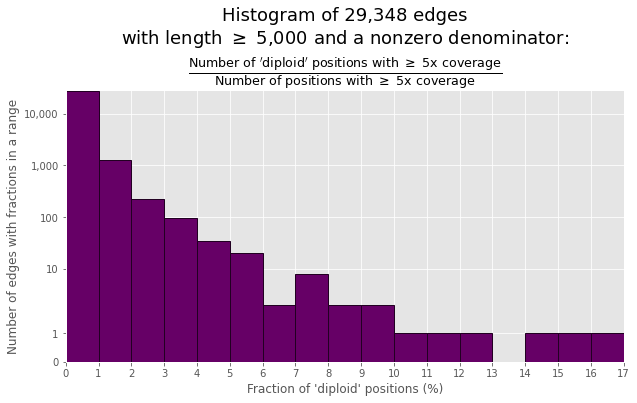

In [19]:
fracplot(
    edge2frac_diploid_to_mincov_positions,
    r"Number\ of\ positions\ with\ \geq\ 5x\ coverage",
    figfilename="prokeukfrac_den_mincov.png"
)

28,553 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78462); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_73159', 'edge_73227', 'edge_75050', 'edge_75973', 'edge_76875', 'edge_77432', 'edge_77766', 'edge_77962', 'edge_78457', 'edge_78462']
Bottom 10 edges: ['edge_8', 'edge_12', 'edge_14', 'edge_24', 'edge_34', 'edge_37', 'edge_38', 'edge_42', 'edge_46', 'edge_48']


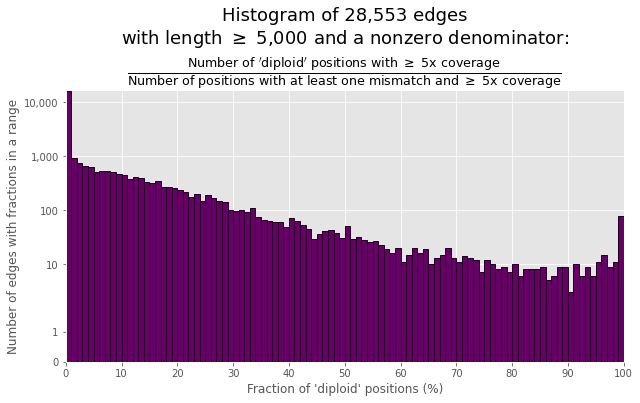

In [20]:
fracplot(
    edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch,
    r"Number\ of\ positions\ with\ at\ least\ one\ mismatch\ and\ \geq\ 5x\ coverage",
    figfilename="prokeukfrac_den_mincov_and_atleast_one_mm.png"
)

27,241 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78462); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_72261', 'edge_72309', 'edge_72350', 'edge_72388', 'edge_72452', 'edge_73227', 'edge_75050', 'edge_77766', 'edge_77962', 'edge_78462']
Bottom 10 edges: ['edge_8', 'edge_12', 'edge_14', 'edge_24', 'edge_34', 'edge_37', 'edge_38', 'edge_42', 'edge_46', 'edge_48']


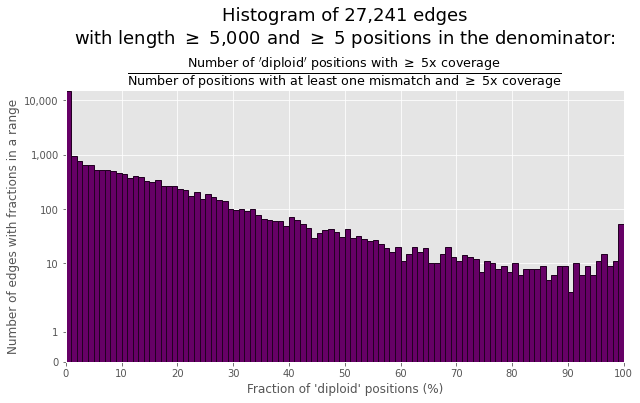

In [21]:
fracplot(
    edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5,
    r"Number\ of\ positions\ with\ at\ least\ one\ mismatch\ and\ \geq\ 5x\ coverage",
    denclause=" and $\geq$ 5 positions in the denominator",
    figfilename="prokeukfrac_den_mincov_and_atleast_one_mm_den_geq_5_pos.png"
)

27,960 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78779); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_76890', 'edge_77432', 'edge_77713', 'edge_77766', 'edge_77962', 'edge_78010', 'edge_78457', 'edge_78462', 'edge_78770', 'edge_78779']
Bottom 10 edges: ['edge_8', 'edge_12', 'edge_14', 'edge_24', 'edge_34', 'edge_37', 'edge_38', 'edge_42', 'edge_46', 'edge_48']


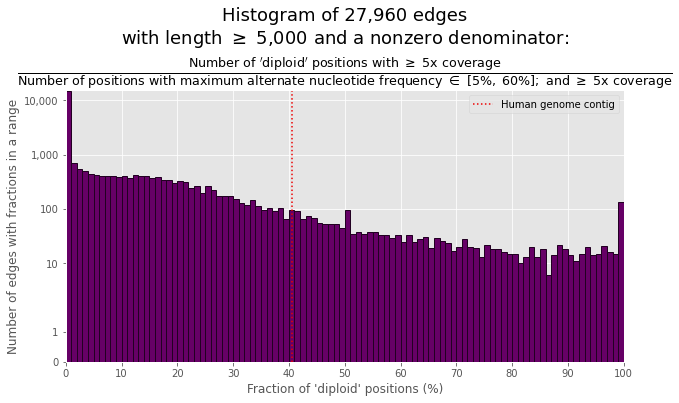

In [35]:
fracplot(
    edge2frac_diploid_to_mincov_positions_in_denominator_range,
    r"Number\ of\ positions\ with\ maximum\ alternate\ nucleotide\ frequency\ \in\ [5\%,\ 60\%];\ and\ \geq\ 5x\ coverage",
    figfilename="prokeukfrac_newden.png",
    vlines=[(57665 / 141922, "Human genome contig")]
)

25,989 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78779); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_75012', 'edge_75050', 'edge_75500', 'edge_75992', 'edge_76641', 'edge_76890', 'edge_77766', 'edge_77962', 'edge_78462', 'edge_78779']
Bottom 10 edges: ['edge_8', 'edge_12', 'edge_14', 'edge_24', 'edge_34', 'edge_37', 'edge_38', 'edge_42', 'edge_46', 'edge_48']


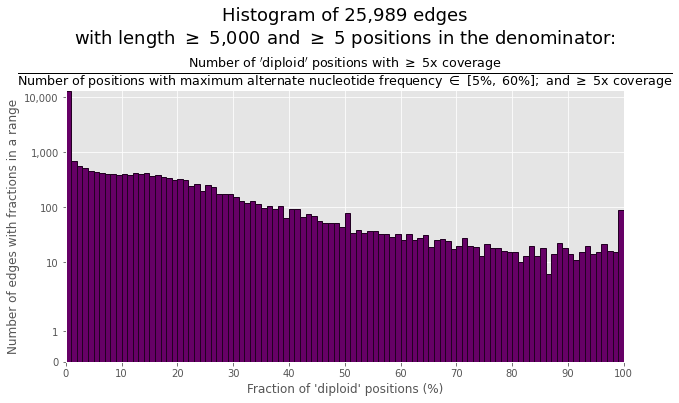

In [23]:
fracplot(
    edge2frac_diploid_to_mincov_positions_in_denominator_range_only_if_den_geq5,
    r"Number\ of\ positions\ with\ maximum\ alternate\ nucleotide\ frequency\ \in\ [5\%,\ 60\%];\ and\ \geq\ 5x\ coverage",
    figfilename="prokeukfrac_newden_den_geq_5_pos.png",
    denclause=" and $\geq$ 5 positions in the denominator",
)

In [13]:
def estats(e):
    num_dip = edge2num_mincov_putatively_diploid_positions[e]
    num_1mm = edge2num_mincov_positions_with_at_least_one_mismatch[e]
    num_den = edge2num_mincov_positions_with_mutrate_in_denominator_range[e]
    num_mcp = edge2num_mincov_positions[e]
    print("=" * 79)
    print(f"Edge {e} ({edge2len[e]:,} bp long) has ...")
    print(f"{num_mcp:,} min-cov'd positions.")
    print(f"{num_1mm:,} min-cov'd positions with at least one mismatch.")
    print(f"{num_den:,} min-cov'd positions with mut rates in den range.")
    print(f"{num_dip:,} 'diploid' min-cov'd positions.")
    try:
        print(f"Frac of mincov diploid to total mincov: {edge2frac_diploid_to_mincov_positions[e]}")
        print(f"Frac of mincov diploid to mincov'd with mut rates in den range: {edge2frac_diploid_to_mincov_positions_in_denominator_range[e]}")
        print(f"Frac of mincov diploid to mincov'd with at least one mismatch: {edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch[e]}")
        print(f"Frac of mincov diploid to mincov'd with at least one mismatch,\n    limited to if there are >= 5 such denominator positions: {edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5[e]}")
    except KeyError:
        print(f"(Looks like this edge doesn't have all fractions defined for it.)")
        pass

In [14]:
estats("edge_17771")
estats("edge_71904")
estats("edge_66025")
estats("edge_78689")
estats("edge_78501")
estats("edge_78779")
# example of an edge where we probs shouldn't care much about it, since it only has 1 min-cov'd position
# with at least one mismatch (so although its fraction for the second plot is 100%, it's probs
# not super interesting)
estats("edge_2987")
# from BLASTing this, seems like it might be a bacteria?
estats("edge_4916")

Edge edge_17771 (14,607 bp long) has ...
6,777 min-cov'd positions.
22 min-cov'd positions with at least one mismatch.
22 min-cov'd positions with mut rates in den range.
22 'diploid' min-cov'd positions.
Frac of mincov diploid to total mincov: 0.003246274162608824
Frac of mincov diploid to mincov'd with mut rates in den range: 1.0
Frac of mincov diploid to mincov'd with at least one mismatch: 1.0
Frac of mincov diploid to mincov'd with at least one mismatch,
    limited to if there are >= 5 such denominator positions: 1.0
Edge edge_71904 (34,872 bp long) has ...
3,827 min-cov'd positions.
479 min-cov'd positions with at least one mismatch.
414 min-cov'd positions with mut rates in den range.
396 'diploid' min-cov'd positions.
Frac of mincov diploid to total mincov: 0.10347530702900444
Frac of mincov diploid to mincov'd with mut rates in den range: 0.9565217391304348
Frac of mincov diploid to mincov'd with at least one mismatch: 0.826722338204593
Frac of mincov diploid to mincov'd with

## Go through some of the highest-fraction edges and retrieve their sequences in a FASTA file

So we can BLAST them, to get a sense for if they might actually correspond to sequences from eukaryotic organisms.

In [15]:
# I just copied these lists from the "top N" output printed from the fracplot() function, but I could also
# totally things up so that these are automatically computed
edges_to_fetch = set(
    ['edge_44228', 'edge_61346', 'edge_56298', 'edge_28715', 'edge_38218', 'edge_72103', 'edge_71715', 'edge_4916', 'edge_71904', 'edge_66025'] +
    ['edge_76890', 'edge_77432', 'edge_77713', 'edge_77766', 'edge_77962', 'edge_78010', 'edge_78457', 'edge_78462', 'edge_78770', 'edge_78779']
)
print(f"Trying to fetch {len(edges_to_fetch)} edge sequences.")
out_fasta = ""
with open("../main-workflow/output/all_edges.fasta", "r") as fastafile:
    
    # Assumes that sequences are not split up over multiple lines (so a FASTA file with N sequences
    # should have only 2N lines, maybe 2N + 1 if there's an extra empty newline at the bottom of the file)
    for linenum, line in enumerate(fastafile):
    
        if line.startswith(">"):
            if linenum % 2 != 0:
                raise ValueError("something weird with > location in all_edges.fasta. Go yell at Marcus.")
            edgename = line.strip()[1:]
        else:
            if linenum % 2 != 1:
                raise ValueError("something weird with non > location in all_edges.fasta. Go yell at Marcus.")
            if edgename is None:
                raise ValueError("No sequence name set yet?")
            if edgename in edges_to_fetch:
                seq = line.strip()
                out_fasta += f">{edgename}\n{seq}\n"
            edgename = None

with open("misc-output/potentially_euk_edges.fasta", "w") as eukfile:
    eukfile.write(out_fasta)

print("Done!")

Trying to fetch 20 edge sequences.
Done!


## Pick five low-fraction and five high-fraction sequences; plot histograms of all their mutation rates

In [19]:
# Three selected bacterial MAGs used in the rare mutation report, plus two edges for which the fraction
# where the denominator is # positions with mut rates in [5%, 60%] is especially low
probs_prok_seqs_to_check = ["edge_6104", "edge_1671", "edge_2358", "edge_8", "edge_12"]
# Some edges with esp high fractions from the first fraction (diploid / mincov) and another fraction
# (diploid / [5%, 60%])
probs_euk_seqs_to_check = ["edge_71904", "edge_66025", "edge_78462", "edge_78770", "edge_78779"]

seq2mincov_pos_mutation_rates = {}
for seq in (probs_euk_seqs_to_check + probs_prok_seqs_to_check):
    print(f"On seq {seq} (length {edge2len[seq]:,} bp).", end=" ")
    
    seq2mincov_pos_mutation_rates[seq] = []
    
    lenfrac = math.floor(edge2len[seq] / 50)
    
    # Same pileup iteration as above, but we're just recording mutation rates of positions with coverage
    # >= MIN_COV
    for ri, rec in enumerate(
        pysamstats.stat_variation(
            bf, chrom=seq, fafile="../main-workflow/output/all_edges.fasta", start=0, end=edge2len[seq],
            truncate=True, pad=True, max_depth=1e6
        ),
        1
    ):
        # very simple progress bar for my own sake. might miss a few dots here and there.
        # more granularity since fewer seqs
        if ri % lenfrac == 0:
            print("*", end="", flush=True)
            
        matches = rec["matches"]
        mismatches = rec["mismatches"]
        cov = matches + mismatches
        
        if cov >= MIN_COV:
            # Max freq alt nucleotide rate
            nonmatches = set("ACGT") - set(rec["ref"])
            max_alt_nt_freq = max(rec[alt_nt] for alt_nt in nonmatches)
            max_alt_nt_relfreq = max_alt_nt_freq / cov
            seq2mincov_pos_mutation_rates[seq].append(max_alt_nt_relfreq)
             
    assert ri == edge2len[seq]
    print("")

On seq edge_71904 (length 34,872 bp). **************************************************
On seq edge_66025 (length 13,937 bp). **************************************************
On seq edge_78462 (length 15,785 bp). **************************************************
On seq edge_78770 (length 17,161 bp). **************************************************
On seq edge_78779 (length 12,353 bp). **************************************************
On seq edge_6104 (length 1,289,244 bp). **************************************************
On seq edge_1671 (length 2,153,394 bp). **************************************************
On seq edge_2358 (length 2,806,161 bp). **************************************************
On seq edge_8 (length 1,710,962 bp). **************************************************
On seq edge_12 (length 124,748 bp). **************************************************


### Save this JSON data to a new file / Load it from that file so we can avoid redoing the above step if needed

(...because this data takes like 30 minutes to generate, and I don't want to have to melt an iceberg every time I want to change a color in one of these plots...)

In [26]:
with open("misc-output/seq2mincov_pos_mutation_rates.json", "w") as jf:
    jf.write(json.dumps(seq2mincov_pos_mutation_rates))

In [27]:
with open("misc-output/seq2mincov_pos_mutation_rates.json", "r") as jf:
    seq2mincov_pos_mutation_rates = json.load(jf)

In [31]:
def seq_mutrate_hist(ax, mut_rates):
    """Actually visualizes a histogram of mutation rates for a given sequence.
    
    ax should be a matplotlib Axes object -- the plot will be drawn here (useful if we wanna draw
    a bunch of these plots in the same Figure).
    
    mut_rates should contain numbers in the range [0, 1]. These'll be automatically converted to percentages.
    """
    # one bin per 5%
    bins = range(0, 101, 5)
    _, _, patches = ax.hist(
        [f * 100 for f in mut_rates],
        bins=bins,
        color="#660066",
        linewidth=1,
        edgecolor="#220022",
    )
    ax.set_ylim(0)
    ax.set_xlim(0, 100)
    ax.set_yscale("symlog") 
    use_thousands_sep(ax.yaxis)

    ax.axvline(40, color="#8888dd", linestyle="--")
    ax.axvline(60, color="#8888dd", linestyle="--")

    # Make bins in [40%, 60%) a different color
    # https://stackoverflow.com/a/49290555
    for p in range(8, 12):
        patches[p].set_facecolor("#8888dd")

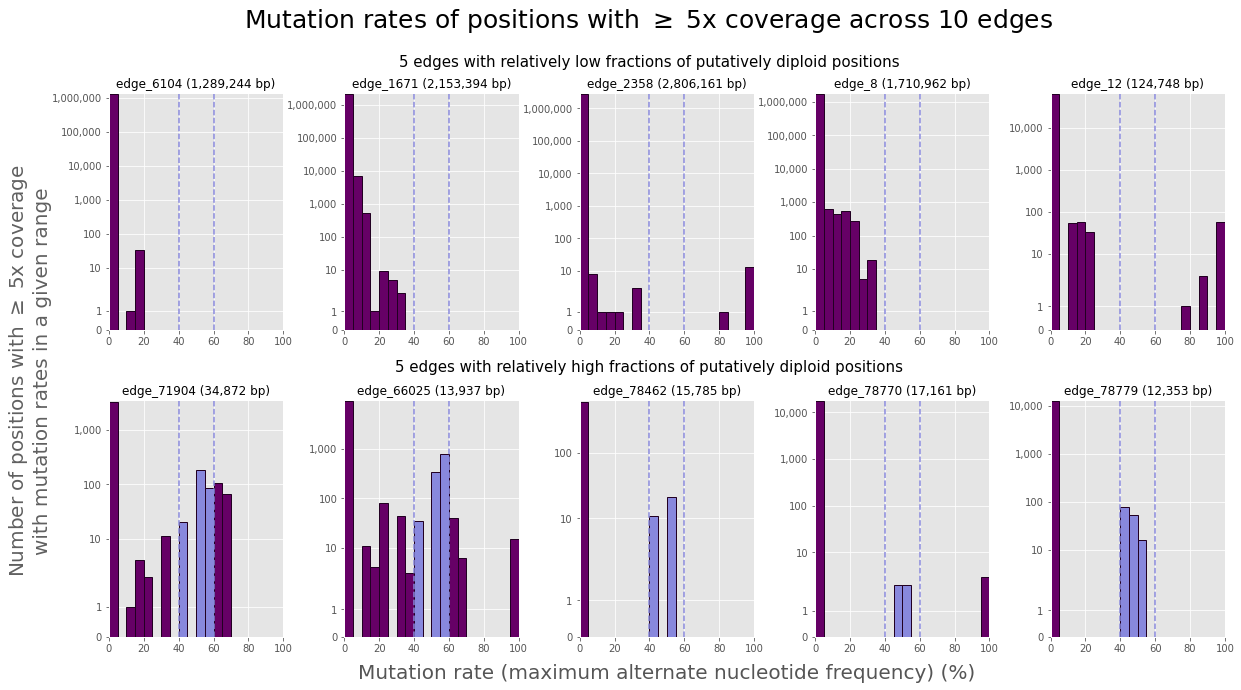

In [29]:
fig, axes = pyplot.subplots(2, 5, gridspec_kw={"wspace": 0.35, "hspace": 0.3})

rows = [probs_prok_seqs_to_check, probs_euk_seqs_to_check]
for ri, row in enumerate(rows):
    for ci, seq in enumerate(row):
        mut_rates = seq2mincov_pos_mutation_rates[seq]
        seq_mutrate_hist(axes[ri, ci], mut_rates, seq, edge2len[seq])
        ax[ri, ci].set_title(f"{seqname} ({seqlen:,} bp)", fontsize=12)

axes[1, 2].set_xlabel("Mutation rate (maximum alternate nucleotide frequency) (%)", fontsize=20, labelpad=10)
        
num_plotted_edges = sum([len(r) for r in rows])
# We move up the suptitle's y from 0.98 (default) as a very crude way to force the plot to have
# more space between this title and the row 1 title.
fig.suptitle(
    f"Mutation rates of positions with $\geq$ 5x coverage across {num_plotted_edges} edges",
    y=1,
    fontsize=25
)

# y-axis label: centered on the left side of the figure
fig.text(
    0.07, 0.495,
    "Number of positions with $\geq$ 5x coverage\nwith mutation rates in a given range",
    color="#606060",
    fontsize=20,
    rotation=90,
    va="center",
    ha="center"
)
# Title for row 1. The y=0.923 here is because this is figure coordinates, so this is "close to the top
# of the plot".
fig.text(
    0.5, 0.923,
    '5 edges with relatively low fractions of putatively diploid positions',
    fontsize=15,
    ha="center",
    va="center"
)
# Title for row 2.
fig.text(
    0.5, 0.5,
    '5 edges with relatively high fractions of putatively diploid positions',
    fontsize=15,
    ha="center",
    va="center"
)
fig.set_size_inches(20, 10)
fig.savefig("figs/prokeuk_10_mutrate_histograms.png", bbox_inches="tight")

## Similar mutation-rate visualization, but for a contig from a human genome assembly

In [6]:
# NOTE: This is a huge file, if this needs to be adapted into a pipeline or something this should be modified
# so that the file is read line-by-line or something rather than all at once
with open("../../hifiasm-hg002/output/h1tg000001l-mincov-pos-mutation-rates.json", "r") as hf:
    h_mut_rates = json.load(hf)["h1tg000001l"]
    
print(f"There are {len(h_mut_rates):,} positions described in this file.")

There are 101,325,796 positions described in this file.


In [9]:
h_contig_len = len(skbio.DNA.read("../../hifiasm-hg002/h1tg000001l.fasta"))
print(f"Contig has length {h_contig_len:,} bp.")

Contig has length 101,329,166 bp.


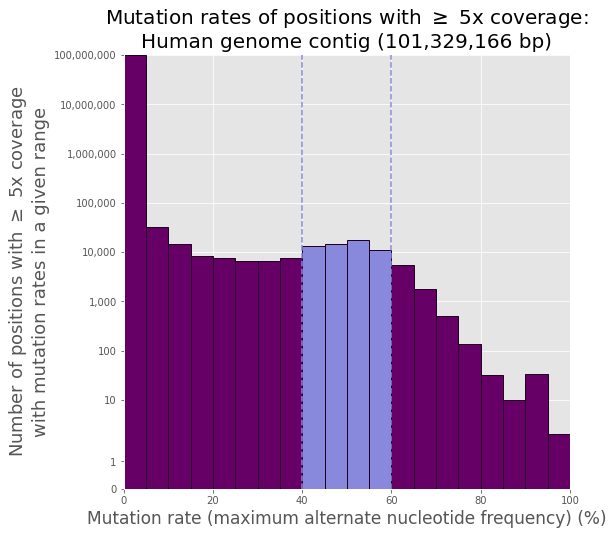

In [35]:
fig, ax = pyplot.subplots(1)

seq_mutrate_hist(ax, h_mut_rates)

ax.set_title(f"Mutation rates of positions with $\geq$ 5x coverage:\nHuman genome contig ({h_contig_len:,} bp)", fontsize=20)
ax.set_xlabel("Mutation rate (maximum alternate nucleotide frequency) (%)", fontsize=17)
ax.set_ylabel("Number of positions with $\geq$ 5x coverage\nwith mutation rates in a given range", fontsize=18)

fig.set_size_inches(8, 8)
fig.savefig("figs/prokeuk_hcontig_mutrate_histogram.png", bbox_inches="tight")

In [42]:
num_h_diploid_mincov = 0
num_h_btwn_5_60_mincov = 0
num_h_btwn_3_50_mincov = 0
for mr in h_mut_rates:
    if mr >= MIN_DIPLOID_MAXALT_FREQ and mr <= MAX_DIPLOID_MAXALT_FREQ:
        num_h_diploid_mincov += 1
    if mr >= MIN_DENOMINATOR_MAXALT_FREQ and mr <= MAX_DENOMINATOR_MAXALT_FREQ:
        num_h_btwn_5_60_mincov += 1
    if mr >= 0.03 and mr <= 0.5:
        num_h_btwn_3_50_mincov += 1
        
print(f"H. contig has {num_h_diploid_mincov:,} putatively diploid positions with cov >= {MIN_COV}x.")
print(f"H. contig has {num_h_btwn_5_60_mincov:,} positions with mut rates in [5%, 60%] with cov >= {MIN_COV}x.")
print(f"H. contig has {num_h_btwn_3_50_mincov:,} positions with mut rates in [3%, 50%] with cov >= {MIN_COV}x.")

print("=" * 79)
f =  100 * (num_h_diploid_mincov / num_h_btwn_5_60_mincov)
f2 = 100 * (num_h_diploid_mincov / num_h_btwn_3_50_mincov)
print(f"So the fraction,  using the denominator as the [5%, 60%] positions, is {f:.2f}%.")
print(f"And the fraction, using the denominator as the [3%, 50%] positions, is {f2:.2f}%.")

H. contig has 57,665 putatively diploid positions with cov >= 5x.
H. contig has 141,922 positions with mut rates in [5%, 60%] with cov >= 5x.
H. contig has 249,064 positions with mut rates in [3%, 50%] with cov >= 5x.
So the fraction,  using the denominator as the [5%, 60%] positions, is 40.63%.
And the fraction, using the denominator as the [3%, 50%] positions, is 23.15%.
